In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.stats import multivariate_normal

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


### FUNCTIONS

In [4]:
def XG(X_train, X_test, X_val, Y_train, Y_test, Y_val, n_estimators=500,
        learning_rate=0.1,
        reg_lambda=0.0,reg_alpha=0.0,
        gamma=0.0,objective='binary:logistic',
        max_depth=5,
        early_stopping_rounds=50):
    
    # CLASSIFIER
    classifier = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,reg_alpha=reg_alpha,
        gamma=gamma,objective='binary:logistic',
        max_depth=max_depth)

    # FIT
    classifier.fit(X_train,Y_train,eval_set=[(X_train, Y_train), (X_val, Y_val)],
            eval_metric='logloss',early_stopping_rounds=early_stopping_rounds,#early stopping
            verbose=True)

    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_test).T[1]


    # ROC
    fpr_xg, tpr_xg, _ = roc_curve(Y_test, y_pred_xg)
    roc_auc_xg = auc(fpr_xg, tpr_xg)


    # PLOT THE ROC WITH AUC
    fig = plt.figure(figsize=(6, 6))
    gs = gridspec.GridSpec(1, 1) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax0.minorticks_on()


    plt.plot(tpr_xg,1-fpr_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
    plt.plot([1,0],[0,1],ls=":",color="grey")
    plt.xlabel("True Positive Rate",fontsize=16)
    plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
    plt.legend()
    plt.title(r"XGBoost",fontsize=16)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.yticks([0.2,0.4,0.6,0.8,1.])
    plt.legend(frameon=False,fontsize=16)
    plt.show()
    
    return roc_auc_xg, y_pred_xg

In [5]:
def ensembler(B_expected, S_expected, n_ensembles):
    
    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.8),int(mu*1.2))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ round( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected/(S_expected+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( round(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - round(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######
    
    return list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles

In [6]:
def jitter(a_series, noise_reduction=1000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

In [7]:
def Z_BL_full(B_data, S_data, B_expected, S_expected, bins, ranges, linear_bins=True):
    
    # Les't use an integer number of possible ensembles
    N_ensembles_back = int(len(B_data) / B_expected)
    N_events_back = N_ensembles_back * B_expected

    N_ensembles_sig = int(len(S_data) / S_expected)
    N_events_sig = N_ensembles_sig * S_expected
    
    
    #Let's find out the expected number of B and S events in each bin:
    
    if linear_bins==False:
        # same number of B events per bin
        bin_edges_same = pd.qcut(pd.DataFrame(B_data[:N_events_back])[0] + jitter(pd.DataFrame(B_data[:N_events_back])[0]), q = bins, precision=0, retbins = True)[1]
        bins = [bin_edges_same]

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd(B_data[:N_events_back], bins=bins, range = ranges)
    # now divide by the number of possible ensembles
    back_prom = hist_back.T.ravel()/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd(S_data[:N_events_sig], bins=bins, range = ranges)
    sig_prom = hist_sig.T.ravel()/N_ensembles_sig
    
    
    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    back_prom_noceros = []
    for i in range(len(back_prom)):
        if back_prom[i]!=0:
            back_prom_noceros.append(back_prom[i])

    min_back = min(back_prom_noceros)

    # replace the zeros
    for i in range(len(back_prom)):
        if back_prom[i]==0:
            back_prom[i] = min_back

    # then the signif Z^binned-Asimov:
    Z_bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5
    
    return Z_bins

In [8]:
def KDE_finder(B_data, S_data, events_to_fit=20000, bandwidth_space=np.logspace(-3.0, 0.05, 20), set_kernel='epanechnikov'):

    kde = KernelDensity(kernel=set_kernel)
    grid = GridSearchCV(kde, {'bandwidth': bandwidth_space})
    grid.fit(np.c_[B_data[:events_to_fit]])

    B_bandwidth = grid.best_estimator_.bandwidth



    kde = KernelDensity(kernel=set_kernel)
    grid = GridSearchCV(kde, {'bandwidth': bandwidth_space})
    grid.fit(np.c_[S_data[:events_to_fit]])

    S_bandwidth = grid.best_estimator_.bandwidth



    # with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
    # notice: epanechnikov kernel
    kde_bkg = KernelDensity(kernel=set_kernel, bandwidth=B_bandwidth).fit(np.c_[B_data, np.zeros(len(B_data)) ])
    kde_sig = KernelDensity(kernel=set_kernel, bandwidth=S_bandwidth).fit(np.c_[S_data, np.ones(len(S_data)) ])

    print('KDE Kernel: ', set_kernel)
    print('Background bandwidth: ', B_bandwidth)
    print('Signal bandwidth: ', S_bandwidth)
    
    return kde_bkg, kde_sig, B_bandwidth, S_bandwidth

In [9]:
def Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles):
    
    muhat_selected_list = []
    q_muhat = []
    q_muhat_mu0 = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):

            ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])
            
            prob_B_given_B_shuf = []
            prob_B_given_S_shuf = []

            for i in ran_ind:
                prob_B_given_B_shuf.append(prob_B_given_B[i])
                prob_B_given_S_shuf.append(prob_B_given_S[i])

            prob_B_given_B_shuf  = prob_B_given_B_shuf
            prob_B_given_S_shuf  = prob_B_given_S_shuf

                

            # p_b(x_ensemble) =    concatenate: p_b(B_ensemble) and p_b(S_ensemble)
            prob_x_given_B = prob_B_given_B_shuf #+ prob_NP_given_B_shuf

            # p_s(x_ensemble) =    concatenate: p_s(B_ensemble) and p_s(S_ensemble)
            prob_x_given_S = prob_B_given_S_shuf #+ prob_NP_given_S_shuf
            



            
            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
            
            sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            # grid, mu_hat is around 1
            muhat_test = np.arange(0., 1., 0.05).tolist()

            muhat_selected = 0.0

            if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected = muhat_test[vv]
                        break

            elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected = muhat_test[vv]
                        break


            muhat_selected_list.append(muhat_selected)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            # DISCOVERY:
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat.append( 2 * ( ( (1.-muhat_selected) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (muhat_selected*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            q_muhat_mu0.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0.*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            
            
    # Finally calculate muhat_mean and Z
    muhat_mean = np.mean(muhat_selected_list)

    # Remove nan if any
    q_muhat = [x for x in q_muhat if x == x]
    for jk in range(len(q_muhat)):
        if q_muhat[jk] < 0:
            q_muhat[jk] = 0

    q_muhat_median = np.median(q_muhat)

    Z_nobin = abs(q_muhat_median)**0.5
    
    
    
    # Remove nan if any
    q_muhat_mu0 = [x for x in q_muhat_mu0 if x == x]
    for jk in range(len(q_muhat_mu0)):
        if q_muhat_mu0[jk] < 0:
            q_muhat_mu0[jk] = 0

    q_muhat_mu0_median = np.median(q_muhat_mu0)

    Z_nobin_mu0 = abs(q_muhat_mu0_median)**0.5
    
    
    return Z_nobin, muhat_mean, Z_nobin_mu0, muhat_selected_list, q_muhat, q_muhat_mu0

### GAUSSIAN

In [10]:
##############
# PARAMETERS #
##############

# gaussian, mean
epsilon = 0.7

# number of events
N = 1500000

# requested number of ensembles
n_ensembles = 10000

# number of expected background events per ensemble
B_expected = 50000

# ratio S_expected/B_expected (signal ratio)
SB_ratio = 0.01

# number of ML classifiers to do bagging
iterations_ML = 10



# SOME USEFUL DERIVATED PARAMETERS:

# S_expected:
S_expected = 500

# S/\sqrt{B}
SsqrtB = 500/(50000)**0.5

### COMPUTE

In [13]:
store_AUC = []

store_Z_bins_XG_10bins_1ML = []
store_Z_bins_XG_25bins_1ML = []
store_Z_bins_XG_50bins_1ML = []
store_Z_bins_XG_100bins_1ML = []

store_Z_bins_XG_10bins_eq_1ML = []
store_Z_bins_XG_25bins_eq_1ML = []
store_Z_bins_XG_50bins_eq_1ML = []
store_Z_bins_XG_100bins_eq_1ML = []

store_Z_bins_XG_10bins = []
store_Z_bins_XG_25bins = []
store_Z_bins_XG_50bins = []
store_Z_bins_XG_100bins = []

store_Z_bins_XG_10bins_eq = []
store_Z_bins_XG_25bins_eq = []
store_Z_bins_XG_50bins_eq = []
store_Z_bins_XG_100bins_eq = []

store_muhat_mean_gaussian = []
store_Z_gaussian = []
store_Z_gaussian_mu0 = []

store_muhat_mean_MLL_KDE = []
store_Z_MLL_KDE = []
store_Z_MLL_KDE_mu0 = []

store_muhat_mean_MLL_KDE_1ML = []
store_Z_MLL_KDE_1ML = []
store_Z_MLL_KDE_mu0_1ML = []


X_gauss_train :  (1000000, 1)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 1)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 1)
y_gauss_test :  (1000000, 1)



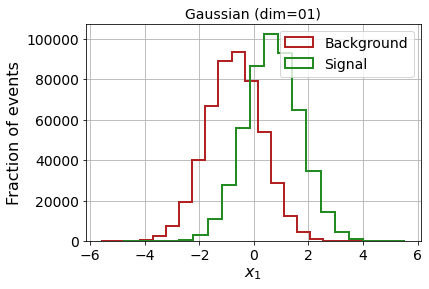

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66043	validation_1-logloss:0.66040
[1]	validation_0-logloss:0.63382	validation_1-logloss:0.63375
[2]	validation_0-logloss:0.61187	validation_1-logloss:0.61176
[3]	validation_0-logloss:0.59364	validation_1-logloss:0.59349
[4]	validation_0-logloss:0.57838	validation_1-logloss:0.57820
[5]	validation_0-logloss:0.56558	validation_1-logloss:0.56537
[6]	validation_0-logloss:0.55485	validation_1-logloss:0.55461
[7]	validation_0-logloss:0.54575	validation_1-logloss:0.54549
[8]	validation_0-logloss:0.53805	validation_1-logloss:0.53777
[9]	validation_0-logloss:0.53158	validation_1-logloss:0.53128
[10]	validation_0-logloss:0.52604	validation_1-logloss:0.52572
[11]	validation_0-logloss:0.52133	validation_1-logloss:0.52098
[12]	validation_0-logloss:0.51738	validation_1-logloss:0.51702
[13]	validation_0-logloss:0.51403	validation_1-logloss:0.51365
[14]	validation_0-logloss:0.51114	validation_1-logloss:0.51075
[15]	validation_0-logloss:0.50872	validation_1-logloss:0.50832
[1

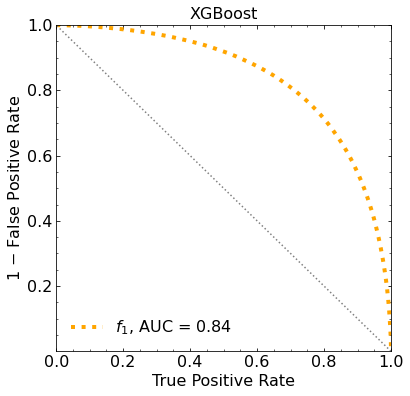

ML iteration 0
[0]	validation_0-logloss:0.66034	validation_1-logloss:0.66044
[1]	validation_0-logloss:0.63359	validation_1-logloss:0.63369
[2]	validation_0-logloss:0.61154	validation_1-logloss:0.61172
[3]	validation_0-logloss:0.59322	validation_1-logloss:0.59346
[4]	validation_0-logloss:0.57789	validation_1-logloss:0.57817


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[5]	validation_0-logloss:0.56502	validation_1-logloss:0.56543
[6]	validation_0-logloss:0.55415	validation_1-logloss:0.55465
[7]	validation_0-logloss:0.54496	validation_1-logloss:0.54554
[8]	validation_0-logloss:0.53717	validation_1-logloss:0.53786
[9]	validation_0-logloss:0.53058	validation_1-logloss:0.53137
[10]	validation_0-logloss:0.52497	validation_1-logloss:0.52583
[11]	validation_0-logloss:0.52020	validation_1-logloss:0.52104
[12]	validation_0-logloss:0.51613	validation_1-logloss:0.51712
[13]	validation_0-logloss:0.51266	validation_1-logloss:0.51372
[14]	validation_0-logloss:0.50970	validation_1-logloss:0.51089
[15]	validation_0-logloss:0.50719	validation_1-logloss:0.50843
[16]	validation_0-logloss:0.50502	validation_1-logloss:0.50641
[17]	validation_0-logloss:0.50319	validation_1-logloss:0.50460
[18]	validation_0-logloss:0.50162	validation_1-logloss:0.50314
[19]	validation_0-logloss:0.50028	validation_1-logloss:0.50192
[20]	validation_0-logloss:0.49913	validation_1-logloss:0.500

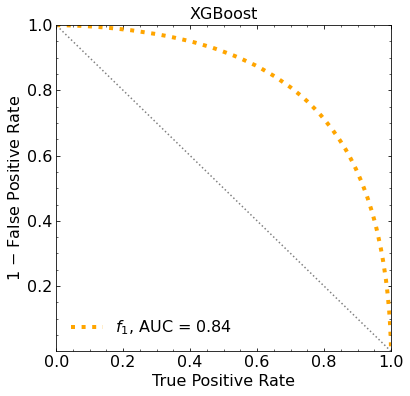

ML iteration  1
[0]	validation_0-logloss:0.66065	validation_1-logloss:0.66051
[1]	validation_0-logloss:0.63414	validation_1-logloss:0.63396


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2]	validation_0-logloss:0.61230	validation_1-logloss:0.61197
[3]	validation_0-logloss:0.59414	validation_1-logloss:0.59378
[4]	validation_0-logloss:0.57896	validation_1-logloss:0.57858
[5]	validation_0-logloss:0.56620	validation_1-logloss:0.56578
[6]	validation_0-logloss:0.55546	validation_1-logloss:0.55498
[7]	validation_0-logloss:0.54637	validation_1-logloss:0.54593
[8]	validation_0-logloss:0.53867	validation_1-logloss:0.53824
[9]	validation_0-logloss:0.53214	validation_1-logloss:0.53173
[10]	validation_0-logloss:0.52659	validation_1-logloss:0.52619
[11]	validation_0-logloss:0.52187	validation_1-logloss:0.52147
[12]	validation_0-logloss:0.51784	validation_1-logloss:0.51759
[13]	validation_0-logloss:0.51441	validation_1-logloss:0.51413
[14]	validation_0-logloss:0.51149	validation_1-logloss:0.51133
[15]	validation_0-logloss:0.50900	validation_1-logloss:0.50877
[16]	validation_0-logloss:0.50688	validation_1-logloss:0.50673
[17]	validation_0-logloss:0.50507	validation_1-logloss:0.50496


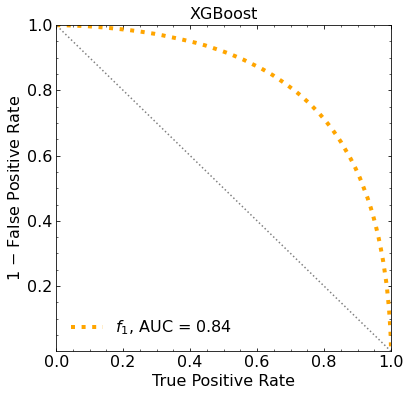

ML iteration  2
[0]	validation_0-logloss:0.66048	validation_1-logloss:0.66046
[1]	validation_0-logloss:0.63384	validation_1-logloss:0.63381
[2]	validation_0-logloss:0.61189	validation_1-logloss:0.61182
[3]	validation_0-logloss:0.59366	validation_1-logloss:0.59364
[4]	validation_0-logloss:0.57841	validation_1-logloss:0.57836


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[5]	validation_0-logloss:0.56561	validation_1-logloss:0.56563
[6]	validation_0-logloss:0.55483	validation_1-logloss:0.55488
[7]	validation_0-logloss:0.54568	validation_1-logloss:0.54575
[8]	validation_0-logloss:0.53795	validation_1-logloss:0.53811
[9]	validation_0-logloss:0.53139	validation_1-logloss:0.53160
[10]	validation_0-logloss:0.52583	validation_1-logloss:0.52606
[11]	validation_0-logloss:0.52110	validation_1-logloss:0.52134
[12]	validation_0-logloss:0.51707	validation_1-logloss:0.51739
[13]	validation_0-logloss:0.51363	validation_1-logloss:0.51404
[14]	validation_0-logloss:0.51072	validation_1-logloss:0.51116
[15]	validation_0-logloss:0.50821	validation_1-logloss:0.50870
[16]	validation_0-logloss:0.50609	validation_1-logloss:0.50662
[17]	validation_0-logloss:0.50427	validation_1-logloss:0.50495
[18]	validation_0-logloss:0.50273	validation_1-logloss:0.50343
[19]	validation_0-logloss:0.50142	validation_1-logloss:0.50223
[20]	validation_0-logloss:0.50029	validation_1-logloss:0.501

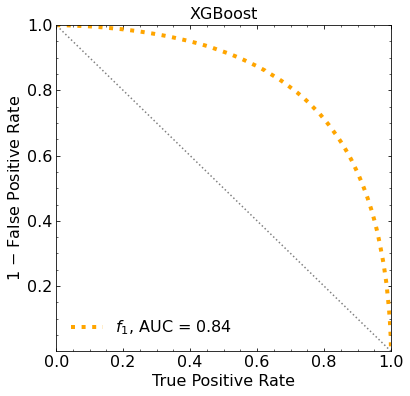

ML iteration  3
[0]	validation_0-logloss:0.66029	validation_1-logloss:0.66039
[1]	validation_0-logloss:0.63348	validation_1-logloss:0.63368
[2]	validation_0-logloss:0.61141	validation_1-logloss:0.61180
[3]	validation_0-logloss:0.59305	validation_1-logloss:0.59352
[4]	validation_0-logloss:0.57773	validation_1-logloss:0.57830


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[5]	validation_0-logloss:0.56485	validation_1-logloss:0.56551
[6]	validation_0-logloss:0.55401	validation_1-logloss:0.55478
[7]	validation_0-logloss:0.54484	validation_1-logloss:0.54565
[8]	validation_0-logloss:0.53709	validation_1-logloss:0.53801
[9]	validation_0-logloss:0.53051	validation_1-logloss:0.53147
[10]	validation_0-logloss:0.52493	validation_1-logloss:0.52600
[11]	validation_0-logloss:0.52017	validation_1-logloss:0.52129
[12]	validation_0-logloss:0.51613	validation_1-logloss:0.51733
[13]	validation_0-logloss:0.51269	validation_1-logloss:0.51400
[14]	validation_0-logloss:0.50975	validation_1-logloss:0.51106
[15]	validation_0-logloss:0.50725	validation_1-logloss:0.50871
[16]	validation_0-logloss:0.50512	validation_1-logloss:0.50662
[17]	validation_0-logloss:0.50329	validation_1-logloss:0.50485
[18]	validation_0-logloss:0.50175	validation_1-logloss:0.50337
[19]	validation_0-logloss:0.50042	validation_1-logloss:0.50213
[20]	validation_0-logloss:0.49930	validation_1-logloss:0.501

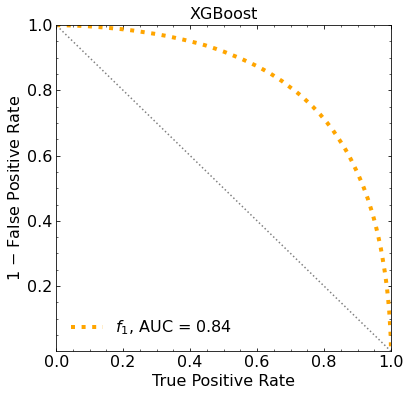

ML iteration  4
[0]	validation_0-logloss:0.66051	validation_1-logloss:0.66047
[1]	validation_0-logloss:0.63389	validation_1-logloss:0.63375
[2]	validation_0-logloss:0.61192	validation_1-logloss:0.61172
[3]	validation_0-logloss:0.59371	validation_1-logloss:0.59344


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[4]	validation_0-logloss:0.57843	validation_1-logloss:0.57818
[5]	validation_0-logloss:0.56564	validation_1-logloss:0.56537
[6]	validation_0-logloss:0.55484	validation_1-logloss:0.55465
[7]	validation_0-logloss:0.54570	validation_1-logloss:0.54549
[8]	validation_0-logloss:0.53796	validation_1-logloss:0.53783
[9]	validation_0-logloss:0.53140	validation_1-logloss:0.53137
[10]	validation_0-logloss:0.52582	validation_1-logloss:0.52575
[11]	validation_0-logloss:0.52107	validation_1-logloss:0.52112
[12]	validation_0-logloss:0.51701	validation_1-logloss:0.51714
[13]	validation_0-logloss:0.51358	validation_1-logloss:0.51379
[14]	validation_0-logloss:0.51063	validation_1-logloss:0.51093
[15]	validation_0-logloss:0.50813	validation_1-logloss:0.50844
[16]	validation_0-logloss:0.50600	validation_1-logloss:0.50641
[17]	validation_0-logloss:0.50419	validation_1-logloss:0.50470
[18]	validation_0-logloss:0.50264	validation_1-logloss:0.50321
[19]	validation_0-logloss:0.50132	validation_1-logloss:0.5019

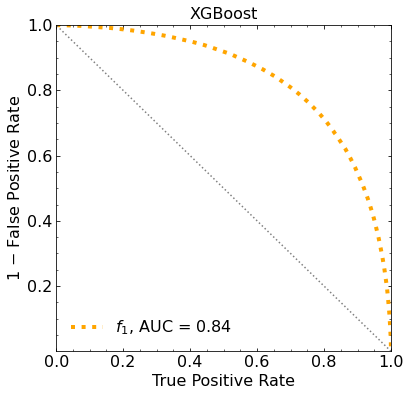

ML iteration  5
[0]	validation_0-logloss:0.66026	validation_1-logloss:0.66035
[1]	validation_0-logloss:0.63345	validation_1-logloss:0.63373
[2]	validation_0-logloss:0.61136	validation_1-logloss:0.61172
[3]	validation_0-logloss:0.59299	validation_1-logloss:0.59348
[4]	validation_0-logloss:0.57764	validation_1-logloss:0.57828


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[5]	validation_0-logloss:0.56476	validation_1-logloss:0.56554
[6]	validation_0-logloss:0.55391	validation_1-logloss:0.55475
[7]	validation_0-logloss:0.54474	validation_1-logloss:0.54569
[8]	validation_0-logloss:0.53697	validation_1-logloss:0.53801
[9]	validation_0-logloss:0.53038	validation_1-logloss:0.53147
[10]	validation_0-logloss:0.52479	validation_1-logloss:0.52602
[11]	validation_0-logloss:0.52003	validation_1-logloss:0.52132
[12]	validation_0-logloss:0.51598	validation_1-logloss:0.51734
[13]	validation_0-logloss:0.51253	validation_1-logloss:0.51397
[14]	validation_0-logloss:0.50959	validation_1-logloss:0.51115
[15]	validation_0-logloss:0.50709	validation_1-logloss:0.50868
[16]	validation_0-logloss:0.50496	validation_1-logloss:0.50665
[17]	validation_0-logloss:0.50313	validation_1-logloss:0.50486
[18]	validation_0-logloss:0.50159	validation_1-logloss:0.50342
[19]	validation_0-logloss:0.50028	validation_1-logloss:0.50213
[20]	validation_0-logloss:0.49915	validation_1-logloss:0.501

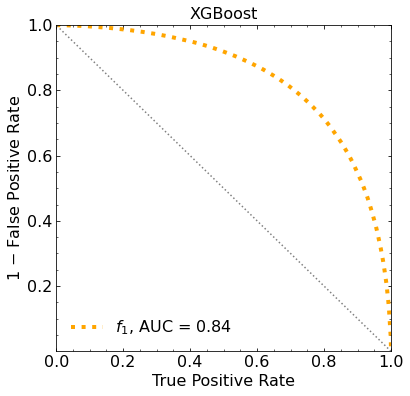

ML iteration  6
[0]	validation_0-logloss:0.66069	validation_1-logloss:0.66066
[1]	validation_0-logloss:0.63421	validation_1-logloss:0.63417
[2]	validation_0-logloss:0.61239	validation_1-logloss:0.61234
[3]	validation_0-logloss:0.59428	validation_1-logloss:0.59417
[4]	validation_0-logloss:0.57913	validation_1-logloss:0.57899


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[5]	validation_0-logloss:0.56642	validation_1-logloss:0.56622
[6]	validation_0-logloss:0.55570	validation_1-logloss:0.55555
[7]	validation_0-logloss:0.54666	validation_1-logloss:0.54648
[8]	validation_0-logloss:0.53900	validation_1-logloss:0.53882
[9]	validation_0-logloss:0.53251	validation_1-logloss:0.53224
[10]	validation_0-logloss:0.52696	validation_1-logloss:0.52672
[11]	validation_0-logloss:0.52228	validation_1-logloss:0.52202
[12]	validation_0-logloss:0.51828	validation_1-logloss:0.51805
[13]	validation_0-logloss:0.51489	validation_1-logloss:0.51461
[14]	validation_0-logloss:0.51201	validation_1-logloss:0.51172
[15]	validation_0-logloss:0.50953	validation_1-logloss:0.50923
[16]	validation_0-logloss:0.50743	validation_1-logloss:0.50722
[17]	validation_0-logloss:0.50562	validation_1-logloss:0.50544
[18]	validation_0-logloss:0.50409	validation_1-logloss:0.50386
[19]	validation_0-logloss:0.50279	validation_1-logloss:0.50259
[20]	validation_0-logloss:0.50168	validation_1-logloss:0.501

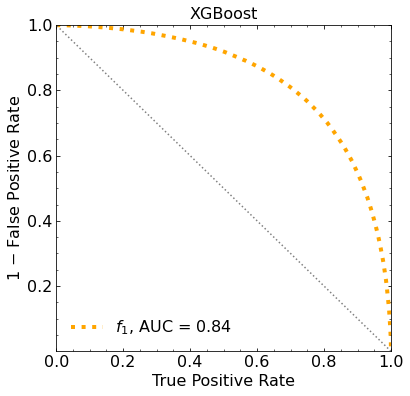

ML iteration  7
[0]	validation_0-logloss:0.66020	validation_1-logloss:0.66034
[1]	validation_0-logloss:0.63332	validation_1-logloss:0.63360
[2]	validation_0-logloss:0.61117	validation_1-logloss:0.61171
[3]	validation_0-logloss:0.59276	validation_1-logloss:0.59342
[4]	validation_0-logloss:0.57737	validation_1-logloss:0.57825


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[5]	validation_0-logloss:0.56444	validation_1-logloss:0.56542
[6]	validation_0-logloss:0.55353	validation_1-logloss:0.55463
[7]	validation_0-logloss:0.54432	validation_1-logloss:0.54549
[8]	validation_0-logloss:0.53650	validation_1-logloss:0.53779
[9]	validation_0-logloss:0.52988	validation_1-logloss:0.53137
[10]	validation_0-logloss:0.52425	validation_1-logloss:0.52578
[11]	validation_0-logloss:0.51946	validation_1-logloss:0.52113
[12]	validation_0-logloss:0.51538	validation_1-logloss:0.51716
[13]	validation_0-logloss:0.51190	validation_1-logloss:0.51372
[14]	validation_0-logloss:0.50895	validation_1-logloss:0.51092
[15]	validation_0-logloss:0.50644	validation_1-logloss:0.50845
[16]	validation_0-logloss:0.50430	validation_1-logloss:0.50644
[17]	validation_0-logloss:0.50247	validation_1-logloss:0.50469
[18]	validation_0-logloss:0.50091	validation_1-logloss:0.50323
[19]	validation_0-logloss:0.49959	validation_1-logloss:0.50196
[20]	validation_0-logloss:0.49847	validation_1-logloss:0.500

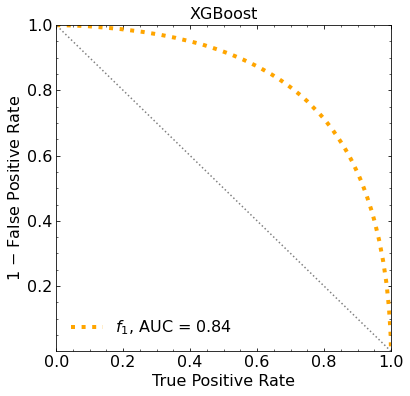

ML iteration  8
[0]	validation_0-logloss:0.65990	validation_1-logloss:0.66025
[1]	validation_0-logloss:0.63277	validation_1-logloss:0.63345
[2]	validation_0-logloss:0.61042	validation_1-logloss:0.61133
[3]	validation_0-logloss:0.59182	validation_1-logloss:0.59300
[4]	validation_0-logloss:0.57627	validation_1-logloss:0.57767


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[5]	validation_0-logloss:0.56319	validation_1-logloss:0.56488
[6]	validation_0-logloss:0.55216	validation_1-logloss:0.55407
[7]	validation_0-logloss:0.54283	validation_1-logloss:0.54492
[8]	validation_0-logloss:0.53491	validation_1-logloss:0.53722
[9]	validation_0-logloss:0.52819	validation_1-logloss:0.53073
[10]	validation_0-logloss:0.52247	validation_1-logloss:0.52519
[11]	validation_0-logloss:0.51760	validation_1-logloss:0.52053
[12]	validation_0-logloss:0.51345	validation_1-logloss:0.51653
[13]	validation_0-logloss:0.50989	validation_1-logloss:0.51319
[14]	validation_0-logloss:0.50686	validation_1-logloss:0.51028
[15]	validation_0-logloss:0.50427	validation_1-logloss:0.50793
[16]	validation_0-logloss:0.50207	validation_1-logloss:0.50585
[17]	validation_0-logloss:0.50018	validation_1-logloss:0.50406
[18]	validation_0-logloss:0.49857	validation_1-logloss:0.50260
[19]	validation_0-logloss:0.49720	validation_1-logloss:0.50142
[20]	validation_0-logloss:0.49602	validation_1-logloss:0.500

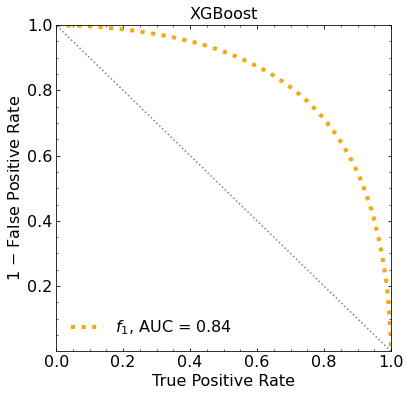

ML iteration  9
[0]	validation_0-logloss:0.66022	validation_1-logloss:0.66030
[1]	validation_0-logloss:0.63335	validation_1-logloss:0.63355
[2]	validation_0-logloss:0.61121	validation_1-logloss:0.61150
[3]	validation_0-logloss:0.59281	validation_1-logloss:0.59320
[4]	validation_0-logloss:0.57742	validation_1-logloss:0.57795


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[5]	validation_0-logloss:0.56450	validation_1-logloss:0.56520
[6]	validation_0-logloss:0.55359	validation_1-logloss:0.55441
[7]	validation_0-logloss:0.54436	validation_1-logloss:0.54533
[8]	validation_0-logloss:0.53654	validation_1-logloss:0.53761
[9]	validation_0-logloss:0.52990	validation_1-logloss:0.53107
[10]	validation_0-logloss:0.52427	validation_1-logloss:0.52559
[11]	validation_0-logloss:0.51945	validation_1-logloss:0.52087
[12]	validation_0-logloss:0.51534	validation_1-logloss:0.51687
[13]	validation_0-logloss:0.51184	validation_1-logloss:0.51353
[14]	validation_0-logloss:0.50888	validation_1-logloss:0.51072
[15]	validation_0-logloss:0.50635	validation_1-logloss:0.50824
[16]	validation_0-logloss:0.50418	validation_1-logloss:0.50620
[17]	validation_0-logloss:0.50234	validation_1-logloss:0.50445
[18]	validation_0-logloss:0.50077	validation_1-logloss:0.50303
[19]	validation_0-logloss:0.49941	validation_1-logloss:0.50178
[20]	validation_0-logloss:0.49827	validation_1-logloss:0.500

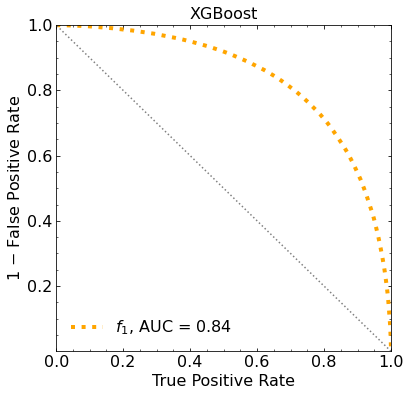

Classification score (1 ML):


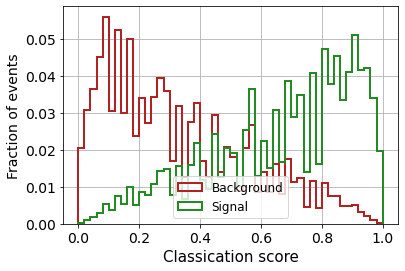

Classification score (10 ML):


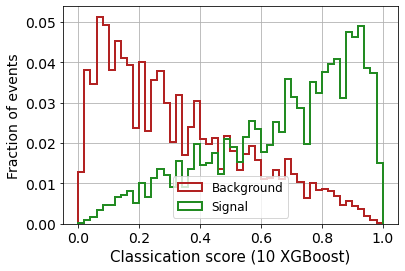

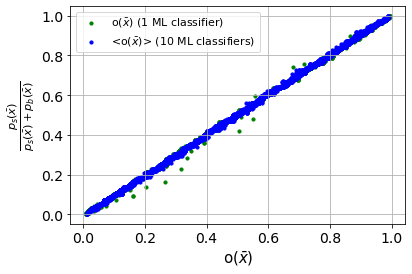


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  4.900672776243757
Z_XG 25 bins_1ML:  5.272275479417459
Z_XG 50 bins_1ML:  5.36291939047819
Z_XG 100 bins_1ML:  5.399444175695006

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  4.075613975314512
Z_XG 25 bins_eq_1ML:  4.519879355343759
Z_XG 50 bins_eq_1ML:  4.772969120704275
Z_XG 100 bins_eq_1ML:  4.980368905989027

 BL lineal bins, 10 ML
Z_XG 10 bins:  4.910327658411742
Z_XG 25 bins:  5.256663083612902
Z_XG 50 bins:  5.356094989654455
Z_XG 100 bins:  5.371062599759511

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  4.081911105932502
Z_XG 25 bins_eq:  4.527655372082387
Z_XG 50 bins_eq:  4.781151072014415
Z_XG 100 bins_eq:  4.9651143104725595

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD (GAUSSIAN

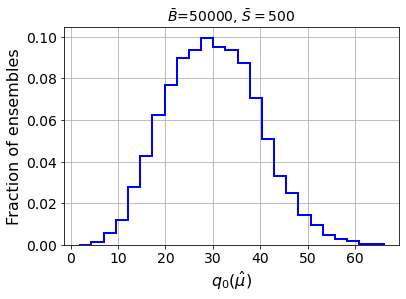

muhat mean:  0.07400385278312888
Z_gaussian:  5.4582665525905645
Z_gaussian_mu0:  5.459073198567305

 ------------------------------------ 

 MLL + KDE (1ML) 
KDE Kernel:  epanechnikov
Background bandwidth:  0.00630957344480193
Signal bandwidth:  0.00630957344480193


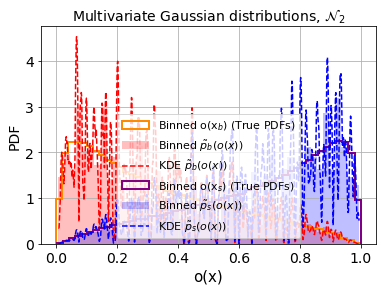

 MLL + KDE (10ML) 
KDE Kernel:  epanechnikov
Background bandwidth:  0.00630957344480193
Signal bandwidth:  0.00630957344480193


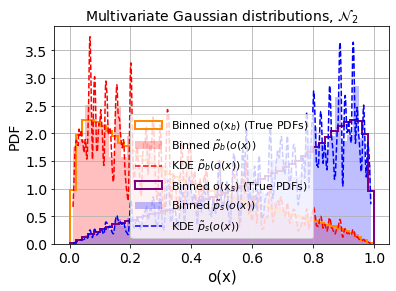

 Z MLL+KDE (1ML) 


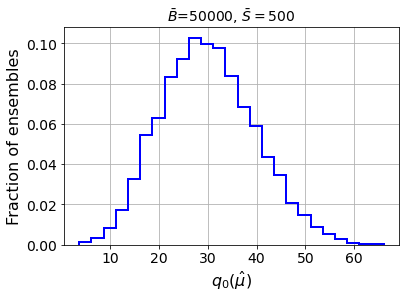

muhat mean_1ML:  0.07510899320693501
Z_KDE_1ML:  5.44466790903825
Z_KDE mu=0_1ML:  5.446370148409234

 Z MLL+KDE (10ML) 


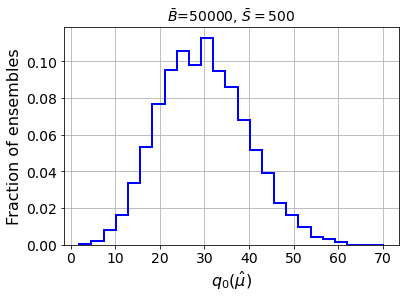

muhat mean:  0.07622427253371186
Z_KDE:  5.425695503260566
Z_KDE mu=0:  5.42653533078617

 ------------------------------------ 



In [64]:
dim=1

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T

dim1 = np.concatenate((background_X_1,signal_X_1))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML, events_to_fit=20000, bandwidth_space=np.logspace(-2.2, -1.5, 5))


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP, events_to_fit=20000, bandwidth_space=np.logspace(-2.2, -1.5, 5))


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [65]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

0.8385644701287596
4.900672776243757
5.272275479417459
5.36291939047819
5.399444175695006
4.075613975314512
4.519879355343759
4.772969120704275
4.980368905989027
4.910327658411742
5.256663083612902
5.356094989654455
5.371062599759511
4.081911105932502
4.527655372082387
4.781151072014415
4.9651143104725595
0.07400385278312888
5.4582665525905645
5.459073198567305
0.07622427253371186
5.425695503260566
5.42653533078617
0.07510899320693501
5.44466790903825
5.446370148409234


In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 2)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 2)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 2)
y_gauss_test :  (1000000, 1)



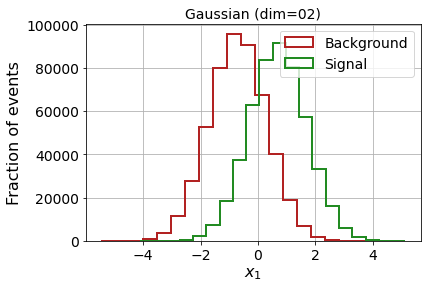

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.64279	validation_1-logloss:0.64282
[1]	validation_0-logloss:0.60132	validation_1-logloss:0.60137
[2]	validation_0-logloss:0.56698	validation_1-logloss:0.56708
[3]	validation_0-logloss:0.53809	validation_1-logloss:0.53822
[4]	validation_0-logloss:0.51372	validation_1-logloss:0.51387
[5]	validation_0-logloss:0.49288	validation_1-logloss:0.49306
[6]	validation_0-logloss:0.47513	validation_1-logloss:0.47535
[7]	validation_0-logloss:0.45989	validation_1-logloss:0.46017
[8]	validation_0-logloss:0.44679	validation_1-logloss:0.44710
[9]	validation_0-logloss:0.43549	validation_1-logloss:0.43582
[10]	validation_0-logloss:0.42571	validation_1-logloss:0.42608
[11]	validation_0-logloss:0.41724	validation_1-logloss:0.41763
[12]	validation_0-logloss:0.40988	validation_1-logloss:0.41028
[13]	validation_0-logloss:0.40349	validation_1-logloss:0.40391
[14]	validation_0-logloss:0.39791	validation_1-logloss:0.39836
[15]	validation_0-logloss:0.39307	validation_1-logloss:0.39354
[1

[130]	validation_0-logloss:0.35944	validation_1-logloss:0.36100


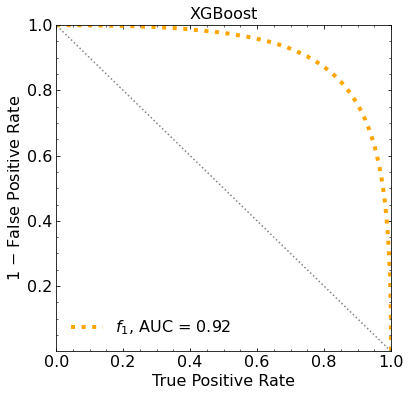

ML iteration 0


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.64286	validation_1-logloss:0.64291
[1]	validation_0-logloss:0.60160	validation_1-logloss:0.60164
[2]	validation_0-logloss:0.56729	validation_1-logloss:0.56732
[3]	validation_0-logloss:0.53850	validation_1-logloss:0.53857
[4]	validation_0-logloss:0.51414	validation_1-logloss:0.51424
[5]	validation_0-logloss:0.49341	validation_1-logloss:0.49349
[6]	validation_0-logloss:0.47569	validation_1-logloss:0.47586
[7]	validation_0-logloss:0.46048	validation_1-logloss:0.46062
[8]	validation_0-logloss:0.44739	validation_1-logloss:0.44756
[9]	validation_0-logloss:0.43607	validation_1-logloss:0.43628
[10]	validation_0-logloss:0.42627	validation_1-logloss:0.42656
[11]	validation_0-logloss:0.41776	validation_1-logloss:0.41805
[12]	validation_0-logloss:0.41039	validation_1-logloss:0.41073
[13]	validation_0-logloss:0.40398	validation_1-logloss:0.40436
[14]	validation_0-logloss:0.39838	validation_1-logloss:0.39880
[15]	validation_0-logloss:0.39352	validation_1-logloss:0.39400
[1

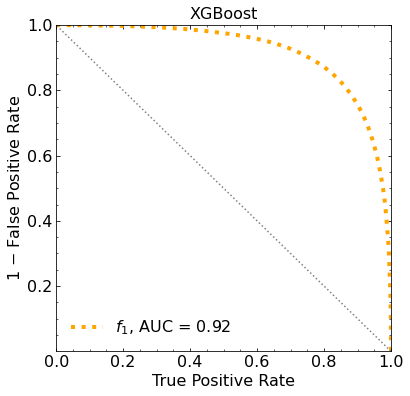

ML iteration  1


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.64233	validation_1-logloss:0.64275
[1]	validation_0-logloss:0.60059	validation_1-logloss:0.60119
[2]	validation_0-logloss:0.56591	validation_1-logloss:0.56684
[3]	validation_0-logloss:0.53682	validation_1-logloss:0.53800
[4]	validation_0-logloss:0.51222	validation_1-logloss:0.51362
[5]	validation_0-logloss:0.49122	validation_1-logloss:0.49280
[6]	validation_0-logloss:0.47331	validation_1-logloss:0.47507
[7]	validation_0-logloss:0.45794	validation_1-logloss:0.45990
[8]	validation_0-logloss:0.44464	validation_1-logloss:0.44677
[9]	validation_0-logloss:0.43321	validation_1-logloss:0.43555
[10]	validation_0-logloss:0.42335	validation_1-logloss:0.42581
[11]	validation_0-logloss:0.41477	validation_1-logloss:0.41741
[12]	validation_0-logloss:0.40732	validation_1-logloss:0.41011
[13]	validation_0-logloss:0.40083	validation_1-logloss:0.40375
[14]	validation_0-logloss:0.39522	validation_1-logloss:0.39822
[15]	validation_0-logloss:0.39029	validation_1-logloss:0.39344
[1

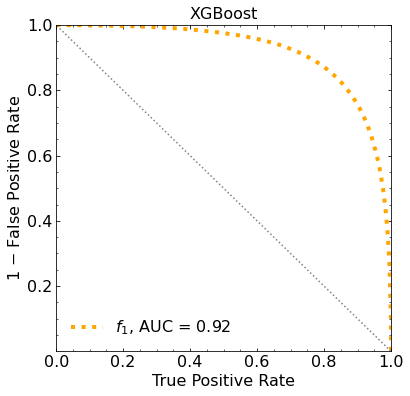

ML iteration  2
[0]	validation_0-logloss:0.64211	validation_1-logloss:0.64254


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.60036	validation_1-logloss:0.60119
[2]	validation_0-logloss:0.56545	validation_1-logloss:0.56661
[3]	validation_0-logloss:0.53620	validation_1-logloss:0.53774
[4]	validation_0-logloss:0.51145	validation_1-logloss:0.51333
[5]	validation_0-logloss:0.49047	validation_1-logloss:0.49257
[6]	validation_0-logloss:0.47249	validation_1-logloss:0.47493
[7]	validation_0-logloss:0.45705	validation_1-logloss:0.45967
[8]	validation_0-logloss:0.44379	validation_1-logloss:0.44662
[9]	validation_0-logloss:0.43235	validation_1-logloss:0.43538
[10]	validation_0-logloss:0.42242	validation_1-logloss:0.42567
[11]	validation_0-logloss:0.41383	validation_1-logloss:0.41722
[12]	validation_0-logloss:0.40638	validation_1-logloss:0.40996
[13]	validation_0-logloss:0.39988	validation_1-logloss:0.40358
[14]	validation_0-logloss:0.39422	validation_1-logloss:0.39809
[15]	validation_0-logloss:0.38932	validation_1-logloss:0.39330
[16]	validation_0-logloss:0.38502	validation_1-logloss:0.38910
[

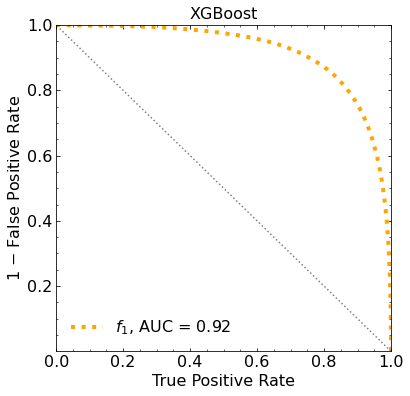

ML iteration  3


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.64230	validation_1-logloss:0.64266
[1]	validation_0-logloss:0.60062	validation_1-logloss:0.60125
[2]	validation_0-logloss:0.56578	validation_1-logloss:0.56677
[3]	validation_0-logloss:0.53672	validation_1-logloss:0.53797
[4]	validation_0-logloss:0.51199	validation_1-logloss:0.51355
[5]	validation_0-logloss:0.49101	validation_1-logloss:0.49278
[6]	validation_0-logloss:0.47307	validation_1-logloss:0.47509
[7]	validation_0-logloss:0.45766	validation_1-logloss:0.45987
[8]	validation_0-logloss:0.44440	validation_1-logloss:0.44679
[9]	validation_0-logloss:0.43295	validation_1-logloss:0.43553
[10]	validation_0-logloss:0.42304	validation_1-logloss:0.42577
[11]	validation_0-logloss:0.41447	validation_1-logloss:0.41733
[12]	validation_0-logloss:0.40699	validation_1-logloss:0.41002
[13]	validation_0-logloss:0.40053	validation_1-logloss:0.40370
[14]	validation_0-logloss:0.39490	validation_1-logloss:0.39820
[15]	validation_0-logloss:0.38997	validation_1-logloss:0.39343
[1

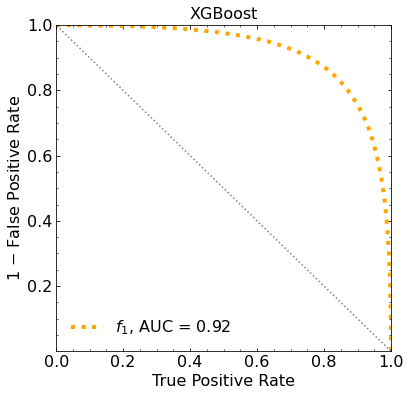

ML iteration  4


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.64232	validation_1-logloss:0.64271
[1]	validation_0-logloss:0.60072	validation_1-logloss:0.60122
[2]	validation_0-logloss:0.56601	validation_1-logloss:0.56678
[3]	validation_0-logloss:0.53696	validation_1-logloss:0.53791
[4]	validation_0-logloss:0.51236	validation_1-logloss:0.51355
[5]	validation_0-logloss:0.49146	validation_1-logloss:0.49282
[6]	validation_0-logloss:0.47360	validation_1-logloss:0.47515
[7]	validation_0-logloss:0.45826	validation_1-logloss:0.45996
[8]	validation_0-logloss:0.44504	validation_1-logloss:0.44693
[9]	validation_0-logloss:0.43361	validation_1-logloss:0.43562
[10]	validation_0-logloss:0.42372	validation_1-logloss:0.42592
[11]	validation_0-logloss:0.41516	validation_1-logloss:0.41748
[12]	validation_0-logloss:0.40773	validation_1-logloss:0.41017
[13]	validation_0-logloss:0.40126	validation_1-logloss:0.40381
[14]	validation_0-logloss:0.39565	validation_1-logloss:0.39830
[15]	validation_0-logloss:0.39077	validation_1-logloss:0.39349
[1

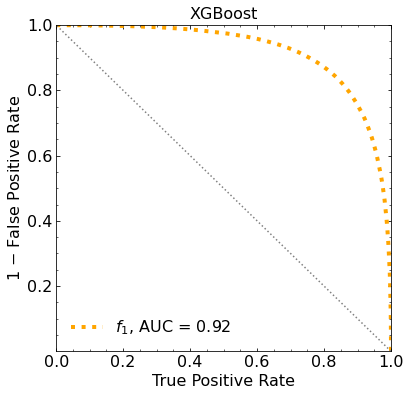

ML iteration  5


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.64242	validation_1-logloss:0.64258
[1]	validation_0-logloss:0.60087	validation_1-logloss:0.60145
[2]	validation_0-logloss:0.56629	validation_1-logloss:0.56712
[3]	validation_0-logloss:0.53732	validation_1-logloss:0.53825
[4]	validation_0-logloss:0.51278	validation_1-logloss:0.51389
[5]	validation_0-logloss:0.49190	validation_1-logloss:0.49317
[6]	validation_0-logloss:0.47399	validation_1-logloss:0.47548
[7]	validation_0-logloss:0.45864	validation_1-logloss:0.46029
[8]	validation_0-logloss:0.44539	validation_1-logloss:0.44716
[9]	validation_0-logloss:0.43398	validation_1-logloss:0.43583
[10]	validation_0-logloss:0.42411	validation_1-logloss:0.42608
[11]	validation_0-logloss:0.41552	validation_1-logloss:0.41761
[12]	validation_0-logloss:0.40807	validation_1-logloss:0.41028
[13]	validation_0-logloss:0.40159	validation_1-logloss:0.40390
[14]	validation_0-logloss:0.39596	validation_1-logloss:0.39841
[15]	validation_0-logloss:0.39102	validation_1-logloss:0.39357
[1

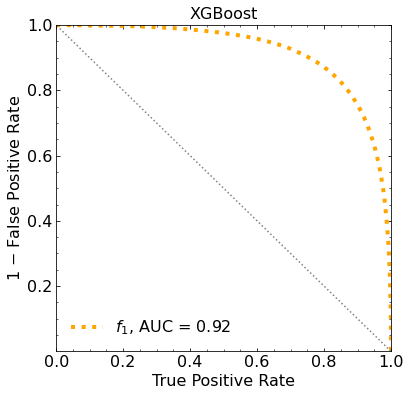

ML iteration  6


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.64225	validation_1-logloss:0.64259
[1]	validation_0-logloss:0.60056	validation_1-logloss:0.60113
[2]	validation_0-logloss:0.56595	validation_1-logloss:0.56676
[3]	validation_0-logloss:0.53687	validation_1-logloss:0.53796
[4]	validation_0-logloss:0.51229	validation_1-logloss:0.51353
[5]	validation_0-logloss:0.49131	validation_1-logloss:0.49273
[6]	validation_0-logloss:0.47344	validation_1-logloss:0.47503
[7]	validation_0-logloss:0.45807	validation_1-logloss:0.45985
[8]	validation_0-logloss:0.44478	validation_1-logloss:0.44670
[9]	validation_0-logloss:0.43332	validation_1-logloss:0.43542
[10]	validation_0-logloss:0.42340	validation_1-logloss:0.42564
[11]	validation_0-logloss:0.41479	validation_1-logloss:0.41719
[12]	validation_0-logloss:0.40735	validation_1-logloss:0.40986
[13]	validation_0-logloss:0.40086	validation_1-logloss:0.40354
[14]	validation_0-logloss:0.39521	validation_1-logloss:0.39802
[15]	validation_0-logloss:0.39027	validation_1-logloss:0.39321
[1

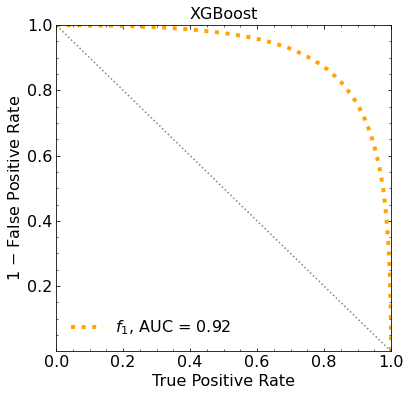

ML iteration  7


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.64251	validation_1-logloss:0.64271
[1]	validation_0-logloss:0.60095	validation_1-logloss:0.60137
[2]	validation_0-logloss:0.56643	validation_1-logloss:0.56697
[3]	validation_0-logloss:0.53735	validation_1-logloss:0.53800
[4]	validation_0-logloss:0.51278	validation_1-logloss:0.51364
[5]	validation_0-logloss:0.49194	validation_1-logloss:0.49291
[6]	validation_0-logloss:0.47406	validation_1-logloss:0.47517
[7]	validation_0-logloss:0.45877	validation_1-logloss:0.46002
[8]	validation_0-logloss:0.44555	validation_1-logloss:0.44689
[9]	validation_0-logloss:0.43418	validation_1-logloss:0.43567
[10]	validation_0-logloss:0.42432	validation_1-logloss:0.42596
[11]	validation_0-logloss:0.41578	validation_1-logloss:0.41753
[12]	validation_0-logloss:0.40835	validation_1-logloss:0.41023
[13]	validation_0-logloss:0.40189	validation_1-logloss:0.40384
[14]	validation_0-logloss:0.39627	validation_1-logloss:0.39835
[15]	validation_0-logloss:0.39137	validation_1-logloss:0.39354
[1

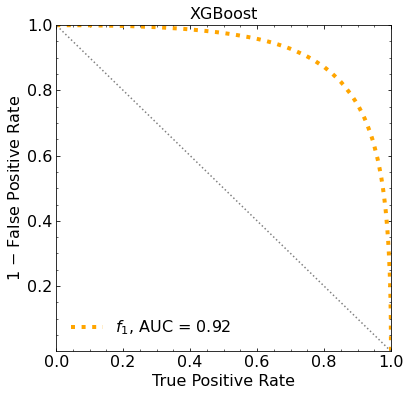

ML iteration  8


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.64255	validation_1-logloss:0.64275
[1]	validation_0-logloss:0.60103	validation_1-logloss:0.60145
[2]	validation_0-logloss:0.56658	validation_1-logloss:0.56709
[3]	validation_0-logloss:0.53761	validation_1-logloss:0.53825
[4]	validation_0-logloss:0.51314	validation_1-logloss:0.51398
[5]	validation_0-logloss:0.49230	validation_1-logloss:0.49326
[6]	validation_0-logloss:0.47453	validation_1-logloss:0.47562
[7]	validation_0-logloss:0.45927	validation_1-logloss:0.46046
[8]	validation_0-logloss:0.44612	validation_1-logloss:0.44744
[9]	validation_0-logloss:0.43475	validation_1-logloss:0.43616
[10]	validation_0-logloss:0.42490	validation_1-logloss:0.42641
[11]	validation_0-logloss:0.41640	validation_1-logloss:0.41795
[12]	validation_0-logloss:0.40897	validation_1-logloss:0.41061
[13]	validation_0-logloss:0.40255	validation_1-logloss:0.40423
[14]	validation_0-logloss:0.39694	validation_1-logloss:0.39870
[15]	validation_0-logloss:0.39206	validation_1-logloss:0.39388
[1

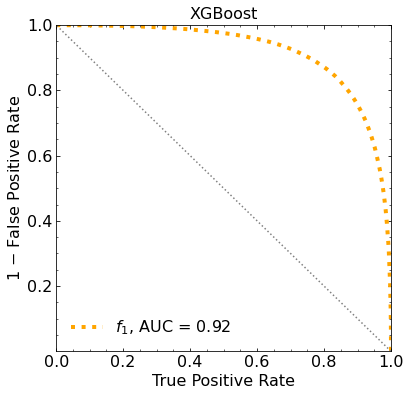

ML iteration  9


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.64235	validation_1-logloss:0.64260
[1]	validation_0-logloss:0.60067	validation_1-logloss:0.60111
[2]	validation_0-logloss:0.56609	validation_1-logloss:0.56672
[3]	validation_0-logloss:0.53704	validation_1-logloss:0.53787
[4]	validation_0-logloss:0.51237	validation_1-logloss:0.51338
[5]	validation_0-logloss:0.49144	validation_1-logloss:0.49268
[6]	validation_0-logloss:0.47359	validation_1-logloss:0.47497
[7]	validation_0-logloss:0.45815	validation_1-logloss:0.45972
[8]	validation_0-logloss:0.44494	validation_1-logloss:0.44665
[9]	validation_0-logloss:0.43351	validation_1-logloss:0.43540
[10]	validation_0-logloss:0.42359	validation_1-logloss:0.42562
[11]	validation_0-logloss:0.41500	validation_1-logloss:0.41718
[12]	validation_0-logloss:0.40754	validation_1-logloss:0.40988
[13]	validation_0-logloss:0.40108	validation_1-logloss:0.40357
[14]	validation_0-logloss:0.39543	validation_1-logloss:0.39803
[15]	validation_0-logloss:0.39051	validation_1-logloss:0.39324
[1

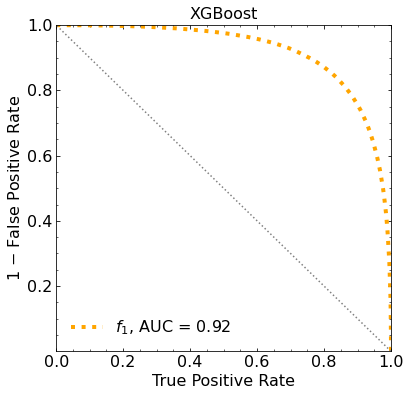

Classification score (1 ML):


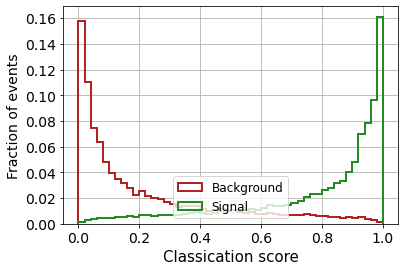

Classification score (10 ML):


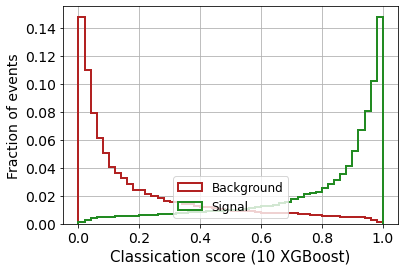

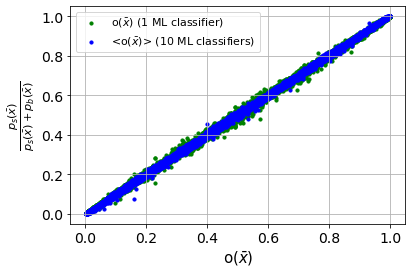


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  7.463837935718369
Z_XG 25 bins_1ML:  8.758063001744683
Z_XG 50 bins_1ML:  9.311196417589551
Z_XG 100 bins_1ML:  9.677449284110368

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  5.275374332776303
Z_XG 25 bins_eq_1ML:  6.525699824053538
Z_XG 50 bins_eq_1ML:  7.329476447470916
Z_XG 100 bins_eq_1ML:  8.034373704382

 BL lineal bins, 10 ML
Z_XG 10 bins:  7.488881904635886
Z_XG 25 bins:  8.823653289814246
Z_XG 50 bins:  9.381477749833786
Z_XG 100 bins:  9.719617666120572

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  5.293592136619532
Z_XG 25 bins_eq:  6.55151409235361
Z_XG 50 bins_eq:  7.360471888891425
Z_XG 100 bins_eq:  8.070916452622555

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD (GAUSSIANS):


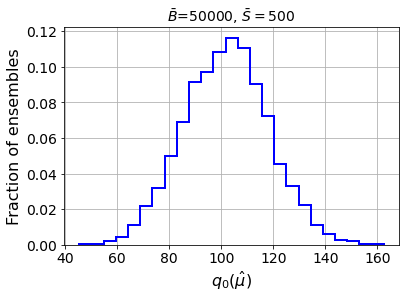

muhat mean:  0.01759099665416202
Z_gaussian:  10.107594975135884
Z_gaussian_mu0:  10.108401960368493

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf  2365.7409984   2334.96261805
  2307.97357756  2280.47899332  2250.9270436   2208.65813113
  2150.50865953  2074.2535815   1966.9523391   1822.47957377
  1632.93669154  1379.70243584  1051.72459258   647.95290758
   150.94247552  -440.0902818  -1126.40226216 -2044.51770793]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
  2339.79907239  2309.92884208  2270.35575315  2224.53455851
  2164.44117641  2079.8555044   1965.64634321  1827.01413057
  16

KDE Kernel:  epanechnikov
Background bandwidth:  0.002094366253972675
Signal bandwidth:  0.004386370005779536


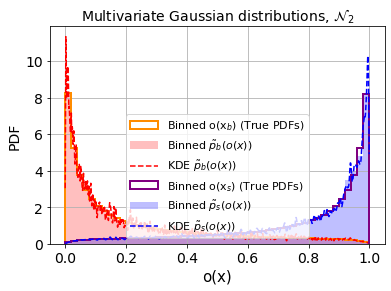

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf  2282.1452114   2292.09363455  2292.55904105
  2285.79222099  2271.6029396   2246.62742355  2204.16362101
  2146.60303826  2072.72719529  1968.07030326  1825.84066173
  1636.54581688  1387.25000979  1063.11800295   658.14855747
   160.94486168  -429.79748705 -1117.29773984 -2040.14951445]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf  2307.0643906   2310.2410797
  2303.22337467  2286.37652851  2261.48960228  2222.03591209
  2163.03439946  2080.26986955  1968.69482556  1829.67752409
  164

KDE Kernel:  epanechnikov
Background bandwidth:  0.003030951223220623
Signal bandwidth:  0.003030951223220623


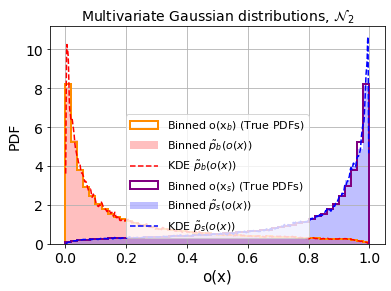

 Z MLL+KDE (1ML) 


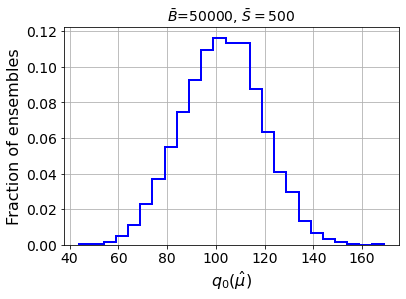

muhat mean_1ML:  0.02016627800871946
Z_KDE_1ML:  10.137655164451614
Z_KDE mu=0_1ML:  10.138120299889199

 Z MLL+KDE (10ML) 


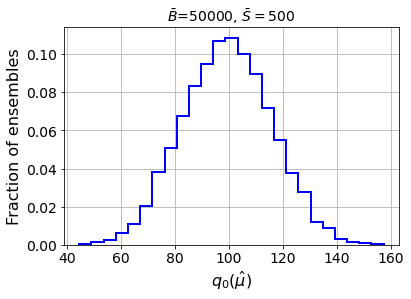

muhat mean:  0.026325661563418836
Z_KDE:  9.966670047130755
Z_KDE mu=0:  9.969207700180736

 ------------------------------------ 



In [15]:
dim=2

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML)


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP)


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [ ]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 3)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 3)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 3)
y_gauss_test :  (1000000, 1)



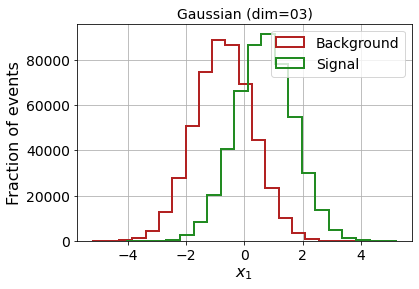

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.63428	validation_1-logloss:0.63434
[1]	validation_0-logloss:0.58538	validation_1-logloss:0.58546
[2]	validation_0-logloss:0.54466	validation_1-logloss:0.54474
[3]	validation_0-logloss:0.51028	validation_1-logloss:0.51037
[4]	validation_0-logloss:0.48061	validation_1-logloss:0.48069
[5]	validation_0-logloss:0.45538	validation_1-logloss:0.45553
[6]	validation_0-logloss:0.43335	validation_1-logloss:0.43351
[7]	validation_0-logloss:0.41435	validation_1-logloss:0.41452
[8]	validation_0-logloss:0.39766	validation_1-logloss:0.39784
[9]	validation_0-logloss:0.38302	validation_1-logloss:0.38323
[10]	validation_0-logloss:0.37015	validation_1-logloss:0.37039
[11]	validation_0-logloss:0.35886	validation_1-logloss:0.35911
[12]	validation_0-logloss:0.34891	validation_1-logloss:0.34918
[13]	validation_0-logloss:0.34014	validation_1-logloss:0.34044
[14]	validation_0-logloss:0.33235	validation_1-logloss:0.33266
[15]	validation_0-logloss:0.32541	validation_1-logloss:0.32572
[1

[130]	validation_0-logloss:0.26508	validation_1-logloss:0.26655
[131]	validation_0-logloss:0.26507	validation_1-logloss:0.26655
[132]	validation_0-logloss:0.26507	validation_1-logloss:0.26655
[133]	validation_0-logloss:0.26506	validation_1-logloss:0.26655
[134]	validation_0-logloss:0.26505	validation_1-logloss:0.26655
[135]	validation_0-logloss:0.26505	validation_1-logloss:0.26655
[136]	validation_0-logloss:0.26505	validation_1-logloss:0.26655
[137]	validation_0-logloss:0.26505	validation_1-logloss:0.26655
[138]	validation_0-logloss:0.26504	validation_1-logloss:0.26655
[139]	validation_0-logloss:0.26504	validation_1-logloss:0.26655
[140]	validation_0-logloss:0.26503	validation_1-logloss:0.26655
[141]	validation_0-logloss:0.26502	validation_1-logloss:0.26655
[142]	validation_0-logloss:0.26501	validation_1-logloss:0.26655
[143]	validation_0-logloss:0.26501	validation_1-logloss:0.26655
[144]	validation_0-logloss:0.26500	validation_1-logloss:0.26655
[145]	validation_0-logloss:0.26500	valid

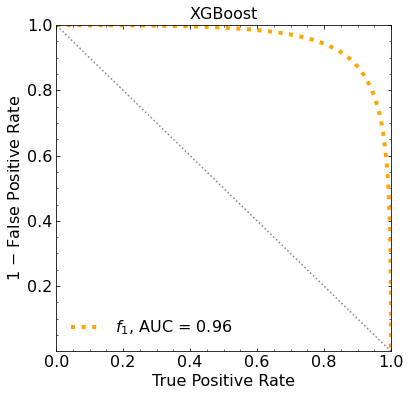

ML iteration 0


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.63374	validation_1-logloss:0.63424
[1]	validation_0-logloss:0.58484	validation_1-logloss:0.58577
[2]	validation_0-logloss:0.54386	validation_1-logloss:0.54519
[3]	validation_0-logloss:0.50907	validation_1-logloss:0.51061
[4]	validation_0-logloss:0.47930	validation_1-logloss:0.48104
[5]	validation_0-logloss:0.45364	validation_1-logloss:0.45580
[6]	validation_0-logloss:0.43140	validation_1-logloss:0.43368
[7]	validation_0-logloss:0.41197	validation_1-logloss:0.41457
[8]	validation_0-logloss:0.39501	validation_1-logloss:0.39783
[9]	validation_0-logloss:0.38023	validation_1-logloss:0.38331
[10]	validation_0-logloss:0.36725	validation_1-logloss:0.37049
[11]	validation_0-logloss:0.35580	validation_1-logloss:0.35920
[12]	validation_0-logloss:0.34575	validation_1-logloss:0.34930
[13]	validation_0-logloss:0.33678	validation_1-logloss:0.34053
[14]	validation_0-logloss:0.32883	validation_1-logloss:0.33276
[15]	validation_0-logloss:0.32176	validation_1-logloss:0.32585
[1

[130]	validation_0-logloss:0.25601	validation_1-logloss:0.26821
[131]	validation_0-logloss:0.25599	validation_1-logloss:0.26821
[132]	validation_0-logloss:0.25593	validation_1-logloss:0.26822
[133]	validation_0-logloss:0.25589	validation_1-logloss:0.26822
[134]	validation_0-logloss:0.25587	validation_1-logloss:0.26822
[135]	validation_0-logloss:0.25580	validation_1-logloss:0.26823
[136]	validation_0-logloss:0.25572	validation_1-logloss:0.26824
[137]	validation_0-logloss:0.25565	validation_1-logloss:0.26826
[138]	validation_0-logloss:0.25560	validation_1-logloss:0.26826
[139]	validation_0-logloss:0.25558	validation_1-logloss:0.26826


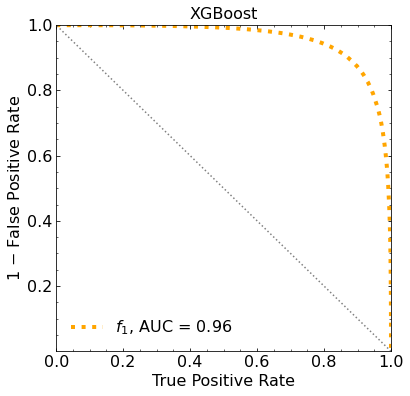

ML iteration  1


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.63372	validation_1-logloss:0.63421
[1]	validation_0-logloss:0.58483	validation_1-logloss:0.58556
[2]	validation_0-logloss:0.54379	validation_1-logloss:0.54492
[3]	validation_0-logloss:0.50898	validation_1-logloss:0.51052
[4]	validation_0-logloss:0.47892	validation_1-logloss:0.48059
[5]	validation_0-logloss:0.45335	validation_1-logloss:0.45525
[6]	validation_0-logloss:0.43109	validation_1-logloss:0.43328
[7]	validation_0-logloss:0.41186	validation_1-logloss:0.41426
[8]	validation_0-logloss:0.39490	validation_1-logloss:0.39757
[9]	validation_0-logloss:0.38010	validation_1-logloss:0.38297
[10]	validation_0-logloss:0.36713	validation_1-logloss:0.37027
[11]	validation_0-logloss:0.35565	validation_1-logloss:0.35895
[12]	validation_0-logloss:0.34560	validation_1-logloss:0.34910
[13]	validation_0-logloss:0.33665	validation_1-logloss:0.34033
[14]	validation_0-logloss:0.32875	validation_1-logloss:0.33262
[15]	validation_0-logloss:0.32170	validation_1-logloss:0.32579
[1

[130]	validation_0-logloss:0.25626	validation_1-logloss:0.26835
[131]	validation_0-logloss:0.25621	validation_1-logloss:0.26835
[132]	validation_0-logloss:0.25613	validation_1-logloss:0.26836
[133]	validation_0-logloss:0.25606	validation_1-logloss:0.26836
[134]	validation_0-logloss:0.25603	validation_1-logloss:0.26836
[135]	validation_0-logloss:0.25595	validation_1-logloss:0.26836
[136]	validation_0-logloss:0.25587	validation_1-logloss:0.26838
[137]	validation_0-logloss:0.25586	validation_1-logloss:0.26838


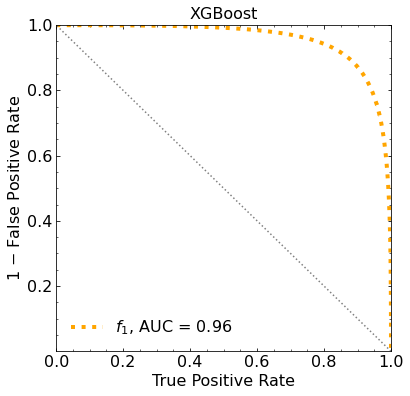

ML iteration  2


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.63347	validation_1-logloss:0.63404
[1]	validation_0-logloss:0.58423	validation_1-logloss:0.58531
[2]	validation_0-logloss:0.54265	validation_1-logloss:0.54410
[3]	validation_0-logloss:0.50763	validation_1-logloss:0.50948
[4]	validation_0-logloss:0.47777	validation_1-logloss:0.47995
[5]	validation_0-logloss:0.45189	validation_1-logloss:0.45448
[6]	validation_0-logloss:0.42965	validation_1-logloss:0.43249
[7]	validation_0-logloss:0.41020	validation_1-logloss:0.41340
[8]	validation_0-logloss:0.39329	validation_1-logloss:0.39678
[9]	validation_0-logloss:0.37847	validation_1-logloss:0.38225
[10]	validation_0-logloss:0.36538	validation_1-logloss:0.36941
[11]	validation_0-logloss:0.35387	validation_1-logloss:0.35823
[12]	validation_0-logloss:0.34376	validation_1-logloss:0.34840
[13]	validation_0-logloss:0.33481	validation_1-logloss:0.33967
[14]	validation_0-logloss:0.32686	validation_1-logloss:0.33199
[15]	validation_0-logloss:0.31970	validation_1-logloss:0.32507
[1

[130]	validation_0-logloss:0.25347	validation_1-logloss:0.26806
[131]	validation_0-logloss:0.25346	validation_1-logloss:0.26806
[132]	validation_0-logloss:0.25340	validation_1-logloss:0.26806
[133]	validation_0-logloss:0.25336	validation_1-logloss:0.26807
[134]	validation_0-logloss:0.25330	validation_1-logloss:0.26807
[135]	validation_0-logloss:0.25325	validation_1-logloss:0.26807
[136]	validation_0-logloss:0.25317	validation_1-logloss:0.26807
[137]	validation_0-logloss:0.25311	validation_1-logloss:0.26808
[138]	validation_0-logloss:0.25304	validation_1-logloss:0.26809
[139]	validation_0-logloss:0.25293	validation_1-logloss:0.26809


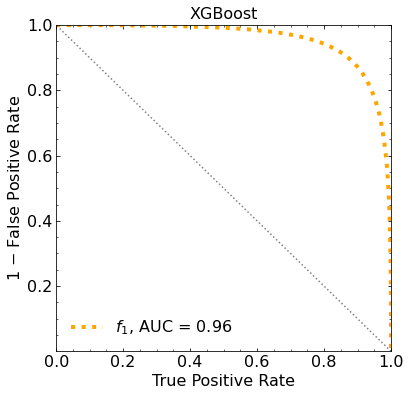

ML iteration  3


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.63397	validation_1-logloss:0.63429
[1]	validation_0-logloss:0.58513	validation_1-logloss:0.58563
[2]	validation_0-logloss:0.54370	validation_1-logloss:0.54449
[3]	validation_0-logloss:0.50917	validation_1-logloss:0.51018
[4]	validation_0-logloss:0.47924	validation_1-logloss:0.48051
[5]	validation_0-logloss:0.45373	validation_1-logloss:0.45524
[6]	validation_0-logloss:0.43154	validation_1-logloss:0.43323
[7]	validation_0-logloss:0.41219	validation_1-logloss:0.41412
[8]	validation_0-logloss:0.39540	validation_1-logloss:0.39750
[9]	validation_0-logloss:0.38068	validation_1-logloss:0.38294
[10]	validation_0-logloss:0.36778	validation_1-logloss:0.37016
[11]	validation_0-logloss:0.35633	validation_1-logloss:0.35893
[12]	validation_0-logloss:0.34623	validation_1-logloss:0.34905
[13]	validation_0-logloss:0.33736	validation_1-logloss:0.34028
[14]	validation_0-logloss:0.32948	validation_1-logloss:0.33257
[15]	validation_0-logloss:0.32251	validation_1-logloss:0.32569
[1

[130]	validation_0-logloss:0.25666	validation_1-logloss:0.26823
[131]	validation_0-logloss:0.25660	validation_1-logloss:0.26824
[132]	validation_0-logloss:0.25652	validation_1-logloss:0.26824
[133]	validation_0-logloss:0.25650	validation_1-logloss:0.26825
[134]	validation_0-logloss:0.25648	validation_1-logloss:0.26826
[135]	validation_0-logloss:0.25642	validation_1-logloss:0.26826
[136]	validation_0-logloss:0.25641	validation_1-logloss:0.26826
[137]	validation_0-logloss:0.25632	validation_1-logloss:0.26827
[138]	validation_0-logloss:0.25622	validation_1-logloss:0.26827
[139]	validation_0-logloss:0.25620	validation_1-logloss:0.26827
[140]	validation_0-logloss:0.25619	validation_1-logloss:0.26828
[141]	validation_0-logloss:0.25617	validation_1-logloss:0.26828


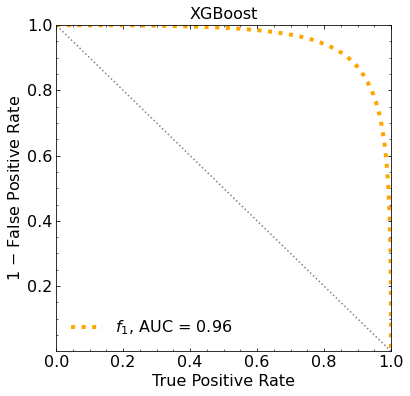

ML iteration  4


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.63421	validation_1-logloss:0.63426
[1]	validation_0-logloss:0.58556	validation_1-logloss:0.58588
[2]	validation_0-logloss:0.54458	validation_1-logloss:0.54493
[3]	validation_0-logloss:0.51011	validation_1-logloss:0.51051
[4]	validation_0-logloss:0.48050	validation_1-logloss:0.48093
[5]	validation_0-logloss:0.45515	validation_1-logloss:0.45577
[6]	validation_0-logloss:0.43314	validation_1-logloss:0.43384
[7]	validation_0-logloss:0.41388	validation_1-logloss:0.41465
[8]	validation_0-logloss:0.39718	validation_1-logloss:0.39807
[9]	validation_0-logloss:0.38261	validation_1-logloss:0.38348
[10]	validation_0-logloss:0.36983	validation_1-logloss:0.37079
[11]	validation_0-logloss:0.35848	validation_1-logloss:0.35956
[12]	validation_0-logloss:0.34848	validation_1-logloss:0.34962
[13]	validation_0-logloss:0.33960	validation_1-logloss:0.34081
[14]	validation_0-logloss:0.33179	validation_1-logloss:0.33304
[15]	validation_0-logloss:0.32484	validation_1-logloss:0.32617
[1

[130]	validation_0-logloss:0.25979	validation_1-logloss:0.26816
[131]	validation_0-logloss:0.25967	validation_1-logloss:0.26817
[132]	validation_0-logloss:0.25961	validation_1-logloss:0.26817
[133]	validation_0-logloss:0.25955	validation_1-logloss:0.26818
[134]	validation_0-logloss:0.25944	validation_1-logloss:0.26821
[135]	validation_0-logloss:0.25938	validation_1-logloss:0.26821
[136]	validation_0-logloss:0.25933	validation_1-logloss:0.26822


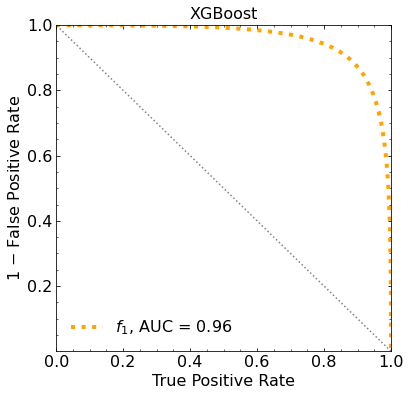

ML iteration  5


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.63377	validation_1-logloss:0.63414
[1]	validation_0-logloss:0.58492	validation_1-logloss:0.58571
[2]	validation_0-logloss:0.54400	validation_1-logloss:0.54510
[3]	validation_0-logloss:0.50928	validation_1-logloss:0.51054
[4]	validation_0-logloss:0.47960	validation_1-logloss:0.48124
[5]	validation_0-logloss:0.45393	validation_1-logloss:0.45580
[6]	validation_0-logloss:0.43181	validation_1-logloss:0.43389
[7]	validation_0-logloss:0.41257	validation_1-logloss:0.41485
[8]	validation_0-logloss:0.39557	validation_1-logloss:0.39795
[9]	validation_0-logloss:0.38086	validation_1-logloss:0.38349
[10]	validation_0-logloss:0.36783	validation_1-logloss:0.37057
[11]	validation_0-logloss:0.35632	validation_1-logloss:0.35923
[12]	validation_0-logloss:0.34626	validation_1-logloss:0.34933
[13]	validation_0-logloss:0.33732	validation_1-logloss:0.34052
[14]	validation_0-logloss:0.32940	validation_1-logloss:0.33275
[15]	validation_0-logloss:0.32236	validation_1-logloss:0.32581
[1

[130]	validation_0-logloss:0.25641	validation_1-logloss:0.26803
[131]	validation_0-logloss:0.25639	validation_1-logloss:0.26804
[132]	validation_0-logloss:0.25628	validation_1-logloss:0.26804
[133]	validation_0-logloss:0.25623	validation_1-logloss:0.26805
[134]	validation_0-logloss:0.25614	validation_1-logloss:0.26807
[135]	validation_0-logloss:0.25608	validation_1-logloss:0.26808
[136]	validation_0-logloss:0.25598	validation_1-logloss:0.26809
[137]	validation_0-logloss:0.25594	validation_1-logloss:0.26809
[138]	validation_0-logloss:0.25587	validation_1-logloss:0.26810
[139]	validation_0-logloss:0.25585	validation_1-logloss:0.26810
[140]	validation_0-logloss:0.25582	validation_1-logloss:0.26811
[141]	validation_0-logloss:0.25582	validation_1-logloss:0.26811
[142]	validation_0-logloss:0.25578	validation_1-logloss:0.26811
[143]	validation_0-logloss:0.25573	validation_1-logloss:0.26812


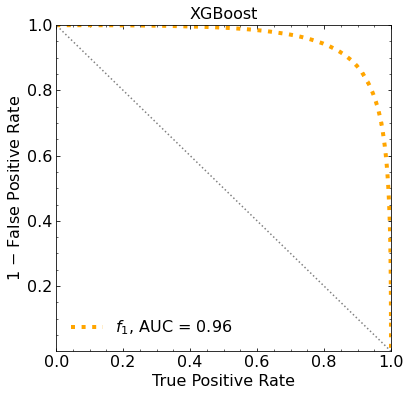

ML iteration  6
[0]	validation_0-logloss:0.63386	validation_1-logloss:0.63417
[1]	validation_0-logloss:0.58518	validation_1-logloss:0.58569


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2]	validation_0-logloss:0.54381	validation_1-logloss:0.54452
[3]	validation_0-logloss:0.50899	validation_1-logloss:0.51007
[4]	validation_0-logloss:0.47951	validation_1-logloss:0.48070
[5]	validation_0-logloss:0.45377	validation_1-logloss:0.45520
[6]	validation_0-logloss:0.43146	validation_1-logloss:0.43320
[7]	validation_0-logloss:0.41217	validation_1-logloss:0.41407
[8]	validation_0-logloss:0.39532	validation_1-logloss:0.39736
[9]	validation_0-logloss:0.38052	validation_1-logloss:0.38282
[10]	validation_0-logloss:0.36752	validation_1-logloss:0.36998
[11]	validation_0-logloss:0.35609	validation_1-logloss:0.35870
[12]	validation_0-logloss:0.34599	validation_1-logloss:0.34880
[13]	validation_0-logloss:0.33703	validation_1-logloss:0.33996
[14]	validation_0-logloss:0.32911	validation_1-logloss:0.33219
[15]	validation_0-logloss:0.32203	validation_1-logloss:0.32534
[16]	validation_0-logloss:0.31574	validation_1-logloss:0.31923
[17]	validation_0-logloss:0.31008	validation_1-logloss:0.31375


[132]	validation_0-logloss:0.25578	validation_1-logloss:0.26806
[133]	validation_0-logloss:0.25566	validation_1-logloss:0.26807
[134]	validation_0-logloss:0.25560	validation_1-logloss:0.26807
[135]	validation_0-logloss:0.25553	validation_1-logloss:0.26808
[136]	validation_0-logloss:0.25545	validation_1-logloss:0.26809
[137]	validation_0-logloss:0.25544	validation_1-logloss:0.26810
[138]	validation_0-logloss:0.25539	validation_1-logloss:0.26810
[139]	validation_0-logloss:0.25537	validation_1-logloss:0.26811
[140]	validation_0-logloss:0.25532	validation_1-logloss:0.26811
[141]	validation_0-logloss:0.25527	validation_1-logloss:0.26812
[142]	validation_0-logloss:0.25525	validation_1-logloss:0.26812
[143]	validation_0-logloss:0.25519	validation_1-logloss:0.26812
[144]	validation_0-logloss:0.25515	validation_1-logloss:0.26813
[145]	validation_0-logloss:0.25511	validation_1-logloss:0.26813
[146]	validation_0-logloss:0.25502	validation_1-logloss:0.26814
[147]	validation_0-logloss:0.25493	valid

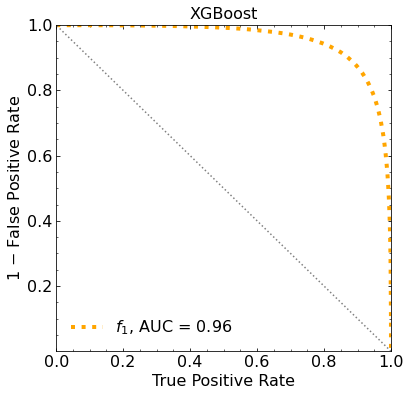

ML iteration  7


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.63402	validation_1-logloss:0.63427
[1]	validation_0-logloss:0.58527	validation_1-logloss:0.58593
[2]	validation_0-logloss:0.54432	validation_1-logloss:0.54519
[3]	validation_0-logloss:0.50971	validation_1-logloss:0.51070
[4]	validation_0-logloss:0.48005	validation_1-logloss:0.48133
[5]	validation_0-logloss:0.45438	validation_1-logloss:0.45588
[6]	validation_0-logloss:0.43239	validation_1-logloss:0.43403
[7]	validation_0-logloss:0.41288	validation_1-logloss:0.41477
[8]	validation_0-logloss:0.39598	validation_1-logloss:0.39803
[9]	validation_0-logloss:0.38110	validation_1-logloss:0.38329
[10]	validation_0-logloss:0.36806	validation_1-logloss:0.37044
[11]	validation_0-logloss:0.35665	validation_1-logloss:0.35919
[12]	validation_0-logloss:0.34655	validation_1-logloss:0.34926
[13]	validation_0-logloss:0.33759	validation_1-logloss:0.34042
[14]	validation_0-logloss:0.32966	validation_1-logloss:0.33267
[15]	validation_0-logloss:0.32267	validation_1-logloss:0.32587
[1

[130]	validation_0-logloss:0.25616	validation_1-logloss:0.26828
[131]	validation_0-logloss:0.25603	validation_1-logloss:0.26829
[132]	validation_0-logloss:0.25598	validation_1-logloss:0.26830
[133]	validation_0-logloss:0.25587	validation_1-logloss:0.26830
[134]	validation_0-logloss:0.25583	validation_1-logloss:0.26830
[135]	validation_0-logloss:0.25581	validation_1-logloss:0.26831
[136]	validation_0-logloss:0.25578	validation_1-logloss:0.26832
[137]	validation_0-logloss:0.25573	validation_1-logloss:0.26833
[138]	validation_0-logloss:0.25566	validation_1-logloss:0.26833
[139]	validation_0-logloss:0.25555	validation_1-logloss:0.26833
[140]	validation_0-logloss:0.25554	validation_1-logloss:0.26834
[141]	validation_0-logloss:0.25546	validation_1-logloss:0.26834
[142]	validation_0-logloss:0.25539	validation_1-logloss:0.26835
[143]	validation_0-logloss:0.25538	validation_1-logloss:0.26836
[144]	validation_0-logloss:0.25536	validation_1-logloss:0.26836
[145]	validation_0-logloss:0.25531	valid

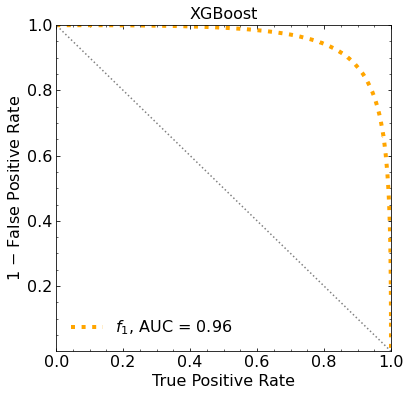

ML iteration  8


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.63374	validation_1-logloss:0.63415
[1]	validation_0-logloss:0.58448	validation_1-logloss:0.58531
[2]	validation_0-logloss:0.54348	validation_1-logloss:0.54445
[3]	validation_0-logloss:0.50842	validation_1-logloss:0.50975
[4]	validation_0-logloss:0.47861	validation_1-logloss:0.48012
[5]	validation_0-logloss:0.45281	validation_1-logloss:0.45454
[6]	validation_0-logloss:0.43051	validation_1-logloss:0.43256
[7]	validation_0-logloss:0.41116	validation_1-logloss:0.41351
[8]	validation_0-logloss:0.39427	validation_1-logloss:0.39691
[9]	validation_0-logloss:0.37934	validation_1-logloss:0.38223
[10]	validation_0-logloss:0.36641	validation_1-logloss:0.36943
[11]	validation_0-logloss:0.35495	validation_1-logloss:0.35816
[12]	validation_0-logloss:0.34482	validation_1-logloss:0.34824
[13]	validation_0-logloss:0.33592	validation_1-logloss:0.33953
[14]	validation_0-logloss:0.32801	validation_1-logloss:0.33182
[15]	validation_0-logloss:0.32094	validation_1-logloss:0.32495
[1

[130]	validation_0-logloss:0.25489	validation_1-logloss:0.26816
[131]	validation_0-logloss:0.25482	validation_1-logloss:0.26817
[132]	validation_0-logloss:0.25479	validation_1-logloss:0.26818


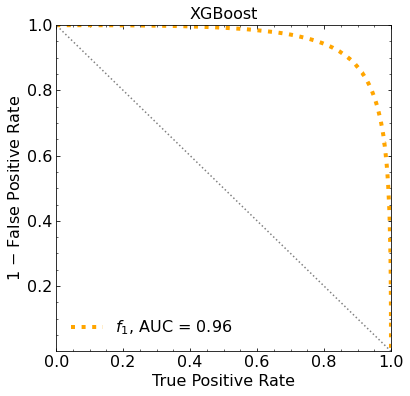

ML iteration  9
[0]	validation_0-logloss:0.63389	validation_1-logloss:0.63420
[1]	validation_0-logloss:0.58497	validation_1-logloss:0.58577


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2]	validation_0-logloss:0.54399	validation_1-logloss:0.54500
[3]	validation_0-logloss:0.50897	validation_1-logloss:0.51033
[4]	validation_0-logloss:0.47914	validation_1-logloss:0.48084
[5]	validation_0-logloss:0.45313	validation_1-logloss:0.45502
[6]	validation_0-logloss:0.43086	validation_1-logloss:0.43309
[7]	validation_0-logloss:0.41138	validation_1-logloss:0.41386
[8]	validation_0-logloss:0.39449	validation_1-logloss:0.39720
[9]	validation_0-logloss:0.37971	validation_1-logloss:0.38261
[10]	validation_0-logloss:0.36670	validation_1-logloss:0.36981
[11]	validation_0-logloss:0.35515	validation_1-logloss:0.35848
[12]	validation_0-logloss:0.34502	validation_1-logloss:0.34859
[13]	validation_0-logloss:0.33612	validation_1-logloss:0.33991
[14]	validation_0-logloss:0.32817	validation_1-logloss:0.33217
[15]	validation_0-logloss:0.32111	validation_1-logloss:0.32531
[16]	validation_0-logloss:0.31485	validation_1-logloss:0.31929
[17]	validation_0-logloss:0.30926	validation_1-logloss:0.31387


[132]	validation_0-logloss:0.25513	validation_1-logloss:0.26831
[133]	validation_0-logloss:0.25504	validation_1-logloss:0.26832
[134]	validation_0-logloss:0.25498	validation_1-logloss:0.26832
[135]	validation_0-logloss:0.25497	validation_1-logloss:0.26833
[136]	validation_0-logloss:0.25487	validation_1-logloss:0.26833
[137]	validation_0-logloss:0.25476	validation_1-logloss:0.26834


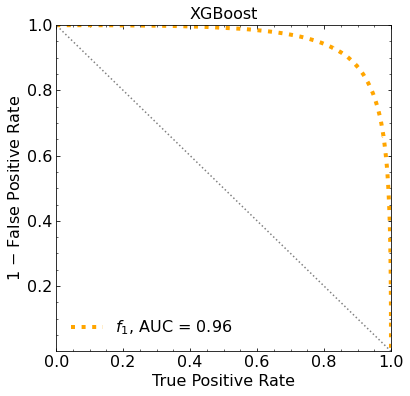

Classification score (1 ML):


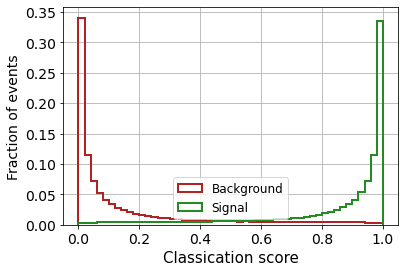

Classification score (10 ML):


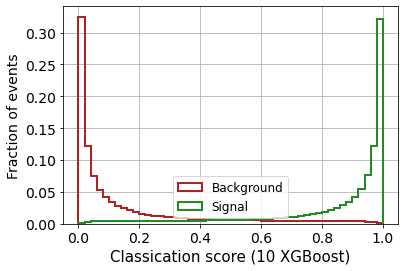

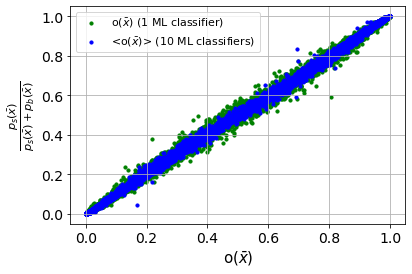


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  9.810604043109892
Z_XG 25 bins_1ML:  11.816213667448258
Z_XG 50 bins_1ML:  12.84397799894337
Z_XG 100 bins_1ML:  13.516071587094597

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  5.994011503462414
Z_XG 25 bins_eq_1ML:  7.960530798531556
Z_XG 50 bins_eq_1ML:  9.420278065268867
Z_XG 100 bins_eq_1ML:  10.745143762018948

 BL lineal bins, 10 ML
Z_XG 10 bins:  9.852201054023736
Z_XG 25 bins:  11.929213833216833
Z_XG 50 bins:  12.963733598104733
Z_XG 100 bins:  13.595688193648465

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  5.977395181104024
Z_XG 25 bins_eq:  7.936394093844356
Z_XG 50 bins_eq:  9.38913627881738
Z_XG 100 bins_eq:  10.707695665026112

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD (GA

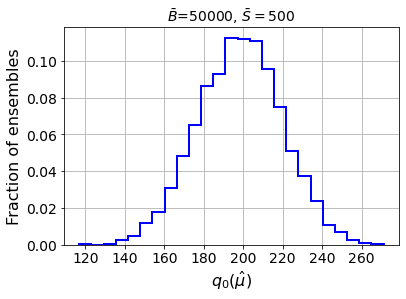

muhat mean:  0.02061745919091554
Z_gaussian:  14.09306912032441
Z_gaussian_mu0:  14.098967019936973

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf  4540.32674299  4528.45958246  4504.73289267
  4462.93990105  4396.23739845  4303.39933747  4177.0845471
  4013.24305014  3809.38814188  3550.43383671  3238.17981606
  2863.86197904  2421.87340963  1904.565305    1300.82129844
   600.63320753  -201.53060108 -1058.82938859 -2009.69462004]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf  4394.19840693
  4352.30192873  4289.09596933  4196.7413995   4074.0237679
  3918.72883296  3718.38216603  3468.21227921  3170.67942126
  2808

KDE Kernel:  epanechnikov
Background bandwidth:  0.0014471925421217023
Signal bandwidth:  0.003030951223220623


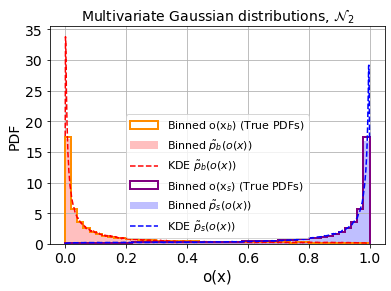

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf  4319.03280375  4303.91979261
  4274.18270764  4223.26686925  4146.2235716   4035.57132942
  3888.55643679  3697.40058143  3455.99229671  3166.41005455
  2810.39391275  2389.19613953  1891.46487016  1303.7747223
   607.91157268  -181.35570495 -1029.71357306 -1995.61972015]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


KDE Kernel:  epanechnikov
Background bandwidth:  0.0014471925421217023
Signal bandwidth:  0.002094366253972675


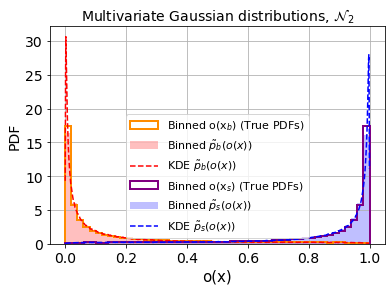

 Z MLL+KDE (1ML) 


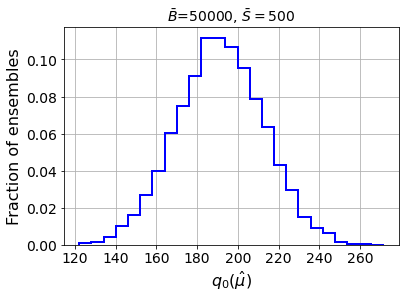

muhat mean_1ML:  0.018731623238365608
Z_KDE_1ML:  13.82832670119089
Z_KDE mu=0_1ML:  13.83260427548685

 Z MLL+KDE (10ML) 


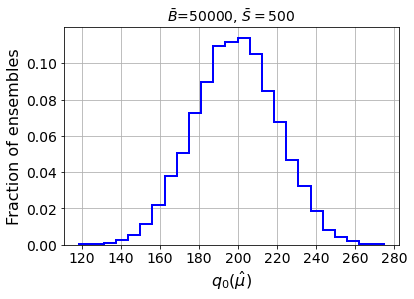

muhat mean:  0.019679610666125925
Z_KDE:  14.107056245808433
Z_KDE mu=0:  14.112690991648728

 ------------------------------------ 



In [16]:
dim=3

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML)


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP)


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [ ]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 4)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 4)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 4)
y_gauss_test :  (1000000, 1)



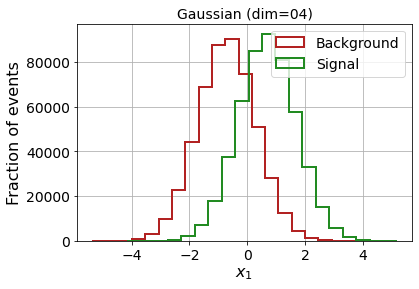

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62940	validation_1-logloss:0.62950
[1]	validation_0-logloss:0.57643	validation_1-logloss:0.57662
[2]	validation_0-logloss:0.53174	validation_1-logloss:0.53204
[3]	validation_0-logloss:0.49377	validation_1-logloss:0.49411
[4]	validation_0-logloss:0.46108	validation_1-logloss:0.46146
[5]	validation_0-logloss:0.43278	validation_1-logloss:0.43317
[6]	validation_0-logloss:0.40794	validation_1-logloss:0.40840
[7]	validation_0-logloss:0.38636	validation_1-logloss:0.38687
[8]	validation_0-logloss:0.36732	validation_1-logloss:0.36787
[9]	validation_0-logloss:0.35054	validation_1-logloss:0.35113
[10]	validation_0-logloss:0.33569	validation_1-logloss:0.33632
[11]	validation_0-logloss:0.32250	validation_1-logloss:0.32320
[12]	validation_0-logloss:0.31080	validation_1-logloss:0.31156
[13]	validation_0-logloss:0.30038	validation_1-logloss:0.30119
[14]	validation_0-logloss:0.29099	validation_1-logloss:0.29184
[15]	validation_0-logloss:0.28267	validation_1-logloss:0.28356
[1

[130]	validation_0-logloss:0.19706	validation_1-logloss:0.19932
[131]	validation_0-logloss:0.19705	validation_1-logloss:0.19932
[132]	validation_0-logloss:0.19704	validation_1-logloss:0.19931
[133]	validation_0-logloss:0.19704	validation_1-logloss:0.19931
[134]	validation_0-logloss:0.19703	validation_1-logloss:0.19931
[135]	validation_0-logloss:0.19701	validation_1-logloss:0.19930
[136]	validation_0-logloss:0.19701	validation_1-logloss:0.19930
[137]	validation_0-logloss:0.19699	validation_1-logloss:0.19930
[138]	validation_0-logloss:0.19698	validation_1-logloss:0.19930
[139]	validation_0-logloss:0.19698	validation_1-logloss:0.19930
[140]	validation_0-logloss:0.19697	validation_1-logloss:0.19930
[141]	validation_0-logloss:0.19697	validation_1-logloss:0.19930
[142]	validation_0-logloss:0.19696	validation_1-logloss:0.19930
[143]	validation_0-logloss:0.19695	validation_1-logloss:0.19930
[144]	validation_0-logloss:0.19695	validation_1-logloss:0.19930
[145]	validation_0-logloss:0.19694	valid

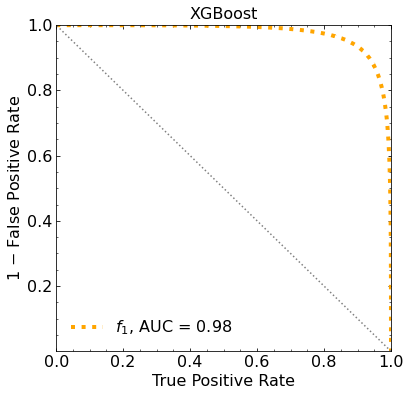

ML iteration 0
[0]	validation_0-logloss:0.62904	validation_1-logloss:0.62974


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.57542	validation_1-logloss:0.57673
[2]	validation_0-logloss:0.53023	validation_1-logloss:0.53179
[3]	validation_0-logloss:0.49187	validation_1-logloss:0.49393
[4]	validation_0-logloss:0.45871	validation_1-logloss:0.46121
[5]	validation_0-logloss:0.42982	validation_1-logloss:0.43263
[6]	validation_0-logloss:0.40485	validation_1-logloss:0.40798
[7]	validation_0-logloss:0.38298	validation_1-logloss:0.38643
[8]	validation_0-logloss:0.36372	validation_1-logloss:0.36751
[9]	validation_0-logloss:0.34679	validation_1-logloss:0.35070
[10]	validation_0-logloss:0.33163	validation_1-logloss:0.33584
[11]	validation_0-logloss:0.31826	validation_1-logloss:0.32271
[12]	validation_0-logloss:0.30644	validation_1-logloss:0.31112
[13]	validation_0-logloss:0.29590	validation_1-logloss:0.30078
[14]	validation_0-logloss:0.28650	validation_1-logloss:0.29163
[15]	validation_0-logloss:0.27793	validation_1-logloss:0.28328
[16]	validation_0-logloss:0.27038	validation_1-logloss:0.27591
[

[131]	validation_0-logloss:0.18687	validation_1-logloss:0.20140
[132]	validation_0-logloss:0.18683	validation_1-logloss:0.20140
[133]	validation_0-logloss:0.18682	validation_1-logloss:0.20140
[134]	validation_0-logloss:0.18673	validation_1-logloss:0.20140
[135]	validation_0-logloss:0.18667	validation_1-logloss:0.20140
[136]	validation_0-logloss:0.18662	validation_1-logloss:0.20140
[137]	validation_0-logloss:0.18659	validation_1-logloss:0.20141
[138]	validation_0-logloss:0.18652	validation_1-logloss:0.20141
[139]	validation_0-logloss:0.18642	validation_1-logloss:0.20142
[140]	validation_0-logloss:0.18629	validation_1-logloss:0.20143
[141]	validation_0-logloss:0.18622	validation_1-logloss:0.20144
[142]	validation_0-logloss:0.18616	validation_1-logloss:0.20145
[143]	validation_0-logloss:0.18615	validation_1-logloss:0.20145
[144]	validation_0-logloss:0.18613	validation_1-logloss:0.20145
[145]	validation_0-logloss:0.18605	validation_1-logloss:0.20146
[146]	validation_0-logloss:0.18604	valid

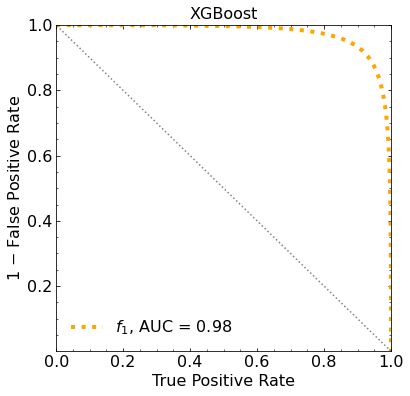

ML iteration  1


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62915	validation_1-logloss:0.62938
[1]	validation_0-logloss:0.57578	validation_1-logloss:0.57656
[2]	validation_0-logloss:0.53050	validation_1-logloss:0.53173
[3]	validation_0-logloss:0.49209	validation_1-logloss:0.49369
[4]	validation_0-logloss:0.45911	validation_1-logloss:0.46085
[5]	validation_0-logloss:0.43037	validation_1-logloss:0.43249
[6]	validation_0-logloss:0.40544	validation_1-logloss:0.40783
[7]	validation_0-logloss:0.38354	validation_1-logloss:0.38621
[8]	validation_0-logloss:0.36422	validation_1-logloss:0.36710
[9]	validation_0-logloss:0.34722	validation_1-logloss:0.35039
[10]	validation_0-logloss:0.33219	validation_1-logloss:0.33557
[11]	validation_0-logloss:0.31888	validation_1-logloss:0.32251
[12]	validation_0-logloss:0.30709	validation_1-logloss:0.31097
[13]	validation_0-logloss:0.29652	validation_1-logloss:0.30054
[14]	validation_0-logloss:0.28706	validation_1-logloss:0.29127
[15]	validation_0-logloss:0.27864	validation_1-logloss:0.28310
[1

[130]	validation_0-logloss:0.18791	validation_1-logloss:0.20120
[131]	validation_0-logloss:0.18783	validation_1-logloss:0.20121
[132]	validation_0-logloss:0.18778	validation_1-logloss:0.20120
[133]	validation_0-logloss:0.18777	validation_1-logloss:0.20121
[134]	validation_0-logloss:0.18776	validation_1-logloss:0.20121
[135]	validation_0-logloss:0.18762	validation_1-logloss:0.20122
[136]	validation_0-logloss:0.18762	validation_1-logloss:0.20123
[137]	validation_0-logloss:0.18754	validation_1-logloss:0.20124
[138]	validation_0-logloss:0.18745	validation_1-logloss:0.20125
[139]	validation_0-logloss:0.18737	validation_1-logloss:0.20125
[140]	validation_0-logloss:0.18734	validation_1-logloss:0.20126
[141]	validation_0-logloss:0.18726	validation_1-logloss:0.20126
[142]	validation_0-logloss:0.18716	validation_1-logloss:0.20128
[143]	validation_0-logloss:0.18713	validation_1-logloss:0.20128
[144]	validation_0-logloss:0.18710	validation_1-logloss:0.20128
[145]	validation_0-logloss:0.18703	valid

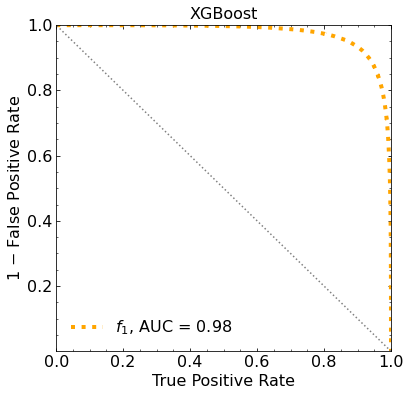

ML iteration  2


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62912	validation_1-logloss:0.62940
[1]	validation_0-logloss:0.57603	validation_1-logloss:0.57676
[2]	validation_0-logloss:0.53125	validation_1-logloss:0.53211
[3]	validation_0-logloss:0.49288	validation_1-logloss:0.49427
[4]	validation_0-logloss:0.45958	validation_1-logloss:0.46128
[5]	validation_0-logloss:0.43092	validation_1-logloss:0.43281
[6]	validation_0-logloss:0.40608	validation_1-logloss:0.40818
[7]	validation_0-logloss:0.38437	validation_1-logloss:0.38666
[8]	validation_0-logloss:0.36502	validation_1-logloss:0.36763
[9]	validation_0-logloss:0.34797	validation_1-logloss:0.35078
[10]	validation_0-logloss:0.33304	validation_1-logloss:0.33596
[11]	validation_0-logloss:0.31977	validation_1-logloss:0.32291
[12]	validation_0-logloss:0.30806	validation_1-logloss:0.31140
[13]	validation_0-logloss:0.29752	validation_1-logloss:0.30096
[14]	validation_0-logloss:0.28812	validation_1-logloss:0.29180
[15]	validation_0-logloss:0.27972	validation_1-logloss:0.28351
[1

[130]	validation_0-logloss:0.18804	validation_1-logloss:0.20138
[131]	validation_0-logloss:0.18797	validation_1-logloss:0.20139
[132]	validation_0-logloss:0.18788	validation_1-logloss:0.20140
[133]	validation_0-logloss:0.18787	validation_1-logloss:0.20140
[134]	validation_0-logloss:0.18779	validation_1-logloss:0.20141
[135]	validation_0-logloss:0.18771	validation_1-logloss:0.20141
[136]	validation_0-logloss:0.18767	validation_1-logloss:0.20141
[137]	validation_0-logloss:0.18761	validation_1-logloss:0.20141
[138]	validation_0-logloss:0.18756	validation_1-logloss:0.20140
[139]	validation_0-logloss:0.18755	validation_1-logloss:0.20141
[140]	validation_0-logloss:0.18748	validation_1-logloss:0.20141
[141]	validation_0-logloss:0.18745	validation_1-logloss:0.20141
[142]	validation_0-logloss:0.18738	validation_1-logloss:0.20142
[143]	validation_0-logloss:0.18735	validation_1-logloss:0.20143
[144]	validation_0-logloss:0.18727	validation_1-logloss:0.20144
[145]	validation_0-logloss:0.18724	valid

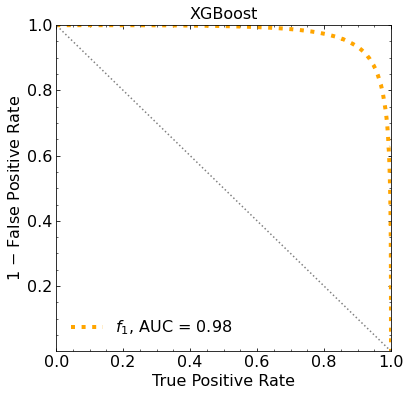

ML iteration  3
[0]	validation_0-logloss:0.62898	validation_1-logloss:0.62952


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.57547	validation_1-logloss:0.57660
[2]	validation_0-logloss:0.53056	validation_1-logloss:0.53232
[3]	validation_0-logloss:0.49207	validation_1-logloss:0.49401
[4]	validation_0-logloss:0.45911	validation_1-logloss:0.46146
[5]	validation_0-logloss:0.43024	validation_1-logloss:0.43289
[6]	validation_0-logloss:0.40517	validation_1-logloss:0.40820
[7]	validation_0-logloss:0.38318	validation_1-logloss:0.38645
[8]	validation_0-logloss:0.36387	validation_1-logloss:0.36746
[9]	validation_0-logloss:0.34701	validation_1-logloss:0.35087
[10]	validation_0-logloss:0.33196	validation_1-logloss:0.33605
[11]	validation_0-logloss:0.31875	validation_1-logloss:0.32302
[12]	validation_0-logloss:0.30681	validation_1-logloss:0.31132
[13]	validation_0-logloss:0.29620	validation_1-logloss:0.30095
[14]	validation_0-logloss:0.28686	validation_1-logloss:0.29178
[15]	validation_0-logloss:0.27831	validation_1-logloss:0.28336
[16]	validation_0-logloss:0.27076	validation_1-logloss:0.27596
[

[131]	validation_0-logloss:0.18776	validation_1-logloss:0.20143
[132]	validation_0-logloss:0.18770	validation_1-logloss:0.20143
[133]	validation_0-logloss:0.18765	validation_1-logloss:0.20143
[134]	validation_0-logloss:0.18761	validation_1-logloss:0.20143
[135]	validation_0-logloss:0.18754	validation_1-logloss:0.20144
[136]	validation_0-logloss:0.18748	validation_1-logloss:0.20145
[137]	validation_0-logloss:0.18743	validation_1-logloss:0.20145
[138]	validation_0-logloss:0.18740	validation_1-logloss:0.20145
[139]	validation_0-logloss:0.18736	validation_1-logloss:0.20145
[140]	validation_0-logloss:0.18735	validation_1-logloss:0.20145
[141]	validation_0-logloss:0.18731	validation_1-logloss:0.20146
[142]	validation_0-logloss:0.18724	validation_1-logloss:0.20147
[143]	validation_0-logloss:0.18718	validation_1-logloss:0.20147
[144]	validation_0-logloss:0.18715	validation_1-logloss:0.20147
[145]	validation_0-logloss:0.18709	validation_1-logloss:0.20149
[146]	validation_0-logloss:0.18706	valid

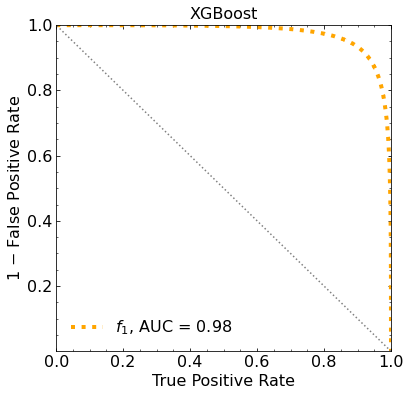

ML iteration  4


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62915	validation_1-logloss:0.62958
[1]	validation_0-logloss:0.57586	validation_1-logloss:0.57682
[2]	validation_0-logloss:0.53103	validation_1-logloss:0.53231
[3]	validation_0-logloss:0.49246	validation_1-logloss:0.49412
[4]	validation_0-logloss:0.45918	validation_1-logloss:0.46111
[5]	validation_0-logloss:0.43044	validation_1-logloss:0.43262
[6]	validation_0-logloss:0.40548	validation_1-logloss:0.40802
[7]	validation_0-logloss:0.38360	validation_1-logloss:0.38648
[8]	validation_0-logloss:0.36435	validation_1-logloss:0.36761
[9]	validation_0-logloss:0.34697	validation_1-logloss:0.35048
[10]	validation_0-logloss:0.33206	validation_1-logloss:0.33573
[11]	validation_0-logloss:0.31863	validation_1-logloss:0.32257
[12]	validation_0-logloss:0.30653	validation_1-logloss:0.31083
[13]	validation_0-logloss:0.29592	validation_1-logloss:0.30039
[14]	validation_0-logloss:0.28637	validation_1-logloss:0.29114
[15]	validation_0-logloss:0.27773	validation_1-logloss:0.28275
[1

[130]	validation_0-logloss:0.18704	validation_1-logloss:0.20155
[131]	validation_0-logloss:0.18699	validation_1-logloss:0.20155
[132]	validation_0-logloss:0.18699	validation_1-logloss:0.20155
[133]	validation_0-logloss:0.18694	validation_1-logloss:0.20156
[134]	validation_0-logloss:0.18687	validation_1-logloss:0.20156
[135]	validation_0-logloss:0.18681	validation_1-logloss:0.20156
[136]	validation_0-logloss:0.18676	validation_1-logloss:0.20156
[137]	validation_0-logloss:0.18674	validation_1-logloss:0.20157
[138]	validation_0-logloss:0.18661	validation_1-logloss:0.20157
[139]	validation_0-logloss:0.18656	validation_1-logloss:0.20157
[140]	validation_0-logloss:0.18654	validation_1-logloss:0.20158
[141]	validation_0-logloss:0.18650	validation_1-logloss:0.20158
[142]	validation_0-logloss:0.18649	validation_1-logloss:0.20158
[143]	validation_0-logloss:0.18649	validation_1-logloss:0.20158
[144]	validation_0-logloss:0.18642	validation_1-logloss:0.20159
[145]	validation_0-logloss:0.18635	valid

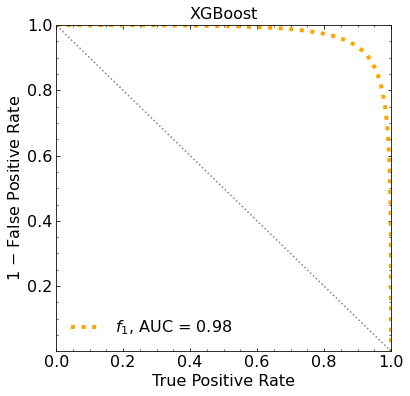

ML iteration  5
[0]	validation_0-logloss:0.62868	validation_1-logloss:0.62925


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.57513	validation_1-logloss:0.57636
[2]	validation_0-logloss:0.52993	validation_1-logloss:0.53166
[3]	validation_0-logloss:0.49156	validation_1-logloss:0.49371
[4]	validation_0-logloss:0.45831	validation_1-logloss:0.46081
[5]	validation_0-logloss:0.42947	validation_1-logloss:0.43224
[6]	validation_0-logloss:0.40464	validation_1-logloss:0.40780
[7]	validation_0-logloss:0.38265	validation_1-logloss:0.38618
[8]	validation_0-logloss:0.36349	validation_1-logloss:0.36719
[9]	validation_0-logloss:0.34648	validation_1-logloss:0.35053
[10]	validation_0-logloss:0.33138	validation_1-logloss:0.33564
[11]	validation_0-logloss:0.31797	validation_1-logloss:0.32241
[12]	validation_0-logloss:0.30611	validation_1-logloss:0.31069
[13]	validation_0-logloss:0.29549	validation_1-logloss:0.30039
[14]	validation_0-logloss:0.28604	validation_1-logloss:0.29112
[15]	validation_0-logloss:0.27751	validation_1-logloss:0.28283
[16]	validation_0-logloss:0.26992	validation_1-logloss:0.27547
[

[131]	validation_0-logloss:0.18628	validation_1-logloss:0.20153
[132]	validation_0-logloss:0.18625	validation_1-logloss:0.20153
[133]	validation_0-logloss:0.18621	validation_1-logloss:0.20154
[134]	validation_0-logloss:0.18619	validation_1-logloss:0.20154
[135]	validation_0-logloss:0.18611	validation_1-logloss:0.20155
[136]	validation_0-logloss:0.18604	validation_1-logloss:0.20155
[137]	validation_0-logloss:0.18598	validation_1-logloss:0.20155
[138]	validation_0-logloss:0.18597	validation_1-logloss:0.20155
[139]	validation_0-logloss:0.18594	validation_1-logloss:0.20155
[140]	validation_0-logloss:0.18593	validation_1-logloss:0.20155
[141]	validation_0-logloss:0.18586	validation_1-logloss:0.20156
[142]	validation_0-logloss:0.18584	validation_1-logloss:0.20156
[143]	validation_0-logloss:0.18582	validation_1-logloss:0.20156
[144]	validation_0-logloss:0.18577	validation_1-logloss:0.20156
[145]	validation_0-logloss:0.18576	validation_1-logloss:0.20156
[146]	validation_0-logloss:0.18569	valid

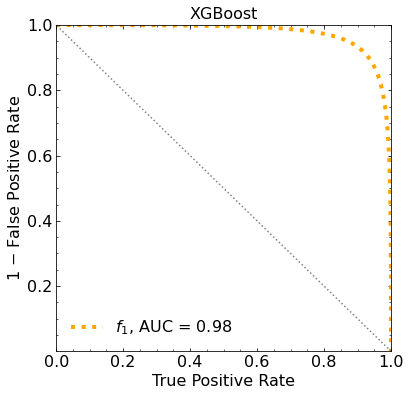

ML iteration  6
[0]	validation_0-logloss:0.62913	validation_1-logloss:0.62947


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.57573	validation_1-logloss:0.57667
[2]	validation_0-logloss:0.53049	validation_1-logloss:0.53183
[3]	validation_0-logloss:0.49195	validation_1-logloss:0.49351
[4]	validation_0-logloss:0.45899	validation_1-logloss:0.46102
[5]	validation_0-logloss:0.43045	validation_1-logloss:0.43269
[6]	validation_0-logloss:0.40539	validation_1-logloss:0.40804
[7]	validation_0-logloss:0.38355	validation_1-logloss:0.38633
[8]	validation_0-logloss:0.36407	validation_1-logloss:0.36720
[9]	validation_0-logloss:0.34716	validation_1-logloss:0.35055
[10]	validation_0-logloss:0.33204	validation_1-logloss:0.33573
[11]	validation_0-logloss:0.31875	validation_1-logloss:0.32265
[12]	validation_0-logloss:0.30670	validation_1-logloss:0.31084
[13]	validation_0-logloss:0.29603	validation_1-logloss:0.30041
[14]	validation_0-logloss:0.28651	validation_1-logloss:0.29114
[15]	validation_0-logloss:0.27795	validation_1-logloss:0.28283
[16]	validation_0-logloss:0.27029	validation_1-logloss:0.27541
[

[131]	validation_0-logloss:0.18628	validation_1-logloss:0.20146
[132]	validation_0-logloss:0.18623	validation_1-logloss:0.20147
[133]	validation_0-logloss:0.18617	validation_1-logloss:0.20147
[134]	validation_0-logloss:0.18609	validation_1-logloss:0.20148
[135]	validation_0-logloss:0.18609	validation_1-logloss:0.20148
[136]	validation_0-logloss:0.18607	validation_1-logloss:0.20148
[137]	validation_0-logloss:0.18599	validation_1-logloss:0.20149
[138]	validation_0-logloss:0.18596	validation_1-logloss:0.20149
[139]	validation_0-logloss:0.18586	validation_1-logloss:0.20149
[140]	validation_0-logloss:0.18585	validation_1-logloss:0.20149
[141]	validation_0-logloss:0.18581	validation_1-logloss:0.20149
[142]	validation_0-logloss:0.18574	validation_1-logloss:0.20149
[143]	validation_0-logloss:0.18572	validation_1-logloss:0.20149
[144]	validation_0-logloss:0.18570	validation_1-logloss:0.20149
[145]	validation_0-logloss:0.18569	validation_1-logloss:0.20150
[146]	validation_0-logloss:0.18566	valid

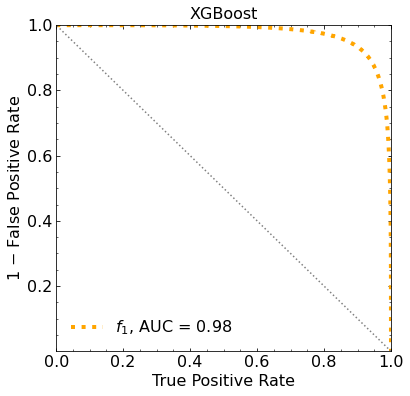

ML iteration  7


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62899	validation_1-logloss:0.62957
[1]	validation_0-logloss:0.57604	validation_1-logloss:0.57699
[2]	validation_0-logloss:0.53114	validation_1-logloss:0.53267
[3]	validation_0-logloss:0.49243	validation_1-logloss:0.49436
[4]	validation_0-logloss:0.45962	validation_1-logloss:0.46182
[5]	validation_0-logloss:0.43072	validation_1-logloss:0.43330
[6]	validation_0-logloss:0.40554	validation_1-logloss:0.40844
[7]	validation_0-logloss:0.38345	validation_1-logloss:0.38666
[8]	validation_0-logloss:0.36411	validation_1-logloss:0.36754
[9]	validation_0-logloss:0.34708	validation_1-logloss:0.35084
[10]	validation_0-logloss:0.33209	validation_1-logloss:0.33607
[11]	validation_0-logloss:0.31856	validation_1-logloss:0.32283
[12]	validation_0-logloss:0.30666	validation_1-logloss:0.31110
[13]	validation_0-logloss:0.29608	validation_1-logloss:0.30079
[14]	validation_0-logloss:0.28659	validation_1-logloss:0.29148
[15]	validation_0-logloss:0.27812	validation_1-logloss:0.28318
[1

[130]	validation_0-logloss:0.18643	validation_1-logloss:0.20123
[131]	validation_0-logloss:0.18640	validation_1-logloss:0.20124
[132]	validation_0-logloss:0.18629	validation_1-logloss:0.20124
[133]	validation_0-logloss:0.18618	validation_1-logloss:0.20123
[134]	validation_0-logloss:0.18610	validation_1-logloss:0.20124
[135]	validation_0-logloss:0.18602	validation_1-logloss:0.20125
[136]	validation_0-logloss:0.18599	validation_1-logloss:0.20126
[137]	validation_0-logloss:0.18597	validation_1-logloss:0.20126
[138]	validation_0-logloss:0.18594	validation_1-logloss:0.20126
[139]	validation_0-logloss:0.18592	validation_1-logloss:0.20127
[140]	validation_0-logloss:0.18588	validation_1-logloss:0.20126
[141]	validation_0-logloss:0.18584	validation_1-logloss:0.20127
[142]	validation_0-logloss:0.18582	validation_1-logloss:0.20128
[143]	validation_0-logloss:0.18576	validation_1-logloss:0.20128
[144]	validation_0-logloss:0.18575	validation_1-logloss:0.20128
[145]	validation_0-logloss:0.18573	valid

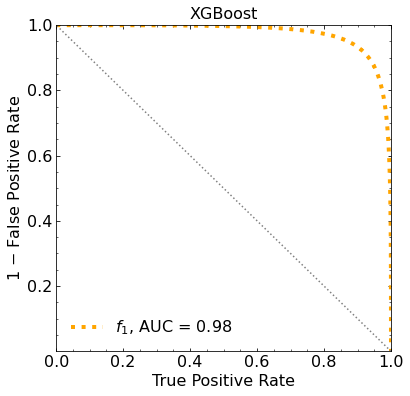

ML iteration  8


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62921	validation_1-logloss:0.62965
[1]	validation_0-logloss:0.57574	validation_1-logloss:0.57675
[2]	validation_0-logloss:0.53042	validation_1-logloss:0.53186
[3]	validation_0-logloss:0.49221	validation_1-logloss:0.49404
[4]	validation_0-logloss:0.45903	validation_1-logloss:0.46113
[5]	validation_0-logloss:0.43026	validation_1-logloss:0.43283
[6]	validation_0-logloss:0.40511	validation_1-logloss:0.40794
[7]	validation_0-logloss:0.38310	validation_1-logloss:0.38624
[8]	validation_0-logloss:0.36386	validation_1-logloss:0.36728
[9]	validation_0-logloss:0.34680	validation_1-logloss:0.35050
[10]	validation_0-logloss:0.33184	validation_1-logloss:0.33583
[11]	validation_0-logloss:0.31835	validation_1-logloss:0.32269
[12]	validation_0-logloss:0.30619	validation_1-logloss:0.31078
[13]	validation_0-logloss:0.29555	validation_1-logloss:0.30045
[14]	validation_0-logloss:0.28602	validation_1-logloss:0.29120
[15]	validation_0-logloss:0.27749	validation_1-logloss:0.28289
[1

[130]	validation_0-logloss:0.18582	validation_1-logloss:0.20134
[131]	validation_0-logloss:0.18577	validation_1-logloss:0.20134
[132]	validation_0-logloss:0.18564	validation_1-logloss:0.20134
[133]	validation_0-logloss:0.18562	validation_1-logloss:0.20135
[134]	validation_0-logloss:0.18559	validation_1-logloss:0.20135
[135]	validation_0-logloss:0.18553	validation_1-logloss:0.20136
[136]	validation_0-logloss:0.18548	validation_1-logloss:0.20136
[137]	validation_0-logloss:0.18542	validation_1-logloss:0.20136
[138]	validation_0-logloss:0.18533	validation_1-logloss:0.20137
[139]	validation_0-logloss:0.18532	validation_1-logloss:0.20137
[140]	validation_0-logloss:0.18524	validation_1-logloss:0.20137
[141]	validation_0-logloss:0.18516	validation_1-logloss:0.20138
[142]	validation_0-logloss:0.18511	validation_1-logloss:0.20139
[143]	validation_0-logloss:0.18502	validation_1-logloss:0.20139
[144]	validation_0-logloss:0.18499	validation_1-logloss:0.20140
[145]	validation_0-logloss:0.18493	valid

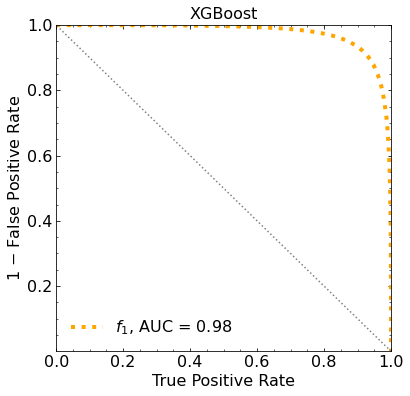

ML iteration  9


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62870	validation_1-logloss:0.62940
[1]	validation_0-logloss:0.57512	validation_1-logloss:0.57632
[2]	validation_0-logloss:0.52973	validation_1-logloss:0.53148
[3]	validation_0-logloss:0.49120	validation_1-logloss:0.49346
[4]	validation_0-logloss:0.45803	validation_1-logloss:0.46064
[5]	validation_0-logloss:0.42924	validation_1-logloss:0.43220
[6]	validation_0-logloss:0.40412	validation_1-logloss:0.40741
[7]	validation_0-logloss:0.38232	validation_1-logloss:0.38606
[8]	validation_0-logloss:0.36301	validation_1-logloss:0.36702
[9]	validation_0-logloss:0.34612	validation_1-logloss:0.35034
[10]	validation_0-logloss:0.33092	validation_1-logloss:0.33543
[11]	validation_0-logloss:0.31745	validation_1-logloss:0.32228
[12]	validation_0-logloss:0.30555	validation_1-logloss:0.31067
[13]	validation_0-logloss:0.29490	validation_1-logloss:0.30023
[14]	validation_0-logloss:0.28546	validation_1-logloss:0.29104
[15]	validation_0-logloss:0.27700	validation_1-logloss:0.28283
[1

[130]	validation_0-logloss:0.18519	validation_1-logloss:0.20154
[131]	validation_0-logloss:0.18513	validation_1-logloss:0.20153
[132]	validation_0-logloss:0.18508	validation_1-logloss:0.20154
[133]	validation_0-logloss:0.18504	validation_1-logloss:0.20154
[134]	validation_0-logloss:0.18503	validation_1-logloss:0.20154
[135]	validation_0-logloss:0.18501	validation_1-logloss:0.20154
[136]	validation_0-logloss:0.18495	validation_1-logloss:0.20155
[137]	validation_0-logloss:0.18491	validation_1-logloss:0.20155
[138]	validation_0-logloss:0.18487	validation_1-logloss:0.20155
[139]	validation_0-logloss:0.18481	validation_1-logloss:0.20156
[140]	validation_0-logloss:0.18479	validation_1-logloss:0.20156
[141]	validation_0-logloss:0.18478	validation_1-logloss:0.20156
[142]	validation_0-logloss:0.18467	validation_1-logloss:0.20156
[143]	validation_0-logloss:0.18459	validation_1-logloss:0.20154
[144]	validation_0-logloss:0.18455	validation_1-logloss:0.20155
[145]	validation_0-logloss:0.18449	valid

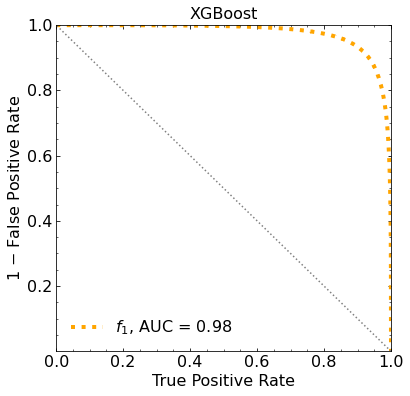

Classification score (1 ML):


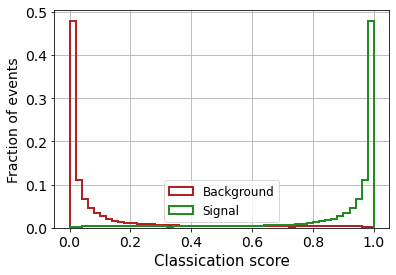

Classification score (10 ML):


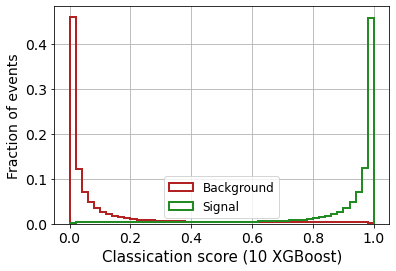

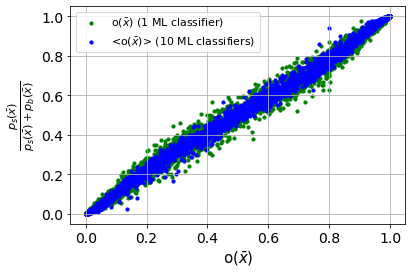


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  11.692436533423784
Z_XG 25 bins_1ML:  14.475570868026548
Z_XG 50 bins_1ML:  15.752237581990503
Z_XG 100 bins_1ML:  16.616717261728766

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  6.108648661508239
Z_XG 25 bins_eq_1ML:  8.490475134067314
Z_XG 50 bins_eq_1ML:  10.376392285455749
Z_XG 100 bins_eq_1ML:  12.171200801445753

 BL lineal bins, 10 ML
Z_XG 10 bins:  11.756410182188466
Z_XG 25 bins:  14.589406084865143
Z_XG 50 bins:  16.030872870861486
Z_XG 100 bins:  16.930146717908922

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  6.07148920511574
Z_XG 25 bins_eq:  8.435876326828636
Z_XG 50 bins_eq:  10.314133572706593
Z_XG 100 bins_eq:  12.085311769548504

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOO

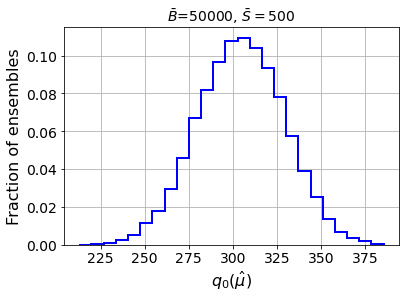

muhat mean:  0.021311974044408398
Z_gaussian:  17.46249984935399
Z_gaussian_mu0:  17.484455135559486

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf  6736.95191515  6645.80979
  6528.82339822  6377.05504666  6185.36199845  5957.99156598
  5688.04820442  5363.32357139  4972.19847329  4518.62685769
  3993.69020699  3384.33028517  2684.41470631  1886.21358908
   994.58381473    44.52885931  -933.94557568 -1949.25957818]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf  6710.16027119  6618.48067695
  6493.96200535  6336.04906247  6140.41105285  5900.30502886
  5618.45116014  5290.67315207  4909.90010863  4462.1958881
  3945.3

KDE Kernel:  epanechnikov
Background bandwidth:  0.002094366253972675
Signal bandwidth:  0.002094366253972675


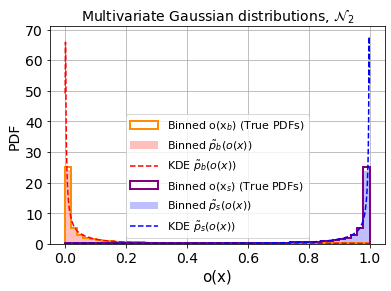

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf  6493.82399673  6466.79160644  6410.96320945
  6326.19574059  6208.50148678  6054.29144176  5859.65880845
  5617.89245271  5321.91166108  4955.53644606  4520.97000756
  4007.46903513  3398.28670317  2694.44866673  1896.25181613
  1000.67525689    50.63102725  -925.30902861 -1945.13357309]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf  6354.12596277
  6269.42136935  6150.77295412  5995.35828727  5796.72375542
  5547.83663219  5245.33300698  4887.49863668  4458.3566784
  395

KDE Kernel:  epanechnikov
Background bandwidth:  0.0014471925421217023
Signal bandwidth:  0.003030951223220623


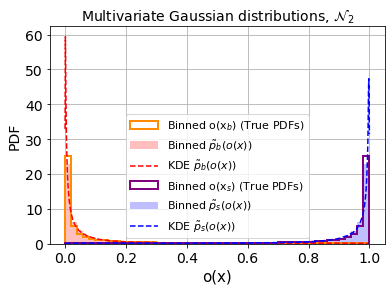

 Z MLL+KDE (1ML) 


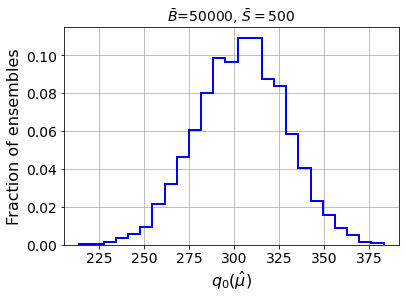

muhat mean_1ML:  0.015618980026361149
Z_KDE_1ML:  17.453194775741927
Z_KDE mu=0_1ML:  17.46394145132108

 Z MLL+KDE (10ML) 


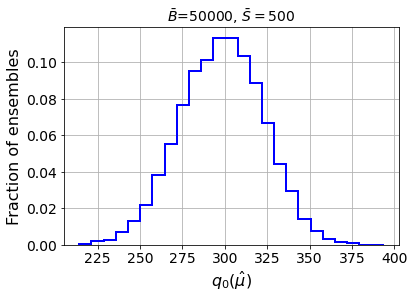

muhat mean:  0.017180371083848726
Z_KDE:  17.28464208323587
Z_KDE mu=0:  17.294124907460443

 ------------------------------------ 



In [17]:
dim=4

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3, signal_X_4 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3, background_X_4 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML)


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP)


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [ ]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 5)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 5)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 5)
y_gauss_test :  (1000000, 1)



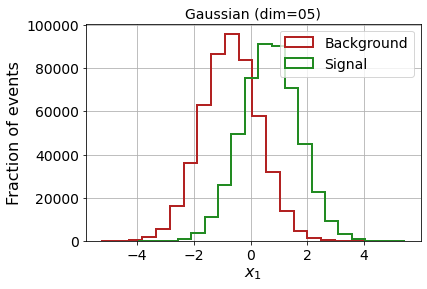

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62626	validation_1-logloss:0.62639
[1]	validation_0-logloss:0.57034	validation_1-logloss:0.57054
[2]	validation_0-logloss:0.52272	validation_1-logloss:0.52305
[3]	validation_0-logloss:0.48209	validation_1-logloss:0.48247
[4]	validation_0-logloss:0.44691	validation_1-logloss:0.44735
[5]	validation_0-logloss:0.41641	validation_1-logloss:0.41692
[6]	validation_0-logloss:0.38950	validation_1-logloss:0.39006
[7]	validation_0-logloss:0.36608	validation_1-logloss:0.36674
[8]	validation_0-logloss:0.34503	validation_1-logloss:0.34577
[9]	validation_0-logloss:0.32672	validation_1-logloss:0.32753
[10]	validation_0-logloss:0.31028	validation_1-logloss:0.31113
[11]	validation_0-logloss:0.29573	validation_1-logloss:0.29664
[12]	validation_0-logloss:0.28270	validation_1-logloss:0.28372
[13]	validation_0-logloss:0.27112	validation_1-logloss:0.27214
[14]	validation_0-logloss:0.26080	validation_1-logloss:0.26187
[15]	validation_0-logloss:0.25139	validation_1-logloss:0.25252
[1

[130]	validation_0-logloss:0.14733	validation_1-logloss:0.15078
[131]	validation_0-logloss:0.14732	validation_1-logloss:0.15078
[132]	validation_0-logloss:0.14730	validation_1-logloss:0.15077
[133]	validation_0-logloss:0.14729	validation_1-logloss:0.15077
[134]	validation_0-logloss:0.14728	validation_1-logloss:0.15076
[135]	validation_0-logloss:0.14726	validation_1-logloss:0.15076
[136]	validation_0-logloss:0.14723	validation_1-logloss:0.15074
[137]	validation_0-logloss:0.14722	validation_1-logloss:0.15074
[138]	validation_0-logloss:0.14721	validation_1-logloss:0.15074
[139]	validation_0-logloss:0.14719	validation_1-logloss:0.15074
[140]	validation_0-logloss:0.14718	validation_1-logloss:0.15073
[141]	validation_0-logloss:0.14717	validation_1-logloss:0.15073
[142]	validation_0-logloss:0.14715	validation_1-logloss:0.15072
[143]	validation_0-logloss:0.14713	validation_1-logloss:0.15072
[144]	validation_0-logloss:0.14713	validation_1-logloss:0.15071
[145]	validation_0-logloss:0.14711	valid

[259]	validation_0-logloss:0.14623	validation_1-logloss:0.15066
[260]	validation_0-logloss:0.14622	validation_1-logloss:0.15066
[261]	validation_0-logloss:0.14621	validation_1-logloss:0.15066
[262]	validation_0-logloss:0.14621	validation_1-logloss:0.15066
[263]	validation_0-logloss:0.14620	validation_1-logloss:0.15066
[264]	validation_0-logloss:0.14619	validation_1-logloss:0.15066
[265]	validation_0-logloss:0.14618	validation_1-logloss:0.15066
[266]	validation_0-logloss:0.14617	validation_1-logloss:0.15066
[267]	validation_0-logloss:0.14615	validation_1-logloss:0.15066
[268]	validation_0-logloss:0.14615	validation_1-logloss:0.15066
[269]	validation_0-logloss:0.14615	validation_1-logloss:0.15066
[270]	validation_0-logloss:0.14613	validation_1-logloss:0.15066
[271]	validation_0-logloss:0.14613	validation_1-logloss:0.15066
[272]	validation_0-logloss:0.14613	validation_1-logloss:0.15067
[273]	validation_0-logloss:0.14613	validation_1-logloss:0.15066


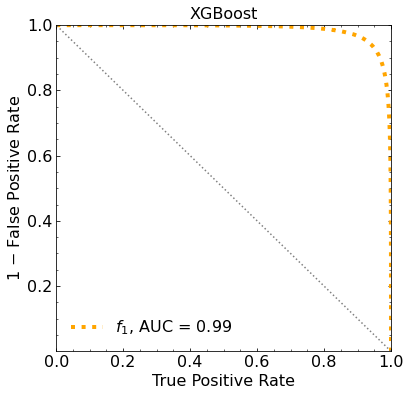

ML iteration 0
[0]	validation_0-logloss:0.62551	validation_1-logloss:0.62599


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.56909	validation_1-logloss:0.57011
[2]	validation_0-logloss:0.52124	validation_1-logloss:0.52296
[3]	validation_0-logloss:0.48010	validation_1-logloss:0.48224
[4]	validation_0-logloss:0.44467	validation_1-logloss:0.44718
[5]	validation_0-logloss:0.41355	validation_1-logloss:0.41640
[6]	validation_0-logloss:0.38662	validation_1-logloss:0.38978
[7]	validation_0-logloss:0.36285	validation_1-logloss:0.36632
[8]	validation_0-logloss:0.34196	validation_1-logloss:0.34576
[9]	validation_0-logloss:0.32329	validation_1-logloss:0.32732
[10]	validation_0-logloss:0.30674	validation_1-logloss:0.31104
[11]	validation_0-logloss:0.29195	validation_1-logloss:0.29655
[12]	validation_0-logloss:0.27850	validation_1-logloss:0.28343
[13]	validation_0-logloss:0.26661	validation_1-logloss:0.27172
[14]	validation_0-logloss:0.25598	validation_1-logloss:0.26130
[15]	validation_0-logloss:0.24635	validation_1-logloss:0.25202
[16]	validation_0-logloss:0.23769	validation_1-logloss:0.24363
[

[131]	validation_0-logloss:0.13617	validation_1-logloss:0.15276
[132]	validation_0-logloss:0.13615	validation_1-logloss:0.15276
[133]	validation_0-logloss:0.13613	validation_1-logloss:0.15276
[134]	validation_0-logloss:0.13609	validation_1-logloss:0.15276
[135]	validation_0-logloss:0.13600	validation_1-logloss:0.15276
[136]	validation_0-logloss:0.13594	validation_1-logloss:0.15275
[137]	validation_0-logloss:0.13592	validation_1-logloss:0.15275
[138]	validation_0-logloss:0.13588	validation_1-logloss:0.15274
[139]	validation_0-logloss:0.13580	validation_1-logloss:0.15275
[140]	validation_0-logloss:0.13574	validation_1-logloss:0.15275
[141]	validation_0-logloss:0.13562	validation_1-logloss:0.15276
[142]	validation_0-logloss:0.13557	validation_1-logloss:0.15275
[143]	validation_0-logloss:0.13556	validation_1-logloss:0.15275
[144]	validation_0-logloss:0.13551	validation_1-logloss:0.15276
[145]	validation_0-logloss:0.13547	validation_1-logloss:0.15276
[146]	validation_0-logloss:0.13535	valid

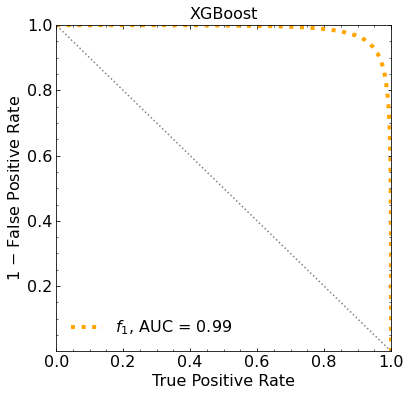

ML iteration  1


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62567	validation_1-logloss:0.62643
[1]	validation_0-logloss:0.56893	validation_1-logloss:0.57028
[2]	validation_0-logloss:0.52124	validation_1-logloss:0.52278
[3]	validation_0-logloss:0.48024	validation_1-logloss:0.48232
[4]	validation_0-logloss:0.44476	validation_1-logloss:0.44714
[5]	validation_0-logloss:0.41407	validation_1-logloss:0.41684
[6]	validation_0-logloss:0.38701	validation_1-logloss:0.39002
[7]	validation_0-logloss:0.36326	validation_1-logloss:0.36671
[8]	validation_0-logloss:0.34215	validation_1-logloss:0.34585
[9]	validation_0-logloss:0.32363	validation_1-logloss:0.32749
[10]	validation_0-logloss:0.30697	validation_1-logloss:0.31109
[11]	validation_0-logloss:0.29219	validation_1-logloss:0.29664
[12]	validation_0-logloss:0.27885	validation_1-logloss:0.28364
[13]	validation_0-logloss:0.26710	validation_1-logloss:0.27221
[14]	validation_0-logloss:0.25643	validation_1-logloss:0.26177
[15]	validation_0-logloss:0.24682	validation_1-logloss:0.25238
[1

[130]	validation_0-logloss:0.13588	validation_1-logloss:0.15279
[131]	validation_0-logloss:0.13581	validation_1-logloss:0.15279
[132]	validation_0-logloss:0.13580	validation_1-logloss:0.15280
[133]	validation_0-logloss:0.13575	validation_1-logloss:0.15280
[134]	validation_0-logloss:0.13569	validation_1-logloss:0.15279
[135]	validation_0-logloss:0.13566	validation_1-logloss:0.15279
[136]	validation_0-logloss:0.13562	validation_1-logloss:0.15279
[137]	validation_0-logloss:0.13559	validation_1-logloss:0.15279
[138]	validation_0-logloss:0.13551	validation_1-logloss:0.15279
[139]	validation_0-logloss:0.13548	validation_1-logloss:0.15280
[140]	validation_0-logloss:0.13540	validation_1-logloss:0.15280
[141]	validation_0-logloss:0.13537	validation_1-logloss:0.15280
[142]	validation_0-logloss:0.13532	validation_1-logloss:0.15281
[143]	validation_0-logloss:0.13526	validation_1-logloss:0.15281
[144]	validation_0-logloss:0.13523	validation_1-logloss:0.15282
[145]	validation_0-logloss:0.13519	valid

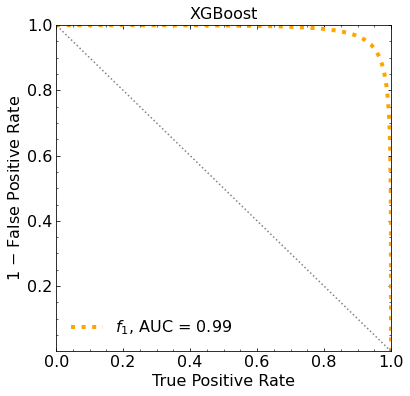

ML iteration  2
[0]	validation_0-logloss:0.62559	validation_1-logloss:0.62600


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.56934	validation_1-logloss:0.57041
[2]	validation_0-logloss:0.52169	validation_1-logloss:0.52301
[3]	validation_0-logloss:0.48085	validation_1-logloss:0.48256
[4]	validation_0-logloss:0.44562	validation_1-logloss:0.44759
[5]	validation_0-logloss:0.41469	validation_1-logloss:0.41681
[6]	validation_0-logloss:0.38767	validation_1-logloss:0.39015
[7]	validation_0-logloss:0.36359	validation_1-logloss:0.36634
[8]	validation_0-logloss:0.34271	validation_1-logloss:0.34566
[9]	validation_0-logloss:0.32418	validation_1-logloss:0.32744
[10]	validation_0-logloss:0.30764	validation_1-logloss:0.31113
[11]	validation_0-logloss:0.29266	validation_1-logloss:0.29640
[12]	validation_0-logloss:0.27964	validation_1-logloss:0.28369
[13]	validation_0-logloss:0.26775	validation_1-logloss:0.27194
[14]	validation_0-logloss:0.25719	validation_1-logloss:0.26164
[15]	validation_0-logloss:0.24762	validation_1-logloss:0.25238
[16]	validation_0-logloss:0.23893	validation_1-logloss:0.24399
[

[131]	validation_0-logloss:0.13568	validation_1-logloss:0.15283
[132]	validation_0-logloss:0.13563	validation_1-logloss:0.15284
[133]	validation_0-logloss:0.13561	validation_1-logloss:0.15284
[134]	validation_0-logloss:0.13552	validation_1-logloss:0.15282
[135]	validation_0-logloss:0.13550	validation_1-logloss:0.15283
[136]	validation_0-logloss:0.13541	validation_1-logloss:0.15283
[137]	validation_0-logloss:0.13539	validation_1-logloss:0.15282
[138]	validation_0-logloss:0.13537	validation_1-logloss:0.15283
[139]	validation_0-logloss:0.13534	validation_1-logloss:0.15284
[140]	validation_0-logloss:0.13526	validation_1-logloss:0.15283
[141]	validation_0-logloss:0.13523	validation_1-logloss:0.15283
[142]	validation_0-logloss:0.13521	validation_1-logloss:0.15284
[143]	validation_0-logloss:0.13520	validation_1-logloss:0.15284
[144]	validation_0-logloss:0.13511	validation_1-logloss:0.15283
[145]	validation_0-logloss:0.13503	validation_1-logloss:0.15284
[146]	validation_0-logloss:0.13501	valid

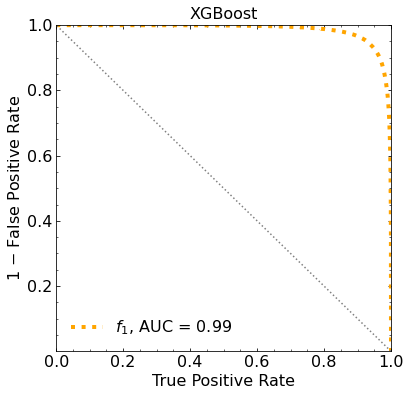

ML iteration  3


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62574	validation_1-logloss:0.62633
[1]	validation_0-logloss:0.56939	validation_1-logloss:0.57059
[2]	validation_0-logloss:0.52128	validation_1-logloss:0.52312
[3]	validation_0-logloss:0.48022	validation_1-logloss:0.48231
[4]	validation_0-logloss:0.44442	validation_1-logloss:0.44692
[5]	validation_0-logloss:0.41346	validation_1-logloss:0.41645
[6]	validation_0-logloss:0.38629	validation_1-logloss:0.38965
[7]	validation_0-logloss:0.36278	validation_1-logloss:0.36656
[8]	validation_0-logloss:0.34190	validation_1-logloss:0.34608
[9]	validation_0-logloss:0.32307	validation_1-logloss:0.32759
[10]	validation_0-logloss:0.30643	validation_1-logloss:0.31123
[11]	validation_0-logloss:0.29172	validation_1-logloss:0.29682
[12]	validation_0-logloss:0.27861	validation_1-logloss:0.28396
[13]	validation_0-logloss:0.26650	validation_1-logloss:0.27216
[14]	validation_0-logloss:0.25589	validation_1-logloss:0.26178
[15]	validation_0-logloss:0.24613	validation_1-logloss:0.25229
[1

[130]	validation_0-logloss:0.13598	validation_1-logloss:0.15303
[131]	validation_0-logloss:0.13590	validation_1-logloss:0.15303
[132]	validation_0-logloss:0.13582	validation_1-logloss:0.15303
[133]	validation_0-logloss:0.13576	validation_1-logloss:0.15302
[134]	validation_0-logloss:0.13574	validation_1-logloss:0.15302
[135]	validation_0-logloss:0.13571	validation_1-logloss:0.15302
[136]	validation_0-logloss:0.13567	validation_1-logloss:0.15302
[137]	validation_0-logloss:0.13565	validation_1-logloss:0.15302
[138]	validation_0-logloss:0.13562	validation_1-logloss:0.15302
[139]	validation_0-logloss:0.13555	validation_1-logloss:0.15301
[140]	validation_0-logloss:0.13553	validation_1-logloss:0.15301
[141]	validation_0-logloss:0.13543	validation_1-logloss:0.15301
[142]	validation_0-logloss:0.13533	validation_1-logloss:0.15301
[143]	validation_0-logloss:0.13531	validation_1-logloss:0.15301
[144]	validation_0-logloss:0.13529	validation_1-logloss:0.15301
[145]	validation_0-logloss:0.13526	valid

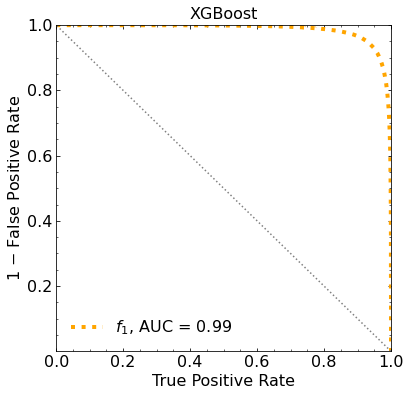

ML iteration  4
[0]	validation_0-logloss:0.62586	validation_1-logloss:0.62629


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.56952	validation_1-logloss:0.57068
[2]	validation_0-logloss:0.52167	validation_1-logloss:0.52317
[3]	validation_0-logloss:0.48060	validation_1-logloss:0.48242
[4]	validation_0-logloss:0.44518	validation_1-logloss:0.44740
[5]	validation_0-logloss:0.41400	validation_1-logloss:0.41661
[6]	validation_0-logloss:0.38736	validation_1-logloss:0.39026
[7]	validation_0-logloss:0.36357	validation_1-logloss:0.36683
[8]	validation_0-logloss:0.34258	validation_1-logloss:0.34608
[9]	validation_0-logloss:0.32391	validation_1-logloss:0.32776
[10]	validation_0-logloss:0.30727	validation_1-logloss:0.31140
[11]	validation_0-logloss:0.29248	validation_1-logloss:0.29690
[12]	validation_0-logloss:0.27925	validation_1-logloss:0.28405
[13]	validation_0-logloss:0.26718	validation_1-logloss:0.27226
[14]	validation_0-logloss:0.25669	validation_1-logloss:0.26204
[15]	validation_0-logloss:0.24686	validation_1-logloss:0.25250
[16]	validation_0-logloss:0.23818	validation_1-logloss:0.24410
[

[131]	validation_0-logloss:0.13572	validation_1-logloss:0.15292
[132]	validation_0-logloss:0.13565	validation_1-logloss:0.15293
[133]	validation_0-logloss:0.13561	validation_1-logloss:0.15292
[134]	validation_0-logloss:0.13557	validation_1-logloss:0.15292
[135]	validation_0-logloss:0.13547	validation_1-logloss:0.15292
[136]	validation_0-logloss:0.13545	validation_1-logloss:0.15292
[137]	validation_0-logloss:0.13542	validation_1-logloss:0.15292
[138]	validation_0-logloss:0.13531	validation_1-logloss:0.15292
[139]	validation_0-logloss:0.13524	validation_1-logloss:0.15293
[140]	validation_0-logloss:0.13521	validation_1-logloss:0.15293
[141]	validation_0-logloss:0.13518	validation_1-logloss:0.15294
[142]	validation_0-logloss:0.13514	validation_1-logloss:0.15293
[143]	validation_0-logloss:0.13508	validation_1-logloss:0.15293
[144]	validation_0-logloss:0.13501	validation_1-logloss:0.15294
[145]	validation_0-logloss:0.13491	validation_1-logloss:0.15294
[146]	validation_0-logloss:0.13487	valid

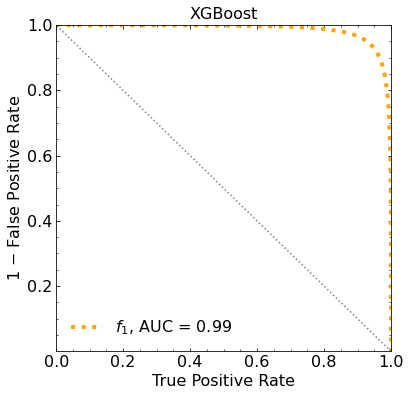

ML iteration  5


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62582	validation_1-logloss:0.62625
[1]	validation_0-logloss:0.56918	validation_1-logloss:0.57034
[2]	validation_0-logloss:0.52101	validation_1-logloss:0.52261
[3]	validation_0-logloss:0.47984	validation_1-logloss:0.48195
[4]	validation_0-logloss:0.44445	validation_1-logloss:0.44700
[5]	validation_0-logloss:0.41319	validation_1-logloss:0.41600
[6]	validation_0-logloss:0.38608	validation_1-logloss:0.38932
[7]	validation_0-logloss:0.36259	validation_1-logloss:0.36612
[8]	validation_0-logloss:0.34128	validation_1-logloss:0.34511
[9]	validation_0-logloss:0.32277	validation_1-logloss:0.32694
[10]	validation_0-logloss:0.30614	validation_1-logloss:0.31063
[11]	validation_0-logloss:0.29149	validation_1-logloss:0.29624
[12]	validation_0-logloss:0.27818	validation_1-logloss:0.28314
[13]	validation_0-logloss:0.26621	validation_1-logloss:0.27141
[14]	validation_0-logloss:0.25571	validation_1-logloss:0.26121
[15]	validation_0-logloss:0.24627	validation_1-logloss:0.25199
[1

[130]	validation_0-logloss:0.13564	validation_1-logloss:0.15278
[131]	validation_0-logloss:0.13559	validation_1-logloss:0.15279
[132]	validation_0-logloss:0.13555	validation_1-logloss:0.15278
[133]	validation_0-logloss:0.13554	validation_1-logloss:0.15278
[134]	validation_0-logloss:0.13542	validation_1-logloss:0.15278
[135]	validation_0-logloss:0.13534	validation_1-logloss:0.15279
[136]	validation_0-logloss:0.13526	validation_1-logloss:0.15279
[137]	validation_0-logloss:0.13521	validation_1-logloss:0.15280
[138]	validation_0-logloss:0.13520	validation_1-logloss:0.15279
[139]	validation_0-logloss:0.13511	validation_1-logloss:0.15281
[140]	validation_0-logloss:0.13506	validation_1-logloss:0.15282
[141]	validation_0-logloss:0.13503	validation_1-logloss:0.15282
[142]	validation_0-logloss:0.13502	validation_1-logloss:0.15281
[143]	validation_0-logloss:0.13496	validation_1-logloss:0.15282
[144]	validation_0-logloss:0.13481	validation_1-logloss:0.15284
[145]	validation_0-logloss:0.13480	valid

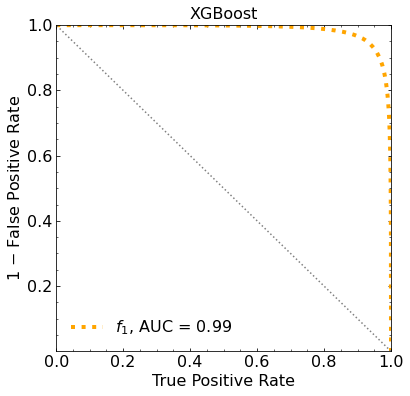

ML iteration  6


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62552	validation_1-logloss:0.62618
[1]	validation_0-logloss:0.56914	validation_1-logloss:0.57030
[2]	validation_0-logloss:0.52145	validation_1-logloss:0.52312
[3]	validation_0-logloss:0.48023	validation_1-logloss:0.48220
[4]	validation_0-logloss:0.44461	validation_1-logloss:0.44706
[5]	validation_0-logloss:0.41406	validation_1-logloss:0.41675
[6]	validation_0-logloss:0.38694	validation_1-logloss:0.38999
[7]	validation_0-logloss:0.36302	validation_1-logloss:0.36641
[8]	validation_0-logloss:0.34204	validation_1-logloss:0.34585
[9]	validation_0-logloss:0.32335	validation_1-logloss:0.32748
[10]	validation_0-logloss:0.30663	validation_1-logloss:0.31104
[11]	validation_0-logloss:0.29184	validation_1-logloss:0.29648
[12]	validation_0-logloss:0.27880	validation_1-logloss:0.28374
[13]	validation_0-logloss:0.26702	validation_1-logloss:0.27220
[14]	validation_0-logloss:0.25625	validation_1-logloss:0.26168
[15]	validation_0-logloss:0.24646	validation_1-logloss:0.25222
[1

[130]	validation_0-logloss:0.13571	validation_1-logloss:0.15276
[131]	validation_0-logloss:0.13569	validation_1-logloss:0.15276
[132]	validation_0-logloss:0.13564	validation_1-logloss:0.15277
[133]	validation_0-logloss:0.13559	validation_1-logloss:0.15277
[134]	validation_0-logloss:0.13558	validation_1-logloss:0.15278
[135]	validation_0-logloss:0.13553	validation_1-logloss:0.15279
[136]	validation_0-logloss:0.13544	validation_1-logloss:0.15279
[137]	validation_0-logloss:0.13535	validation_1-logloss:0.15278
[138]	validation_0-logloss:0.13531	validation_1-logloss:0.15278
[139]	validation_0-logloss:0.13526	validation_1-logloss:0.15277
[140]	validation_0-logloss:0.13524	validation_1-logloss:0.15277
[141]	validation_0-logloss:0.13521	validation_1-logloss:0.15277
[142]	validation_0-logloss:0.13514	validation_1-logloss:0.15277
[143]	validation_0-logloss:0.13512	validation_1-logloss:0.15278
[144]	validation_0-logloss:0.13504	validation_1-logloss:0.15278
[145]	validation_0-logloss:0.13503	valid

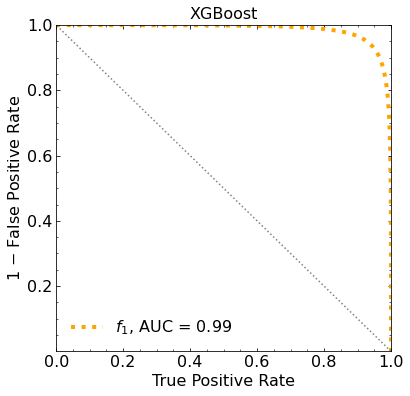

ML iteration  7


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62563	validation_1-logloss:0.62628
[1]	validation_0-logloss:0.56952	validation_1-logloss:0.57059
[2]	validation_0-logloss:0.52175	validation_1-logloss:0.52314
[3]	validation_0-logloss:0.48090	validation_1-logloss:0.48273
[4]	validation_0-logloss:0.44531	validation_1-logloss:0.44750
[5]	validation_0-logloss:0.41463	validation_1-logloss:0.41715
[6]	validation_0-logloss:0.38754	validation_1-logloss:0.39027
[7]	validation_0-logloss:0.36408	validation_1-logloss:0.36706
[8]	validation_0-logloss:0.34320	validation_1-logloss:0.34645
[9]	validation_0-logloss:0.32427	validation_1-logloss:0.32780
[10]	validation_0-logloss:0.30770	validation_1-logloss:0.31159
[11]	validation_0-logloss:0.29306	validation_1-logloss:0.29718
[12]	validation_0-logloss:0.27979	validation_1-logloss:0.28407
[13]	validation_0-logloss:0.26803	validation_1-logloss:0.27252
[14]	validation_0-logloss:0.25734	validation_1-logloss:0.26207
[15]	validation_0-logloss:0.24784	validation_1-logloss:0.25273
[1

[130]	validation_0-logloss:0.13749	validation_1-logloss:0.15282
[131]	validation_0-logloss:0.13747	validation_1-logloss:0.15282
[132]	validation_0-logloss:0.13742	validation_1-logloss:0.15282
[133]	validation_0-logloss:0.13739	validation_1-logloss:0.15282
[134]	validation_0-logloss:0.13733	validation_1-logloss:0.15281
[135]	validation_0-logloss:0.13724	validation_1-logloss:0.15281
[136]	validation_0-logloss:0.13721	validation_1-logloss:0.15281
[137]	validation_0-logloss:0.13720	validation_1-logloss:0.15281
[138]	validation_0-logloss:0.13716	validation_1-logloss:0.15281
[139]	validation_0-logloss:0.13714	validation_1-logloss:0.15281
[140]	validation_0-logloss:0.13705	validation_1-logloss:0.15281
[141]	validation_0-logloss:0.13702	validation_1-logloss:0.15281
[142]	validation_0-logloss:0.13701	validation_1-logloss:0.15281
[143]	validation_0-logloss:0.13697	validation_1-logloss:0.15281
[144]	validation_0-logloss:0.13695	validation_1-logloss:0.15281
[145]	validation_0-logloss:0.13689	valid

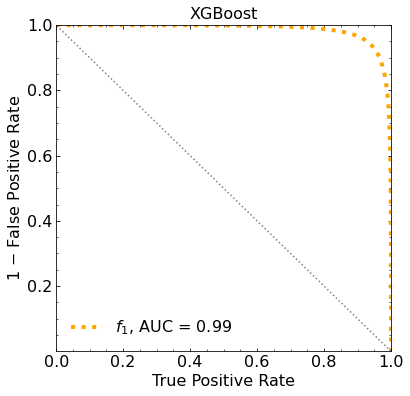

ML iteration  8


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62536	validation_1-logloss:0.62623
[1]	validation_0-logloss:0.56900	validation_1-logloss:0.57051
[2]	validation_0-logloss:0.52108	validation_1-logloss:0.52315
[3]	validation_0-logloss:0.48005	validation_1-logloss:0.48277
[4]	validation_0-logloss:0.44424	validation_1-logloss:0.44714
[5]	validation_0-logloss:0.41321	validation_1-logloss:0.41666
[6]	validation_0-logloss:0.38594	validation_1-logloss:0.38970
[7]	validation_0-logloss:0.36230	validation_1-logloss:0.36644
[8]	validation_0-logloss:0.34142	validation_1-logloss:0.34577
[9]	validation_0-logloss:0.32260	validation_1-logloss:0.32725
[10]	validation_0-logloss:0.30614	validation_1-logloss:0.31123
[11]	validation_0-logloss:0.29135	validation_1-logloss:0.29664
[12]	validation_0-logloss:0.27814	validation_1-logloss:0.28375
[13]	validation_0-logloss:0.26602	validation_1-logloss:0.27185
[14]	validation_0-logloss:0.25537	validation_1-logloss:0.26149
[15]	validation_0-logloss:0.24572	validation_1-logloss:0.25213
[1

[130]	validation_0-logloss:0.13494	validation_1-logloss:0.15279
[131]	validation_0-logloss:0.13490	validation_1-logloss:0.15278
[132]	validation_0-logloss:0.13484	validation_1-logloss:0.15279
[133]	validation_0-logloss:0.13479	validation_1-logloss:0.15279
[134]	validation_0-logloss:0.13472	validation_1-logloss:0.15280
[135]	validation_0-logloss:0.13465	validation_1-logloss:0.15279
[136]	validation_0-logloss:0.13460	validation_1-logloss:0.15279
[137]	validation_0-logloss:0.13457	validation_1-logloss:0.15279
[138]	validation_0-logloss:0.13451	validation_1-logloss:0.15278
[139]	validation_0-logloss:0.13446	validation_1-logloss:0.15279
[140]	validation_0-logloss:0.13441	validation_1-logloss:0.15278
[141]	validation_0-logloss:0.13437	validation_1-logloss:0.15278
[142]	validation_0-logloss:0.13435	validation_1-logloss:0.15278
[143]	validation_0-logloss:0.13431	validation_1-logloss:0.15278
[144]	validation_0-logloss:0.13427	validation_1-logloss:0.15278
[145]	validation_0-logloss:0.13421	valid

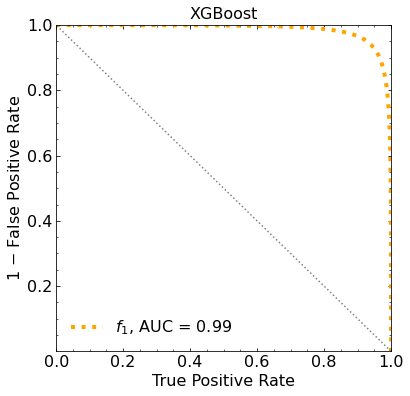

ML iteration  9


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62608	validation_1-logloss:0.62628
[1]	validation_0-logloss:0.57034	validation_1-logloss:0.57084
[2]	validation_0-logloss:0.52256	validation_1-logloss:0.52345
[3]	validation_0-logloss:0.48180	validation_1-logloss:0.48270
[4]	validation_0-logloss:0.44639	validation_1-logloss:0.44748
[5]	validation_0-logloss:0.41580	validation_1-logloss:0.41709
[6]	validation_0-logloss:0.38899	validation_1-logloss:0.39028
[7]	validation_0-logloss:0.36527	validation_1-logloss:0.36685
[8]	validation_0-logloss:0.34453	validation_1-logloss:0.34633
[9]	validation_0-logloss:0.32605	validation_1-logloss:0.32804
[10]	validation_0-logloss:0.30969	validation_1-logloss:0.31190
[11]	validation_0-logloss:0.29494	validation_1-logloss:0.29728
[12]	validation_0-logloss:0.28145	validation_1-logloss:0.28400
[13]	validation_0-logloss:0.26973	validation_1-logloss:0.27249
[14]	validation_0-logloss:0.25907	validation_1-logloss:0.26216
[15]	validation_0-logloss:0.24950	validation_1-logloss:0.25282
[1

[130]	validation_0-logloss:0.13896	validation_1-logloss:0.15262
[131]	validation_0-logloss:0.13891	validation_1-logloss:0.15261
[132]	validation_0-logloss:0.13889	validation_1-logloss:0.15261
[133]	validation_0-logloss:0.13885	validation_1-logloss:0.15261
[134]	validation_0-logloss:0.13881	validation_1-logloss:0.15261
[135]	validation_0-logloss:0.13873	validation_1-logloss:0.15261
[136]	validation_0-logloss:0.13872	validation_1-logloss:0.15262
[137]	validation_0-logloss:0.13864	validation_1-logloss:0.15262
[138]	validation_0-logloss:0.13859	validation_1-logloss:0.15262
[139]	validation_0-logloss:0.13857	validation_1-logloss:0.15262
[140]	validation_0-logloss:0.13846	validation_1-logloss:0.15262
[141]	validation_0-logloss:0.13836	validation_1-logloss:0.15262
[142]	validation_0-logloss:0.13834	validation_1-logloss:0.15262
[143]	validation_0-logloss:0.13832	validation_1-logloss:0.15262
[144]	validation_0-logloss:0.13831	validation_1-logloss:0.15262
[145]	validation_0-logloss:0.13820	valid

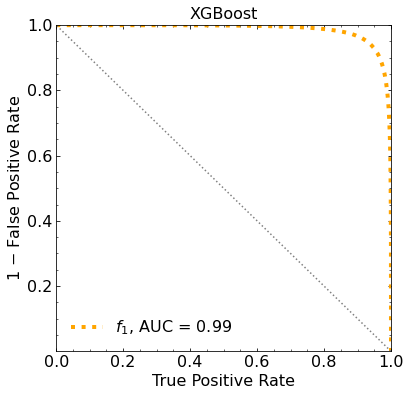

Classification score (1 ML):


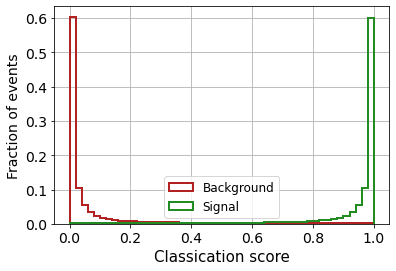

Classification score (10 ML):


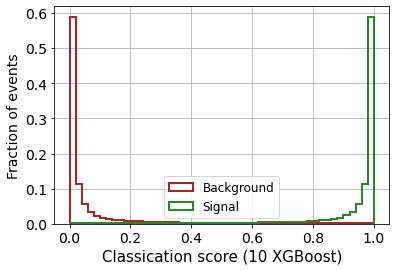

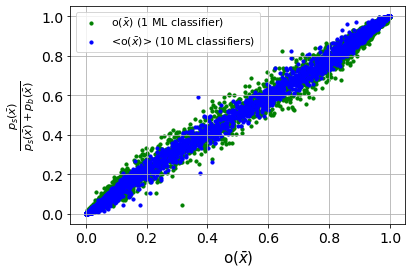


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  13.373078932585615
Z_XG 25 bins_1ML:  16.5223150745312
Z_XG 50 bins_1ML:  18.301846436630147
Z_XG 100 bins_1ML:  19.459481501535752

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  6.478816076957965
Z_XG 25 bins_eq_1ML:  9.32900399526326
Z_XG 50 bins_eq_1ML:  11.730651670900569
Z_XG 100 bins_eq_1ML:  14.117475426834762

 BL lineal bins, 10 ML
Z_XG 10 bins:  13.589251425241914
Z_XG 25 bins:  16.644046009295806
Z_XG 50 bins:  18.493333106596623
Z_XG 100 bins:  19.683094930330046

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  6.454836958327108
Z_XG 25 bins_eq:  9.298688689552204
Z_XG 50 bins_eq:  11.69879267314183
Z_XG 100 bins_eq:  14.069380521441362

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD (

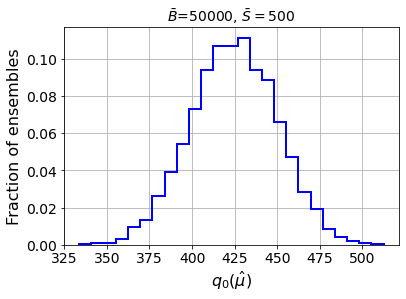

muhat mean:  0.0187823177532191
Z_gaussian:  20.607446198936376
Z_gaussian_mu0:  20.664290659618707

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf  9096.23755049  8935.98253487
  8732.0961529   8486.33594027  8193.95230171  7842.96227623
  7430.86014751  6954.75138711  6417.83344611  5801.93412276
  5097.37405439  4297.62786767  3402.25885657  2438.93558996
  1415.04591146   329.6914341   -777.63388371 -1876.16131037]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf  8850.61407112  8698.47701447
  8506.10946222  8266.59438507  7980.01062185  7643.09155278
  7243.36672676  6782.2565934   6259.62351178  5654.7571425
  496

KDE Kernel:  epanechnikov
Background bandwidth:  0.002094366253972675
Signal bandwidth:  0.002094366253972675


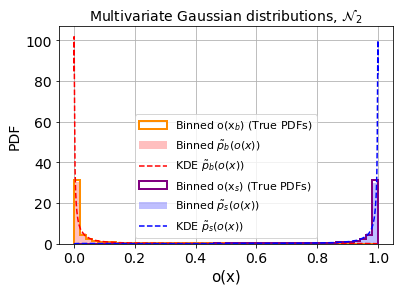

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf  8606.82405159
  8454.80928771  8261.11443171  8016.47609365  7710.17975737
  7335.91830947  6889.12148423  6368.04226736  5763.87568515
  5066.62242024  4268.30621551  3385.28787662  2433.22332891
  1412.66839166   335.3012018   -766.59818767 -1871.34952891]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf  8418.72209138
  8274.29722428  8082.76011823  7840.40665646  7541.40043966
  7172.46379043  6737.754536    6228.64740462  5624.38745492
  49

KDE Kernel:  epanechnikov
Background bandwidth:  0.003030951223220623
Signal bandwidth:  0.003030951223220623


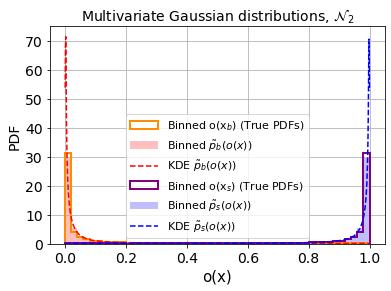

 Z MLL+KDE (1ML) 


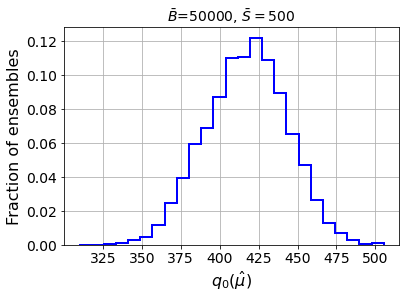

muhat mean_1ML:  0.01268883706782926
Z_KDE_1ML:  20.447464192679035
Z_KDE mu=0_1ML:  20.46251737051894

 Z MLL+KDE (10ML) 


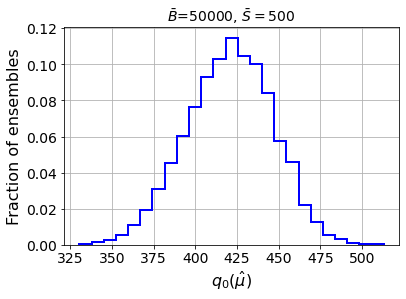

muhat mean:  0.009966541620196697
Z_KDE:  20.527092507570714
Z_KDE mu=0:  20.53933421030847

 ------------------------------------ 



In [18]:
dim=5

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3, signal_X_4, signal_X_5 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3, background_X_4, background_X_5 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T


dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))


# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML)


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP)


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [ ]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 6)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 6)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 6)
y_gauss_test :  (1000000, 1)



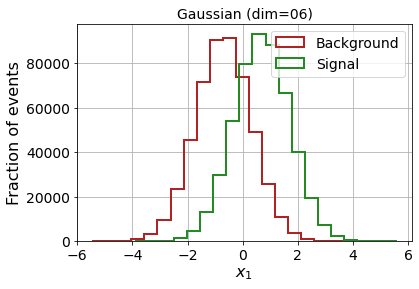

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62591	validation_1-logloss:0.62618
[1]	validation_0-logloss:0.56908	validation_1-logloss:0.56949
[2]	validation_0-logloss:0.52034	validation_1-logloss:0.52097
[3]	validation_0-logloss:0.47873	validation_1-logloss:0.47940
[4]	validation_0-logloss:0.44253	validation_1-logloss:0.44326
[5]	validation_0-logloss:0.41053	validation_1-logloss:0.41135
[6]	validation_0-logloss:0.38252	validation_1-logloss:0.38343
[7]	validation_0-logloss:0.35765	validation_1-logloss:0.35860
[8]	validation_0-logloss:0.33559	validation_1-logloss:0.33661
[9]	validation_0-logloss:0.31585	validation_1-logloss:0.31694
[10]	validation_0-logloss:0.29823	validation_1-logloss:0.29941
[11]	validation_0-logloss:0.28246	validation_1-logloss:0.28373
[12]	validation_0-logloss:0.26827	validation_1-logloss:0.26964
[13]	validation_0-logloss:0.25549	validation_1-logloss:0.25688
[14]	validation_0-logloss:0.24400	validation_1-logloss:0.24539
[15]	validation_0-logloss:0.23354	validation_1-logloss:0.23500
[1

[130]	validation_0-logloss:0.10910	validation_1-logloss:0.11294
[131]	validation_0-logloss:0.10907	validation_1-logloss:0.11292
[132]	validation_0-logloss:0.10904	validation_1-logloss:0.11290
[133]	validation_0-logloss:0.10901	validation_1-logloss:0.11288
[134]	validation_0-logloss:0.10899	validation_1-logloss:0.11287
[135]	validation_0-logloss:0.10896	validation_1-logloss:0.11286
[136]	validation_0-logloss:0.10893	validation_1-logloss:0.11284
[137]	validation_0-logloss:0.10890	validation_1-logloss:0.11283
[138]	validation_0-logloss:0.10888	validation_1-logloss:0.11282
[139]	validation_0-logloss:0.10886	validation_1-logloss:0.11281
[140]	validation_0-logloss:0.10884	validation_1-logloss:0.11280
[141]	validation_0-logloss:0.10881	validation_1-logloss:0.11278
[142]	validation_0-logloss:0.10880	validation_1-logloss:0.11277
[143]	validation_0-logloss:0.10878	validation_1-logloss:0.11276
[144]	validation_0-logloss:0.10876	validation_1-logloss:0.11275
[145]	validation_0-logloss:0.10874	valid

[259]	validation_0-logloss:0.10759	validation_1-logloss:0.11252
[260]	validation_0-logloss:0.10758	validation_1-logloss:0.11252
[261]	validation_0-logloss:0.10758	validation_1-logloss:0.11252
[262]	validation_0-logloss:0.10757	validation_1-logloss:0.11252
[263]	validation_0-logloss:0.10755	validation_1-logloss:0.11252
[264]	validation_0-logloss:0.10755	validation_1-logloss:0.11252
[265]	validation_0-logloss:0.10755	validation_1-logloss:0.11252
[266]	validation_0-logloss:0.10755	validation_1-logloss:0.11252
[267]	validation_0-logloss:0.10754	validation_1-logloss:0.11252
[268]	validation_0-logloss:0.10754	validation_1-logloss:0.11252
[269]	validation_0-logloss:0.10754	validation_1-logloss:0.11252
[270]	validation_0-logloss:0.10753	validation_1-logloss:0.11252
[271]	validation_0-logloss:0.10753	validation_1-logloss:0.11252
[272]	validation_0-logloss:0.10752	validation_1-logloss:0.11252
[273]	validation_0-logloss:0.10751	validation_1-logloss:0.11252
[274]	validation_0-logloss:0.10750	valid

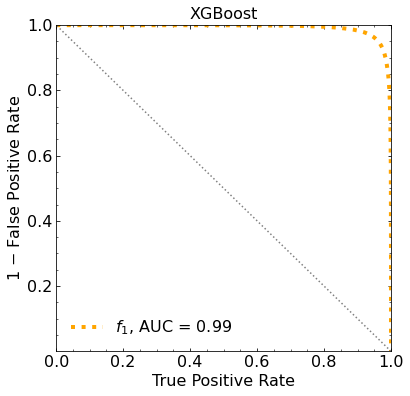

ML iteration 0


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62517	validation_1-logloss:0.62597
[1]	validation_0-logloss:0.56771	validation_1-logloss:0.56917
[2]	validation_0-logloss:0.51892	validation_1-logloss:0.52084
[3]	validation_0-logloss:0.47678	validation_1-logloss:0.47905
[4]	validation_0-logloss:0.44018	validation_1-logloss:0.44294
[5]	validation_0-logloss:0.40821	validation_1-logloss:0.41127
[6]	validation_0-logloss:0.37977	validation_1-logloss:0.38311
[7]	validation_0-logloss:0.35474	validation_1-logloss:0.35824
[8]	validation_0-logloss:0.33239	validation_1-logloss:0.33617
[9]	validation_0-logloss:0.31269	validation_1-logloss:0.31667
[10]	validation_0-logloss:0.29489	validation_1-logloss:0.29908
[11]	validation_0-logloss:0.27899	validation_1-logloss:0.28342
[12]	validation_0-logloss:0.26462	validation_1-logloss:0.26919
[13]	validation_0-logloss:0.25171	validation_1-logloss:0.25645
[14]	validation_0-logloss:0.24002	validation_1-logloss:0.24502
[15]	validation_0-logloss:0.22943	validation_1-logloss:0.23455
[1

[130]	validation_0-logloss:0.10004	validation_1-logloss:0.11484
[131]	validation_0-logloss:0.09997	validation_1-logloss:0.11484
[132]	validation_0-logloss:0.09990	validation_1-logloss:0.11483
[133]	validation_0-logloss:0.09986	validation_1-logloss:0.11482
[134]	validation_0-logloss:0.09977	validation_1-logloss:0.11481
[135]	validation_0-logloss:0.09973	validation_1-logloss:0.11479
[136]	validation_0-logloss:0.09967	validation_1-logloss:0.11478
[137]	validation_0-logloss:0.09963	validation_1-logloss:0.11476
[138]	validation_0-logloss:0.09960	validation_1-logloss:0.11475
[139]	validation_0-logloss:0.09957	validation_1-logloss:0.11475
[140]	validation_0-logloss:0.09954	validation_1-logloss:0.11475
[141]	validation_0-logloss:0.09948	validation_1-logloss:0.11474
[142]	validation_0-logloss:0.09945	validation_1-logloss:0.11474
[143]	validation_0-logloss:0.09937	validation_1-logloss:0.11474
[144]	validation_0-logloss:0.09923	validation_1-logloss:0.11474
[145]	validation_0-logloss:0.09915	valid

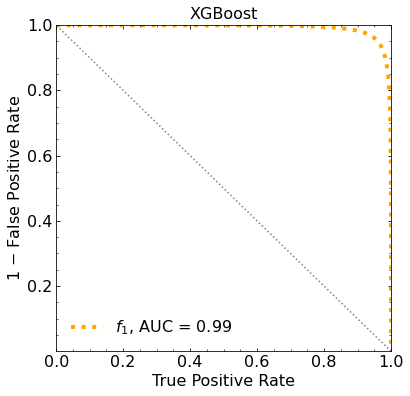

ML iteration  1


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62485	validation_1-logloss:0.62595
[1]	validation_0-logloss:0.56727	validation_1-logloss:0.56903
[2]	validation_0-logloss:0.51828	validation_1-logloss:0.52082
[3]	validation_0-logloss:0.47590	validation_1-logloss:0.47902
[4]	validation_0-logloss:0.43899	validation_1-logloss:0.44264
[5]	validation_0-logloss:0.40674	validation_1-logloss:0.41101
[6]	validation_0-logloss:0.37824	validation_1-logloss:0.38293
[7]	validation_0-logloss:0.35289	validation_1-logloss:0.35798
[8]	validation_0-logloss:0.33045	validation_1-logloss:0.33593
[9]	validation_0-logloss:0.31050	validation_1-logloss:0.31623
[10]	validation_0-logloss:0.29256	validation_1-logloss:0.29855
[11]	validation_0-logloss:0.27652	validation_1-logloss:0.28286
[12]	validation_0-logloss:0.26210	validation_1-logloss:0.26870
[13]	validation_0-logloss:0.24906	validation_1-logloss:0.25592
[14]	validation_0-logloss:0.23726	validation_1-logloss:0.24444
[15]	validation_0-logloss:0.22661	validation_1-logloss:0.23409
[1

[130]	validation_0-logloss:0.09614	validation_1-logloss:0.11499
[131]	validation_0-logloss:0.09601	validation_1-logloss:0.11498
[132]	validation_0-logloss:0.09595	validation_1-logloss:0.11498
[133]	validation_0-logloss:0.09590	validation_1-logloss:0.11496
[134]	validation_0-logloss:0.09584	validation_1-logloss:0.11496
[135]	validation_0-logloss:0.09579	validation_1-logloss:0.11495
[136]	validation_0-logloss:0.09574	validation_1-logloss:0.11495
[137]	validation_0-logloss:0.09570	validation_1-logloss:0.11494
[138]	validation_0-logloss:0.09556	validation_1-logloss:0.11494
[139]	validation_0-logloss:0.09551	validation_1-logloss:0.11493
[140]	validation_0-logloss:0.09543	validation_1-logloss:0.11493
[141]	validation_0-logloss:0.09540	validation_1-logloss:0.11492
[142]	validation_0-logloss:0.09531	validation_1-logloss:0.11492
[143]	validation_0-logloss:0.09523	validation_1-logloss:0.11491
[144]	validation_0-logloss:0.09515	validation_1-logloss:0.11491
[145]	validation_0-logloss:0.09506	valid

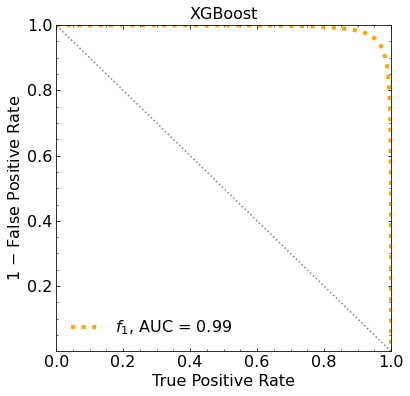

ML iteration  2


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62517	validation_1-logloss:0.62587
[1]	validation_0-logloss:0.56759	validation_1-logloss:0.56898
[2]	validation_0-logloss:0.51863	validation_1-logloss:0.52042
[3]	validation_0-logloss:0.47641	validation_1-logloss:0.47876
[4]	validation_0-logloss:0.43952	validation_1-logloss:0.44232
[5]	validation_0-logloss:0.40737	validation_1-logloss:0.41051
[6]	validation_0-logloss:0.37916	validation_1-logloss:0.38263
[7]	validation_0-logloss:0.35412	validation_1-logloss:0.35782
[8]	validation_0-logloss:0.33173	validation_1-logloss:0.33578
[9]	validation_0-logloss:0.31188	validation_1-logloss:0.31625
[10]	validation_0-logloss:0.29408	validation_1-logloss:0.29874
[11]	validation_0-logloss:0.27803	validation_1-logloss:0.28295
[12]	validation_0-logloss:0.26357	validation_1-logloss:0.26883
[13]	validation_0-logloss:0.25056	validation_1-logloss:0.25606
[14]	validation_0-logloss:0.23895	validation_1-logloss:0.24463
[15]	validation_0-logloss:0.22836	validation_1-logloss:0.23426
[1

[130]	validation_0-logloss:0.09756	validation_1-logloss:0.11490
[131]	validation_0-logloss:0.09747	validation_1-logloss:0.11489
[132]	validation_0-logloss:0.09744	validation_1-logloss:0.11488
[133]	validation_0-logloss:0.09737	validation_1-logloss:0.11486
[134]	validation_0-logloss:0.09734	validation_1-logloss:0.11486
[135]	validation_0-logloss:0.09730	validation_1-logloss:0.11485
[136]	validation_0-logloss:0.09721	validation_1-logloss:0.11485
[137]	validation_0-logloss:0.09714	validation_1-logloss:0.11484
[138]	validation_0-logloss:0.09709	validation_1-logloss:0.11484
[139]	validation_0-logloss:0.09705	validation_1-logloss:0.11483
[140]	validation_0-logloss:0.09698	validation_1-logloss:0.11484
[141]	validation_0-logloss:0.09697	validation_1-logloss:0.11484
[142]	validation_0-logloss:0.09685	validation_1-logloss:0.11485
[143]	validation_0-logloss:0.09681	validation_1-logloss:0.11485
[144]	validation_0-logloss:0.09675	validation_1-logloss:0.11485
[145]	validation_0-logloss:0.09661	valid

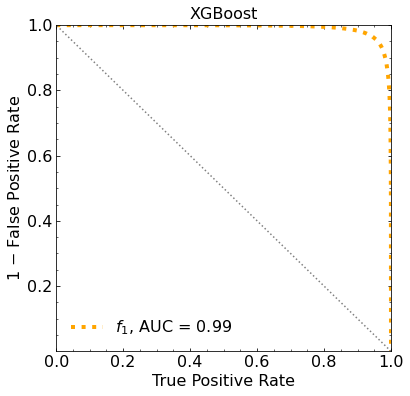

ML iteration  3


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62544	validation_1-logloss:0.62613
[1]	validation_0-logloss:0.56811	validation_1-logloss:0.56951
[2]	validation_0-logloss:0.51915	validation_1-logloss:0.52114
[3]	validation_0-logloss:0.47662	validation_1-logloss:0.47926
[4]	validation_0-logloss:0.43995	validation_1-logloss:0.44308
[5]	validation_0-logloss:0.40777	validation_1-logloss:0.41119
[6]	validation_0-logloss:0.37933	validation_1-logloss:0.38312
[7]	validation_0-logloss:0.35409	validation_1-logloss:0.35825
[8]	validation_0-logloss:0.33168	validation_1-logloss:0.33610
[9]	validation_0-logloss:0.31171	validation_1-logloss:0.31640
[10]	validation_0-logloss:0.29395	validation_1-logloss:0.29893
[11]	validation_0-logloss:0.27789	validation_1-logloss:0.28311
[12]	validation_0-logloss:0.26346	validation_1-logloss:0.26892
[13]	validation_0-logloss:0.25037	validation_1-logloss:0.25608
[14]	validation_0-logloss:0.23864	validation_1-logloss:0.24449
[15]	validation_0-logloss:0.22814	validation_1-logloss:0.23419
[1

[130]	validation_0-logloss:0.09739	validation_1-logloss:0.11506
[131]	validation_0-logloss:0.09725	validation_1-logloss:0.11504
[132]	validation_0-logloss:0.09719	validation_1-logloss:0.11504
[133]	validation_0-logloss:0.09713	validation_1-logloss:0.11504
[134]	validation_0-logloss:0.09708	validation_1-logloss:0.11503
[135]	validation_0-logloss:0.09706	validation_1-logloss:0.11501
[136]	validation_0-logloss:0.09699	validation_1-logloss:0.11501
[137]	validation_0-logloss:0.09695	validation_1-logloss:0.11501
[138]	validation_0-logloss:0.09685	validation_1-logloss:0.11501
[139]	validation_0-logloss:0.09682	validation_1-logloss:0.11500
[140]	validation_0-logloss:0.09679	validation_1-logloss:0.11501
[141]	validation_0-logloss:0.09673	validation_1-logloss:0.11501
[142]	validation_0-logloss:0.09671	validation_1-logloss:0.11500
[143]	validation_0-logloss:0.09664	validation_1-logloss:0.11500
[144]	validation_0-logloss:0.09656	validation_1-logloss:0.11499
[145]	validation_0-logloss:0.09646	valid

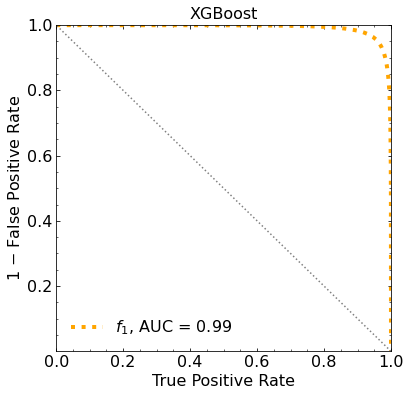

ML iteration  4


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62475	validation_1-logloss:0.62576
[1]	validation_0-logloss:0.56735	validation_1-logloss:0.56936
[2]	validation_0-logloss:0.51821	validation_1-logloss:0.52095
[3]	validation_0-logloss:0.47561	validation_1-logloss:0.47887
[4]	validation_0-logloss:0.43871	validation_1-logloss:0.44253
[5]	validation_0-logloss:0.40630	validation_1-logloss:0.41056
[6]	validation_0-logloss:0.37794	validation_1-logloss:0.38260
[7]	validation_0-logloss:0.35267	validation_1-logloss:0.35770
[8]	validation_0-logloss:0.33027	validation_1-logloss:0.33576
[9]	validation_0-logloss:0.31018	validation_1-logloss:0.31598
[10]	validation_0-logloss:0.29236	validation_1-logloss:0.29844
[11]	validation_0-logloss:0.27639	validation_1-logloss:0.28264
[12]	validation_0-logloss:0.26203	validation_1-logloss:0.26853
[13]	validation_0-logloss:0.24904	validation_1-logloss:0.25586
[14]	validation_0-logloss:0.23722	validation_1-logloss:0.24430
[15]	validation_0-logloss:0.22661	validation_1-logloss:0.23395
[1

[130]	validation_0-logloss:0.09595	validation_1-logloss:0.11488
[131]	validation_0-logloss:0.09589	validation_1-logloss:0.11488
[132]	validation_0-logloss:0.09587	validation_1-logloss:0.11487
[133]	validation_0-logloss:0.09577	validation_1-logloss:0.11486
[134]	validation_0-logloss:0.09574	validation_1-logloss:0.11486
[135]	validation_0-logloss:0.09569	validation_1-logloss:0.11485
[136]	validation_0-logloss:0.09560	validation_1-logloss:0.11485
[137]	validation_0-logloss:0.09554	validation_1-logloss:0.11484
[138]	validation_0-logloss:0.09552	validation_1-logloss:0.11483
[139]	validation_0-logloss:0.09546	validation_1-logloss:0.11483
[140]	validation_0-logloss:0.09537	validation_1-logloss:0.11484
[141]	validation_0-logloss:0.09532	validation_1-logloss:0.11483
[142]	validation_0-logloss:0.09527	validation_1-logloss:0.11482
[143]	validation_0-logloss:0.09523	validation_1-logloss:0.11482
[144]	validation_0-logloss:0.09520	validation_1-logloss:0.11481
[145]	validation_0-logloss:0.09514	valid

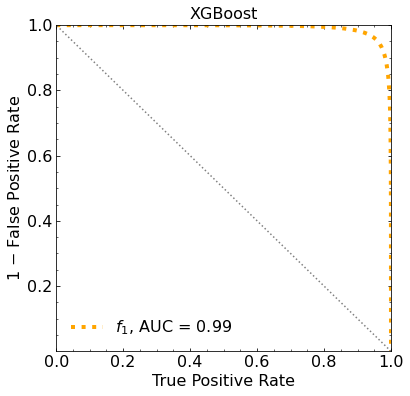

ML iteration  5
[0]	validation_0-logloss:0.62524	validation_1-logloss:0.62603


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.56783	validation_1-logloss:0.56950
[2]	validation_0-logloss:0.51868	validation_1-logloss:0.52092
[3]	validation_0-logloss:0.47667	validation_1-logloss:0.47936
[4]	validation_0-logloss:0.43981	validation_1-logloss:0.44295
[5]	validation_0-logloss:0.40765	validation_1-logloss:0.41109
[6]	validation_0-logloss:0.37942	validation_1-logloss:0.38321
[7]	validation_0-logloss:0.35420	validation_1-logloss:0.35841
[8]	validation_0-logloss:0.33196	validation_1-logloss:0.33642
[9]	validation_0-logloss:0.31204	validation_1-logloss:0.31666
[10]	validation_0-logloss:0.29425	validation_1-logloss:0.29908
[11]	validation_0-logloss:0.27824	validation_1-logloss:0.28329
[12]	validation_0-logloss:0.26390	validation_1-logloss:0.26919
[13]	validation_0-logloss:0.25083	validation_1-logloss:0.25638
[14]	validation_0-logloss:0.23903	validation_1-logloss:0.24480
[15]	validation_0-logloss:0.22846	validation_1-logloss:0.23442
[16]	validation_0-logloss:0.21874	validation_1-logloss:0.22496
[

[131]	validation_0-logloss:0.09752	validation_1-logloss:0.11482
[132]	validation_0-logloss:0.09749	validation_1-logloss:0.11483
[133]	validation_0-logloss:0.09742	validation_1-logloss:0.11482
[134]	validation_0-logloss:0.09735	validation_1-logloss:0.11481
[135]	validation_0-logloss:0.09732	validation_1-logloss:0.11481
[136]	validation_0-logloss:0.09728	validation_1-logloss:0.11481
[137]	validation_0-logloss:0.09720	validation_1-logloss:0.11480
[138]	validation_0-logloss:0.09717	validation_1-logloss:0.11479
[139]	validation_0-logloss:0.09713	validation_1-logloss:0.11479
[140]	validation_0-logloss:0.09708	validation_1-logloss:0.11479
[141]	validation_0-logloss:0.09705	validation_1-logloss:0.11478
[142]	validation_0-logloss:0.09700	validation_1-logloss:0.11479
[143]	validation_0-logloss:0.09689	validation_1-logloss:0.11479
[144]	validation_0-logloss:0.09684	validation_1-logloss:0.11478
[145]	validation_0-logloss:0.09682	validation_1-logloss:0.11478
[146]	validation_0-logloss:0.09678	valid

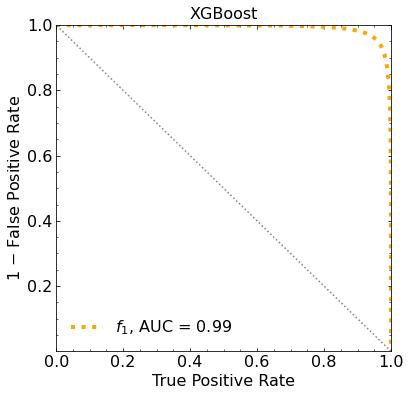

ML iteration  6


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62537	validation_1-logloss:0.62622
[1]	validation_0-logloss:0.56817	validation_1-logloss:0.56938
[2]	validation_0-logloss:0.51911	validation_1-logloss:0.52104
[3]	validation_0-logloss:0.47689	validation_1-logloss:0.47929
[4]	validation_0-logloss:0.44032	validation_1-logloss:0.44308
[5]	validation_0-logloss:0.40804	validation_1-logloss:0.41116
[6]	validation_0-logloss:0.37965	validation_1-logloss:0.38316
[7]	validation_0-logloss:0.35461	validation_1-logloss:0.35839
[8]	validation_0-logloss:0.33228	validation_1-logloss:0.33637
[9]	validation_0-logloss:0.31248	validation_1-logloss:0.31671
[10]	validation_0-logloss:0.29456	validation_1-logloss:0.29911
[11]	validation_0-logloss:0.27861	validation_1-logloss:0.28341
[12]	validation_0-logloss:0.26429	validation_1-logloss:0.26936
[13]	validation_0-logloss:0.25134	validation_1-logloss:0.25663
[14]	validation_0-logloss:0.23958	validation_1-logloss:0.24504
[15]	validation_0-logloss:0.22901	validation_1-logloss:0.23462
[1

[130]	validation_0-logloss:0.09865	validation_1-logloss:0.11511
[131]	validation_0-logloss:0.09855	validation_1-logloss:0.11510
[132]	validation_0-logloss:0.09853	validation_1-logloss:0.11509
[133]	validation_0-logloss:0.09844	validation_1-logloss:0.11508
[134]	validation_0-logloss:0.09834	validation_1-logloss:0.11508
[135]	validation_0-logloss:0.09831	validation_1-logloss:0.11507
[136]	validation_0-logloss:0.09828	validation_1-logloss:0.11506
[137]	validation_0-logloss:0.09821	validation_1-logloss:0.11506
[138]	validation_0-logloss:0.09816	validation_1-logloss:0.11505
[139]	validation_0-logloss:0.09806	validation_1-logloss:0.11505
[140]	validation_0-logloss:0.09803	validation_1-logloss:0.11504
[141]	validation_0-logloss:0.09792	validation_1-logloss:0.11505
[142]	validation_0-logloss:0.09785	validation_1-logloss:0.11505
[143]	validation_0-logloss:0.09773	validation_1-logloss:0.11505
[144]	validation_0-logloss:0.09769	validation_1-logloss:0.11505
[145]	validation_0-logloss:0.09764	valid

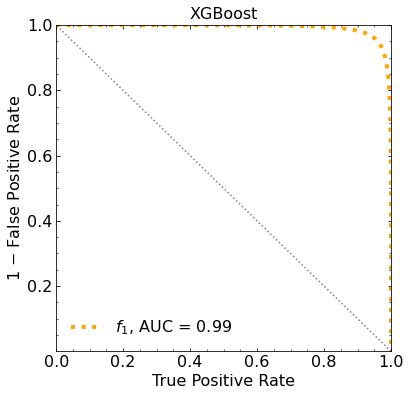

ML iteration  7


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62523	validation_1-logloss:0.62612
[1]	validation_0-logloss:0.56812	validation_1-logloss:0.56949
[2]	validation_0-logloss:0.51902	validation_1-logloss:0.52099
[3]	validation_0-logloss:0.47684	validation_1-logloss:0.47907
[4]	validation_0-logloss:0.44008	validation_1-logloss:0.44264
[5]	validation_0-logloss:0.40783	validation_1-logloss:0.41075
[6]	validation_0-logloss:0.37962	validation_1-logloss:0.38281
[7]	validation_0-logloss:0.35441	validation_1-logloss:0.35794
[8]	validation_0-logloss:0.33217	validation_1-logloss:0.33594
[9]	validation_0-logloss:0.31227	validation_1-logloss:0.31637
[10]	validation_0-logloss:0.29435	validation_1-logloss:0.29868
[11]	validation_0-logloss:0.27842	validation_1-logloss:0.28296
[12]	validation_0-logloss:0.26406	validation_1-logloss:0.26883
[13]	validation_0-logloss:0.25118	validation_1-logloss:0.25609
[14]	validation_0-logloss:0.23945	validation_1-logloss:0.24466
[15]	validation_0-logloss:0.22888	validation_1-logloss:0.23426
[1

[130]	validation_0-logloss:0.09781	validation_1-logloss:0.11467
[131]	validation_0-logloss:0.09777	validation_1-logloss:0.11466
[132]	validation_0-logloss:0.09773	validation_1-logloss:0.11466
[133]	validation_0-logloss:0.09768	validation_1-logloss:0.11465
[134]	validation_0-logloss:0.09757	validation_1-logloss:0.11464
[135]	validation_0-logloss:0.09747	validation_1-logloss:0.11464
[136]	validation_0-logloss:0.09744	validation_1-logloss:0.11464
[137]	validation_0-logloss:0.09738	validation_1-logloss:0.11464
[138]	validation_0-logloss:0.09731	validation_1-logloss:0.11464
[139]	validation_0-logloss:0.09723	validation_1-logloss:0.11463
[140]	validation_0-logloss:0.09718	validation_1-logloss:0.11462
[141]	validation_0-logloss:0.09716	validation_1-logloss:0.11461
[142]	validation_0-logloss:0.09706	validation_1-logloss:0.11461
[143]	validation_0-logloss:0.09703	validation_1-logloss:0.11460
[144]	validation_0-logloss:0.09696	validation_1-logloss:0.11461
[145]	validation_0-logloss:0.09692	valid

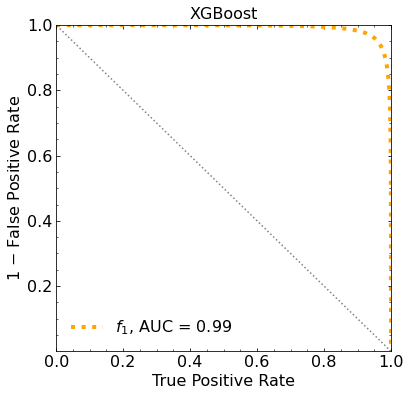

ML iteration  8


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62483	validation_1-logloss:0.62567
[1]	validation_0-logloss:0.56717	validation_1-logloss:0.56891
[2]	validation_0-logloss:0.51799	validation_1-logloss:0.52033
[3]	validation_0-logloss:0.47568	validation_1-logloss:0.47871
[4]	validation_0-logloss:0.43884	validation_1-logloss:0.44240
[5]	validation_0-logloss:0.40671	validation_1-logloss:0.41070
[6]	validation_0-logloss:0.37816	validation_1-logloss:0.38245
[7]	validation_0-logloss:0.35295	validation_1-logloss:0.35769
[8]	validation_0-logloss:0.33068	validation_1-logloss:0.33576
[9]	validation_0-logloss:0.31069	validation_1-logloss:0.31615
[10]	validation_0-logloss:0.29280	validation_1-logloss:0.29853
[11]	validation_0-logloss:0.27670	validation_1-logloss:0.28271
[12]	validation_0-logloss:0.26233	validation_1-logloss:0.26858
[13]	validation_0-logloss:0.24935	validation_1-logloss:0.25584
[14]	validation_0-logloss:0.23759	validation_1-logloss:0.24433
[15]	validation_0-logloss:0.22688	validation_1-logloss:0.23389
[1

[130]	validation_0-logloss:0.09547	validation_1-logloss:0.11494
[131]	validation_0-logloss:0.09539	validation_1-logloss:0.11493
[132]	validation_0-logloss:0.09533	validation_1-logloss:0.11493
[133]	validation_0-logloss:0.09526	validation_1-logloss:0.11492
[134]	validation_0-logloss:0.09521	validation_1-logloss:0.11491
[135]	validation_0-logloss:0.09515	validation_1-logloss:0.11491
[136]	validation_0-logloss:0.09503	validation_1-logloss:0.11490
[137]	validation_0-logloss:0.09500	validation_1-logloss:0.11490
[138]	validation_0-logloss:0.09498	validation_1-logloss:0.11490
[139]	validation_0-logloss:0.09495	validation_1-logloss:0.11489
[140]	validation_0-logloss:0.09486	validation_1-logloss:0.11489
[141]	validation_0-logloss:0.09476	validation_1-logloss:0.11489
[142]	validation_0-logloss:0.09466	validation_1-logloss:0.11489
[143]	validation_0-logloss:0.09456	validation_1-logloss:0.11488
[144]	validation_0-logloss:0.09453	validation_1-logloss:0.11488
[145]	validation_0-logloss:0.09449	valid

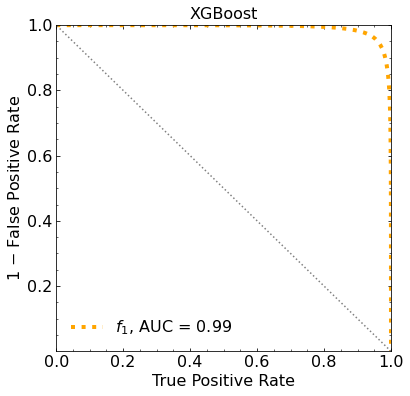

ML iteration  9


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62495	validation_1-logloss:0.62599
[1]	validation_0-logloss:0.56754	validation_1-logloss:0.56917
[2]	validation_0-logloss:0.51855	validation_1-logloss:0.52084
[3]	validation_0-logloss:0.47604	validation_1-logloss:0.47884
[4]	validation_0-logloss:0.43911	validation_1-logloss:0.44247
[5]	validation_0-logloss:0.40678	validation_1-logloss:0.41061
[6]	validation_0-logloss:0.37833	validation_1-logloss:0.38260
[7]	validation_0-logloss:0.35329	validation_1-logloss:0.35783
[8]	validation_0-logloss:0.33103	validation_1-logloss:0.33584
[9]	validation_0-logloss:0.31107	validation_1-logloss:0.31620
[10]	validation_0-logloss:0.29323	validation_1-logloss:0.29869
[11]	validation_0-logloss:0.27718	validation_1-logloss:0.28287
[12]	validation_0-logloss:0.26282	validation_1-logloss:0.26871
[13]	validation_0-logloss:0.24988	validation_1-logloss:0.25603
[14]	validation_0-logloss:0.23828	validation_1-logloss:0.24464
[15]	validation_0-logloss:0.22775	validation_1-logloss:0.23427
[1

[130]	validation_0-logloss:0.09840	validation_1-logloss:0.11517
[131]	validation_0-logloss:0.09834	validation_1-logloss:0.11517
[132]	validation_0-logloss:0.09827	validation_1-logloss:0.11517
[133]	validation_0-logloss:0.09816	validation_1-logloss:0.11516
[134]	validation_0-logloss:0.09813	validation_1-logloss:0.11514
[135]	validation_0-logloss:0.09808	validation_1-logloss:0.11513
[136]	validation_0-logloss:0.09798	validation_1-logloss:0.11511
[137]	validation_0-logloss:0.09795	validation_1-logloss:0.11510
[138]	validation_0-logloss:0.09789	validation_1-logloss:0.11508
[139]	validation_0-logloss:0.09788	validation_1-logloss:0.11508
[140]	validation_0-logloss:0.09783	validation_1-logloss:0.11507
[141]	validation_0-logloss:0.09775	validation_1-logloss:0.11507
[142]	validation_0-logloss:0.09767	validation_1-logloss:0.11507
[143]	validation_0-logloss:0.09765	validation_1-logloss:0.11507
[144]	validation_0-logloss:0.09762	validation_1-logloss:0.11507
[145]	validation_0-logloss:0.09760	valid

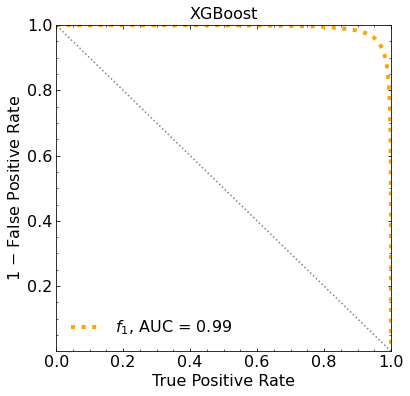

Classification score (1 ML):


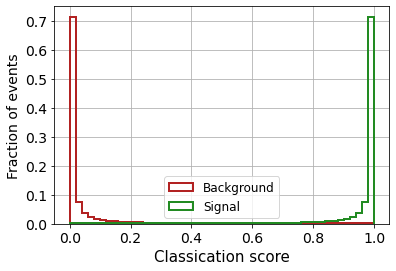

Classification score (10 ML):


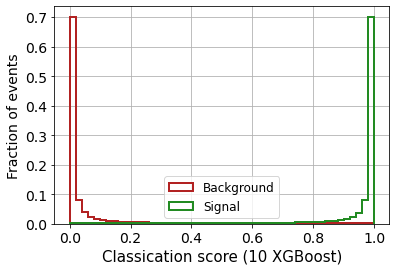

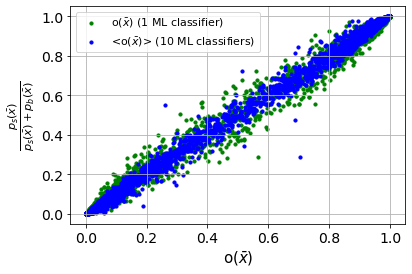


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  15.294967118315293
Z_XG 25 bins_1ML:  18.42540329202467
Z_XG 50 bins_1ML:  20.32621475907388
Z_XG 100 bins_1ML:  21.57979971910179

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  6.180809258532996
Z_XG 25 bins_eq_1ML:  9.08773897375027
Z_XG 50 bins_eq_1ML:  11.670369228142292
Z_XG 100 bins_eq_1ML:  14.270124919944267

 BL lineal bins, 10 ML
Z_XG 10 bins:  15.5895369982379
Z_XG 25 bins:  18.71762500573058
Z_XG 50 bins:  20.683145804376146
Z_XG 100 bins:  21.844387450443588

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  6.2891279323799845
Z_XG 25 bins_eq:  9.256101105966524
Z_XG 50 bins_eq:  11.882449608803354
Z_XG 100 bins_eq:  14.536098676987535

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD (GA

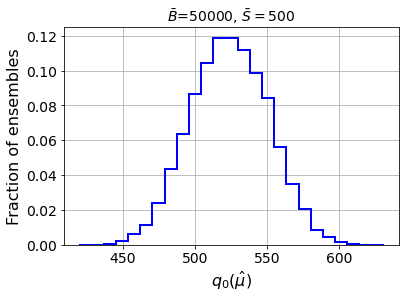

muhat mean:  0.02172766906620703
Z_gaussian:  22.89293580712699
Z_gaussian_mu0:  22.981333106387453

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 10628.0001361  10255.46744912  9821.77901705  9323.58628673
  8762.15936581  8125.3283732   7407.80026399  6618.60908873
  5759.43872197  4828.13941402  3828.5816385   2772.97755226
  1665.97006406   514.45314545  -656.52247288 -1822.16788412]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf 10978.78780131
 10669.80889362 10291.63806349  9851.98710474  9347.09848434
  8773.23163192  8130.73767772  7399.14691942  6594.24241851
  57

KDE Kernel:  epanechnikov
Background bandwidth:  0.004386370005779536
Signal bandwidth:  0.003030951223220623


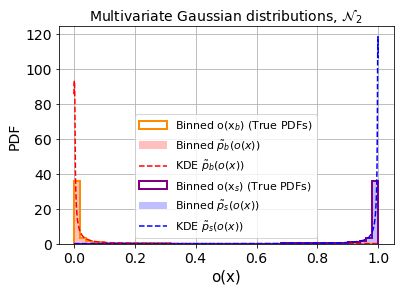

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf 10572.19159587
 10307.73885365  9986.25405133  9601.67760978  9146.10916753
  8608.87312474  7993.70916371  7301.96343592  6536.4933636
  5688.93222092  4767.90497596  3785.96495634  2746.05261803
  1660.97499985   520.94432017  -644.02072074 -1817.40319355]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf 10585.52537534
 10332.90470355 10016.70922284  9628.45295222  9164.93950296
  8622.14454868  8005.52687404  7305.39465605  6523.44720611
  567

KDE Kernel:  epanechnikov
Background bandwidth:  0.003030951223220623
Signal bandwidth:  0.003030951223220623


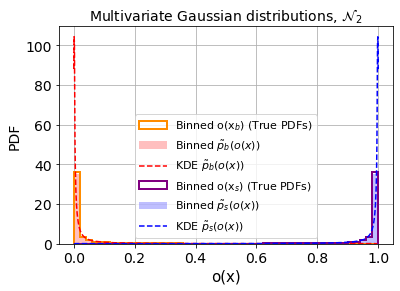

 Z MLL+KDE (1ML) 


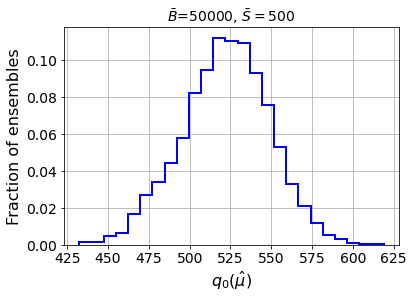

muhat mean_1ML:  0.006083341782419142
Z_KDE_1ML:  22.869140897412457
Z_KDE mu=0_1ML:  22.870408652951337

 Z MLL+KDE (10ML) 


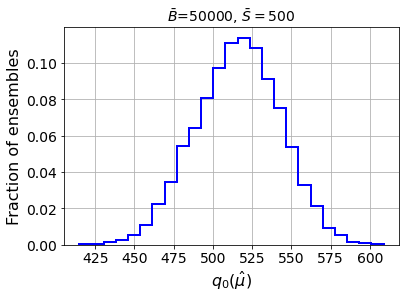

muhat mean:  0.0088766095508466
Z_KDE:  22.732401718417155
Z_KDE mu=0:  22.738653891620334

 ------------------------------------ 



In [19]:
dim=6

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3, signal_X_4, signal_X_5, signal_X_6 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3, background_X_4, background_X_5, background_X_6 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T


dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))
dim6 = np.concatenate((background_X_6,signal_X_6))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['dim6'] = dim6.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5','dim6']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML)


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP)


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [ ]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 7)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 7)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 7)
y_gauss_test :  (1000000, 1)



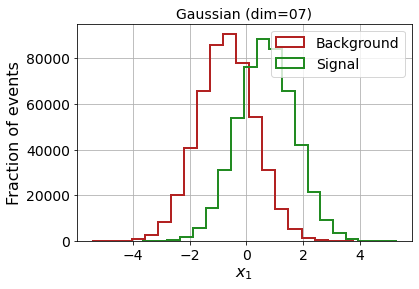

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62584	validation_1-logloss:0.62609
[1]	validation_0-logloss:0.56849	validation_1-logloss:0.56891
[2]	validation_0-logloss:0.51960	validation_1-logloss:0.52009
[3]	validation_0-logloss:0.47719	validation_1-logloss:0.47782
[4]	validation_0-logloss:0.43999	validation_1-logloss:0.44071
[5]	validation_0-logloss:0.40734	validation_1-logloss:0.40810
[6]	validation_0-logloss:0.37847	validation_1-logloss:0.37930
[7]	validation_0-logloss:0.35285	validation_1-logloss:0.35369
[8]	validation_0-logloss:0.33003	validation_1-logloss:0.33088
[9]	validation_0-logloss:0.30955	validation_1-logloss:0.31043
[10]	validation_0-logloss:0.29121	validation_1-logloss:0.29214
[11]	validation_0-logloss:0.27466	validation_1-logloss:0.27563
[12]	validation_0-logloss:0.25969	validation_1-logloss:0.26068
[13]	validation_0-logloss:0.24618	validation_1-logloss:0.24718
[14]	validation_0-logloss:0.23392	validation_1-logloss:0.23494
[15]	validation_0-logloss:0.22278	validation_1-logloss:0.22384
[1

[130]	validation_0-logloss:0.08265	validation_1-logloss:0.08536
[131]	validation_0-logloss:0.08261	validation_1-logloss:0.08533
[132]	validation_0-logloss:0.08256	validation_1-logloss:0.08530
[133]	validation_0-logloss:0.08253	validation_1-logloss:0.08527
[134]	validation_0-logloss:0.08249	validation_1-logloss:0.08524
[135]	validation_0-logloss:0.08245	validation_1-logloss:0.08521
[136]	validation_0-logloss:0.08241	validation_1-logloss:0.08519
[137]	validation_0-logloss:0.08236	validation_1-logloss:0.08516
[138]	validation_0-logloss:0.08232	validation_1-logloss:0.08513
[139]	validation_0-logloss:0.08229	validation_1-logloss:0.08511
[140]	validation_0-logloss:0.08227	validation_1-logloss:0.08510
[141]	validation_0-logloss:0.08223	validation_1-logloss:0.08507
[142]	validation_0-logloss:0.08220	validation_1-logloss:0.08505
[143]	validation_0-logloss:0.08217	validation_1-logloss:0.08503
[144]	validation_0-logloss:0.08214	validation_1-logloss:0.08500
[145]	validation_0-logloss:0.08211	valid

[259]	validation_0-logloss:0.08045	validation_1-logloss:0.08444
[260]	validation_0-logloss:0.08045	validation_1-logloss:0.08444
[261]	validation_0-logloss:0.08044	validation_1-logloss:0.08444
[262]	validation_0-logloss:0.08043	validation_1-logloss:0.08444
[263]	validation_0-logloss:0.08042	validation_1-logloss:0.08444
[264]	validation_0-logloss:0.08042	validation_1-logloss:0.08444
[265]	validation_0-logloss:0.08041	validation_1-logloss:0.08444
[266]	validation_0-logloss:0.08040	validation_1-logloss:0.08444
[267]	validation_0-logloss:0.08039	validation_1-logloss:0.08444
[268]	validation_0-logloss:0.08039	validation_1-logloss:0.08444
[269]	validation_0-logloss:0.08038	validation_1-logloss:0.08444
[270]	validation_0-logloss:0.08037	validation_1-logloss:0.08443
[271]	validation_0-logloss:0.08037	validation_1-logloss:0.08444
[272]	validation_0-logloss:0.08036	validation_1-logloss:0.08444
[273]	validation_0-logloss:0.08034	validation_1-logloss:0.08444
[274]	validation_0-logloss:0.08034	valid

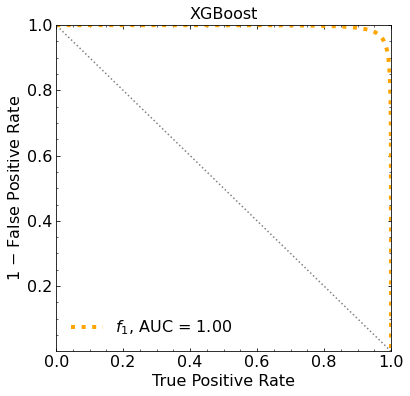

ML iteration 0


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62504	validation_1-logloss:0.62594
[1]	validation_0-logloss:0.56717	validation_1-logloss:0.56899
[2]	validation_0-logloss:0.51743	validation_1-logloss:0.51986
[3]	validation_0-logloss:0.47449	validation_1-logloss:0.47756
[4]	validation_0-logloss:0.43676	validation_1-logloss:0.44027
[5]	validation_0-logloss:0.40396	validation_1-logloss:0.40780
[6]	validation_0-logloss:0.37469	validation_1-logloss:0.37874
[7]	validation_0-logloss:0.34881	validation_1-logloss:0.35317
[8]	validation_0-logloss:0.32566	validation_1-logloss:0.33030
[9]	validation_0-logloss:0.30491	validation_1-logloss:0.30981
[10]	validation_0-logloss:0.28626	validation_1-logloss:0.29145
[11]	validation_0-logloss:0.26943	validation_1-logloss:0.27482
[12]	validation_0-logloss:0.25426	validation_1-logloss:0.25992
[13]	validation_0-logloss:0.24055	validation_1-logloss:0.24635
[14]	validation_0-logloss:0.22810	validation_1-logloss:0.23413
[15]	validation_0-logloss:0.21681	validation_1-logloss:0.22303
[1

[130]	validation_0-logloss:0.07128	validation_1-logloss:0.08697
[131]	validation_0-logloss:0.07117	validation_1-logloss:0.08695
[132]	validation_0-logloss:0.07113	validation_1-logloss:0.08692
[133]	validation_0-logloss:0.07106	validation_1-logloss:0.08691
[134]	validation_0-logloss:0.07100	validation_1-logloss:0.08689
[135]	validation_0-logloss:0.07093	validation_1-logloss:0.08688
[136]	validation_0-logloss:0.07088	validation_1-logloss:0.08686
[137]	validation_0-logloss:0.07079	validation_1-logloss:0.08684
[138]	validation_0-logloss:0.07073	validation_1-logloss:0.08682
[139]	validation_0-logloss:0.07067	validation_1-logloss:0.08681
[140]	validation_0-logloss:0.07060	validation_1-logloss:0.08679
[141]	validation_0-logloss:0.07054	validation_1-logloss:0.08678
[142]	validation_0-logloss:0.07046	validation_1-logloss:0.08679
[143]	validation_0-logloss:0.07041	validation_1-logloss:0.08678
[144]	validation_0-logloss:0.07038	validation_1-logloss:0.08676
[145]	validation_0-logloss:0.07033	valid

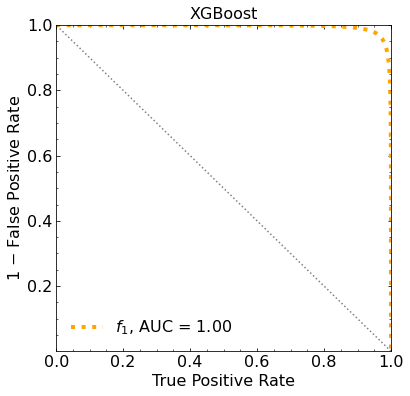

ML iteration  1


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62486	validation_1-logloss:0.62592
[1]	validation_0-logloss:0.56703	validation_1-logloss:0.56880
[2]	validation_0-logloss:0.51741	validation_1-logloss:0.51981
[3]	validation_0-logloss:0.47427	validation_1-logloss:0.47734
[4]	validation_0-logloss:0.43688	validation_1-logloss:0.44022
[5]	validation_0-logloss:0.40384	validation_1-logloss:0.40761
[6]	validation_0-logloss:0.37469	validation_1-logloss:0.37873
[7]	validation_0-logloss:0.34899	validation_1-logloss:0.35319
[8]	validation_0-logloss:0.32586	validation_1-logloss:0.33024
[9]	validation_0-logloss:0.30513	validation_1-logloss:0.30972
[10]	validation_0-logloss:0.28662	validation_1-logloss:0.29144
[11]	validation_0-logloss:0.26999	validation_1-logloss:0.27502
[12]	validation_0-logloss:0.25495	validation_1-logloss:0.26013
[13]	validation_0-logloss:0.24128	validation_1-logloss:0.24662
[14]	validation_0-logloss:0.22892	validation_1-logloss:0.23443
[15]	validation_0-logloss:0.21770	validation_1-logloss:0.22335
[1

[130]	validation_0-logloss:0.07247	validation_1-logloss:0.08753
[131]	validation_0-logloss:0.07240	validation_1-logloss:0.08751
[132]	validation_0-logloss:0.07229	validation_1-logloss:0.08750
[133]	validation_0-logloss:0.07220	validation_1-logloss:0.08749
[134]	validation_0-logloss:0.07217	validation_1-logloss:0.08747
[135]	validation_0-logloss:0.07207	validation_1-logloss:0.08747
[136]	validation_0-logloss:0.07203	validation_1-logloss:0.08745
[137]	validation_0-logloss:0.07192	validation_1-logloss:0.08743
[138]	validation_0-logloss:0.07188	validation_1-logloss:0.08741
[139]	validation_0-logloss:0.07176	validation_1-logloss:0.08741
[140]	validation_0-logloss:0.07168	validation_1-logloss:0.08740
[141]	validation_0-logloss:0.07165	validation_1-logloss:0.08739
[142]	validation_0-logloss:0.07161	validation_1-logloss:0.08738
[143]	validation_0-logloss:0.07152	validation_1-logloss:0.08736
[144]	validation_0-logloss:0.07145	validation_1-logloss:0.08736
[145]	validation_0-logloss:0.07138	valid

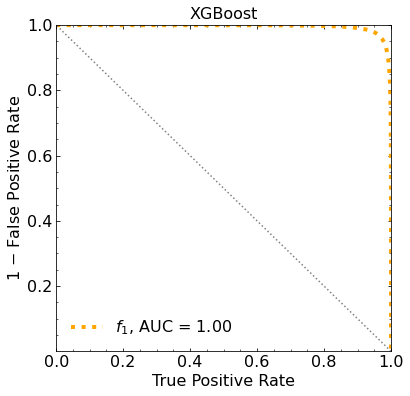

ML iteration  2


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62491	validation_1-logloss:0.62569
[1]	validation_0-logloss:0.56725	validation_1-logloss:0.56879
[2]	validation_0-logloss:0.51755	validation_1-logloss:0.51958
[3]	validation_0-logloss:0.47473	validation_1-logloss:0.47731
[4]	validation_0-logloss:0.43738	validation_1-logloss:0.44019
[5]	validation_0-logloss:0.40444	validation_1-logloss:0.40756
[6]	validation_0-logloss:0.37527	validation_1-logloss:0.37882
[7]	validation_0-logloss:0.34943	validation_1-logloss:0.35328
[8]	validation_0-logloss:0.32621	validation_1-logloss:0.33041
[9]	validation_0-logloss:0.30537	validation_1-logloss:0.30983
[10]	validation_0-logloss:0.28684	validation_1-logloss:0.29155
[11]	validation_0-logloss:0.27018	validation_1-logloss:0.27499
[12]	validation_0-logloss:0.25500	validation_1-logloss:0.25999
[13]	validation_0-logloss:0.24138	validation_1-logloss:0.24667
[14]	validation_0-logloss:0.22895	validation_1-logloss:0.23428
[15]	validation_0-logloss:0.21759	validation_1-logloss:0.22314
[1

[130]	validation_0-logloss:0.07178	validation_1-logloss:0.08707
[131]	validation_0-logloss:0.07166	validation_1-logloss:0.08705
[132]	validation_0-logloss:0.07154	validation_1-logloss:0.08703
[133]	validation_0-logloss:0.07149	validation_1-logloss:0.08701
[134]	validation_0-logloss:0.07142	validation_1-logloss:0.08699
[135]	validation_0-logloss:0.07136	validation_1-logloss:0.08698
[136]	validation_0-logloss:0.07130	validation_1-logloss:0.08695
[137]	validation_0-logloss:0.07121	validation_1-logloss:0.08695
[138]	validation_0-logloss:0.07115	validation_1-logloss:0.08694
[139]	validation_0-logloss:0.07109	validation_1-logloss:0.08692
[140]	validation_0-logloss:0.07105	validation_1-logloss:0.08692
[141]	validation_0-logloss:0.07096	validation_1-logloss:0.08691
[142]	validation_0-logloss:0.07089	validation_1-logloss:0.08690
[143]	validation_0-logloss:0.07085	validation_1-logloss:0.08688
[144]	validation_0-logloss:0.07081	validation_1-logloss:0.08688
[145]	validation_0-logloss:0.07077	valid

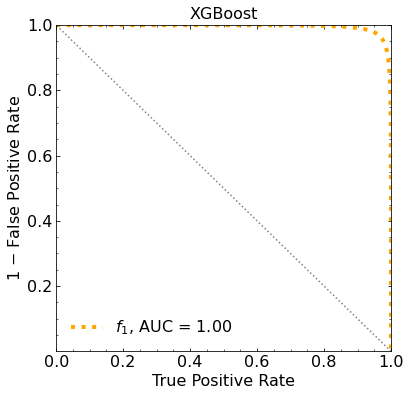

ML iteration  3


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62474	validation_1-logloss:0.62548
[1]	validation_0-logloss:0.56720	validation_1-logloss:0.56865
[2]	validation_0-logloss:0.51755	validation_1-logloss:0.51981
[3]	validation_0-logloss:0.47446	validation_1-logloss:0.47719
[4]	validation_0-logloss:0.43707	validation_1-logloss:0.44032
[5]	validation_0-logloss:0.40425	validation_1-logloss:0.40782
[6]	validation_0-logloss:0.37510	validation_1-logloss:0.37896
[7]	validation_0-logloss:0.34911	validation_1-logloss:0.35329
[8]	validation_0-logloss:0.32597	validation_1-logloss:0.33038
[9]	validation_0-logloss:0.30529	validation_1-logloss:0.30988
[10]	validation_0-logloss:0.28681	validation_1-logloss:0.29148
[11]	validation_0-logloss:0.26993	validation_1-logloss:0.27491
[12]	validation_0-logloss:0.25494	validation_1-logloss:0.26008
[13]	validation_0-logloss:0.24132	validation_1-logloss:0.24663
[14]	validation_0-logloss:0.22890	validation_1-logloss:0.23440
[15]	validation_0-logloss:0.21758	validation_1-logloss:0.22319
[1

[130]	validation_0-logloss:0.07156	validation_1-logloss:0.08701
[131]	validation_0-logloss:0.07146	validation_1-logloss:0.08699
[132]	validation_0-logloss:0.07140	validation_1-logloss:0.08698
[133]	validation_0-logloss:0.07132	validation_1-logloss:0.08697
[134]	validation_0-logloss:0.07129	validation_1-logloss:0.08695
[135]	validation_0-logloss:0.07122	validation_1-logloss:0.08694
[136]	validation_0-logloss:0.07115	validation_1-logloss:0.08693
[137]	validation_0-logloss:0.07107	validation_1-logloss:0.08691
[138]	validation_0-logloss:0.07097	validation_1-logloss:0.08689
[139]	validation_0-logloss:0.07091	validation_1-logloss:0.08689
[140]	validation_0-logloss:0.07087	validation_1-logloss:0.08688
[141]	validation_0-logloss:0.07084	validation_1-logloss:0.08688
[142]	validation_0-logloss:0.07076	validation_1-logloss:0.08686
[143]	validation_0-logloss:0.07070	validation_1-logloss:0.08686
[144]	validation_0-logloss:0.07061	validation_1-logloss:0.08685
[145]	validation_0-logloss:0.07059	valid

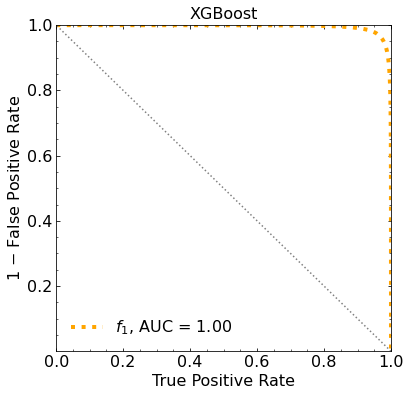

ML iteration  4


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62457	validation_1-logloss:0.62559
[1]	validation_0-logloss:0.56662	validation_1-logloss:0.56828
[2]	validation_0-logloss:0.51718	validation_1-logloss:0.51952
[3]	validation_0-logloss:0.47419	validation_1-logloss:0.47711
[4]	validation_0-logloss:0.43655	validation_1-logloss:0.43987
[5]	validation_0-logloss:0.40362	validation_1-logloss:0.40754
[6]	validation_0-logloss:0.37424	validation_1-logloss:0.37858
[7]	validation_0-logloss:0.34823	validation_1-logloss:0.35285
[8]	validation_0-logloss:0.32510	validation_1-logloss:0.33009
[9]	validation_0-logloss:0.30442	validation_1-logloss:0.30963
[10]	validation_0-logloss:0.28593	validation_1-logloss:0.29139
[11]	validation_0-logloss:0.26907	validation_1-logloss:0.27476
[12]	validation_0-logloss:0.25394	validation_1-logloss:0.25981
[13]	validation_0-logloss:0.24024	validation_1-logloss:0.24630
[14]	validation_0-logloss:0.22783	validation_1-logloss:0.23409
[15]	validation_0-logloss:0.21649	validation_1-logloss:0.22293
[1

[130]	validation_0-logloss:0.07037	validation_1-logloss:0.08715
[131]	validation_0-logloss:0.07032	validation_1-logloss:0.08712
[132]	validation_0-logloss:0.07026	validation_1-logloss:0.08711
[133]	validation_0-logloss:0.07018	validation_1-logloss:0.08707
[134]	validation_0-logloss:0.07010	validation_1-logloss:0.08706
[135]	validation_0-logloss:0.06993	validation_1-logloss:0.08705
[136]	validation_0-logloss:0.06985	validation_1-logloss:0.08703
[137]	validation_0-logloss:0.06978	validation_1-logloss:0.08703
[138]	validation_0-logloss:0.06971	validation_1-logloss:0.08702
[139]	validation_0-logloss:0.06965	validation_1-logloss:0.08701
[140]	validation_0-logloss:0.06959	validation_1-logloss:0.08699
[141]	validation_0-logloss:0.06955	validation_1-logloss:0.08698
[142]	validation_0-logloss:0.06950	validation_1-logloss:0.08698
[143]	validation_0-logloss:0.06942	validation_1-logloss:0.08696
[144]	validation_0-logloss:0.06938	validation_1-logloss:0.08696
[145]	validation_0-logloss:0.06932	valid

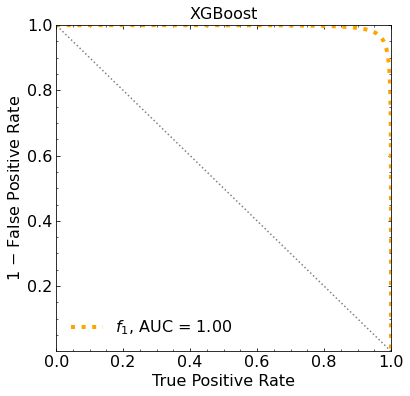

ML iteration  5
[0]	validation_0-logloss:0.62475	validation_1-logloss:0.62563


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.56689	validation_1-logloss:0.56860
[2]	validation_0-logloss:0.51719	validation_1-logloss:0.51963
[3]	validation_0-logloss:0.47400	validation_1-logloss:0.47702
[4]	validation_0-logloss:0.43653	validation_1-logloss:0.43999
[5]	validation_0-logloss:0.40351	validation_1-logloss:0.40742
[6]	validation_0-logloss:0.37436	validation_1-logloss:0.37861
[7]	validation_0-logloss:0.34836	validation_1-logloss:0.35306
[8]	validation_0-logloss:0.32510	validation_1-logloss:0.33011
[9]	validation_0-logloss:0.30436	validation_1-logloss:0.30959
[10]	validation_0-logloss:0.28574	validation_1-logloss:0.29126
[11]	validation_0-logloss:0.26892	validation_1-logloss:0.27469
[12]	validation_0-logloss:0.25365	validation_1-logloss:0.25967
[13]	validation_0-logloss:0.23990	validation_1-logloss:0.24605
[14]	validation_0-logloss:0.22748	validation_1-logloss:0.23388
[15]	validation_0-logloss:0.21622	validation_1-logloss:0.22277
[16]	validation_0-logloss:0.20589	validation_1-logloss:0.21265
[

[131]	validation_0-logloss:0.07027	validation_1-logloss:0.08703
[132]	validation_0-logloss:0.07022	validation_1-logloss:0.08702
[133]	validation_0-logloss:0.07015	validation_1-logloss:0.08700
[134]	validation_0-logloss:0.07008	validation_1-logloss:0.08700
[135]	validation_0-logloss:0.07002	validation_1-logloss:0.08699
[136]	validation_0-logloss:0.06999	validation_1-logloss:0.08697
[137]	validation_0-logloss:0.06995	validation_1-logloss:0.08696
[138]	validation_0-logloss:0.06989	validation_1-logloss:0.08696
[139]	validation_0-logloss:0.06981	validation_1-logloss:0.08695
[140]	validation_0-logloss:0.06973	validation_1-logloss:0.08692
[141]	validation_0-logloss:0.06966	validation_1-logloss:0.08692
[142]	validation_0-logloss:0.06960	validation_1-logloss:0.08691
[143]	validation_0-logloss:0.06952	validation_1-logloss:0.08690
[144]	validation_0-logloss:0.06943	validation_1-logloss:0.08690
[145]	validation_0-logloss:0.06937	validation_1-logloss:0.08688
[146]	validation_0-logloss:0.06933	valid

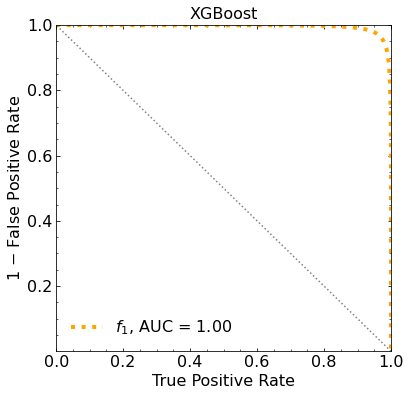

ML iteration  6


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62447	validation_1-logloss:0.62570
[1]	validation_0-logloss:0.56647	validation_1-logloss:0.56846
[2]	validation_0-logloss:0.51700	validation_1-logloss:0.51952
[3]	validation_0-logloss:0.47377	validation_1-logloss:0.47704
[4]	validation_0-logloss:0.43617	validation_1-logloss:0.44000
[5]	validation_0-logloss:0.40323	validation_1-logloss:0.40746
[6]	validation_0-logloss:0.37400	validation_1-logloss:0.37860
[7]	validation_0-logloss:0.34809	validation_1-logloss:0.35288
[8]	validation_0-logloss:0.32487	validation_1-logloss:0.32995
[9]	validation_0-logloss:0.30408	validation_1-logloss:0.30948
[10]	validation_0-logloss:0.28551	validation_1-logloss:0.29100
[11]	validation_0-logloss:0.26862	validation_1-logloss:0.27442
[12]	validation_0-logloss:0.25345	validation_1-logloss:0.25960
[13]	validation_0-logloss:0.23977	validation_1-logloss:0.24612
[14]	validation_0-logloss:0.22740	validation_1-logloss:0.23398
[15]	validation_0-logloss:0.21605	validation_1-logloss:0.22276
[1

[130]	validation_0-logloss:0.06968	validation_1-logloss:0.08703
[131]	validation_0-logloss:0.06960	validation_1-logloss:0.08700
[132]	validation_0-logloss:0.06954	validation_1-logloss:0.08698
[133]	validation_0-logloss:0.06946	validation_1-logloss:0.08697
[134]	validation_0-logloss:0.06940	validation_1-logloss:0.08695
[135]	validation_0-logloss:0.06935	validation_1-logloss:0.08694
[136]	validation_0-logloss:0.06928	validation_1-logloss:0.08692
[137]	validation_0-logloss:0.06916	validation_1-logloss:0.08691
[138]	validation_0-logloss:0.06910	validation_1-logloss:0.08690
[139]	validation_0-logloss:0.06905	validation_1-logloss:0.08688
[140]	validation_0-logloss:0.06899	validation_1-logloss:0.08687
[141]	validation_0-logloss:0.06893	validation_1-logloss:0.08686
[142]	validation_0-logloss:0.06890	validation_1-logloss:0.08685
[143]	validation_0-logloss:0.06886	validation_1-logloss:0.08684
[144]	validation_0-logloss:0.06875	validation_1-logloss:0.08682
[145]	validation_0-logloss:0.06868	valid

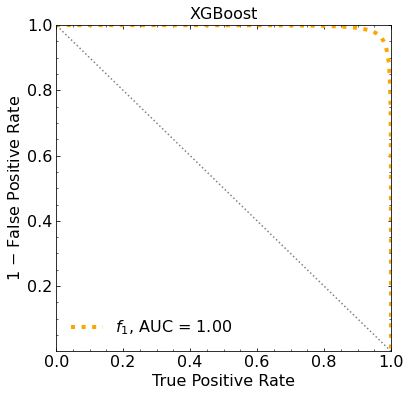

ML iteration  7


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62526	validation_1-logloss:0.62585
[1]	validation_0-logloss:0.56746	validation_1-logloss:0.56878
[2]	validation_0-logloss:0.51829	validation_1-logloss:0.52016
[3]	validation_0-logloss:0.47547	validation_1-logloss:0.47781
[4]	validation_0-logloss:0.43795	validation_1-logloss:0.44056
[5]	validation_0-logloss:0.40497	validation_1-logloss:0.40775
[6]	validation_0-logloss:0.37590	validation_1-logloss:0.37895
[7]	validation_0-logloss:0.35011	validation_1-logloss:0.35346
[8]	validation_0-logloss:0.32697	validation_1-logloss:0.33052
[9]	validation_0-logloss:0.30627	validation_1-logloss:0.30993
[10]	validation_0-logloss:0.28756	validation_1-logloss:0.29155
[11]	validation_0-logloss:0.27090	validation_1-logloss:0.27504
[12]	validation_0-logloss:0.25577	validation_1-logloss:0.26006
[13]	validation_0-logloss:0.24211	validation_1-logloss:0.24662
[14]	validation_0-logloss:0.22964	validation_1-logloss:0.23435
[15]	validation_0-logloss:0.21841	validation_1-logloss:0.22324
[1

[130]	validation_0-logloss:0.07189	validation_1-logloss:0.08692
[131]	validation_0-logloss:0.07181	validation_1-logloss:0.08689
[132]	validation_0-logloss:0.07175	validation_1-logloss:0.08686
[133]	validation_0-logloss:0.07160	validation_1-logloss:0.08685
[134]	validation_0-logloss:0.07154	validation_1-logloss:0.08684
[135]	validation_0-logloss:0.07148	validation_1-logloss:0.08681
[136]	validation_0-logloss:0.07141	validation_1-logloss:0.08679
[137]	validation_0-logloss:0.07136	validation_1-logloss:0.08677
[138]	validation_0-logloss:0.07132	validation_1-logloss:0.08677
[139]	validation_0-logloss:0.07128	validation_1-logloss:0.08676
[140]	validation_0-logloss:0.07121	validation_1-logloss:0.08674
[141]	validation_0-logloss:0.07117	validation_1-logloss:0.08673
[142]	validation_0-logloss:0.07111	validation_1-logloss:0.08672
[143]	validation_0-logloss:0.07101	validation_1-logloss:0.08671
[144]	validation_0-logloss:0.07099	validation_1-logloss:0.08671
[145]	validation_0-logloss:0.07085	valid

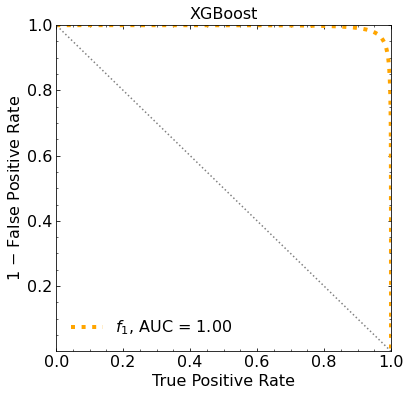

ML iteration  8
[0]	validation_0-logloss:0.62458	validation_1-logloss:0.62585


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.56653	validation_1-logloss:0.56866
[2]	validation_0-logloss:0.51674	validation_1-logloss:0.51963
[3]	validation_0-logloss:0.47335	validation_1-logloss:0.47689
[4]	validation_0-logloss:0.43552	validation_1-logloss:0.43971
[5]	validation_0-logloss:0.40248	validation_1-logloss:0.40712
[6]	validation_0-logloss:0.37305	validation_1-logloss:0.37811
[7]	validation_0-logloss:0.34718	validation_1-logloss:0.35259
[8]	validation_0-logloss:0.32407	validation_1-logloss:0.32973
[9]	validation_0-logloss:0.30322	validation_1-logloss:0.30918
[10]	validation_0-logloss:0.28461	validation_1-logloss:0.29077
[11]	validation_0-logloss:0.26769	validation_1-logloss:0.27418
[12]	validation_0-logloss:0.25249	validation_1-logloss:0.25924
[13]	validation_0-logloss:0.23879	validation_1-logloss:0.24589
[14]	validation_0-logloss:0.22631	validation_1-logloss:0.23360
[15]	validation_0-logloss:0.21502	validation_1-logloss:0.22243
[16]	validation_0-logloss:0.20470	validation_1-logloss:0.21232
[

[131]	validation_0-logloss:0.06970	validation_1-logloss:0.08720
[132]	validation_0-logloss:0.06962	validation_1-logloss:0.08718
[133]	validation_0-logloss:0.06956	validation_1-logloss:0.08716
[134]	validation_0-logloss:0.06949	validation_1-logloss:0.08715
[135]	validation_0-logloss:0.06942	validation_1-logloss:0.08713
[136]	validation_0-logloss:0.06938	validation_1-logloss:0.08712
[137]	validation_0-logloss:0.06932	validation_1-logloss:0.08711
[138]	validation_0-logloss:0.06919	validation_1-logloss:0.08711
[139]	validation_0-logloss:0.06914	validation_1-logloss:0.08710
[140]	validation_0-logloss:0.06906	validation_1-logloss:0.08709
[141]	validation_0-logloss:0.06902	validation_1-logloss:0.08708
[142]	validation_0-logloss:0.06892	validation_1-logloss:0.08709
[143]	validation_0-logloss:0.06889	validation_1-logloss:0.08708
[144]	validation_0-logloss:0.06885	validation_1-logloss:0.08707
[145]	validation_0-logloss:0.06878	validation_1-logloss:0.08706
[146]	validation_0-logloss:0.06868	valid

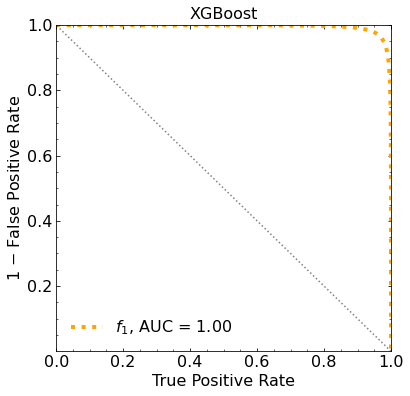

ML iteration  9


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62491	validation_1-logloss:0.62580
[1]	validation_0-logloss:0.56718	validation_1-logloss:0.56897
[2]	validation_0-logloss:0.51760	validation_1-logloss:0.52001
[3]	validation_0-logloss:0.47466	validation_1-logloss:0.47744
[4]	validation_0-logloss:0.43701	validation_1-logloss:0.44004
[5]	validation_0-logloss:0.40404	validation_1-logloss:0.40750
[6]	validation_0-logloss:0.37499	validation_1-logloss:0.37877
[7]	validation_0-logloss:0.34905	validation_1-logloss:0.35325
[8]	validation_0-logloss:0.32603	validation_1-logloss:0.33050
[9]	validation_0-logloss:0.30516	validation_1-logloss:0.30993
[10]	validation_0-logloss:0.28648	validation_1-logloss:0.29137
[11]	validation_0-logloss:0.26981	validation_1-logloss:0.27486
[12]	validation_0-logloss:0.25480	validation_1-logloss:0.26005
[13]	validation_0-logloss:0.24113	validation_1-logloss:0.24653
[14]	validation_0-logloss:0.22873	validation_1-logloss:0.23434
[15]	validation_0-logloss:0.21737	validation_1-logloss:0.22308
[1

[130]	validation_0-logloss:0.07166	validation_1-logloss:0.08718
[131]	validation_0-logloss:0.07159	validation_1-logloss:0.08715
[132]	validation_0-logloss:0.07150	validation_1-logloss:0.08713
[133]	validation_0-logloss:0.07146	validation_1-logloss:0.08712
[134]	validation_0-logloss:0.07141	validation_1-logloss:0.08711
[135]	validation_0-logloss:0.07130	validation_1-logloss:0.08709
[136]	validation_0-logloss:0.07126	validation_1-logloss:0.08708
[137]	validation_0-logloss:0.07121	validation_1-logloss:0.08707
[138]	validation_0-logloss:0.07112	validation_1-logloss:0.08703
[139]	validation_0-logloss:0.07108	validation_1-logloss:0.08702
[140]	validation_0-logloss:0.07100	validation_1-logloss:0.08701
[141]	validation_0-logloss:0.07096	validation_1-logloss:0.08701
[142]	validation_0-logloss:0.07091	validation_1-logloss:0.08699
[143]	validation_0-logloss:0.07088	validation_1-logloss:0.08698
[144]	validation_0-logloss:0.07086	validation_1-logloss:0.08697
[145]	validation_0-logloss:0.07082	valid

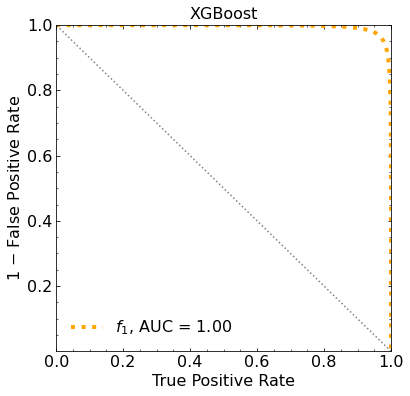

Classification score (1 ML):


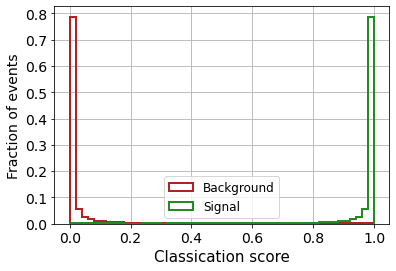

Classification score (10 ML):


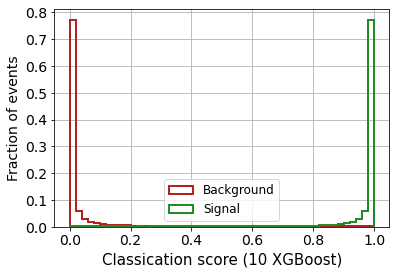

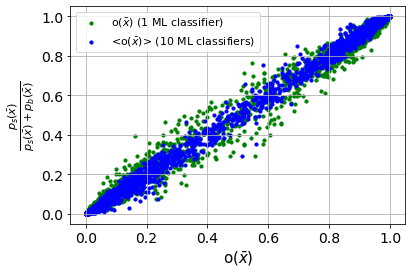


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  17.240531933986492
Z_XG 25 bins_1ML:  20.1848399274867
Z_XG 50 bins_1ML:  22.011311287837664
Z_XG 100 bins_1ML:  23.321841061876967

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  6.120229262752213
Z_XG 25 bins_eq_1ML:  9.123436004615739
Z_XG 50 bins_eq_1ML:  11.883232825050655
Z_XG 100 bins_eq_1ML:  14.770218754185132

 BL lineal bins, 10 ML
Z_XG 10 bins:  17.625032464117787
Z_XG 25 bins:  20.620272694812723
Z_XG 50 bins:  22.406016886628397
Z_XG 100 bins:  23.548038771311358

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  6.314194404772618
Z_XG 25 bins_eq:  9.409452253445133
Z_XG 50 bins_eq:  12.25007406837353
Z_XG 100 bins_eq:  15.214277570073286

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD 

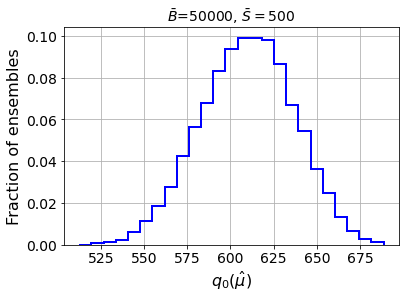

muhat mean:  0.01396633884213728
Z_gaussian:  24.70668354044314
Z_gaussian_mu0:  24.7544121899887

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf 12881.37443115
 12419.08100971 11881.78201865 11287.71543337 10630.17163545
  9892.72184084  9092.37377009  8222.96654483  7296.3486575
  6312.85095508  5276.50327315  4193.08451493  3065.84612937
  1892.44630016   678.1247216   -556.68043778 -1779.03383324]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 12350.4240925  11822.83670472 11231.70084942 10573.29756743
  9852.6767725   9059.32759208  8191.34554841  7272.57578009
  629

KDE Kernel:  epanechnikov
Background bandwidth:  0.003030951223220623
Signal bandwidth:  0.004386370005779536


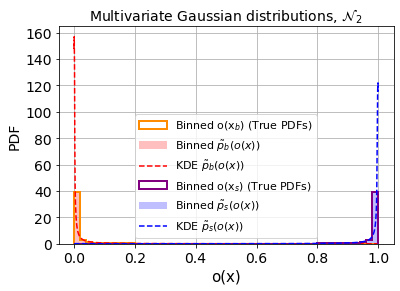

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 12014.09327709 11546.69618421 11008.37746561 10400.35960316
  9709.17467745  8933.83690845  8095.97077898  7194.19806104
  6233.0268072   5211.06190573  4148.71485372  3038.87255345
  1885.32879968   682.07109895  -544.55563967 -1774.61424154]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf 12366.89196527
 11978.07967045 11506.80448325 10962.57828077 10344.70282576
  9661.84238095  8902.26078094  8065.15202075  7169.50544647
  62

KDE Kernel:  epanechnikov
Background bandwidth:  0.004386370005779536
Signal bandwidth:  0.003030951223220623


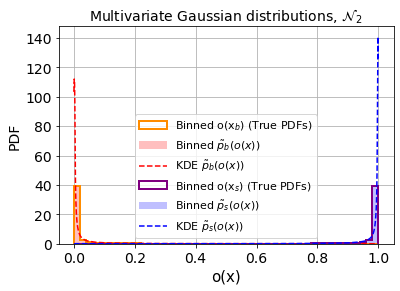

 Z MLL+KDE (1ML) 


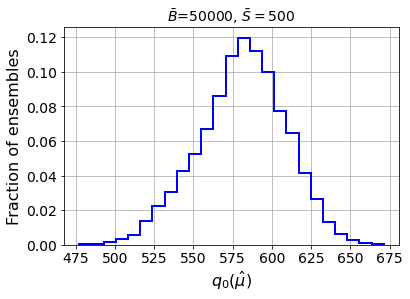

muhat mean_1ML:  0.006270911487377066
Z_KDE_1ML:  24.135024545324057
Z_KDE mu=0_1ML:  24.13538498305128

 Z MLL+KDE (10ML) 


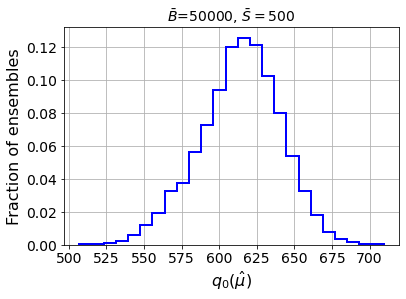

muhat mean:  0.006220216972523573
Z_KDE:  24.805725725715572
Z_KDE mu=0:  24.806311533439874

 ------------------------------------ 



In [20]:
dim=7

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3, signal_X_4, signal_X_5, signal_X_6, signal_X_7 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3, background_X_4, background_X_5, background_X_6, background_X_7 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T


dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))
dim6 = np.concatenate((background_X_6,signal_X_6))
dim7 = np.concatenate((background_X_7,signal_X_7))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['dim6'] = dim6.reshape(-1)
df['dim7'] = dim7.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5','dim6','dim7']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML)


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP)


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [ ]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 8)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 8)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 8)
y_gauss_test :  (1000000, 1)



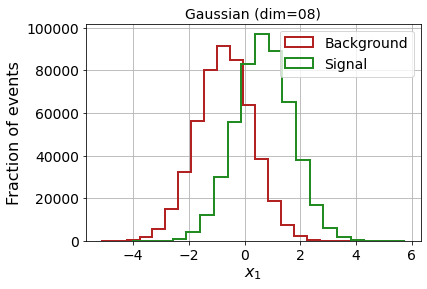

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62581	validation_1-logloss:0.62614
[1]	validation_0-logloss:0.56829	validation_1-logloss:0.56887
[2]	validation_0-logloss:0.51879	validation_1-logloss:0.51953
[3]	validation_0-logloss:0.47576	validation_1-logloss:0.47663
[4]	validation_0-logloss:0.43799	validation_1-logloss:0.43898
[5]	validation_0-logloss:0.40493	validation_1-logloss:0.40606
[6]	validation_0-logloss:0.37538	validation_1-logloss:0.37665
[7]	validation_0-logloss:0.34913	validation_1-logloss:0.35051
[8]	validation_0-logloss:0.32582	validation_1-logloss:0.32725
[9]	validation_0-logloss:0.30487	validation_1-logloss:0.30634
[10]	validation_0-logloss:0.28593	validation_1-logloss:0.28746
[11]	validation_0-logloss:0.26884	validation_1-logloss:0.27042
[12]	validation_0-logloss:0.25326	validation_1-logloss:0.25491
[13]	validation_0-logloss:0.23925	validation_1-logloss:0.24097
[14]	validation_0-logloss:0.22648	validation_1-logloss:0.22824
[15]	validation_0-logloss:0.21479	validation_1-logloss:0.21655
[1

[130]	validation_0-logloss:0.06220	validation_1-logloss:0.06660
[131]	validation_0-logloss:0.06214	validation_1-logloss:0.06655
[132]	validation_0-logloss:0.06208	validation_1-logloss:0.06651
[133]	validation_0-logloss:0.06203	validation_1-logloss:0.06647
[134]	validation_0-logloss:0.06197	validation_1-logloss:0.06642
[135]	validation_0-logloss:0.06191	validation_1-logloss:0.06638
[136]	validation_0-logloss:0.06187	validation_1-logloss:0.06635
[137]	validation_0-logloss:0.06182	validation_1-logloss:0.06632
[138]	validation_0-logloss:0.06177	validation_1-logloss:0.06628
[139]	validation_0-logloss:0.06173	validation_1-logloss:0.06625
[140]	validation_0-logloss:0.06168	validation_1-logloss:0.06622
[141]	validation_0-logloss:0.06164	validation_1-logloss:0.06619
[142]	validation_0-logloss:0.06159	validation_1-logloss:0.06616
[143]	validation_0-logloss:0.06155	validation_1-logloss:0.06612
[144]	validation_0-logloss:0.06151	validation_1-logloss:0.06609
[145]	validation_0-logloss:0.06147	valid

[259]	validation_0-logloss:0.05937	validation_1-logloss:0.06521
[260]	validation_0-logloss:0.05937	validation_1-logloss:0.06520
[261]	validation_0-logloss:0.05936	validation_1-logloss:0.06520
[262]	validation_0-logloss:0.05935	validation_1-logloss:0.06520
[263]	validation_0-logloss:0.05934	validation_1-logloss:0.06520
[264]	validation_0-logloss:0.05932	validation_1-logloss:0.06520
[265]	validation_0-logloss:0.05932	validation_1-logloss:0.06520
[266]	validation_0-logloss:0.05930	validation_1-logloss:0.06520
[267]	validation_0-logloss:0.05930	validation_1-logloss:0.06520
[268]	validation_0-logloss:0.05929	validation_1-logloss:0.06520
[269]	validation_0-logloss:0.05929	validation_1-logloss:0.06520
[270]	validation_0-logloss:0.05927	validation_1-logloss:0.06520
[271]	validation_0-logloss:0.05926	validation_1-logloss:0.06520
[272]	validation_0-logloss:0.05925	validation_1-logloss:0.06520
[273]	validation_0-logloss:0.05924	validation_1-logloss:0.06520
[274]	validation_0-logloss:0.05923	valid

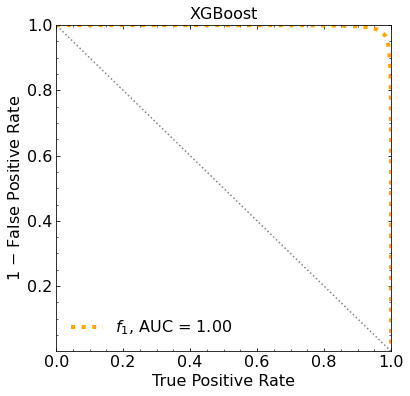

ML iteration 0


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62450	validation_1-logloss:0.62563
[1]	validation_0-logloss:0.56607	validation_1-logloss:0.56811
[2]	validation_0-logloss:0.51590	validation_1-logloss:0.51885
[3]	validation_0-logloss:0.47244	validation_1-logloss:0.47587
[4]	validation_0-logloss:0.43438	validation_1-logloss:0.43826
[5]	validation_0-logloss:0.40096	validation_1-logloss:0.40523
[6]	validation_0-logloss:0.37117	validation_1-logloss:0.37578
[7]	validation_0-logloss:0.34476	validation_1-logloss:0.34963
[8]	validation_0-logloss:0.32122	validation_1-logloss:0.32638
[9]	validation_0-logloss:0.29988	validation_1-logloss:0.30534
[10]	validation_0-logloss:0.28077	validation_1-logloss:0.28644
[11]	validation_0-logloss:0.26354	validation_1-logloss:0.26943
[12]	validation_0-logloss:0.24790	validation_1-logloss:0.25393
[13]	validation_0-logloss:0.23370	validation_1-logloss:0.23995
[14]	validation_0-logloss:0.22080	validation_1-logloss:0.22712
[15]	validation_0-logloss:0.20904	validation_1-logloss:0.21560
[1

[130]	validation_0-logloss:0.05147	validation_1-logloss:0.06788
[131]	validation_0-logloss:0.05137	validation_1-logloss:0.06786
[132]	validation_0-logloss:0.05130	validation_1-logloss:0.06783
[133]	validation_0-logloss:0.05121	validation_1-logloss:0.06780
[134]	validation_0-logloss:0.05115	validation_1-logloss:0.06777
[135]	validation_0-logloss:0.05109	validation_1-logloss:0.06775
[136]	validation_0-logloss:0.05100	validation_1-logloss:0.06772
[137]	validation_0-logloss:0.05087	validation_1-logloss:0.06770
[138]	validation_0-logloss:0.05075	validation_1-logloss:0.06767
[139]	validation_0-logloss:0.05071	validation_1-logloss:0.06765
[140]	validation_0-logloss:0.05063	validation_1-logloss:0.06763
[141]	validation_0-logloss:0.05053	validation_1-logloss:0.06760
[142]	validation_0-logloss:0.05046	validation_1-logloss:0.06757
[143]	validation_0-logloss:0.05039	validation_1-logloss:0.06754
[144]	validation_0-logloss:0.05028	validation_1-logloss:0.06752
[145]	validation_0-logloss:0.05021	valid

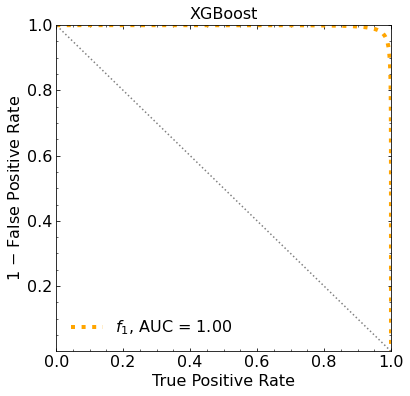

ML iteration  1


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62468	validation_1-logloss:0.62581
[1]	validation_0-logloss:0.56646	validation_1-logloss:0.56854
[2]	validation_0-logloss:0.51616	validation_1-logloss:0.51908
[3]	validation_0-logloss:0.47266	validation_1-logloss:0.47619
[4]	validation_0-logloss:0.43445	validation_1-logloss:0.43854
[5]	validation_0-logloss:0.40086	validation_1-logloss:0.40546
[6]	validation_0-logloss:0.37084	validation_1-logloss:0.37588
[7]	validation_0-logloss:0.34433	validation_1-logloss:0.34979
[8]	validation_0-logloss:0.32072	validation_1-logloss:0.32651
[9]	validation_0-logloss:0.29941	validation_1-logloss:0.30545
[10]	validation_0-logloss:0.28017	validation_1-logloss:0.28658
[11]	validation_0-logloss:0.26290	validation_1-logloss:0.26952
[12]	validation_0-logloss:0.24717	validation_1-logloss:0.25410
[13]	validation_0-logloss:0.23293	validation_1-logloss:0.24011
[14]	validation_0-logloss:0.22000	validation_1-logloss:0.22736
[15]	validation_0-logloss:0.20814	validation_1-logloss:0.21573
[1

[130]	validation_0-logloss:0.05014	validation_1-logloss:0.06813
[131]	validation_0-logloss:0.05006	validation_1-logloss:0.06811
[132]	validation_0-logloss:0.04999	validation_1-logloss:0.06809
[133]	validation_0-logloss:0.04991	validation_1-logloss:0.06807
[134]	validation_0-logloss:0.04983	validation_1-logloss:0.06805
[135]	validation_0-logloss:0.04975	validation_1-logloss:0.06803
[136]	validation_0-logloss:0.04969	validation_1-logloss:0.06800
[137]	validation_0-logloss:0.04963	validation_1-logloss:0.06799
[138]	validation_0-logloss:0.04957	validation_1-logloss:0.06796
[139]	validation_0-logloss:0.04951	validation_1-logloss:0.06793
[140]	validation_0-logloss:0.04945	validation_1-logloss:0.06791
[141]	validation_0-logloss:0.04938	validation_1-logloss:0.06790
[142]	validation_0-logloss:0.04932	validation_1-logloss:0.06789
[143]	validation_0-logloss:0.04924	validation_1-logloss:0.06787
[144]	validation_0-logloss:0.04913	validation_1-logloss:0.06784
[145]	validation_0-logloss:0.04909	valid

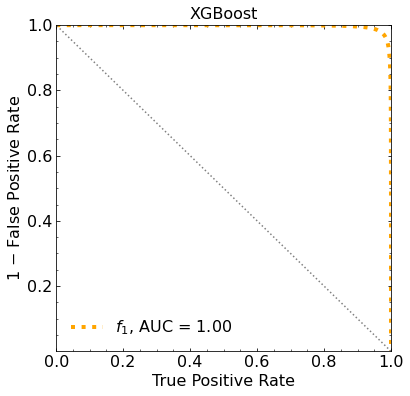

ML iteration  2
[0]	validation_0-logloss:0.62440	validation_1-logloss:0.62581


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.56643	validation_1-logloss:0.56866
[2]	validation_0-logloss:0.51625	validation_1-logloss:0.51924
[3]	validation_0-logloss:0.47239	validation_1-logloss:0.47597
[4]	validation_0-logloss:0.43411	validation_1-logloss:0.43820
[5]	validation_0-logloss:0.40061	validation_1-logloss:0.40519
[6]	validation_0-logloss:0.37077	validation_1-logloss:0.37580
[7]	validation_0-logloss:0.34425	validation_1-logloss:0.34956
[8]	validation_0-logloss:0.32039	validation_1-logloss:0.32595
[9]	validation_0-logloss:0.29914	validation_1-logloss:0.30500
[10]	validation_0-logloss:0.28001	validation_1-logloss:0.28614
[11]	validation_0-logloss:0.26276	validation_1-logloss:0.26906
[12]	validation_0-logloss:0.24716	validation_1-logloss:0.25374
[13]	validation_0-logloss:0.23292	validation_1-logloss:0.23972
[14]	validation_0-logloss:0.21989	validation_1-logloss:0.22691
[15]	validation_0-logloss:0.20807	validation_1-logloss:0.21529
[16]	validation_0-logloss:0.19725	validation_1-logloss:0.20472
[

[131]	validation_0-logloss:0.05045	validation_1-logloss:0.06820
[132]	validation_0-logloss:0.05036	validation_1-logloss:0.06818
[133]	validation_0-logloss:0.05029	validation_1-logloss:0.06815
[134]	validation_0-logloss:0.05023	validation_1-logloss:0.06812
[135]	validation_0-logloss:0.05016	validation_1-logloss:0.06809
[136]	validation_0-logloss:0.05008	validation_1-logloss:0.06805
[137]	validation_0-logloss:0.05002	validation_1-logloss:0.06804
[138]	validation_0-logloss:0.04992	validation_1-logloss:0.06803
[139]	validation_0-logloss:0.04983	validation_1-logloss:0.06801
[140]	validation_0-logloss:0.04973	validation_1-logloss:0.06799
[141]	validation_0-logloss:0.04966	validation_1-logloss:0.06797
[142]	validation_0-logloss:0.04955	validation_1-logloss:0.06793
[143]	validation_0-logloss:0.04951	validation_1-logloss:0.06792
[144]	validation_0-logloss:0.04944	validation_1-logloss:0.06790
[145]	validation_0-logloss:0.04938	validation_1-logloss:0.06790
[146]	validation_0-logloss:0.04935	valid

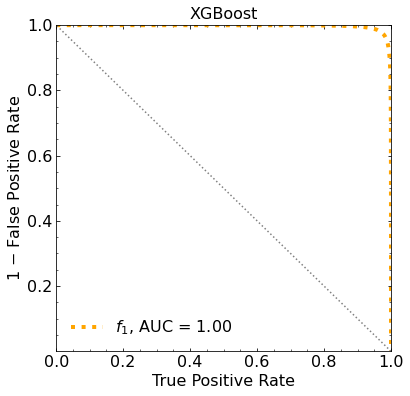

ML iteration  3


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62478	validation_1-logloss:0.62578
[1]	validation_0-logloss:0.56660	validation_1-logloss:0.56837
[2]	validation_0-logloss:0.51664	validation_1-logloss:0.51909
[3]	validation_0-logloss:0.47334	validation_1-logloss:0.47622
[4]	validation_0-logloss:0.43535	validation_1-logloss:0.43859
[5]	validation_0-logloss:0.40184	validation_1-logloss:0.40551
[6]	validation_0-logloss:0.37210	validation_1-logloss:0.37611
[7]	validation_0-logloss:0.34574	validation_1-logloss:0.35004
[8]	validation_0-logloss:0.32198	validation_1-logloss:0.32659
[9]	validation_0-logloss:0.30072	validation_1-logloss:0.30564
[10]	validation_0-logloss:0.28161	validation_1-logloss:0.28665
[11]	validation_0-logloss:0.26436	validation_1-logloss:0.26955
[12]	validation_0-logloss:0.24877	validation_1-logloss:0.25417
[13]	validation_0-logloss:0.23454	validation_1-logloss:0.24015
[14]	validation_0-logloss:0.22165	validation_1-logloss:0.22740
[15]	validation_0-logloss:0.20993	validation_1-logloss:0.21581
[1

[130]	validation_0-logloss:0.05321	validation_1-logloss:0.06807
[131]	validation_0-logloss:0.05311	validation_1-logloss:0.06803
[132]	validation_0-logloss:0.05303	validation_1-logloss:0.06801
[133]	validation_0-logloss:0.05297	validation_1-logloss:0.06798
[134]	validation_0-logloss:0.05292	validation_1-logloss:0.06796
[135]	validation_0-logloss:0.05284	validation_1-logloss:0.06792
[136]	validation_0-logloss:0.05279	validation_1-logloss:0.06790
[137]	validation_0-logloss:0.05270	validation_1-logloss:0.06787
[138]	validation_0-logloss:0.05260	validation_1-logloss:0.06783
[139]	validation_0-logloss:0.05252	validation_1-logloss:0.06781
[140]	validation_0-logloss:0.05245	validation_1-logloss:0.06779
[141]	validation_0-logloss:0.05237	validation_1-logloss:0.06776
[142]	validation_0-logloss:0.05234	validation_1-logloss:0.06774
[143]	validation_0-logloss:0.05226	validation_1-logloss:0.06772
[144]	validation_0-logloss:0.05221	validation_1-logloss:0.06770
[145]	validation_0-logloss:0.05211	valid

[259]	validation_0-logloss:0.04680	validation_1-logloss:0.06736
[260]	validation_0-logloss:0.04679	validation_1-logloss:0.06736
[261]	validation_0-logloss:0.04673	validation_1-logloss:0.06736
[262]	validation_0-logloss:0.04665	validation_1-logloss:0.06737


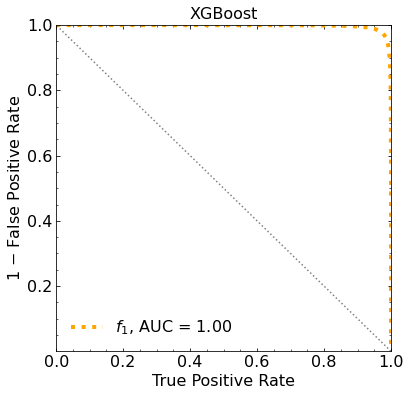

ML iteration  4


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62483	validation_1-logloss:0.62587
[1]	validation_0-logloss:0.56687	validation_1-logloss:0.56871
[2]	validation_0-logloss:0.51686	validation_1-logloss:0.51946
[3]	validation_0-logloss:0.47304	validation_1-logloss:0.47630
[4]	validation_0-logloss:0.43519	validation_1-logloss:0.43892
[5]	validation_0-logloss:0.40157	validation_1-logloss:0.40574
[6]	validation_0-logloss:0.37182	validation_1-logloss:0.37622
[7]	validation_0-logloss:0.34535	validation_1-logloss:0.35008
[8]	validation_0-logloss:0.32166	validation_1-logloss:0.32664
[9]	validation_0-logloss:0.30040	validation_1-logloss:0.30568
[10]	validation_0-logloss:0.28124	validation_1-logloss:0.28678
[11]	validation_0-logloss:0.26399	validation_1-logloss:0.26971
[12]	validation_0-logloss:0.24835	validation_1-logloss:0.25422
[13]	validation_0-logloss:0.23423	validation_1-logloss:0.24021
[14]	validation_0-logloss:0.22127	validation_1-logloss:0.22738
[15]	validation_0-logloss:0.20944	validation_1-logloss:0.21576
[1

[130]	validation_0-logloss:0.05199	validation_1-logloss:0.06791
[131]	validation_0-logloss:0.05189	validation_1-logloss:0.06787
[132]	validation_0-logloss:0.05184	validation_1-logloss:0.06785
[133]	validation_0-logloss:0.05175	validation_1-logloss:0.06782
[134]	validation_0-logloss:0.05168	validation_1-logloss:0.06779
[135]	validation_0-logloss:0.05155	validation_1-logloss:0.06776
[136]	validation_0-logloss:0.05149	validation_1-logloss:0.06774
[137]	validation_0-logloss:0.05142	validation_1-logloss:0.06771
[138]	validation_0-logloss:0.05133	validation_1-logloss:0.06769
[139]	validation_0-logloss:0.05123	validation_1-logloss:0.06767
[140]	validation_0-logloss:0.05117	validation_1-logloss:0.06764
[141]	validation_0-logloss:0.05105	validation_1-logloss:0.06761
[142]	validation_0-logloss:0.05101	validation_1-logloss:0.06759
[143]	validation_0-logloss:0.05097	validation_1-logloss:0.06758
[144]	validation_0-logloss:0.05087	validation_1-logloss:0.06756
[145]	validation_0-logloss:0.05079	valid

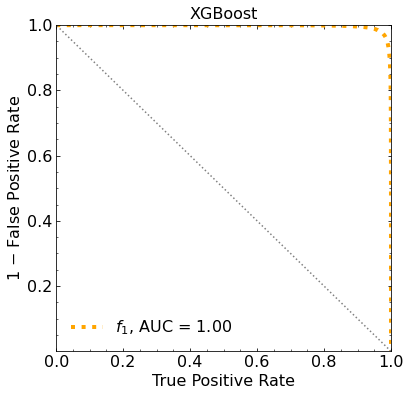

ML iteration  5


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62454	validation_1-logloss:0.62560
[1]	validation_0-logloss:0.56645	validation_1-logloss:0.56842
[2]	validation_0-logloss:0.51633	validation_1-logloss:0.51885
[3]	validation_0-logloss:0.47280	validation_1-logloss:0.47608
[4]	validation_0-logloss:0.43452	validation_1-logloss:0.43840
[5]	validation_0-logloss:0.40084	validation_1-logloss:0.40518
[6]	validation_0-logloss:0.37108	validation_1-logloss:0.37586
[7]	validation_0-logloss:0.34451	validation_1-logloss:0.34972
[8]	validation_0-logloss:0.32081	validation_1-logloss:0.32622
[9]	validation_0-logloss:0.29951	validation_1-logloss:0.30522
[10]	validation_0-logloss:0.28043	validation_1-logloss:0.28643
[11]	validation_0-logloss:0.26322	validation_1-logloss:0.26943
[12]	validation_0-logloss:0.24760	validation_1-logloss:0.25399
[13]	validation_0-logloss:0.23344	validation_1-logloss:0.24002
[14]	validation_0-logloss:0.22047	validation_1-logloss:0.22726
[15]	validation_0-logloss:0.20866	validation_1-logloss:0.21568
[1

[130]	validation_0-logloss:0.05061	validation_1-logloss:0.06791
[131]	validation_0-logloss:0.05050	validation_1-logloss:0.06788
[132]	validation_0-logloss:0.05045	validation_1-logloss:0.06785
[133]	validation_0-logloss:0.05040	validation_1-logloss:0.06783
[134]	validation_0-logloss:0.05029	validation_1-logloss:0.06781
[135]	validation_0-logloss:0.05023	validation_1-logloss:0.06778
[136]	validation_0-logloss:0.05013	validation_1-logloss:0.06776
[137]	validation_0-logloss:0.05001	validation_1-logloss:0.06774
[138]	validation_0-logloss:0.04994	validation_1-logloss:0.06771
[139]	validation_0-logloss:0.04988	validation_1-logloss:0.06770
[140]	validation_0-logloss:0.04976	validation_1-logloss:0.06768
[141]	validation_0-logloss:0.04970	validation_1-logloss:0.06766
[142]	validation_0-logloss:0.04966	validation_1-logloss:0.06764
[143]	validation_0-logloss:0.04954	validation_1-logloss:0.06762
[144]	validation_0-logloss:0.04948	validation_1-logloss:0.06760
[145]	validation_0-logloss:0.04944	valid

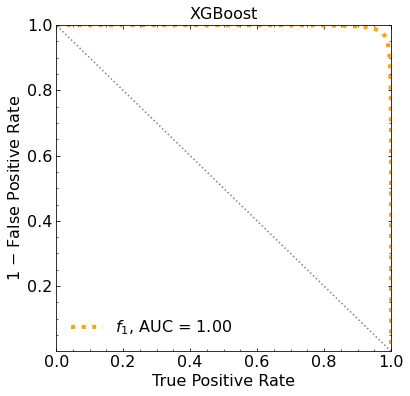

ML iteration  6


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62471	validation_1-logloss:0.62571
[1]	validation_0-logloss:0.56637	validation_1-logloss:0.56827
[2]	validation_0-logloss:0.51607	validation_1-logloss:0.51896
[3]	validation_0-logloss:0.47239	validation_1-logloss:0.47594
[4]	validation_0-logloss:0.43428	validation_1-logloss:0.43835
[5]	validation_0-logloss:0.40069	validation_1-logloss:0.40534
[6]	validation_0-logloss:0.37101	validation_1-logloss:0.37595
[7]	validation_0-logloss:0.34429	validation_1-logloss:0.34967
[8]	validation_0-logloss:0.32048	validation_1-logloss:0.32624
[9]	validation_0-logloss:0.29921	validation_1-logloss:0.30524
[10]	validation_0-logloss:0.28000	validation_1-logloss:0.28633
[11]	validation_0-logloss:0.26258	validation_1-logloss:0.26922
[12]	validation_0-logloss:0.24688	validation_1-logloss:0.25378
[13]	validation_0-logloss:0.23265	validation_1-logloss:0.23975
[14]	validation_0-logloss:0.21968	validation_1-logloss:0.22702
[15]	validation_0-logloss:0.20797	validation_1-logloss:0.21550
[1

[130]	validation_0-logloss:0.05030	validation_1-logloss:0.06793
[131]	validation_0-logloss:0.05017	validation_1-logloss:0.06790
[132]	validation_0-logloss:0.05012	validation_1-logloss:0.06788
[133]	validation_0-logloss:0.05008	validation_1-logloss:0.06786
[134]	validation_0-logloss:0.05002	validation_1-logloss:0.06782
[135]	validation_0-logloss:0.04994	validation_1-logloss:0.06778
[136]	validation_0-logloss:0.04989	validation_1-logloss:0.06776
[137]	validation_0-logloss:0.04983	validation_1-logloss:0.06774
[138]	validation_0-logloss:0.04973	validation_1-logloss:0.06772
[139]	validation_0-logloss:0.04967	validation_1-logloss:0.06769
[140]	validation_0-logloss:0.04963	validation_1-logloss:0.06767
[141]	validation_0-logloss:0.04958	validation_1-logloss:0.06765
[142]	validation_0-logloss:0.04946	validation_1-logloss:0.06763
[143]	validation_0-logloss:0.04938	validation_1-logloss:0.06760
[144]	validation_0-logloss:0.04934	validation_1-logloss:0.06759
[145]	validation_0-logloss:0.04928	valid

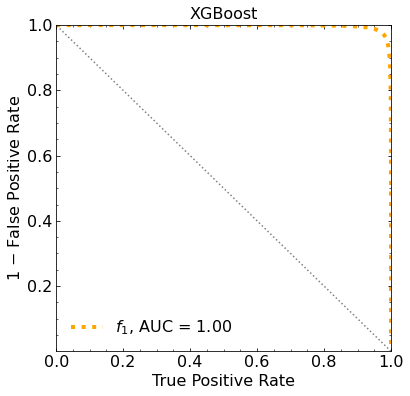

ML iteration  7


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62464	validation_1-logloss:0.62592
[1]	validation_0-logloss:0.56601	validation_1-logloss:0.56809
[2]	validation_0-logloss:0.51598	validation_1-logloss:0.51895
[3]	validation_0-logloss:0.47247	validation_1-logloss:0.47599
[4]	validation_0-logloss:0.43417	validation_1-logloss:0.43823
[5]	validation_0-logloss:0.40051	validation_1-logloss:0.40493
[6]	validation_0-logloss:0.37079	validation_1-logloss:0.37570
[7]	validation_0-logloss:0.34428	validation_1-logloss:0.34958
[8]	validation_0-logloss:0.32063	validation_1-logloss:0.32621
[9]	validation_0-logloss:0.29934	validation_1-logloss:0.30522
[10]	validation_0-logloss:0.28015	validation_1-logloss:0.28632
[11]	validation_0-logloss:0.26292	validation_1-logloss:0.26928
[12]	validation_0-logloss:0.24716	validation_1-logloss:0.25382
[13]	validation_0-logloss:0.23294	validation_1-logloss:0.23978
[14]	validation_0-logloss:0.22006	validation_1-logloss:0.22709
[15]	validation_0-logloss:0.20829	validation_1-logloss:0.21556
[1

[130]	validation_0-logloss:0.05039	validation_1-logloss:0.06813
[131]	validation_0-logloss:0.05033	validation_1-logloss:0.06810
[132]	validation_0-logloss:0.05024	validation_1-logloss:0.06807
[133]	validation_0-logloss:0.05019	validation_1-logloss:0.06803
[134]	validation_0-logloss:0.05006	validation_1-logloss:0.06801
[135]	validation_0-logloss:0.05001	validation_1-logloss:0.06799
[136]	validation_0-logloss:0.04990	validation_1-logloss:0.06797
[137]	validation_0-logloss:0.04977	validation_1-logloss:0.06796
[138]	validation_0-logloss:0.04968	validation_1-logloss:0.06794
[139]	validation_0-logloss:0.04961	validation_1-logloss:0.06791
[140]	validation_0-logloss:0.04954	validation_1-logloss:0.06789
[141]	validation_0-logloss:0.04948	validation_1-logloss:0.06787
[142]	validation_0-logloss:0.04942	validation_1-logloss:0.06785
[143]	validation_0-logloss:0.04936	validation_1-logloss:0.06782
[144]	validation_0-logloss:0.04931	validation_1-logloss:0.06780
[145]	validation_0-logloss:0.04924	valid

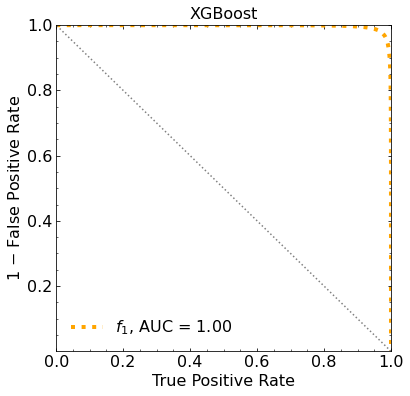

ML iteration  8


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62490	validation_1-logloss:0.62611
[1]	validation_0-logloss:0.56651	validation_1-logloss:0.56853
[2]	validation_0-logloss:0.51626	validation_1-logloss:0.51905
[3]	validation_0-logloss:0.47267	validation_1-logloss:0.47616
[4]	validation_0-logloss:0.43467	validation_1-logloss:0.43870
[5]	validation_0-logloss:0.40105	validation_1-logloss:0.40551
[6]	validation_0-logloss:0.37123	validation_1-logloss:0.37611
[7]	validation_0-logloss:0.34496	validation_1-logloss:0.35010
[8]	validation_0-logloss:0.32098	validation_1-logloss:0.32647
[9]	validation_0-logloss:0.29974	validation_1-logloss:0.30555
[10]	validation_0-logloss:0.28055	validation_1-logloss:0.28658
[11]	validation_0-logloss:0.26316	validation_1-logloss:0.26944
[12]	validation_0-logloss:0.24742	validation_1-logloss:0.25389
[13]	validation_0-logloss:0.23323	validation_1-logloss:0.23979
[14]	validation_0-logloss:0.22021	validation_1-logloss:0.22703
[15]	validation_0-logloss:0.20848	validation_1-logloss:0.21543
[1

[130]	validation_0-logloss:0.05142	validation_1-logloss:0.06796
[131]	validation_0-logloss:0.05133	validation_1-logloss:0.06792
[132]	validation_0-logloss:0.05128	validation_1-logloss:0.06790
[133]	validation_0-logloss:0.05118	validation_1-logloss:0.06788
[134]	validation_0-logloss:0.05109	validation_1-logloss:0.06785
[135]	validation_0-logloss:0.05099	validation_1-logloss:0.06784
[136]	validation_0-logloss:0.05089	validation_1-logloss:0.06781
[137]	validation_0-logloss:0.05084	validation_1-logloss:0.06778
[138]	validation_0-logloss:0.05078	validation_1-logloss:0.06775
[139]	validation_0-logloss:0.05071	validation_1-logloss:0.06774
[140]	validation_0-logloss:0.05061	validation_1-logloss:0.06771
[141]	validation_0-logloss:0.05054	validation_1-logloss:0.06769
[142]	validation_0-logloss:0.05050	validation_1-logloss:0.06767
[143]	validation_0-logloss:0.05039	validation_1-logloss:0.06766
[144]	validation_0-logloss:0.05035	validation_1-logloss:0.06765
[145]	validation_0-logloss:0.05028	valid

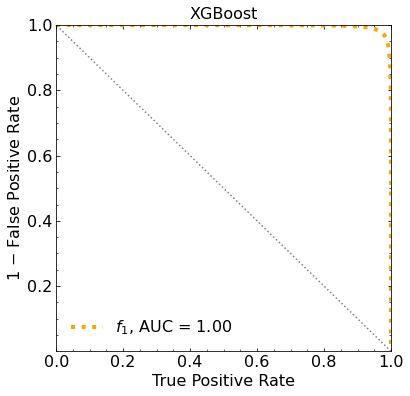

ML iteration  9


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62453	validation_1-logloss:0.62566
[1]	validation_0-logloss:0.56625	validation_1-logloss:0.56830
[2]	validation_0-logloss:0.51594	validation_1-logloss:0.51885
[3]	validation_0-logloss:0.47213	validation_1-logloss:0.47573
[4]	validation_0-logloss:0.43395	validation_1-logloss:0.43815
[5]	validation_0-logloss:0.40038	validation_1-logloss:0.40503
[6]	validation_0-logloss:0.37050	validation_1-logloss:0.37558
[7]	validation_0-logloss:0.34407	validation_1-logloss:0.34948
[8]	validation_0-logloss:0.32029	validation_1-logloss:0.32607
[9]	validation_0-logloss:0.29891	validation_1-logloss:0.30505
[10]	validation_0-logloss:0.27978	validation_1-logloss:0.28620
[11]	validation_0-logloss:0.26251	validation_1-logloss:0.26920
[12]	validation_0-logloss:0.24685	validation_1-logloss:0.25370
[13]	validation_0-logloss:0.23261	validation_1-logloss:0.23970
[14]	validation_0-logloss:0.21957	validation_1-logloss:0.22690
[15]	validation_0-logloss:0.20770	validation_1-logloss:0.21532
[1

[130]	validation_0-logloss:0.04967	validation_1-logloss:0.06776
[131]	validation_0-logloss:0.04963	validation_1-logloss:0.06773
[132]	validation_0-logloss:0.04951	validation_1-logloss:0.06769
[133]	validation_0-logloss:0.04939	validation_1-logloss:0.06767
[134]	validation_0-logloss:0.04929	validation_1-logloss:0.06764
[135]	validation_0-logloss:0.04924	validation_1-logloss:0.06762
[136]	validation_0-logloss:0.04915	validation_1-logloss:0.06759
[137]	validation_0-logloss:0.04907	validation_1-logloss:0.06757
[138]	validation_0-logloss:0.04902	validation_1-logloss:0.06755
[139]	validation_0-logloss:0.04897	validation_1-logloss:0.06752
[140]	validation_0-logloss:0.04893	validation_1-logloss:0.06750
[141]	validation_0-logloss:0.04884	validation_1-logloss:0.06748
[142]	validation_0-logloss:0.04872	validation_1-logloss:0.06746
[143]	validation_0-logloss:0.04861	validation_1-logloss:0.06744
[144]	validation_0-logloss:0.04858	validation_1-logloss:0.06743
[145]	validation_0-logloss:0.04853	valid

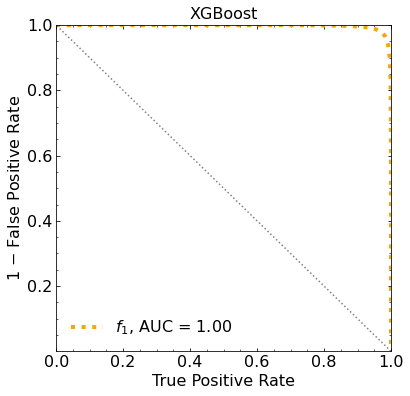

Classification score (1 ML):


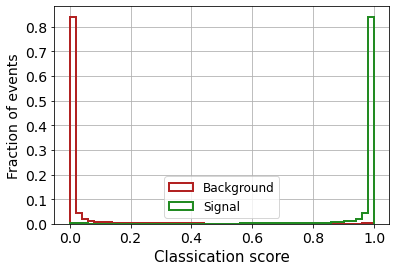

Classification score (10 ML):


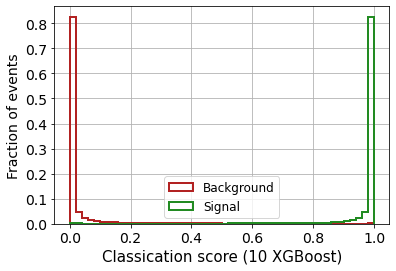

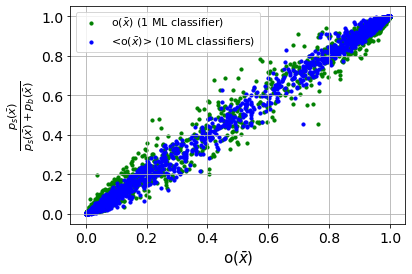


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  19.136817388766435
Z_XG 25 bins_1ML:  21.83908828695275
Z_XG 50 bins_1ML:  23.58085161502932
Z_XG 100 bins_1ML:  24.75940268099932

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  5.326471252897206
Z_XG 25 bins_eq_1ML:  8.03598547287715
Z_XG 50 bins_eq_1ML:  10.600327862363951
Z_XG 100 bins_eq_1ML:  13.401464125797874

 BL lineal bins, 10 ML
Z_XG 10 bins:  19.701033706000572
Z_XG 25 bins:  22.437734625080555
Z_XG 50 bins:  24.014547478708973
Z_XG 100 bins:  25.040977728946327

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  5.306282367618018
Z_XG 25 bins_eq:  8.010386578452577
Z_XG 50 bins_eq:  10.57418062033249
Z_XG 100 bins_eq:  13.375277741530114

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD (G

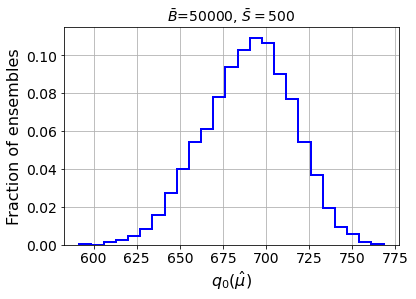

muhat mean:  0.012019669471763157
Z_gaussian:  26.290254408601296
Z_gaussian_mu0:  26.353052713628255

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 12577.00070866 11775.57385538
 10904.45357006  9975.79020214  8990.43129876  7954.6394772
  6865.38580059  5732.24644533  4555.92980115  3347.60062375
  2112.58873356   846.43751665  -440.86852137 -1729.9740181 ]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 13912.53782339 13238.64288509 12497.41910503 11692.61932864
 10833.56456409  9899.08424665  8914.21171995  7877.25596766
  678

KDE Kernel:  epanechnikov
Background bandwidth:  0.0091866653175426
Signal bandwidth:  0.004386370005779536


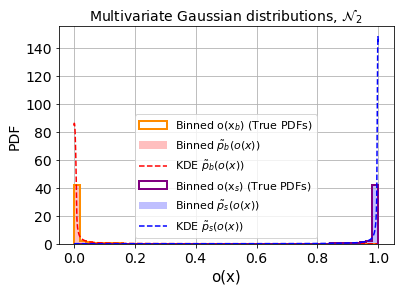

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 12933.87333757 12248.4897093  11492.20243936
 10667.27185057  9781.8640399   8834.99596737  7829.28927059
  6766.57759337  5658.7452092   4509.60357188  3324.12037795
  2107.00743692   853.74560533  -433.99048568 -1726.20996803]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 13491.09862393 12882.06342864 12185.57081396 11423.88453388
 10600.37965194  9715.17153908  8764.61204607  7762.63081837
  67

KDE Kernel:  epanechnikov
Background bandwidth:  0.0063479219593504735
Signal bandwidth:  0.004386370005779536


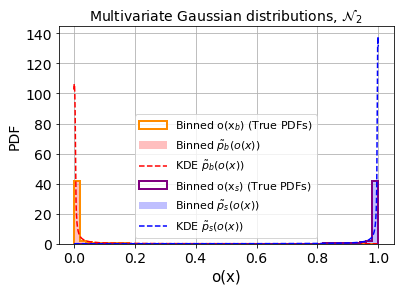

 Z MLL+KDE (1ML) 


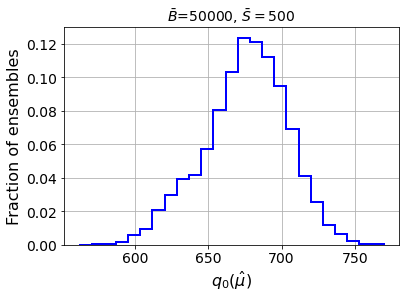

muhat mean_1ML:  0.0067930649903680425
Z_KDE_1ML:  26.027605353094458
Z_KDE mu=0_1ML:  26.027746297339963

 Z MLL+KDE (10ML) 


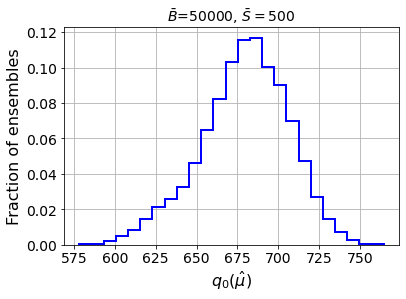

muhat mean:  0.005196187772483017
Z_KDE:  26.098831365905017
Z_KDE mu=0:  26.09917733078097

 ------------------------------------ 



In [21]:
dim=8

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3, signal_X_4, signal_X_5, signal_X_6, signal_X_7, signal_X_8 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3, background_X_4, background_X_5, background_X_6, background_X_7, background_X_8 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T


dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))
dim6 = np.concatenate((background_X_6,signal_X_6))
dim7 = np.concatenate((background_X_7,signal_X_7))
dim8 = np.concatenate((background_X_8,signal_X_8))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['dim6'] = dim6.reshape(-1)
df['dim7'] = dim7.reshape(-1)
df['dim8'] = dim8.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5','dim6','dim7','dim8']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML)


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP)


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [ ]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 9)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 9)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 9)
y_gauss_test :  (1000000, 1)



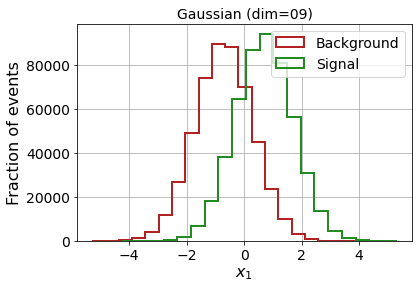

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62589	validation_1-logloss:0.62623
[1]	validation_0-logloss:0.56795	validation_1-logloss:0.56847
[2]	validation_0-logloss:0.51834	validation_1-logloss:0.51905
[3]	validation_0-logloss:0.47500	validation_1-logloss:0.47581
[4]	validation_0-logloss:0.43693	validation_1-logloss:0.43785
[5]	validation_0-logloss:0.40334	validation_1-logloss:0.40437
[6]	validation_0-logloss:0.37350	validation_1-logloss:0.37458
[7]	validation_0-logloss:0.34679	validation_1-logloss:0.34786
[8]	validation_0-logloss:0.32299	validation_1-logloss:0.32413
[9]	validation_0-logloss:0.30156	validation_1-logloss:0.30268
[10]	validation_0-logloss:0.28215	validation_1-logloss:0.28330
[11]	validation_0-logloss:0.26464	validation_1-logloss:0.26582
[12]	validation_0-logloss:0.24874	validation_1-logloss:0.24998
[13]	validation_0-logloss:0.23431	validation_1-logloss:0.23554
[14]	validation_0-logloss:0.22121	validation_1-logloss:0.22245
[15]	validation_0-logloss:0.20922	validation_1-logloss:0.21046
[1

[130]	validation_0-logloss:0.04797	validation_1-logloss:0.05098
[131]	validation_0-logloss:0.04791	validation_1-logloss:0.05092
[132]	validation_0-logloss:0.04784	validation_1-logloss:0.05087
[133]	validation_0-logloss:0.04777	validation_1-logloss:0.05081
[134]	validation_0-logloss:0.04771	validation_1-logloss:0.05076
[135]	validation_0-logloss:0.04765	validation_1-logloss:0.05071
[136]	validation_0-logloss:0.04759	validation_1-logloss:0.05066
[137]	validation_0-logloss:0.04753	validation_1-logloss:0.05061
[138]	validation_0-logloss:0.04747	validation_1-logloss:0.05057
[139]	validation_0-logloss:0.04741	validation_1-logloss:0.05053
[140]	validation_0-logloss:0.04736	validation_1-logloss:0.05049
[141]	validation_0-logloss:0.04731	validation_1-logloss:0.05044
[142]	validation_0-logloss:0.04726	validation_1-logloss:0.05041
[143]	validation_0-logloss:0.04721	validation_1-logloss:0.05037
[144]	validation_0-logloss:0.04715	validation_1-logloss:0.05033
[145]	validation_0-logloss:0.04710	valid

[259]	validation_0-logloss:0.04453	validation_1-logloss:0.04897
[260]	validation_0-logloss:0.04452	validation_1-logloss:0.04896
[261]	validation_0-logloss:0.04451	validation_1-logloss:0.04896
[262]	validation_0-logloss:0.04451	validation_1-logloss:0.04896
[263]	validation_0-logloss:0.04450	validation_1-logloss:0.04896
[264]	validation_0-logloss:0.04448	validation_1-logloss:0.04896
[265]	validation_0-logloss:0.04446	validation_1-logloss:0.04896
[266]	validation_0-logloss:0.04446	validation_1-logloss:0.04895
[267]	validation_0-logloss:0.04444	validation_1-logloss:0.04896
[268]	validation_0-logloss:0.04443	validation_1-logloss:0.04895
[269]	validation_0-logloss:0.04442	validation_1-logloss:0.04895
[270]	validation_0-logloss:0.04441	validation_1-logloss:0.04895
[271]	validation_0-logloss:0.04441	validation_1-logloss:0.04895
[272]	validation_0-logloss:0.04440	validation_1-logloss:0.04895
[273]	validation_0-logloss:0.04439	validation_1-logloss:0.04895
[274]	validation_0-logloss:0.04438	valid

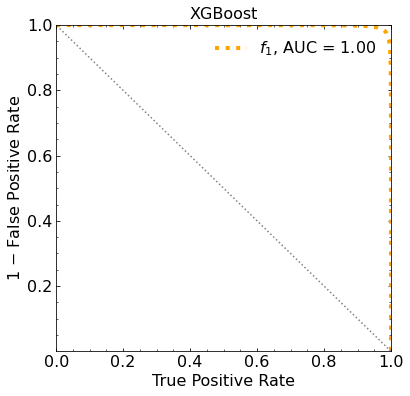

ML iteration 0
[0]	validation_0-logloss:0.62454	validation_1-logloss:0.62559
[1]	validation_0-logloss:0.56571	validation_1-logloss:0.56766


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2]	validation_0-logloss:0.51552	validation_1-logloss:0.51823
[3]	validation_0-logloss:0.47187	validation_1-logloss:0.47510
[4]	validation_0-logloss:0.43318	validation_1-logloss:0.43700
[5]	validation_0-logloss:0.39911	validation_1-logloss:0.40339
[6]	validation_0-logloss:0.36909	validation_1-logloss:0.37377
[7]	validation_0-logloss:0.34215	validation_1-logloss:0.34704
[8]	validation_0-logloss:0.31814	validation_1-logloss:0.32326
[9]	validation_0-logloss:0.29642	validation_1-logloss:0.30164
[10]	validation_0-logloss:0.27695	validation_1-logloss:0.28238
[11]	validation_0-logloss:0.25924	validation_1-logloss:0.26491
[12]	validation_0-logloss:0.24313	validation_1-logloss:0.24897
[13]	validation_0-logloss:0.22852	validation_1-logloss:0.23453
[14]	validation_0-logloss:0.21520	validation_1-logloss:0.22140
[15]	validation_0-logloss:0.20305	validation_1-logloss:0.20948
[16]	validation_0-logloss:0.19196	validation_1-logloss:0.19856
[17]	validation_0-logloss:0.18174	validation_1-logloss:0.18843


[132]	validation_0-logloss:0.03707	validation_1-logloss:0.05201
[133]	validation_0-logloss:0.03697	validation_1-logloss:0.05197
[134]	validation_0-logloss:0.03689	validation_1-logloss:0.05194
[135]	validation_0-logloss:0.03681	validation_1-logloss:0.05189
[136]	validation_0-logloss:0.03673	validation_1-logloss:0.05186
[137]	validation_0-logloss:0.03662	validation_1-logloss:0.05182
[138]	validation_0-logloss:0.03657	validation_1-logloss:0.05178
[139]	validation_0-logloss:0.03646	validation_1-logloss:0.05174
[140]	validation_0-logloss:0.03634	validation_1-logloss:0.05173
[141]	validation_0-logloss:0.03624	validation_1-logloss:0.05171
[142]	validation_0-logloss:0.03615	validation_1-logloss:0.05168
[143]	validation_0-logloss:0.03608	validation_1-logloss:0.05165
[144]	validation_0-logloss:0.03602	validation_1-logloss:0.05163
[145]	validation_0-logloss:0.03596	validation_1-logloss:0.05160
[146]	validation_0-logloss:0.03586	validation_1-logloss:0.05158
[147]	validation_0-logloss:0.03575	valid

[261]	validation_0-logloss:0.03030	validation_1-logloss:0.05106
[262]	validation_0-logloss:0.03024	validation_1-logloss:0.05108
[263]	validation_0-logloss:0.03020	validation_1-logloss:0.05108
[264]	validation_0-logloss:0.03014	validation_1-logloss:0.05108
[265]	validation_0-logloss:0.03011	validation_1-logloss:0.05108
[266]	validation_0-logloss:0.03010	validation_1-logloss:0.05108
[267]	validation_0-logloss:0.03009	validation_1-logloss:0.05108
[268]	validation_0-logloss:0.03003	validation_1-logloss:0.05109
[269]	validation_0-logloss:0.03002	validation_1-logloss:0.05109
[270]	validation_0-logloss:0.02997	validation_1-logloss:0.05110
[271]	validation_0-logloss:0.02994	validation_1-logloss:0.05110
[272]	validation_0-logloss:0.02988	validation_1-logloss:0.05110
[273]	validation_0-logloss:0.02985	validation_1-logloss:0.05111
[274]	validation_0-logloss:0.02979	validation_1-logloss:0.05112
[275]	validation_0-logloss:0.02976	validation_1-logloss:0.05113
[276]	validation_0-logloss:0.02968	valid

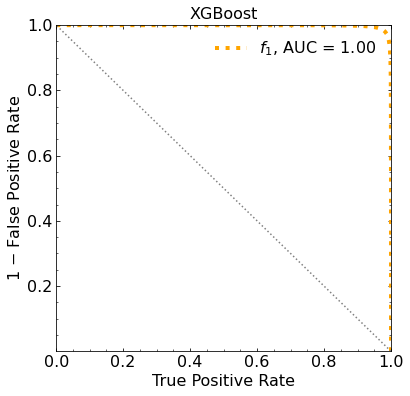

ML iteration  1
[0]	validation_0-logloss:0.62476	validation_1-logloss:0.62574
[1]	validation_0-logloss:0.56624	validation_1-logloss:0.56786
[2]	validation_0-logloss:0.51601	validation_1-logloss:0.51838


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47213	validation_1-logloss:0.47510
[4]	validation_0-logloss:0.43375	validation_1-logloss:0.43717
[5]	validation_0-logloss:0.39993	validation_1-logloss:0.40387
[6]	validation_0-logloss:0.36964	validation_1-logloss:0.37391
[7]	validation_0-logloss:0.34250	validation_1-logloss:0.34699
[8]	validation_0-logloss:0.31841	validation_1-logloss:0.32318
[9]	validation_0-logloss:0.29661	validation_1-logloss:0.30166
[10]	validation_0-logloss:0.27691	validation_1-logloss:0.28215
[11]	validation_0-logloss:0.25923	validation_1-logloss:0.26466
[12]	validation_0-logloss:0.24316	validation_1-logloss:0.24884
[13]	validation_0-logloss:0.22860	validation_1-logloss:0.23437
[14]	validation_0-logloss:0.21528	validation_1-logloss:0.22126
[15]	validation_0-logloss:0.20318	validation_1-logloss:0.20926
[16]	validation_0-logloss:0.19207	validation_1-logloss:0.19837
[17]	validation_0-logloss:0.18188	validation_1-logloss:0.18830
[18]	validation_0-logloss:0.17258	validation_1-logloss:0.17914

[133]	validation_0-logloss:0.03708	validation_1-logloss:0.05213
[134]	validation_0-logloss:0.03703	validation_1-logloss:0.05209
[135]	validation_0-logloss:0.03695	validation_1-logloss:0.05207
[136]	validation_0-logloss:0.03689	validation_1-logloss:0.05203
[137]	validation_0-logloss:0.03680	validation_1-logloss:0.05200
[138]	validation_0-logloss:0.03673	validation_1-logloss:0.05197
[139]	validation_0-logloss:0.03667	validation_1-logloss:0.05194
[140]	validation_0-logloss:0.03658	validation_1-logloss:0.05189
[141]	validation_0-logloss:0.03647	validation_1-logloss:0.05187
[142]	validation_0-logloss:0.03639	validation_1-logloss:0.05184
[143]	validation_0-logloss:0.03635	validation_1-logloss:0.05182
[144]	validation_0-logloss:0.03628	validation_1-logloss:0.05180
[145]	validation_0-logloss:0.03623	validation_1-logloss:0.05176
[146]	validation_0-logloss:0.03616	validation_1-logloss:0.05173
[147]	validation_0-logloss:0.03609	validation_1-logloss:0.05170
[148]	validation_0-logloss:0.03602	valid

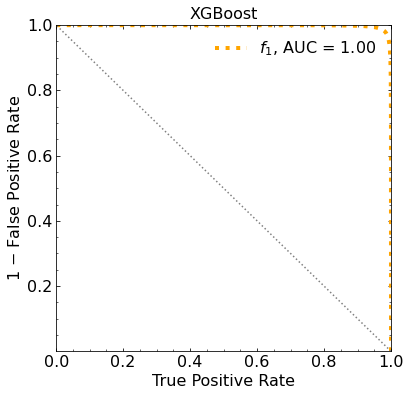

ML iteration  2
[0]	validation_0-logloss:0.62478	validation_1-logloss:0.62601
[1]	validation_0-logloss:0.56619	validation_1-logloss:0.56810
[2]	validation_0-logloss:0.51577	validation_1-logloss:0.51835


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47206	validation_1-logloss:0.47529
[4]	validation_0-logloss:0.43348	validation_1-logloss:0.43710
[5]	validation_0-logloss:0.39950	validation_1-logloss:0.40345
[6]	validation_0-logloss:0.36930	validation_1-logloss:0.37366
[7]	validation_0-logloss:0.34234	validation_1-logloss:0.34696
[8]	validation_0-logloss:0.31808	validation_1-logloss:0.32310
[9]	validation_0-logloss:0.29640	validation_1-logloss:0.30168
[10]	validation_0-logloss:0.27679	validation_1-logloss:0.28229
[11]	validation_0-logloss:0.25925	validation_1-logloss:0.26493
[12]	validation_0-logloss:0.24319	validation_1-logloss:0.24897
[13]	validation_0-logloss:0.22865	validation_1-logloss:0.23459
[14]	validation_0-logloss:0.21542	validation_1-logloss:0.22151
[15]	validation_0-logloss:0.20331	validation_1-logloss:0.20946
[16]	validation_0-logloss:0.19222	validation_1-logloss:0.19850
[17]	validation_0-logloss:0.18211	validation_1-logloss:0.18852
[18]	validation_0-logloss:0.17272	validation_1-logloss:0.17923

[133]	validation_0-logloss:0.03768	validation_1-logloss:0.05178
[134]	validation_0-logloss:0.03757	validation_1-logloss:0.05174
[135]	validation_0-logloss:0.03750	validation_1-logloss:0.05171
[136]	validation_0-logloss:0.03741	validation_1-logloss:0.05168
[137]	validation_0-logloss:0.03734	validation_1-logloss:0.05165
[138]	validation_0-logloss:0.03727	validation_1-logloss:0.05161
[139]	validation_0-logloss:0.03723	validation_1-logloss:0.05158
[140]	validation_0-logloss:0.03714	validation_1-logloss:0.05154
[141]	validation_0-logloss:0.03707	validation_1-logloss:0.05151
[142]	validation_0-logloss:0.03698	validation_1-logloss:0.05148
[143]	validation_0-logloss:0.03693	validation_1-logloss:0.05144
[144]	validation_0-logloss:0.03690	validation_1-logloss:0.05142
[145]	validation_0-logloss:0.03683	validation_1-logloss:0.05140
[146]	validation_0-logloss:0.03676	validation_1-logloss:0.05138
[147]	validation_0-logloss:0.03670	validation_1-logloss:0.05136
[148]	validation_0-logloss:0.03660	valid

[262]	validation_0-logloss:0.03164	validation_1-logloss:0.05085


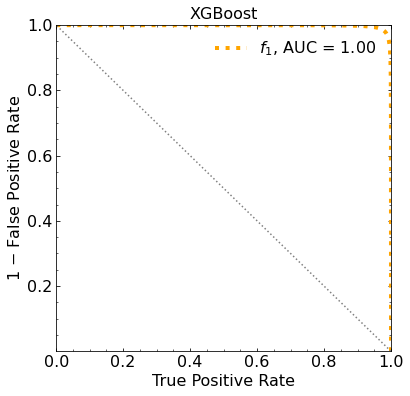

ML iteration  3
[0]	validation_0-logloss:0.62415	validation_1-logloss:0.62520
[1]	validation_0-logloss:0.56590	validation_1-logloss:0.56787
[2]	validation_0-logloss:0.51546	validation_1-logloss:0.51830


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47141	validation_1-logloss:0.47493
[4]	validation_0-logloss:0.43301	validation_1-logloss:0.43696
[5]	validation_0-logloss:0.39909	validation_1-logloss:0.40334
[6]	validation_0-logloss:0.36881	validation_1-logloss:0.37342
[7]	validation_0-logloss:0.34176	validation_1-logloss:0.34676
[8]	validation_0-logloss:0.31769	validation_1-logloss:0.32297
[9]	validation_0-logloss:0.29581	validation_1-logloss:0.30129
[10]	validation_0-logloss:0.27630	validation_1-logloss:0.28201
[11]	validation_0-logloss:0.25849	validation_1-logloss:0.26447
[12]	validation_0-logloss:0.24249	validation_1-logloss:0.24868
[13]	validation_0-logloss:0.22799	validation_1-logloss:0.23428
[14]	validation_0-logloss:0.21472	validation_1-logloss:0.22114
[15]	validation_0-logloss:0.20261	validation_1-logloss:0.20919
[16]	validation_0-logloss:0.19148	validation_1-logloss:0.19816
[17]	validation_0-logloss:0.18138	validation_1-logloss:0.18816
[18]	validation_0-logloss:0.17207	validation_1-logloss:0.17896

[133]	validation_0-logloss:0.03678	validation_1-logloss:0.05196
[134]	validation_0-logloss:0.03669	validation_1-logloss:0.05192
[135]	validation_0-logloss:0.03663	validation_1-logloss:0.05188
[136]	validation_0-logloss:0.03652	validation_1-logloss:0.05185
[137]	validation_0-logloss:0.03643	validation_1-logloss:0.05182
[138]	validation_0-logloss:0.03634	validation_1-logloss:0.05180
[139]	validation_0-logloss:0.03625	validation_1-logloss:0.05176
[140]	validation_0-logloss:0.03618	validation_1-logloss:0.05172
[141]	validation_0-logloss:0.03608	validation_1-logloss:0.05168
[142]	validation_0-logloss:0.03601	validation_1-logloss:0.05166
[143]	validation_0-logloss:0.03596	validation_1-logloss:0.05164
[144]	validation_0-logloss:0.03589	validation_1-logloss:0.05160
[145]	validation_0-logloss:0.03583	validation_1-logloss:0.05159
[146]	validation_0-logloss:0.03572	validation_1-logloss:0.05156
[147]	validation_0-logloss:0.03567	validation_1-logloss:0.05154
[148]	validation_0-logloss:0.03562	valid

[262]	validation_0-logloss:0.03024	validation_1-logloss:0.05114
[263]	validation_0-logloss:0.03021	validation_1-logloss:0.05114
[264]	validation_0-logloss:0.03020	validation_1-logloss:0.05114
[265]	validation_0-logloss:0.03014	validation_1-logloss:0.05115
[266]	validation_0-logloss:0.03011	validation_1-logloss:0.05115


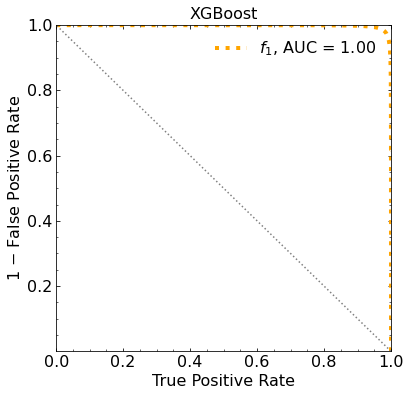

ML iteration  4


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62453	validation_1-logloss:0.62580
[1]	validation_0-logloss:0.56588	validation_1-logloss:0.56790
[2]	validation_0-logloss:0.51563	validation_1-logloss:0.51823
[3]	validation_0-logloss:0.47177	validation_1-logloss:0.47508
[4]	validation_0-logloss:0.43308	validation_1-logloss:0.43686
[5]	validation_0-logloss:0.39899	validation_1-logloss:0.40319
[6]	validation_0-logloss:0.36886	validation_1-logloss:0.37344
[7]	validation_0-logloss:0.34199	validation_1-logloss:0.34702
[8]	validation_0-logloss:0.31782	validation_1-logloss:0.32310
[9]	validation_0-logloss:0.29613	validation_1-logloss:0.30166
[10]	validation_0-logloss:0.27656	validation_1-logloss:0.28225
[11]	validation_0-logloss:0.25884	validation_1-logloss:0.26475
[12]	validation_0-logloss:0.24279	validation_1-logloss:0.24893
[13]	validation_0-logloss:0.22810	validation_1-logloss:0.23449
[14]	validation_0-logloss:0.21473	validation_1-logloss:0.22131
[15]	validation_0-logloss:0.20266	validation_1-logloss:0.20935
[1

[130]	validation_0-logloss:0.03709	validation_1-logloss:0.05206
[131]	validation_0-logloss:0.03701	validation_1-logloss:0.05201
[132]	validation_0-logloss:0.03694	validation_1-logloss:0.05197
[133]	validation_0-logloss:0.03685	validation_1-logloss:0.05193
[134]	validation_0-logloss:0.03676	validation_1-logloss:0.05189
[135]	validation_0-logloss:0.03669	validation_1-logloss:0.05185
[136]	validation_0-logloss:0.03662	validation_1-logloss:0.05181
[137]	validation_0-logloss:0.03656	validation_1-logloss:0.05177
[138]	validation_0-logloss:0.03647	validation_1-logloss:0.05174
[139]	validation_0-logloss:0.03636	validation_1-logloss:0.05171
[140]	validation_0-logloss:0.03631	validation_1-logloss:0.05168
[141]	validation_0-logloss:0.03626	validation_1-logloss:0.05165
[142]	validation_0-logloss:0.03616	validation_1-logloss:0.05163
[143]	validation_0-logloss:0.03607	validation_1-logloss:0.05160
[144]	validation_0-logloss:0.03597	validation_1-logloss:0.05157
[145]	validation_0-logloss:0.03593	valid

[259]	validation_0-logloss:0.03059	validation_1-logloss:0.05097
[260]	validation_0-logloss:0.03058	validation_1-logloss:0.05097
[261]	validation_0-logloss:0.03052	validation_1-logloss:0.05097
[262]	validation_0-logloss:0.03047	validation_1-logloss:0.05098
[263]	validation_0-logloss:0.03045	validation_1-logloss:0.05098
[264]	validation_0-logloss:0.03044	validation_1-logloss:0.05098
[265]	validation_0-logloss:0.03043	validation_1-logloss:0.05098


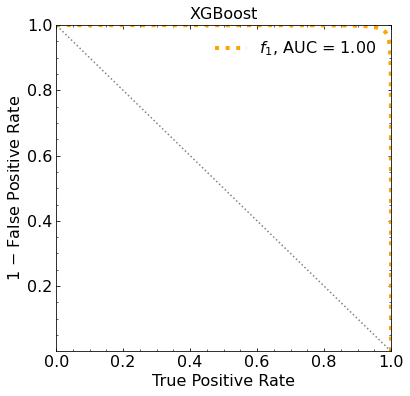

ML iteration  5
[0]	validation_0-logloss:0.62443	validation_1-logloss:0.62566
[1]	validation_0-logloss:0.56615	validation_1-logloss:0.56830
[2]	validation_0-logloss:0.51565	validation_1-logloss:0.51861


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47171	validation_1-logloss:0.47509
[4]	validation_0-logloss:0.43333	validation_1-logloss:0.43720
[5]	validation_0-logloss:0.39914	validation_1-logloss:0.40340
[6]	validation_0-logloss:0.36899	validation_1-logloss:0.37367
[7]	validation_0-logloss:0.34207	validation_1-logloss:0.34694
[8]	validation_0-logloss:0.31798	validation_1-logloss:0.32305
[9]	validation_0-logloss:0.29635	validation_1-logloss:0.30169
[10]	validation_0-logloss:0.27688	validation_1-logloss:0.28234
[11]	validation_0-logloss:0.25928	validation_1-logloss:0.26493
[12]	validation_0-logloss:0.24319	validation_1-logloss:0.24898
[13]	validation_0-logloss:0.22853	validation_1-logloss:0.23448
[14]	validation_0-logloss:0.21531	validation_1-logloss:0.22136
[15]	validation_0-logloss:0.20326	validation_1-logloss:0.20940
[16]	validation_0-logloss:0.19214	validation_1-logloss:0.19846
[17]	validation_0-logloss:0.18191	validation_1-logloss:0.18842
[18]	validation_0-logloss:0.17258	validation_1-logloss:0.17923

[133]	validation_0-logloss:0.03708	validation_1-logloss:0.05187
[134]	validation_0-logloss:0.03701	validation_1-logloss:0.05184
[135]	validation_0-logloss:0.03691	validation_1-logloss:0.05180
[136]	validation_0-logloss:0.03683	validation_1-logloss:0.05176
[137]	validation_0-logloss:0.03673	validation_1-logloss:0.05171
[138]	validation_0-logloss:0.03666	validation_1-logloss:0.05168
[139]	validation_0-logloss:0.03659	validation_1-logloss:0.05165
[140]	validation_0-logloss:0.03651	validation_1-logloss:0.05162
[141]	validation_0-logloss:0.03640	validation_1-logloss:0.05159
[142]	validation_0-logloss:0.03632	validation_1-logloss:0.05156
[143]	validation_0-logloss:0.03621	validation_1-logloss:0.05154
[144]	validation_0-logloss:0.03615	validation_1-logloss:0.05152
[145]	validation_0-logloss:0.03608	validation_1-logloss:0.05149
[146]	validation_0-logloss:0.03596	validation_1-logloss:0.05147
[147]	validation_0-logloss:0.03585	validation_1-logloss:0.05145
[148]	validation_0-logloss:0.03580	valid

[262]	validation_0-logloss:0.03059	validation_1-logloss:0.05095
[263]	validation_0-logloss:0.03057	validation_1-logloss:0.05095


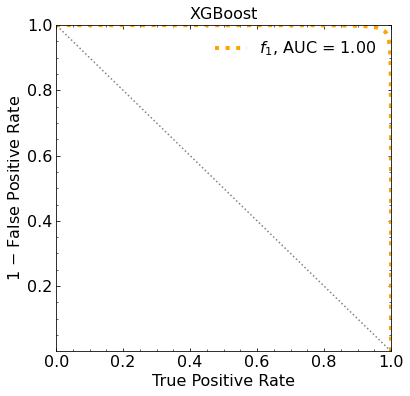

ML iteration  6
[0]	validation_0-logloss:0.62422	validation_1-logloss:0.62576
[1]	validation_0-logloss:0.56544	validation_1-logloss:0.56793
[2]	validation_0-logloss:0.51472	validation_1-logloss:0.51819


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47081	validation_1-logloss:0.47492
[4]	validation_0-logloss:0.43217	validation_1-logloss:0.43691
[5]	validation_0-logloss:0.39825	validation_1-logloss:0.40348
[6]	validation_0-logloss:0.36793	validation_1-logloss:0.37364
[7]	validation_0-logloss:0.34080	validation_1-logloss:0.34682
[8]	validation_0-logloss:0.31670	validation_1-logloss:0.32307
[9]	validation_0-logloss:0.29491	validation_1-logloss:0.30158
[10]	validation_0-logloss:0.27509	validation_1-logloss:0.28208
[11]	validation_0-logloss:0.25749	validation_1-logloss:0.26473
[12]	validation_0-logloss:0.24141	validation_1-logloss:0.24883
[13]	validation_0-logloss:0.22679	validation_1-logloss:0.23435
[14]	validation_0-logloss:0.21351	validation_1-logloss:0.22120
[15]	validation_0-logloss:0.20144	validation_1-logloss:0.20924
[16]	validation_0-logloss:0.19032	validation_1-logloss:0.19819
[17]	validation_0-logloss:0.18017	validation_1-logloss:0.18815
[18]	validation_0-logloss:0.17081	validation_1-logloss:0.17887

[133]	validation_0-logloss:0.03598	validation_1-logloss:0.05192
[134]	validation_0-logloss:0.03592	validation_1-logloss:0.05190
[135]	validation_0-logloss:0.03579	validation_1-logloss:0.05187
[136]	validation_0-logloss:0.03572	validation_1-logloss:0.05185
[137]	validation_0-logloss:0.03566	validation_1-logloss:0.05181
[138]	validation_0-logloss:0.03559	validation_1-logloss:0.05178
[139]	validation_0-logloss:0.03550	validation_1-logloss:0.05173
[140]	validation_0-logloss:0.03544	validation_1-logloss:0.05170
[141]	validation_0-logloss:0.03539	validation_1-logloss:0.05167
[142]	validation_0-logloss:0.03531	validation_1-logloss:0.05164
[143]	validation_0-logloss:0.03519	validation_1-logloss:0.05162
[144]	validation_0-logloss:0.03514	validation_1-logloss:0.05159
[145]	validation_0-logloss:0.03510	validation_1-logloss:0.05156
[146]	validation_0-logloss:0.03504	validation_1-logloss:0.05153
[147]	validation_0-logloss:0.03498	validation_1-logloss:0.05150
[148]	validation_0-logloss:0.03489	valid

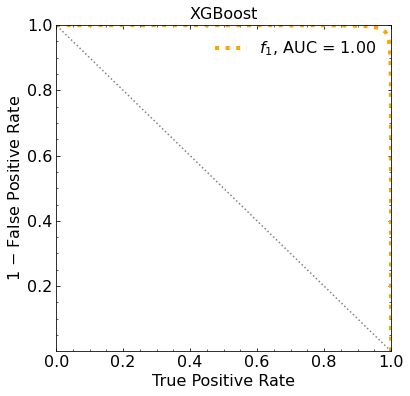

ML iteration  7
[0]	validation_0-logloss:0.62424	validation_1-logloss:0.62539
[1]	validation_0-logloss:0.56558	validation_1-logloss:0.56795
[2]	validation_0-logloss:0.51508	validation_1-logloss:0.51817


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47106	validation_1-logloss:0.47483
[4]	validation_0-logloss:0.43265	validation_1-logloss:0.43685
[5]	validation_0-logloss:0.39847	validation_1-logloss:0.40311
[6]	validation_0-logloss:0.36820	validation_1-logloss:0.37322
[7]	validation_0-logloss:0.34136	validation_1-logloss:0.34663
[8]	validation_0-logloss:0.31728	validation_1-logloss:0.32283
[9]	validation_0-logloss:0.29571	validation_1-logloss:0.30151
[10]	validation_0-logloss:0.27620	validation_1-logloss:0.28216
[11]	validation_0-logloss:0.25851	validation_1-logloss:0.26466
[12]	validation_0-logloss:0.24237	validation_1-logloss:0.24878
[13]	validation_0-logloss:0.22785	validation_1-logloss:0.23442
[14]	validation_0-logloss:0.21469	validation_1-logloss:0.22132
[15]	validation_0-logloss:0.20266	validation_1-logloss:0.20938
[16]	validation_0-logloss:0.19162	validation_1-logloss:0.19843
[17]	validation_0-logloss:0.18145	validation_1-logloss:0.18836
[18]	validation_0-logloss:0.17221	validation_1-logloss:0.17925

[133]	validation_0-logloss:0.03751	validation_1-logloss:0.05199
[134]	validation_0-logloss:0.03742	validation_1-logloss:0.05195
[135]	validation_0-logloss:0.03736	validation_1-logloss:0.05193
[136]	validation_0-logloss:0.03730	validation_1-logloss:0.05190
[137]	validation_0-logloss:0.03723	validation_1-logloss:0.05187
[138]	validation_0-logloss:0.03716	validation_1-logloss:0.05183
[139]	validation_0-logloss:0.03705	validation_1-logloss:0.05178
[140]	validation_0-logloss:0.03700	validation_1-logloss:0.05174
[141]	validation_0-logloss:0.03693	validation_1-logloss:0.05171
[142]	validation_0-logloss:0.03686	validation_1-logloss:0.05169
[143]	validation_0-logloss:0.03678	validation_1-logloss:0.05166
[144]	validation_0-logloss:0.03672	validation_1-logloss:0.05165
[145]	validation_0-logloss:0.03663	validation_1-logloss:0.05162
[146]	validation_0-logloss:0.03657	validation_1-logloss:0.05160
[147]	validation_0-logloss:0.03646	validation_1-logloss:0.05157
[148]	validation_0-logloss:0.03633	valid

[262]	validation_0-logloss:0.03127	validation_1-logloss:0.05092
[263]	validation_0-logloss:0.03126	validation_1-logloss:0.05092
[264]	validation_0-logloss:0.03118	validation_1-logloss:0.05092
[265]	validation_0-logloss:0.03115	validation_1-logloss:0.05092
[266]	validation_0-logloss:0.03113	validation_1-logloss:0.05092
[267]	validation_0-logloss:0.03112	validation_1-logloss:0.05092
[268]	validation_0-logloss:0.03107	validation_1-logloss:0.05093
[269]	validation_0-logloss:0.03104	validation_1-logloss:0.05093
[270]	validation_0-logloss:0.03097	validation_1-logloss:0.05093
[271]	validation_0-logloss:0.03094	validation_1-logloss:0.05093
[272]	validation_0-logloss:0.03089	validation_1-logloss:0.05093
[273]	validation_0-logloss:0.03087	validation_1-logloss:0.05093
[274]	validation_0-logloss:0.03084	validation_1-logloss:0.05094
[275]	validation_0-logloss:0.03078	validation_1-logloss:0.05094
[276]	validation_0-logloss:0.03073	validation_1-logloss:0.05094
[277]	validation_0-logloss:0.03069	valid

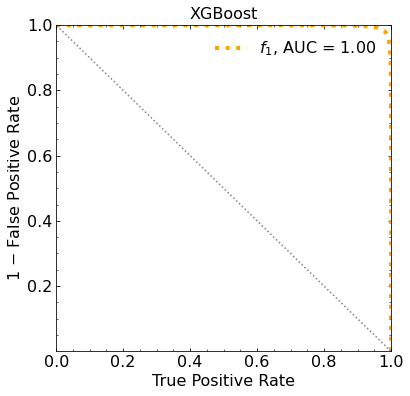

ML iteration  8
[0]	validation_0-logloss:0.62435	validation_1-logloss:0.62542
[1]	validation_0-logloss:0.56566	validation_1-logloss:0.56783
[2]	validation_0-logloss:0.51530	validation_1-logloss:0.51828


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47126	validation_1-logloss:0.47485
[4]	validation_0-logloss:0.43273	validation_1-logloss:0.43682
[5]	validation_0-logloss:0.39877	validation_1-logloss:0.40331
[6]	validation_0-logloss:0.36853	validation_1-logloss:0.37352
[7]	validation_0-logloss:0.34152	validation_1-logloss:0.34691
[8]	validation_0-logloss:0.31752	validation_1-logloss:0.32324
[9]	validation_0-logloss:0.29597	validation_1-logloss:0.30195
[10]	validation_0-logloss:0.27628	validation_1-logloss:0.28258
[11]	validation_0-logloss:0.25849	validation_1-logloss:0.26496
[12]	validation_0-logloss:0.24243	validation_1-logloss:0.24904
[13]	validation_0-logloss:0.22764	validation_1-logloss:0.23445
[14]	validation_0-logloss:0.21441	validation_1-logloss:0.22132
[15]	validation_0-logloss:0.20231	validation_1-logloss:0.20930
[16]	validation_0-logloss:0.19124	validation_1-logloss:0.19833
[17]	validation_0-logloss:0.18102	validation_1-logloss:0.18818
[18]	validation_0-logloss:0.17173	validation_1-logloss:0.17904

[133]	validation_0-logloss:0.03691	validation_1-logloss:0.05209
[134]	validation_0-logloss:0.03685	validation_1-logloss:0.05205
[135]	validation_0-logloss:0.03677	validation_1-logloss:0.05202
[136]	validation_0-logloss:0.03664	validation_1-logloss:0.05200
[137]	validation_0-logloss:0.03657	validation_1-logloss:0.05196
[138]	validation_0-logloss:0.03647	validation_1-logloss:0.05192
[139]	validation_0-logloss:0.03634	validation_1-logloss:0.05188
[140]	validation_0-logloss:0.03629	validation_1-logloss:0.05186
[141]	validation_0-logloss:0.03621	validation_1-logloss:0.05183
[142]	validation_0-logloss:0.03610	validation_1-logloss:0.05180
[143]	validation_0-logloss:0.03602	validation_1-logloss:0.05177
[144]	validation_0-logloss:0.03595	validation_1-logloss:0.05175
[145]	validation_0-logloss:0.03589	validation_1-logloss:0.05172
[146]	validation_0-logloss:0.03581	validation_1-logloss:0.05168
[147]	validation_0-logloss:0.03574	validation_1-logloss:0.05165
[148]	validation_0-logloss:0.03564	valid

[262]	validation_0-logloss:0.03023	validation_1-logloss:0.05123
[263]	validation_0-logloss:0.03019	validation_1-logloss:0.05123
[264]	validation_0-logloss:0.03017	validation_1-logloss:0.05124
[265]	validation_0-logloss:0.03013	validation_1-logloss:0.05124
[266]	validation_0-logloss:0.03006	validation_1-logloss:0.05125


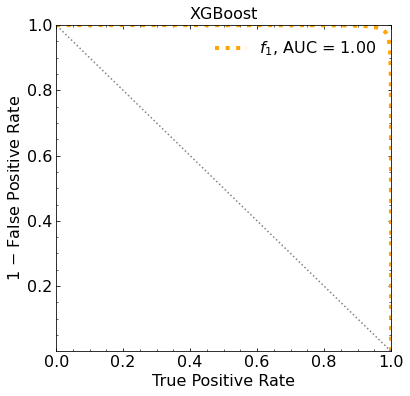

ML iteration  9
[0]	validation_0-logloss:0.62420	validation_1-logloss:0.62518
[1]	validation_0-logloss:0.56606	validation_1-logloss:0.56803
[2]	validation_0-logloss:0.51576	validation_1-logloss:0.51823


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47209	validation_1-logloss:0.47521
[4]	validation_0-logloss:0.43362	validation_1-logloss:0.43702
[5]	validation_0-logloss:0.39965	validation_1-logloss:0.40333
[6]	validation_0-logloss:0.36961	validation_1-logloss:0.37361
[7]	validation_0-logloss:0.34281	validation_1-logloss:0.34723
[8]	validation_0-logloss:0.31876	validation_1-logloss:0.32344
[9]	validation_0-logloss:0.29716	validation_1-logloss:0.30204
[10]	validation_0-logloss:0.27769	validation_1-logloss:0.28277
[11]	validation_0-logloss:0.26004	validation_1-logloss:0.26525
[12]	validation_0-logloss:0.24404	validation_1-logloss:0.24941
[13]	validation_0-logloss:0.22953	validation_1-logloss:0.23503
[14]	validation_0-logloss:0.21625	validation_1-logloss:0.22184
[15]	validation_0-logloss:0.20414	validation_1-logloss:0.20984
[16]	validation_0-logloss:0.19306	validation_1-logloss:0.19890
[17]	validation_0-logloss:0.18296	validation_1-logloss:0.18896
[18]	validation_0-logloss:0.17362	validation_1-logloss:0.17977

[133]	validation_0-logloss:0.03797	validation_1-logloss:0.05218
[134]	validation_0-logloss:0.03790	validation_1-logloss:0.05214
[135]	validation_0-logloss:0.03779	validation_1-logloss:0.05210
[136]	validation_0-logloss:0.03771	validation_1-logloss:0.05206
[137]	validation_0-logloss:0.03764	validation_1-logloss:0.05202
[138]	validation_0-logloss:0.03755	validation_1-logloss:0.05198
[139]	validation_0-logloss:0.03750	validation_1-logloss:0.05195
[140]	validation_0-logloss:0.03744	validation_1-logloss:0.05194
[141]	validation_0-logloss:0.03737	validation_1-logloss:0.05191
[142]	validation_0-logloss:0.03730	validation_1-logloss:0.05189
[143]	validation_0-logloss:0.03720	validation_1-logloss:0.05185
[144]	validation_0-logloss:0.03710	validation_1-logloss:0.05181
[145]	validation_0-logloss:0.03703	validation_1-logloss:0.05178
[146]	validation_0-logloss:0.03692	validation_1-logloss:0.05176
[147]	validation_0-logloss:0.03685	validation_1-logloss:0.05173
[148]	validation_0-logloss:0.03677	valid

[262]	validation_0-logloss:0.03141	validation_1-logloss:0.05133
[263]	validation_0-logloss:0.03136	validation_1-logloss:0.05133
[264]	validation_0-logloss:0.03133	validation_1-logloss:0.05133
[265]	validation_0-logloss:0.03129	validation_1-logloss:0.05134
[266]	validation_0-logloss:0.03128	validation_1-logloss:0.05135
[267]	validation_0-logloss:0.03127	validation_1-logloss:0.05134
[268]	validation_0-logloss:0.03126	validation_1-logloss:0.05134
[269]	validation_0-logloss:0.03125	validation_1-logloss:0.05134
[270]	validation_0-logloss:0.03119	validation_1-logloss:0.05135
[271]	validation_0-logloss:0.03114	validation_1-logloss:0.05135
[272]	validation_0-logloss:0.03113	validation_1-logloss:0.05135


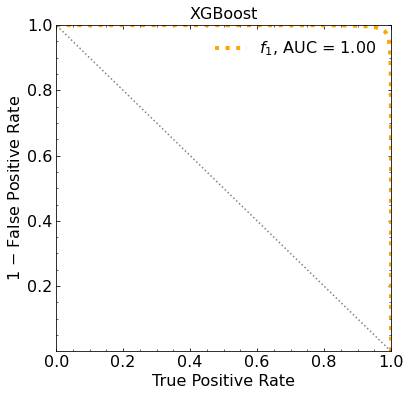

Classification score (1 ML):


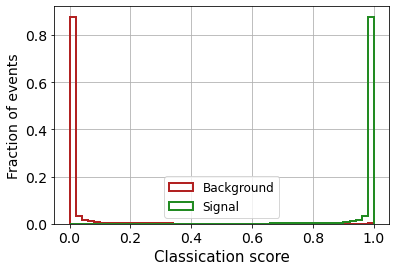

Classification score (10 ML):


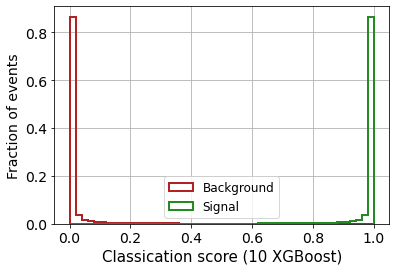

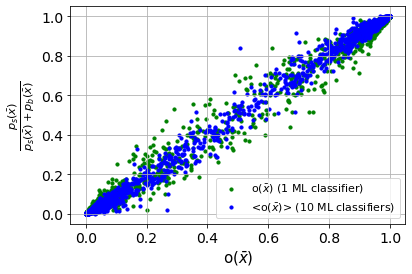


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  20.71220578618197
Z_XG 25 bins_1ML:  23.367785876576324
Z_XG 50 bins_1ML:  24.887467658511557
Z_XG 100 bins_1ML:  25.90978543459905

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  4.661974311520945
Z_XG 25 bins_eq_1ML:  7.093303308656675
Z_XG 50 bins_eq_1ML:  9.459511012593435
Z_XG 100 bins_eq_1ML:  12.130683307124528

 BL lineal bins, 10 ML
Z_XG 10 bins:  21.351758169952507
Z_XG 25 bins:  23.983420084221365
Z_XG 50 bins:  25.287122940926245
Z_XG 100 bins:  26.183939467224295

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  4.716810212306501
Z_XG 25 bins_eq:  7.175693857657979
Z_XG 50 bins_eq:  9.569738293016677
Z_XG 100 bins_eq:  12.270808630358724

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD (

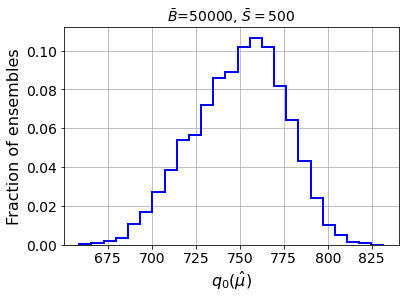

muhat mean:  0.012181891919294334
Z_gaussian:  27.41536443610604
Z_gaussian_mu0:  27.479792624194754

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 14311.02340103 13448.2277807  12531.37563064
 11559.15705491 10537.38853476  9461.30779543  8351.31346483
  7205.53780493  6012.85870904  4782.4318917   3519.36329448
  2228.70671763   924.69383669  -388.67558225 -1707.28961526]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 14347.87368736 13488.81686102 12562.89058977
 11580.27096258 10548.02419505  9466.38304236  8344.8971658
  719

KDE Kernel:  epanechnikov
Background bandwidth:  0.0063479219593504735
Signal bandwidth:  0.0063479219593504735


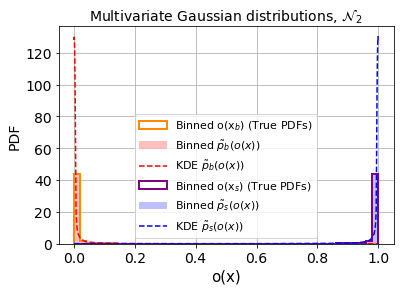

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 13970.33270343 13154.07529288 12284.18766464
 11352.12942818 10352.07561616  9307.0303894   8223.249553
  7109.27301999  5939.85528446  4731.36817491  3486.64298144
  2215.70456088   926.14877756  -378.39845888 -1704.40797302]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 13985.17511791 13169.01142189 12297.23290127
 11362.30373466 10366.5694932   9323.67014327  8231.1396298
  7102.

KDE Kernel:  epanechnikov
Background bandwidth:  0.0063479219593504735
Signal bandwidth:  0.0063479219593504735


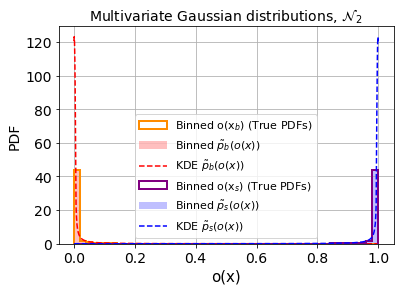

 Z MLL+KDE (1ML) 


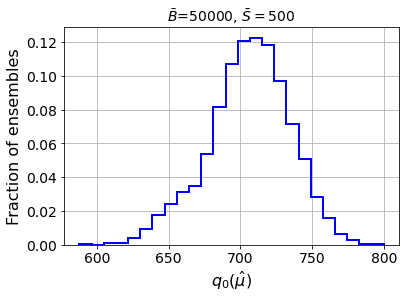

muhat mean_1ML:  0.005013687519010443
Z_KDE_1ML:  26.599303207956996
Z_KDE mu=0_1ML:  26.599303207956996

 Z MLL+KDE (10ML) 


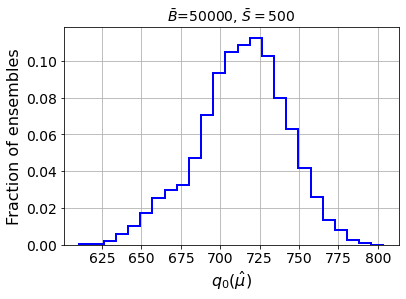

muhat mean:  0.0051657710635709215
Z_KDE:  26.742128977874078
Z_KDE mu=0:  26.742128977874078

 ------------------------------------ 



In [22]:
dim=9

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3, signal_X_4, signal_X_5, signal_X_6, signal_X_7, signal_X_8, signal_X_9 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3, background_X_4, background_X_5, background_X_6, background_X_7, background_X_8, background_X_9 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T


dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))
dim6 = np.concatenate((background_X_6,signal_X_6))
dim7 = np.concatenate((background_X_7,signal_X_7))
dim8 = np.concatenate((background_X_8,signal_X_8))
dim9 = np.concatenate((background_X_9,signal_X_9))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['dim6'] = dim6.reshape(-1)
df['dim7'] = dim7.reshape(-1)
df['dim8'] = dim8.reshape(-1)
df['dim9'] = dim9.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5','dim6','dim7','dim8','dim9']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML)


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP)


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [ ]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 10)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 10)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 10)
y_gauss_test :  (1000000, 1)



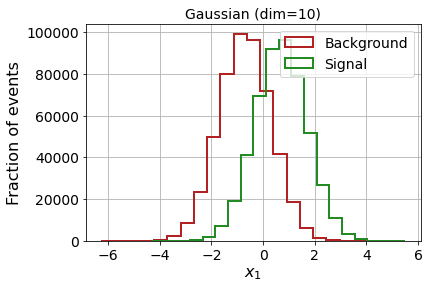

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.62575	validation_1-logloss:0.62611
[1]	validation_0-logloss:0.56773	validation_1-logloss:0.56833
[2]	validation_0-logloss:0.51787	validation_1-logloss:0.51862
[3]	validation_0-logloss:0.47425	validation_1-logloss:0.47513
[4]	validation_0-logloss:0.43585	validation_1-logloss:0.43684
[5]	validation_0-logloss:0.40190	validation_1-logloss:0.40298
[6]	validation_0-logloss:0.37167	validation_1-logloss:0.37289
[7]	validation_0-logloss:0.34468	validation_1-logloss:0.34594
[8]	validation_0-logloss:0.32051	validation_1-logloss:0.32184
[9]	validation_0-logloss:0.29877	validation_1-logloss:0.30017
[10]	validation_0-logloss:0.27900	validation_1-logloss:0.28044
[11]	validation_0-logloss:0.26119	validation_1-logloss:0.26267
[12]	validation_0-logloss:0.24501	validation_1-logloss:0.24654
[13]	validation_0-logloss:0.23026	validation_1-logloss:0.23185
[14]	validation_0-logloss:0.21686	validation_1-logloss:0.21846
[15]	validation_0-logloss:0.20458	validation_1-logloss:0.20621
[1

[130]	validation_0-logloss:0.03700	validation_1-logloss:0.04000
[131]	validation_0-logloss:0.03693	validation_1-logloss:0.03995
[132]	validation_0-logloss:0.03686	validation_1-logloss:0.03988
[133]	validation_0-logloss:0.03679	validation_1-logloss:0.03982
[134]	validation_0-logloss:0.03673	validation_1-logloss:0.03977
[135]	validation_0-logloss:0.03666	validation_1-logloss:0.03970
[136]	validation_0-logloss:0.03660	validation_1-logloss:0.03965
[137]	validation_0-logloss:0.03653	validation_1-logloss:0.03960
[138]	validation_0-logloss:0.03646	validation_1-logloss:0.03954
[139]	validation_0-logloss:0.03640	validation_1-logloss:0.03949
[140]	validation_0-logloss:0.03634	validation_1-logloss:0.03945
[141]	validation_0-logloss:0.03627	validation_1-logloss:0.03939
[142]	validation_0-logloss:0.03622	validation_1-logloss:0.03934
[143]	validation_0-logloss:0.03617	validation_1-logloss:0.03930
[144]	validation_0-logloss:0.03611	validation_1-logloss:0.03925
[145]	validation_0-logloss:0.03606	valid

[259]	validation_0-logloss:0.03307	validation_1-logloss:0.03746
[260]	validation_0-logloss:0.03306	validation_1-logloss:0.03746
[261]	validation_0-logloss:0.03305	validation_1-logloss:0.03746
[262]	validation_0-logloss:0.03303	validation_1-logloss:0.03745
[263]	validation_0-logloss:0.03302	validation_1-logloss:0.03745
[264]	validation_0-logloss:0.03301	validation_1-logloss:0.03745
[265]	validation_0-logloss:0.03300	validation_1-logloss:0.03745
[266]	validation_0-logloss:0.03299	validation_1-logloss:0.03744
[267]	validation_0-logloss:0.03298	validation_1-logloss:0.03744
[268]	validation_0-logloss:0.03297	validation_1-logloss:0.03744
[269]	validation_0-logloss:0.03296	validation_1-logloss:0.03744
[270]	validation_0-logloss:0.03295	validation_1-logloss:0.03744
[271]	validation_0-logloss:0.03293	validation_1-logloss:0.03744
[272]	validation_0-logloss:0.03292	validation_1-logloss:0.03743
[273]	validation_0-logloss:0.03291	validation_1-logloss:0.03743
[274]	validation_0-logloss:0.03290	valid

[388]	validation_0-logloss:0.03187	validation_1-logloss:0.03737
[389]	validation_0-logloss:0.03187	validation_1-logloss:0.03737
[390]	validation_0-logloss:0.03186	validation_1-logloss:0.03737
[391]	validation_0-logloss:0.03185	validation_1-logloss:0.03737
[392]	validation_0-logloss:0.03185	validation_1-logloss:0.03737
[393]	validation_0-logloss:0.03184	validation_1-logloss:0.03737
[394]	validation_0-logloss:0.03183	validation_1-logloss:0.03737
[395]	validation_0-logloss:0.03182	validation_1-logloss:0.03737
[396]	validation_0-logloss:0.03181	validation_1-logloss:0.03737
[397]	validation_0-logloss:0.03181	validation_1-logloss:0.03737
[398]	validation_0-logloss:0.03180	validation_1-logloss:0.03737
[399]	validation_0-logloss:0.03179	validation_1-logloss:0.03738
[400]	validation_0-logloss:0.03179	validation_1-logloss:0.03737
[401]	validation_0-logloss:0.03178	validation_1-logloss:0.03738
[402]	validation_0-logloss:0.03178	validation_1-logloss:0.03738
[403]	validation_0-logloss:0.03177	valid

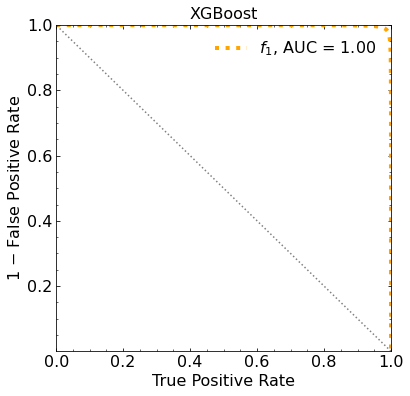

ML iteration 0
[0]	validation_0-logloss:0.62424	validation_1-logloss:0.62549
[1]	validation_0-logloss:0.56534	validation_1-logloss:0.56775
[2]	validation_0-logloss:0.51453	validation_1-logloss:0.51785


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47038	validation_1-logloss:0.47442
[4]	validation_0-logloss:0.43146	validation_1-logloss:0.43606
[5]	validation_0-logloss:0.39705	validation_1-logloss:0.40203
[6]	validation_0-logloss:0.36648	validation_1-logloss:0.37191
[7]	validation_0-logloss:0.33912	validation_1-logloss:0.34484
[8]	validation_0-logloss:0.31471	validation_1-logloss:0.32078
[9]	validation_0-logloss:0.29266	validation_1-logloss:0.29903
[10]	validation_0-logloss:0.27289	validation_1-logloss:0.27954
[11]	validation_0-logloss:0.25486	validation_1-logloss:0.26169
[12]	validation_0-logloss:0.23849	validation_1-logloss:0.24551
[13]	validation_0-logloss:0.22371	validation_1-logloss:0.23083
[14]	validation_0-logloss:0.21021	validation_1-logloss:0.21743
[15]	validation_0-logloss:0.19788	validation_1-logloss:0.20520
[16]	validation_0-logloss:0.18656	validation_1-logloss:0.19398
[17]	validation_0-logloss:0.17621	validation_1-logloss:0.18374
[18]	validation_0-logloss:0.16671	validation_1-logloss:0.17430

[133]	validation_0-logloss:0.02691	validation_1-logloss:0.04088
[134]	validation_0-logloss:0.02678	validation_1-logloss:0.04082
[135]	validation_0-logloss:0.02669	validation_1-logloss:0.04077
[136]	validation_0-logloss:0.02660	validation_1-logloss:0.04074
[137]	validation_0-logloss:0.02652	validation_1-logloss:0.04070
[138]	validation_0-logloss:0.02645	validation_1-logloss:0.04066
[139]	validation_0-logloss:0.02637	validation_1-logloss:0.04062
[140]	validation_0-logloss:0.02630	validation_1-logloss:0.04058
[141]	validation_0-logloss:0.02622	validation_1-logloss:0.04053
[142]	validation_0-logloss:0.02616	validation_1-logloss:0.04049
[143]	validation_0-logloss:0.02607	validation_1-logloss:0.04045
[144]	validation_0-logloss:0.02598	validation_1-logloss:0.04042
[145]	validation_0-logloss:0.02593	validation_1-logloss:0.04039
[146]	validation_0-logloss:0.02584	validation_1-logloss:0.04034
[147]	validation_0-logloss:0.02579	validation_1-logloss:0.04031
[148]	validation_0-logloss:0.02568	valid

[262]	validation_0-logloss:0.02035	validation_1-logloss:0.03940
[263]	validation_0-logloss:0.02032	validation_1-logloss:0.03940
[264]	validation_0-logloss:0.02030	validation_1-logloss:0.03941
[265]	validation_0-logloss:0.02028	validation_1-logloss:0.03941
[266]	validation_0-logloss:0.02025	validation_1-logloss:0.03941
[267]	validation_0-logloss:0.02022	validation_1-logloss:0.03941
[268]	validation_0-logloss:0.02015	validation_1-logloss:0.03942
[269]	validation_0-logloss:0.02013	validation_1-logloss:0.03942
[270]	validation_0-logloss:0.02008	validation_1-logloss:0.03943
[271]	validation_0-logloss:0.02004	validation_1-logloss:0.03943
[272]	validation_0-logloss:0.02002	validation_1-logloss:0.03943
[273]	validation_0-logloss:0.01999	validation_1-logloss:0.03944
[274]	validation_0-logloss:0.01997	validation_1-logloss:0.03944
[275]	validation_0-logloss:0.01994	validation_1-logloss:0.03945
[276]	validation_0-logloss:0.01991	validation_1-logloss:0.03945
[277]	validation_0-logloss:0.01983	valid

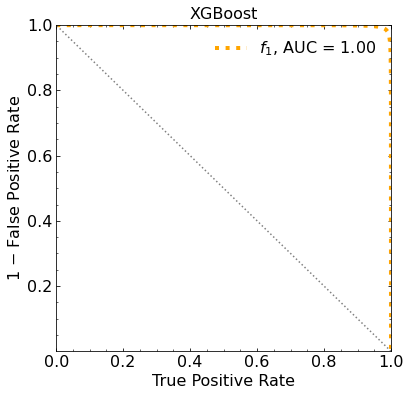

ML iteration  1
[0]	validation_0-logloss:0.62477	validation_1-logloss:0.62593
[1]	validation_0-logloss:0.56576	validation_1-logloss:0.56799
[2]	validation_0-logloss:0.51499	validation_1-logloss:0.51799


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47066	validation_1-logloss:0.47440
[4]	validation_0-logloss:0.43171	validation_1-logloss:0.43604
[5]	validation_0-logloss:0.39742	validation_1-logloss:0.40215
[6]	validation_0-logloss:0.36690	validation_1-logloss:0.37197
[7]	validation_0-logloss:0.33966	validation_1-logloss:0.34503
[8]	validation_0-logloss:0.31516	validation_1-logloss:0.32085
[9]	validation_0-logloss:0.29301	validation_1-logloss:0.29899
[10]	validation_0-logloss:0.27322	validation_1-logloss:0.27939
[11]	validation_0-logloss:0.25519	validation_1-logloss:0.26154
[12]	validation_0-logloss:0.23892	validation_1-logloss:0.24541
[13]	validation_0-logloss:0.22402	validation_1-logloss:0.23076
[14]	validation_0-logloss:0.21047	validation_1-logloss:0.21738
[15]	validation_0-logloss:0.19805	validation_1-logloss:0.20505
[16]	validation_0-logloss:0.18674	validation_1-logloss:0.19375
[17]	validation_0-logloss:0.17630	validation_1-logloss:0.18340
[18]	validation_0-logloss:0.16678	validation_1-logloss:0.17401

[133]	validation_0-logloss:0.02676	validation_1-logloss:0.04077
[134]	validation_0-logloss:0.02669	validation_1-logloss:0.04073
[135]	validation_0-logloss:0.02657	validation_1-logloss:0.04069
[136]	validation_0-logloss:0.02648	validation_1-logloss:0.04066
[137]	validation_0-logloss:0.02639	validation_1-logloss:0.04061
[138]	validation_0-logloss:0.02627	validation_1-logloss:0.04057
[139]	validation_0-logloss:0.02617	validation_1-logloss:0.04053
[140]	validation_0-logloss:0.02611	validation_1-logloss:0.04050
[141]	validation_0-logloss:0.02603	validation_1-logloss:0.04046
[142]	validation_0-logloss:0.02590	validation_1-logloss:0.04041
[143]	validation_0-logloss:0.02584	validation_1-logloss:0.04038
[144]	validation_0-logloss:0.02578	validation_1-logloss:0.04035
[145]	validation_0-logloss:0.02571	validation_1-logloss:0.04032
[146]	validation_0-logloss:0.02564	validation_1-logloss:0.04029
[147]	validation_0-logloss:0.02555	validation_1-logloss:0.04026
[148]	validation_0-logloss:0.02547	valid

[262]	validation_0-logloss:0.02044	validation_1-logloss:0.03950
[263]	validation_0-logloss:0.02042	validation_1-logloss:0.03950
[264]	validation_0-logloss:0.02039	validation_1-logloss:0.03950
[265]	validation_0-logloss:0.02038	validation_1-logloss:0.03951
[266]	validation_0-logloss:0.02034	validation_1-logloss:0.03951
[267]	validation_0-logloss:0.02034	validation_1-logloss:0.03950
[268]	validation_0-logloss:0.02029	validation_1-logloss:0.03951
[269]	validation_0-logloss:0.02025	validation_1-logloss:0.03952
[270]	validation_0-logloss:0.02021	validation_1-logloss:0.03952
[271]	validation_0-logloss:0.02020	validation_1-logloss:0.03952
[272]	validation_0-logloss:0.02013	validation_1-logloss:0.03953
[273]	validation_0-logloss:0.02009	validation_1-logloss:0.03953


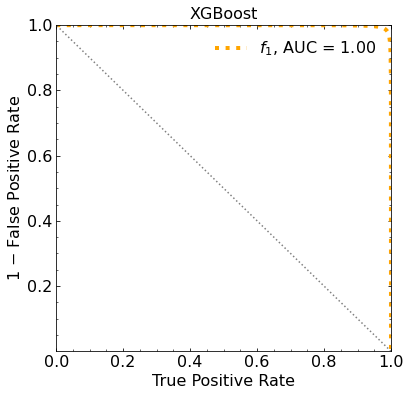

ML iteration  2
[0]	validation_0-logloss:0.62453	validation_1-logloss:0.62569
[1]	validation_0-logloss:0.56571	validation_1-logloss:0.56785
[2]	validation_0-logloss:0.51489	validation_1-logloss:0.51790


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47066	validation_1-logloss:0.47436
[4]	validation_0-logloss:0.43190	validation_1-logloss:0.43606
[5]	validation_0-logloss:0.39749	validation_1-logloss:0.40213
[6]	validation_0-logloss:0.36707	validation_1-logloss:0.37199
[7]	validation_0-logloss:0.33991	validation_1-logloss:0.34514
[8]	validation_0-logloss:0.31554	validation_1-logloss:0.32105
[9]	validation_0-logloss:0.29350	validation_1-logloss:0.29927
[10]	validation_0-logloss:0.27373	validation_1-logloss:0.27970
[11]	validation_0-logloss:0.25565	validation_1-logloss:0.26176
[12]	validation_0-logloss:0.23928	validation_1-logloss:0.24550
[13]	validation_0-logloss:0.22445	validation_1-logloss:0.23084
[14]	validation_0-logloss:0.21089	validation_1-logloss:0.21747
[15]	validation_0-logloss:0.19850	validation_1-logloss:0.20519
[16]	validation_0-logloss:0.18717	validation_1-logloss:0.19401
[17]	validation_0-logloss:0.17681	validation_1-logloss:0.18374
[18]	validation_0-logloss:0.16727	validation_1-logloss:0.17428

[133]	validation_0-logloss:0.02756	validation_1-logloss:0.04093
[134]	validation_0-logloss:0.02743	validation_1-logloss:0.04088
[135]	validation_0-logloss:0.02736	validation_1-logloss:0.04084
[136]	validation_0-logloss:0.02730	validation_1-logloss:0.04079
[137]	validation_0-logloss:0.02724	validation_1-logloss:0.04075
[138]	validation_0-logloss:0.02718	validation_1-logloss:0.04070
[139]	validation_0-logloss:0.02710	validation_1-logloss:0.04067
[140]	validation_0-logloss:0.02703	validation_1-logloss:0.04063
[141]	validation_0-logloss:0.02695	validation_1-logloss:0.04058
[142]	validation_0-logloss:0.02688	validation_1-logloss:0.04055
[143]	validation_0-logloss:0.02684	validation_1-logloss:0.04052
[144]	validation_0-logloss:0.02675	validation_1-logloss:0.04049
[145]	validation_0-logloss:0.02663	validation_1-logloss:0.04045
[146]	validation_0-logloss:0.02652	validation_1-logloss:0.04040
[147]	validation_0-logloss:0.02644	validation_1-logloss:0.04037
[148]	validation_0-logloss:0.02639	valid

[262]	validation_0-logloss:0.02136	validation_1-logloss:0.03948
[263]	validation_0-logloss:0.02130	validation_1-logloss:0.03949
[264]	validation_0-logloss:0.02124	validation_1-logloss:0.03949
[265]	validation_0-logloss:0.02122	validation_1-logloss:0.03949
[266]	validation_0-logloss:0.02120	validation_1-logloss:0.03949
[267]	validation_0-logloss:0.02118	validation_1-logloss:0.03950
[268]	validation_0-logloss:0.02114	validation_1-logloss:0.03951
[269]	validation_0-logloss:0.02108	validation_1-logloss:0.03951
[270]	validation_0-logloss:0.02102	validation_1-logloss:0.03951
[271]	validation_0-logloss:0.02098	validation_1-logloss:0.03952
[272]	validation_0-logloss:0.02095	validation_1-logloss:0.03952
[273]	validation_0-logloss:0.02092	validation_1-logloss:0.03952
[274]	validation_0-logloss:0.02091	validation_1-logloss:0.03952
[275]	validation_0-logloss:0.02088	validation_1-logloss:0.03952
[276]	validation_0-logloss:0.02086	validation_1-logloss:0.03952
[277]	validation_0-logloss:0.02084	valid

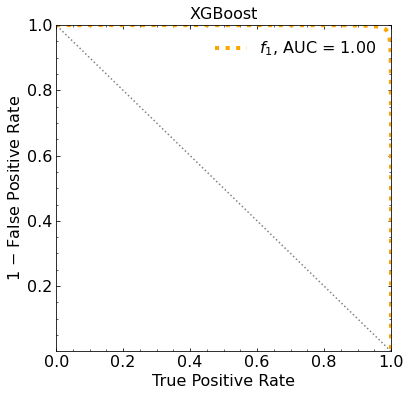

ML iteration  3
[0]	validation_0-logloss:0.62447	validation_1-logloss:0.62579
[1]	validation_0-logloss:0.56580	validation_1-logloss:0.56811
[2]	validation_0-logloss:0.51507	validation_1-logloss:0.51816


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47103	validation_1-logloss:0.47470
[4]	validation_0-logloss:0.43228	validation_1-logloss:0.43640
[5]	validation_0-logloss:0.39802	validation_1-logloss:0.40252
[6]	validation_0-logloss:0.36754	validation_1-logloss:0.37241
[7]	validation_0-logloss:0.34014	validation_1-logloss:0.34530
[8]	validation_0-logloss:0.31563	validation_1-logloss:0.32112
[9]	validation_0-logloss:0.29365	validation_1-logloss:0.29940
[10]	validation_0-logloss:0.27375	validation_1-logloss:0.27974
[11]	validation_0-logloss:0.25570	validation_1-logloss:0.26177
[12]	validation_0-logloss:0.23944	validation_1-logloss:0.24571
[13]	validation_0-logloss:0.22463	validation_1-logloss:0.23106
[14]	validation_0-logloss:0.21108	validation_1-logloss:0.21759
[15]	validation_0-logloss:0.19869	validation_1-logloss:0.20528
[16]	validation_0-logloss:0.18738	validation_1-logloss:0.19408
[17]	validation_0-logloss:0.17693	validation_1-logloss:0.18377
[18]	validation_0-logloss:0.16735	validation_1-logloss:0.17428

[133]	validation_0-logloss:0.02749	validation_1-logloss:0.04074
[134]	validation_0-logloss:0.02736	validation_1-logloss:0.04069
[135]	validation_0-logloss:0.02726	validation_1-logloss:0.04065
[136]	validation_0-logloss:0.02719	validation_1-logloss:0.04061
[137]	validation_0-logloss:0.02707	validation_1-logloss:0.04056
[138]	validation_0-logloss:0.02699	validation_1-logloss:0.04053
[139]	validation_0-logloss:0.02689	validation_1-logloss:0.04048
[140]	validation_0-logloss:0.02678	validation_1-logloss:0.04044
[141]	validation_0-logloss:0.02673	validation_1-logloss:0.04040
[142]	validation_0-logloss:0.02661	validation_1-logloss:0.04035
[143]	validation_0-logloss:0.02655	validation_1-logloss:0.04032
[144]	validation_0-logloss:0.02647	validation_1-logloss:0.04029
[145]	validation_0-logloss:0.02639	validation_1-logloss:0.04025
[146]	validation_0-logloss:0.02633	validation_1-logloss:0.04022
[147]	validation_0-logloss:0.02627	validation_1-logloss:0.04019
[148]	validation_0-logloss:0.02619	valid

[262]	validation_0-logloss:0.02134	validation_1-logloss:0.03928
[263]	validation_0-logloss:0.02129	validation_1-logloss:0.03928
[264]	validation_0-logloss:0.02126	validation_1-logloss:0.03928
[265]	validation_0-logloss:0.02121	validation_1-logloss:0.03929
[266]	validation_0-logloss:0.02115	validation_1-logloss:0.03929
[267]	validation_0-logloss:0.02109	validation_1-logloss:0.03929
[268]	validation_0-logloss:0.02108	validation_1-logloss:0.03929
[269]	validation_0-logloss:0.02103	validation_1-logloss:0.03929
[270]	validation_0-logloss:0.02099	validation_1-logloss:0.03929
[271]	validation_0-logloss:0.02094	validation_1-logloss:0.03930
[272]	validation_0-logloss:0.02087	validation_1-logloss:0.03930
[273]	validation_0-logloss:0.02082	validation_1-logloss:0.03931
[274]	validation_0-logloss:0.02078	validation_1-logloss:0.03931
[275]	validation_0-logloss:0.02071	validation_1-logloss:0.03932
[276]	validation_0-logloss:0.02069	validation_1-logloss:0.03932
[277]	validation_0-logloss:0.02064	valid

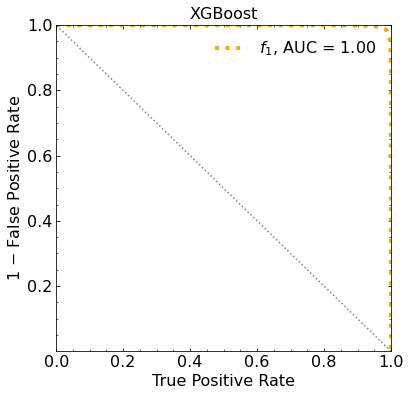

ML iteration  4
[0]	validation_0-logloss:0.62428	validation_1-logloss:0.62572
[1]	validation_0-logloss:0.56543	validation_1-logloss:0.56768
[2]	validation_0-logloss:0.51447	validation_1-logloss:0.51765


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47029	validation_1-logloss:0.47426
[4]	validation_0-logloss:0.43143	validation_1-logloss:0.43590
[5]	validation_0-logloss:0.39704	validation_1-logloss:0.40203
[6]	validation_0-logloss:0.36647	validation_1-logloss:0.37189
[7]	validation_0-logloss:0.33920	validation_1-logloss:0.34504
[8]	validation_0-logloss:0.31474	validation_1-logloss:0.32086
[9]	validation_0-logloss:0.29266	validation_1-logloss:0.29906
[10]	validation_0-logloss:0.27289	validation_1-logloss:0.27941
[11]	validation_0-logloss:0.25488	validation_1-logloss:0.26155
[12]	validation_0-logloss:0.23862	validation_1-logloss:0.24542
[13]	validation_0-logloss:0.22368	validation_1-logloss:0.23070
[14]	validation_0-logloss:0.21008	validation_1-logloss:0.21726
[15]	validation_0-logloss:0.19767	validation_1-logloss:0.20490
[16]	validation_0-logloss:0.18627	validation_1-logloss:0.19369
[17]	validation_0-logloss:0.17592	validation_1-logloss:0.18344
[18]	validation_0-logloss:0.16636	validation_1-logloss:0.17399

[133]	validation_0-logloss:0.02711	validation_1-logloss:0.04086
[134]	validation_0-logloss:0.02701	validation_1-logloss:0.04081
[135]	validation_0-logloss:0.02692	validation_1-logloss:0.04075
[136]	validation_0-logloss:0.02684	validation_1-logloss:0.04071
[137]	validation_0-logloss:0.02677	validation_1-logloss:0.04066
[138]	validation_0-logloss:0.02669	validation_1-logloss:0.04061
[139]	validation_0-logloss:0.02661	validation_1-logloss:0.04057
[140]	validation_0-logloss:0.02655	validation_1-logloss:0.04053
[141]	validation_0-logloss:0.02648	validation_1-logloss:0.04050
[142]	validation_0-logloss:0.02640	validation_1-logloss:0.04046
[143]	validation_0-logloss:0.02634	validation_1-logloss:0.04043
[144]	validation_0-logloss:0.02627	validation_1-logloss:0.04038
[145]	validation_0-logloss:0.02620	validation_1-logloss:0.04034
[146]	validation_0-logloss:0.02616	validation_1-logloss:0.04032
[147]	validation_0-logloss:0.02605	validation_1-logloss:0.04029
[148]	validation_0-logloss:0.02598	valid

[262]	validation_0-logloss:0.02115	validation_1-logloss:0.03931
[263]	validation_0-logloss:0.02105	validation_1-logloss:0.03932
[264]	validation_0-logloss:0.02102	validation_1-logloss:0.03932
[265]	validation_0-logloss:0.02098	validation_1-logloss:0.03932
[266]	validation_0-logloss:0.02094	validation_1-logloss:0.03932
[267]	validation_0-logloss:0.02089	validation_1-logloss:0.03932
[268]	validation_0-logloss:0.02087	validation_1-logloss:0.03932
[269]	validation_0-logloss:0.02085	validation_1-logloss:0.03933
[270]	validation_0-logloss:0.02082	validation_1-logloss:0.03932
[271]	validation_0-logloss:0.02080	validation_1-logloss:0.03932
[272]	validation_0-logloss:0.02073	validation_1-logloss:0.03933
[273]	validation_0-logloss:0.02063	validation_1-logloss:0.03934
[274]	validation_0-logloss:0.02062	validation_1-logloss:0.03935
[275]	validation_0-logloss:0.02058	validation_1-logloss:0.03934
[276]	validation_0-logloss:0.02052	validation_1-logloss:0.03934
[277]	validation_0-logloss:0.02051	valid

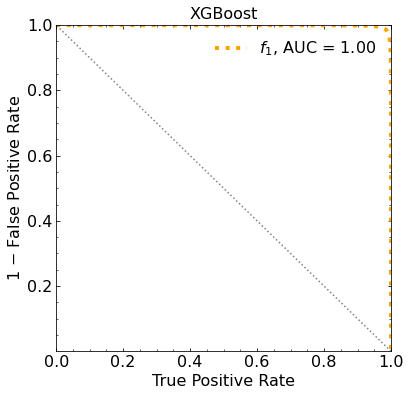

ML iteration  5
[0]	validation_0-logloss:0.62412	validation_1-logloss:0.62554
[1]	validation_0-logloss:0.56559	validation_1-logloss:0.56781
[2]	validation_0-logloss:0.51496	validation_1-logloss:0.51800


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47075	validation_1-logloss:0.47438
[4]	validation_0-logloss:0.43205	validation_1-logloss:0.43616
[5]	validation_0-logloss:0.39768	validation_1-logloss:0.40228
[6]	validation_0-logloss:0.36723	validation_1-logloss:0.37221
[7]	validation_0-logloss:0.33998	validation_1-logloss:0.34523
[8]	validation_0-logloss:0.31534	validation_1-logloss:0.32086
[9]	validation_0-logloss:0.29326	validation_1-logloss:0.29909
[10]	validation_0-logloss:0.27339	validation_1-logloss:0.27946
[11]	validation_0-logloss:0.25540	validation_1-logloss:0.26169
[12]	validation_0-logloss:0.23903	validation_1-logloss:0.24546
[13]	validation_0-logloss:0.22415	validation_1-logloss:0.23075
[14]	validation_0-logloss:0.21068	validation_1-logloss:0.21738
[15]	validation_0-logloss:0.19831	validation_1-logloss:0.20515
[16]	validation_0-logloss:0.18697	validation_1-logloss:0.19395
[17]	validation_0-logloss:0.17655	validation_1-logloss:0.18367
[18]	validation_0-logloss:0.16694	validation_1-logloss:0.17417

[133]	validation_0-logloss:0.02690	validation_1-logloss:0.04071
[134]	validation_0-logloss:0.02679	validation_1-logloss:0.04067
[135]	validation_0-logloss:0.02670	validation_1-logloss:0.04061
[136]	validation_0-logloss:0.02662	validation_1-logloss:0.04057
[137]	validation_0-logloss:0.02654	validation_1-logloss:0.04053
[138]	validation_0-logloss:0.02647	validation_1-logloss:0.04048
[139]	validation_0-logloss:0.02635	validation_1-logloss:0.04044
[140]	validation_0-logloss:0.02629	validation_1-logloss:0.04041
[141]	validation_0-logloss:0.02620	validation_1-logloss:0.04037
[142]	validation_0-logloss:0.02608	validation_1-logloss:0.04033
[143]	validation_0-logloss:0.02600	validation_1-logloss:0.04030
[144]	validation_0-logloss:0.02594	validation_1-logloss:0.04026
[145]	validation_0-logloss:0.02583	validation_1-logloss:0.04023
[146]	validation_0-logloss:0.02575	validation_1-logloss:0.04020
[147]	validation_0-logloss:0.02568	validation_1-logloss:0.04015
[148]	validation_0-logloss:0.02559	valid

[262]	validation_0-logloss:0.02028	validation_1-logloss:0.03937
[263]	validation_0-logloss:0.02024	validation_1-logloss:0.03936
[264]	validation_0-logloss:0.02019	validation_1-logloss:0.03936
[265]	validation_0-logloss:0.02016	validation_1-logloss:0.03936
[266]	validation_0-logloss:0.02012	validation_1-logloss:0.03936
[267]	validation_0-logloss:0.02006	validation_1-logloss:0.03937
[268]	validation_0-logloss:0.02000	validation_1-logloss:0.03938
[269]	validation_0-logloss:0.01999	validation_1-logloss:0.03937
[270]	validation_0-logloss:0.01994	validation_1-logloss:0.03938
[271]	validation_0-logloss:0.01988	validation_1-logloss:0.03938
[272]	validation_0-logloss:0.01985	validation_1-logloss:0.03938
[273]	validation_0-logloss:0.01984	validation_1-logloss:0.03939
[274]	validation_0-logloss:0.01982	validation_1-logloss:0.03939
[275]	validation_0-logloss:0.01981	validation_1-logloss:0.03939
[276]	validation_0-logloss:0.01978	validation_1-logloss:0.03939
[277]	validation_0-logloss:0.01973	valid

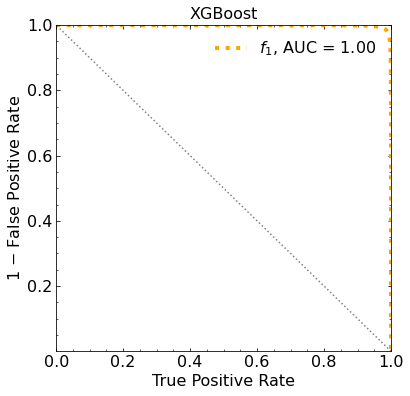

ML iteration  6
[0]	validation_0-logloss:0.62417	validation_1-logloss:0.62559
[1]	validation_0-logloss:0.56538	validation_1-logloss:0.56777
[2]	validation_0-logloss:0.51440	validation_1-logloss:0.51789


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47009	validation_1-logloss:0.47419
[4]	validation_0-logloss:0.43120	validation_1-logloss:0.43596
[5]	validation_0-logloss:0.39693	validation_1-logloss:0.40224
[6]	validation_0-logloss:0.36624	validation_1-logloss:0.37195
[7]	validation_0-logloss:0.33885	validation_1-logloss:0.34496
[8]	validation_0-logloss:0.31443	validation_1-logloss:0.32078
[9]	validation_0-logloss:0.29230	validation_1-logloss:0.29900
[10]	validation_0-logloss:0.27236	validation_1-logloss:0.27944
[11]	validation_0-logloss:0.25432	validation_1-logloss:0.26161
[12]	validation_0-logloss:0.23790	validation_1-logloss:0.24531
[13]	validation_0-logloss:0.22301	validation_1-logloss:0.23062
[14]	validation_0-logloss:0.20935	validation_1-logloss:0.21703
[15]	validation_0-logloss:0.19698	validation_1-logloss:0.20478
[16]	validation_0-logloss:0.18569	validation_1-logloss:0.19352
[17]	validation_0-logloss:0.17534	validation_1-logloss:0.18319
[18]	validation_0-logloss:0.16575	validation_1-logloss:0.17378

[133]	validation_0-logloss:0.02578	validation_1-logloss:0.04047
[134]	validation_0-logloss:0.02568	validation_1-logloss:0.04043
[135]	validation_0-logloss:0.02556	validation_1-logloss:0.04037
[136]	validation_0-logloss:0.02546	validation_1-logloss:0.04032
[137]	validation_0-logloss:0.02538	validation_1-logloss:0.04028
[138]	validation_0-logloss:0.02531	validation_1-logloss:0.04024
[139]	validation_0-logloss:0.02527	validation_1-logloss:0.04021
[140]	validation_0-logloss:0.02515	validation_1-logloss:0.04018
[141]	validation_0-logloss:0.02506	validation_1-logloss:0.04013
[142]	validation_0-logloss:0.02500	validation_1-logloss:0.04010
[143]	validation_0-logloss:0.02495	validation_1-logloss:0.04007
[144]	validation_0-logloss:0.02483	validation_1-logloss:0.04004
[145]	validation_0-logloss:0.02478	validation_1-logloss:0.04002
[146]	validation_0-logloss:0.02470	validation_1-logloss:0.03998
[147]	validation_0-logloss:0.02464	validation_1-logloss:0.03996
[148]	validation_0-logloss:0.02458	valid

[262]	validation_0-logloss:0.01961	validation_1-logloss:0.03922
[263]	validation_0-logloss:0.01957	validation_1-logloss:0.03922
[264]	validation_0-logloss:0.01955	validation_1-logloss:0.03922
[265]	validation_0-logloss:0.01953	validation_1-logloss:0.03922
[266]	validation_0-logloss:0.01950	validation_1-logloss:0.03922
[267]	validation_0-logloss:0.01949	validation_1-logloss:0.03923
[268]	validation_0-logloss:0.01946	validation_1-logloss:0.03922
[269]	validation_0-logloss:0.01944	validation_1-logloss:0.03922
[270]	validation_0-logloss:0.01941	validation_1-logloss:0.03923
[271]	validation_0-logloss:0.01937	validation_1-logloss:0.03923
[272]	validation_0-logloss:0.01934	validation_1-logloss:0.03924
[273]	validation_0-logloss:0.01929	validation_1-logloss:0.03925
[274]	validation_0-logloss:0.01925	validation_1-logloss:0.03926
[275]	validation_0-logloss:0.01925	validation_1-logloss:0.03926
[276]	validation_0-logloss:0.01923	validation_1-logloss:0.03926
[277]	validation_0-logloss:0.01920	valid

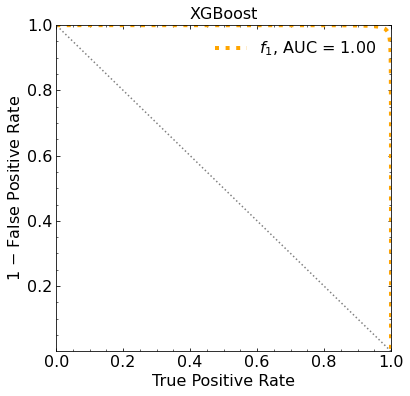

ML iteration  7
[0]	validation_0-logloss:0.62444	validation_1-logloss:0.62548
[1]	validation_0-logloss:0.56581	validation_1-logloss:0.56803
[2]	validation_0-logloss:0.51519	validation_1-logloss:0.51814


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47122	validation_1-logloss:0.47462
[4]	validation_0-logloss:0.43229	validation_1-logloss:0.43619
[5]	validation_0-logloss:0.39805	validation_1-logloss:0.40233
[6]	validation_0-logloss:0.36749	validation_1-logloss:0.37218
[7]	validation_0-logloss:0.34010	validation_1-logloss:0.34517
[8]	validation_0-logloss:0.31549	validation_1-logloss:0.32089
[9]	validation_0-logloss:0.29348	validation_1-logloss:0.29916
[10]	validation_0-logloss:0.27365	validation_1-logloss:0.27954
[11]	validation_0-logloss:0.25561	validation_1-logloss:0.26170
[12]	validation_0-logloss:0.23930	validation_1-logloss:0.24556
[13]	validation_0-logloss:0.22439	validation_1-logloss:0.23085
[14]	validation_0-logloss:0.21084	validation_1-logloss:0.21736
[15]	validation_0-logloss:0.19840	validation_1-logloss:0.20508
[16]	validation_0-logloss:0.18707	validation_1-logloss:0.19384
[17]	validation_0-logloss:0.17681	validation_1-logloss:0.18366
[18]	validation_0-logloss:0.16729	validation_1-logloss:0.17425

[133]	validation_0-logloss:0.02718	validation_1-logloss:0.04077
[134]	validation_0-logloss:0.02712	validation_1-logloss:0.04072
[135]	validation_0-logloss:0.02703	validation_1-logloss:0.04067
[136]	validation_0-logloss:0.02695	validation_1-logloss:0.04063
[137]	validation_0-logloss:0.02686	validation_1-logloss:0.04059
[138]	validation_0-logloss:0.02678	validation_1-logloss:0.04054
[139]	validation_0-logloss:0.02669	validation_1-logloss:0.04050
[140]	validation_0-logloss:0.02661	validation_1-logloss:0.04046
[141]	validation_0-logloss:0.02653	validation_1-logloss:0.04043
[142]	validation_0-logloss:0.02641	validation_1-logloss:0.04039
[143]	validation_0-logloss:0.02629	validation_1-logloss:0.04035
[144]	validation_0-logloss:0.02619	validation_1-logloss:0.04031
[145]	validation_0-logloss:0.02613	validation_1-logloss:0.04027
[146]	validation_0-logloss:0.02607	validation_1-logloss:0.04024
[147]	validation_0-logloss:0.02596	validation_1-logloss:0.04020
[148]	validation_0-logloss:0.02587	valid

[262]	validation_0-logloss:0.02030	validation_1-logloss:0.03935
[263]	validation_0-logloss:0.02029	validation_1-logloss:0.03935
[264]	validation_0-logloss:0.02025	validation_1-logloss:0.03936
[265]	validation_0-logloss:0.02022	validation_1-logloss:0.03936
[266]	validation_0-logloss:0.02020	validation_1-logloss:0.03936
[267]	validation_0-logloss:0.02019	validation_1-logloss:0.03936
[268]	validation_0-logloss:0.02016	validation_1-logloss:0.03936
[269]	validation_0-logloss:0.02009	validation_1-logloss:0.03936
[270]	validation_0-logloss:0.02006	validation_1-logloss:0.03937
[271]	validation_0-logloss:0.02004	validation_1-logloss:0.03937
[272]	validation_0-logloss:0.01998	validation_1-logloss:0.03937
[273]	validation_0-logloss:0.01995	validation_1-logloss:0.03937
[274]	validation_0-logloss:0.01991	validation_1-logloss:0.03938
[275]	validation_0-logloss:0.01990	validation_1-logloss:0.03938
[276]	validation_0-logloss:0.01988	validation_1-logloss:0.03938
[277]	validation_0-logloss:0.01983	valid

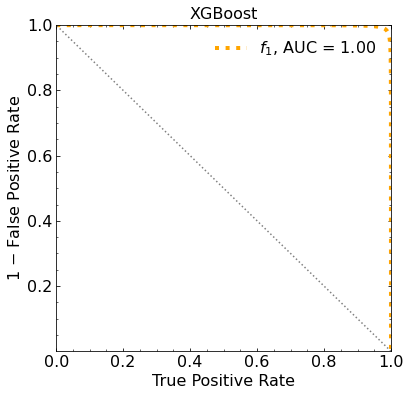

ML iteration  8
[0]	validation_0-logloss:0.62442	validation_1-logloss:0.62565
[1]	validation_0-logloss:0.56588	validation_1-logloss:0.56814
[2]	validation_0-logloss:0.51497	validation_1-logloss:0.51808


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47068	validation_1-logloss:0.47441
[4]	validation_0-logloss:0.43178	validation_1-logloss:0.43596
[5]	validation_0-logloss:0.39726	validation_1-logloss:0.40185
[6]	validation_0-logloss:0.36701	validation_1-logloss:0.37206
[7]	validation_0-logloss:0.33972	validation_1-logloss:0.34513
[8]	validation_0-logloss:0.31516	validation_1-logloss:0.32092
[9]	validation_0-logloss:0.29315	validation_1-logloss:0.29914
[10]	validation_0-logloss:0.27333	validation_1-logloss:0.27944
[11]	validation_0-logloss:0.25534	validation_1-logloss:0.26158
[12]	validation_0-logloss:0.23906	validation_1-logloss:0.24557
[13]	validation_0-logloss:0.22416	validation_1-logloss:0.23078
[14]	validation_0-logloss:0.21062	validation_1-logloss:0.21731
[15]	validation_0-logloss:0.19821	validation_1-logloss:0.20505
[16]	validation_0-logloss:0.18689	validation_1-logloss:0.19387
[17]	validation_0-logloss:0.17655	validation_1-logloss:0.18366
[18]	validation_0-logloss:0.16696	validation_1-logloss:0.17418

[133]	validation_0-logloss:0.02701	validation_1-logloss:0.04079
[134]	validation_0-logloss:0.02693	validation_1-logloss:0.04075
[135]	validation_0-logloss:0.02684	validation_1-logloss:0.04070
[136]	validation_0-logloss:0.02675	validation_1-logloss:0.04065
[137]	validation_0-logloss:0.02665	validation_1-logloss:0.04060
[138]	validation_0-logloss:0.02657	validation_1-logloss:0.04056
[139]	validation_0-logloss:0.02644	validation_1-logloss:0.04052
[140]	validation_0-logloss:0.02635	validation_1-logloss:0.04050
[141]	validation_0-logloss:0.02630	validation_1-logloss:0.04047
[142]	validation_0-logloss:0.02623	validation_1-logloss:0.04044
[143]	validation_0-logloss:0.02615	validation_1-logloss:0.04039
[144]	validation_0-logloss:0.02604	validation_1-logloss:0.04037
[145]	validation_0-logloss:0.02594	validation_1-logloss:0.04033
[146]	validation_0-logloss:0.02588	validation_1-logloss:0.04029
[147]	validation_0-logloss:0.02582	validation_1-logloss:0.04027
[148]	validation_0-logloss:0.02576	valid

[262]	validation_0-logloss:0.02064	validation_1-logloss:0.03945
[263]	validation_0-logloss:0.02062	validation_1-logloss:0.03946
[264]	validation_0-logloss:0.02054	validation_1-logloss:0.03946
[265]	validation_0-logloss:0.02048	validation_1-logloss:0.03946
[266]	validation_0-logloss:0.02046	validation_1-logloss:0.03945
[267]	validation_0-logloss:0.02044	validation_1-logloss:0.03945
[268]	validation_0-logloss:0.02043	validation_1-logloss:0.03945
[269]	validation_0-logloss:0.02038	validation_1-logloss:0.03945
[270]	validation_0-logloss:0.02037	validation_1-logloss:0.03945
[271]	validation_0-logloss:0.02031	validation_1-logloss:0.03945
[272]	validation_0-logloss:0.02029	validation_1-logloss:0.03946
[273]	validation_0-logloss:0.02026	validation_1-logloss:0.03946


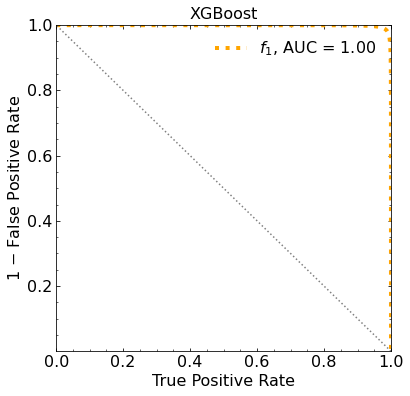

ML iteration  9
[0]	validation_0-logloss:0.62445	validation_1-logloss:0.62560
[1]	validation_0-logloss:0.56565	validation_1-logloss:0.56771
[2]	validation_0-logloss:0.51494	validation_1-logloss:0.51768


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.47099	validation_1-logloss:0.47429
[4]	validation_0-logloss:0.43222	validation_1-logloss:0.43606
[5]	validation_0-logloss:0.39796	validation_1-logloss:0.40215
[6]	validation_0-logloss:0.36745	validation_1-logloss:0.37210
[7]	validation_0-logloss:0.34038	validation_1-logloss:0.34534
[8]	validation_0-logloss:0.31580	validation_1-logloss:0.32103
[9]	validation_0-logloss:0.29381	validation_1-logloss:0.29921
[10]	validation_0-logloss:0.27400	validation_1-logloss:0.27961
[11]	validation_0-logloss:0.25606	validation_1-logloss:0.26180
[12]	validation_0-logloss:0.23968	validation_1-logloss:0.24563
[13]	validation_0-logloss:0.22484	validation_1-logloss:0.23094
[14]	validation_0-logloss:0.21130	validation_1-logloss:0.21751
[15]	validation_0-logloss:0.19886	validation_1-logloss:0.20521
[16]	validation_0-logloss:0.18748	validation_1-logloss:0.19398
[17]	validation_0-logloss:0.17704	validation_1-logloss:0.18370
[18]	validation_0-logloss:0.16747	validation_1-logloss:0.17425

[133]	validation_0-logloss:0.02702	validation_1-logloss:0.04064
[134]	validation_0-logloss:0.02691	validation_1-logloss:0.04059
[135]	validation_0-logloss:0.02681	validation_1-logloss:0.04055
[136]	validation_0-logloss:0.02675	validation_1-logloss:0.04051
[137]	validation_0-logloss:0.02665	validation_1-logloss:0.04045
[138]	validation_0-logloss:0.02660	validation_1-logloss:0.04042
[139]	validation_0-logloss:0.02653	validation_1-logloss:0.04039
[140]	validation_0-logloss:0.02643	validation_1-logloss:0.04034
[141]	validation_0-logloss:0.02635	validation_1-logloss:0.04031
[142]	validation_0-logloss:0.02626	validation_1-logloss:0.04027
[143]	validation_0-logloss:0.02621	validation_1-logloss:0.04024
[144]	validation_0-logloss:0.02615	validation_1-logloss:0.04021
[145]	validation_0-logloss:0.02605	validation_1-logloss:0.04017
[146]	validation_0-logloss:0.02600	validation_1-logloss:0.04014
[147]	validation_0-logloss:0.02590	validation_1-logloss:0.04011
[148]	validation_0-logloss:0.02581	valid

[262]	validation_0-logloss:0.02064	validation_1-logloss:0.03925
[263]	validation_0-logloss:0.02063	validation_1-logloss:0.03925
[264]	validation_0-logloss:0.02060	validation_1-logloss:0.03925
[265]	validation_0-logloss:0.02056	validation_1-logloss:0.03926
[266]	validation_0-logloss:0.02054	validation_1-logloss:0.03926
[267]	validation_0-logloss:0.02048	validation_1-logloss:0.03926
[268]	validation_0-logloss:0.02045	validation_1-logloss:0.03926
[269]	validation_0-logloss:0.02042	validation_1-logloss:0.03926
[270]	validation_0-logloss:0.02038	validation_1-logloss:0.03927
[271]	validation_0-logloss:0.02032	validation_1-logloss:0.03927
[272]	validation_0-logloss:0.02027	validation_1-logloss:0.03927
[273]	validation_0-logloss:0.02021	validation_1-logloss:0.03928
[274]	validation_0-logloss:0.02020	validation_1-logloss:0.03928
[275]	validation_0-logloss:0.02015	validation_1-logloss:0.03928
[276]	validation_0-logloss:0.02012	validation_1-logloss:0.03928
[277]	validation_0-logloss:0.02009	valid

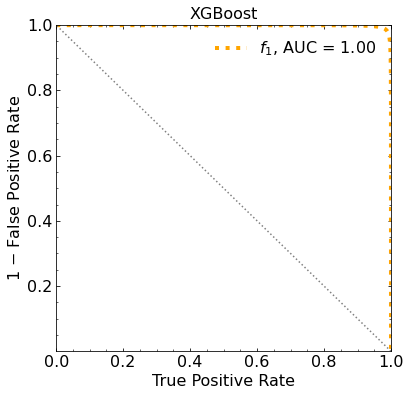

Classification score (1 ML):


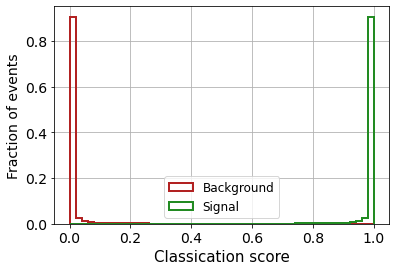

Classification score (10 ML):


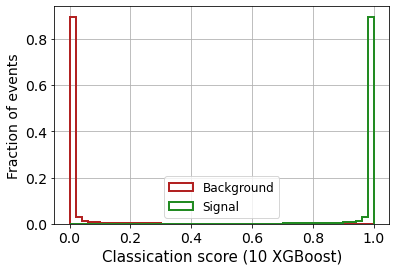

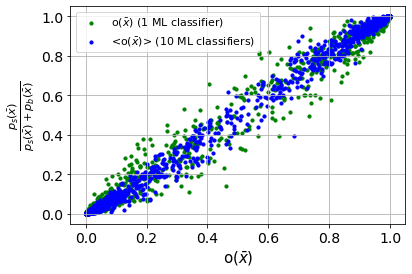


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  22.092617041008463
Z_XG 25 bins_1ML:  24.484359294583452
Z_XG 50 bins_1ML:  25.7926913772498
Z_XG 100 bins_1ML:  26.75200411472336

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  4.0839861233346495
Z_XG 25 bins_eq_1ML:  6.255584457084563
Z_XG 50 bins_eq_1ML:  8.416773677920984
Z_XG 100 bins_eq_1ML:  10.915580468608857

 BL lineal bins, 10 ML
Z_XG 10 bins:  22.684926695581655
Z_XG 25 bins:  25.08833053818083
Z_XG 50 bins:  26.28102794582542
Z_XG 100 bins:  27.111276892789306

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  3.940923694598702
Z_XG 25 bins_eq:  6.0379343282484
Z_XG 50 bins_eq:  8.134654059022408
Z_XG 100 bins_eq:  10.577657288009195

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD (GAUS

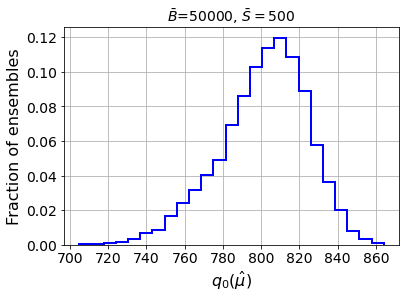

muhat mean:  0.005834938659637029
Z_gaussian:  28.35069104733271
Z_gaussian_mu0:  28.372437952111756

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 14232.61219789 13220.67173706
 12159.8468198  11059.21097416  9906.92151601  8716.79080803
  7495.41425722  6236.98848191  4957.54540553  3657.23184133
  2336.46991783  1008.38595306  -341.10968797 -1687.87191153]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 14305.61692071 13274.4362325
 12204.26076308 11090.10582207  9942.92511411  8754.44829441
  753

KDE Kernel:  epanechnikov
Background bandwidth:  0.0091866653175426
Signal bandwidth:  0.0091866653175426


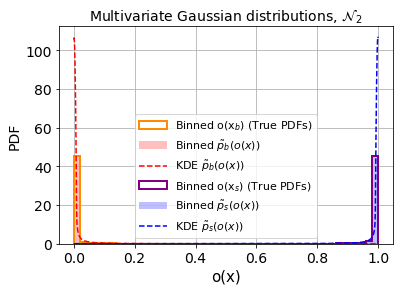

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 14830.76277544 13924.83556155 12958.82464728
 11936.03781801 10868.26255458  9760.37156348  8606.86940989
  7413.37386594  6178.86274139  4912.74502312  3632.82522373
  2322.07449371  1006.0637221   -338.98332129 -1686.90149372]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf 13028.86686643
 11987.73905654 10909.26988736  9784.39168929  8629.94616022
  74

KDE Kernel:  epanechnikov
Background bandwidth:  0.0063479219593504735
Signal bandwidth:  0.01329487353451575


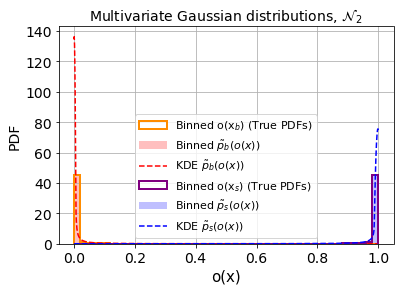

 Z MLL+KDE (1ML) 


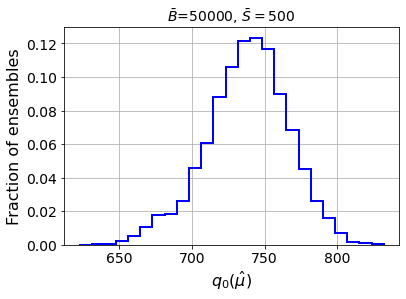

muhat mean_1ML:  0.0027527121565446623
Z_KDE_1ML:  27.199173614830595
Z_KDE mu=0_1ML:  27.199173614830595

 Z MLL+KDE (10ML) 


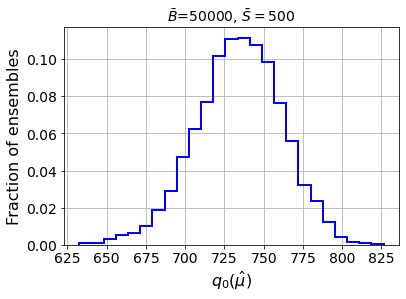

muhat mean:  0.0008313900435972829
Z_KDE:  27.112840873756834
Z_KDE mu=0:  27.112840873756834

 ------------------------------------ 



In [23]:
dim=10

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3, signal_X_4, signal_X_5, signal_X_6, signal_X_7, signal_X_8, signal_X_9, signal_X_10 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3, background_X_4, background_X_5, background_X_6, background_X_7, background_X_8, background_X_9, background_X_10 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T


dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))
dim6 = np.concatenate((background_X_6,signal_X_6))
dim7 = np.concatenate((background_X_7,signal_X_7))
dim8 = np.concatenate((background_X_8,signal_X_8))
dim9 = np.concatenate((background_X_9,signal_X_9))
dim10 = np.concatenate((background_X_10,signal_X_10))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['dim6'] = dim6.reshape(-1)
df['dim7'] = dim7.reshape(-1)
df['dim8'] = dim8.reshape(-1)
df['dim9'] = dim9.reshape(-1)
df['dim10'] = dim10.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5','dim6','dim7','dim8','dim9','dim10']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML)


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP)


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [ ]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()

In [24]:
print(store_AUC)

print(store_Z_bins_XG_10bins_1ML)
print(store_Z_bins_XG_25bins_1ML)
print(store_Z_bins_XG_50bins_1ML)
print(store_Z_bins_XG_100bins_1ML)

print(store_Z_bins_XG_10bins_eq_1ML)
print(store_Z_bins_XG_25bins_eq_1ML)
print(store_Z_bins_XG_50bins_eq_1ML)
print(store_Z_bins_XG_100bins_eq_1ML)

print(store_Z_bins_XG_10bins)
print(store_Z_bins_XG_25bins)
print(store_Z_bins_XG_50bins)
print(store_Z_bins_XG_100bins)

print(store_Z_bins_XG_10bins_eq)
print(store_Z_bins_XG_25bins_eq)
print(store_Z_bins_XG_50bins_eq)
print(store_Z_bins_XG_100bins_eq)

print(store_muhat_mean_gaussian)
print(store_Z_gaussian)
print(store_Z_gaussian_mu0)

print(store_muhat_mean_MLL_KDE)
print(store_Z_MLL_KDE)
print(store_Z_MLL_KDE_mu0)

print(store_muhat_mean_MLL_KDE_1ML)
print(store_Z_MLL_KDE_1ML)
print(store_Z_MLL_KDE_mu0_1ML)

[0.838747173294081, 0.9192553021388145, 0.9566684248221605, 0.9757967110452961, 0.9862579901638695, 0.9921105421958513, 0.9953910257373391, 0.9973542395848058, 0.9984614971918345, 0.9990591801177237]
[4.900168357085412, 7.463837935718369, 9.810604043109892, 11.692436533423784, 13.373078932585615, 15.294967118315293, 17.240531933986492, 19.136817388766435, 20.71220578618197, 22.092617041008463]
[5.22184018664735, 8.758063001744683, 11.816213667448258, 14.475570868026548, 16.5223150745312, 18.42540329202467, 20.1848399274867, 21.83908828695275, 23.367785876576324, 24.484359294583452]
[5.323978612345578, 9.311196417589551, 12.84397799894337, 15.752237581990503, 18.301846436630147, 20.32621475907388, 22.011311287837664, 23.58085161502932, 24.887467658511557, 25.7926913772498]
[5.361164383734579, 9.677449284110368, 13.516071587094597, 16.616717261728766, 19.459481501535752, 21.57979971910179, 23.321841061876967, 24.75940268099932, 25.90978543459905, 26.75200411472336]
[4.084028413820139, 5.

In [77]:
store_AUC = [0.8385644701287596, 0.9192553021388145, 0.9566684248221605, 0.9757967110452961, 0.9862579901638695, 0.9921105421958513, 0.9953910257373391, 0.9973542395848058, 0.9984614971918345, 0.9990591801177237]

store_Z_bins_XG_10bins_1ML = [4.900672776243757, 7.463837935718369, 9.810604043109892, 11.692436533423784, 13.373078932585615, 15.294967118315293, 17.240531933986492, 19.136817388766435, 20.71220578618197, 22.092617041008463]
store_Z_bins_XG_25bins_1ML = [5.272275479417459, 8.758063001744683, 11.816213667448258, 14.475570868026548, 16.5223150745312, 18.42540329202467, 20.1848399274867, 21.83908828695275, 23.367785876576324, 24.484359294583452]
store_Z_bins_XG_50bins_1ML = [5.36291939047819, 9.311196417589551, 12.84397799894337, 15.752237581990503, 18.301846436630147, 20.32621475907388, 22.011311287837664, 23.58085161502932, 24.887467658511557, 25.7926913772498]
store_Z_bins_XG_100bins_1ML = [5.399444175695006, 9.677449284110368, 13.516071587094597, 16.616717261728766, 19.459481501535752, 21.57979971910179, 23.321841061876967, 24.75940268099932, 25.90978543459905, 26.75200411472336]

store_Z_bins_XG_10bins_eq_1ML = [4.075613975314512, 5.275374332776303, 5.994011503462414, 6.108648661508239, 6.478816076957965, 6.180809258532996, 6.120229262752213, 5.326471252897206, 4.661974311520945, 4.0839861233346495]
store_Z_bins_XG_25bins_eq_1ML = [4.519879355343759, 6.525699824053538, 7.960530798531556, 8.490475134067314, 9.32900399526326, 9.08773897375027, 9.123436004615739, 8.03598547287715, 7.093303308656675, 6.255584457084563]
store_Z_bins_XG_50bins_eq_1ML = [4.772969120704275, 7.329476447470916, 9.420278065268867, 10.376392285455749, 11.730651670900569, 11.670369228142292, 11.883232825050655, 10.600327862363951, 9.459511012593435, 8.416773677920984]
store_Z_bins_XG_100bins_eq_1ML = [4.980368905989027, 8.034373704382, 10.745143762018948, 12.171200801445753, 14.117475426834762, 14.270124919944267, 14.770218754185132, 13.401464125797874, 12.130683307124528, 10.915580468608857]

store_Z_bins_XG_10bins = [4.910327658411742, 7.488881904635886, 9.852201054023736, 11.756410182188466, 13.589251425241914, 15.5895369982379, 17.625032464117787, 19.701033706000572, 21.351758169952507, 22.684926695581655]
store_Z_bins_XG_25bins = [5.256663083612902, 8.823653289814246, 11.929213833216833, 14.589406084865143, 16.644046009295806, 18.71762500573058, 20.620272694812723, 22.437734625080555, 23.983420084221365, 25.08833053818083]
store_Z_bins_XG_50bins = [5.356094989654455, 9.381477749833786, 12.963733598104733, 16.030872870861486, 18.493333106596623, 20.683145804376146, 22.406016886628397, 24.014547478708973, 25.287122940926245, 26.28102794582542]
store_Z_bins_XG_100bins = [5.371062599759511, 9.719617666120572, 13.595688193648465, 16.930146717908922, 19.683094930330046, 21.844387450443588, 23.548038771311358, 25.040977728946327, 26.183939467224295, 27.111276892789306]

store_Z_bins_XG_10bins_eq = [4.081911105932502, 5.293592136619532, 5.977395181104024, 6.07148920511574, 6.454836958327108, 6.2891279323799845, 6.314194404772618, 5.306282367618018, 4.716810212306501, 3.940923694598702]
store_Z_bins_XG_25bins_eq = [4.527655372082387, 6.55151409235361, 7.936394093844356, 8.435876326828636, 9.298688689552204, 9.256101105966524, 9.409452253445133, 8.010386578452577, 7.175693857657979, 6.0379343282484]
store_Z_bins_XG_50bins_eq = [4.781151072014415, 7.360471888891425, 9.38913627881738, 10.314133572706593, 11.69879267314183, 11.882449608803354, 12.25007406837353, 10.57418062033249, 9.569738293016677, 8.134654059022408]
store_Z_bins_XG_100bins_eq = [4.9651143104725595, 8.070916452622555, 10.707695665026112, 12.085311769548504, 14.069380521441362, 14.536098676987535, 15.214277570073286, 13.375277741530114, 12.270808630358724, 10.577657288009195]

store_muhat_mean_gaussian = [0.07400385278312888, 0.01759099665416202, 0.02061745919091554, 0.021311974044408398, 0.0187823177532191, 0.02172766906620703, 0.01396633884213728, 0.012019669471763157, 0.012181891919294334, 0.005834938659637029]
store_Z_gaussian = [5.4582665525905645, 10.107594975135884, 14.09306912032441, 17.46249984935399, 20.607446198936376, 22.89293580712699, 24.70668354044314, 26.290254408601296, 27.41536443610604, 28.35069104733271]
store_Z_gaussian_mu0 = [5.459073198567305, 10.108401960368493, 14.098967019936973, 17.484455135559486, 20.664290659618707, 22.981333106387453, 24.7544121899887, 26.353052713628255, 27.479792624194754, 28.372437952111756]

store_muhat_mean_MLL_KDE = [0.07622427253371186, 0.026325661563418836, 0.019679610666125925, 0.017180371083848726, 0.009966541620196697, 0.0088766095508466, 0.006220216972523573, 0.005196187772483017, 0.0051657710635709215, 0.0008313900435972829]
store_Z_MLL_KDE = [5.425695503260566, 9.966670047130755, 14.107056245808433, 17.28464208323587, 20.527092507570714, 22.732401718417155, 24.805725725715572, 26.098831365905017, 26.942128977874078, 27.912840873756834]
store_Z_MLL_KDE_mu0 = [5.42653533078617, 9.969207700180736, 14.112690991648728, 17.294124907460443, 20.53933421030847, 22.738653891620334, 24.806311533439874, 26.09917733078097, 26.942128977874078, 27.912840873756834]

store_muhat_mean_MLL_KDE_1ML = [0.07510899320693501, 0.02016627800871946, 0.018731623238365608, 0.015618980026361149, 0.01268883706782926, 0.006083341782419142, 0.006270911487377066, 0.0067930649903680425, 0.005013687519010443, 0.0027527121565446623]
store_Z_MLL_KDE_1ML = [5.44466790903825, 10.137655164451614, 13.82832670119089, 17.453194775741927, 20.447464192679035, 22.869140897412457, 24.135024545324057, 26.027605353094458, 26.999303207956996, 27.699173614830595]
store_Z_MLL_KDE_mu0_1ML = [5.446370148409234, 10.138120299889199, 13.83260427548685, 17.46394145132108, 20.46251737051894, 22.870408652951337, 24.13538498305128, 26.027746297339963, 26.999303207956996, 27.699173614830595]

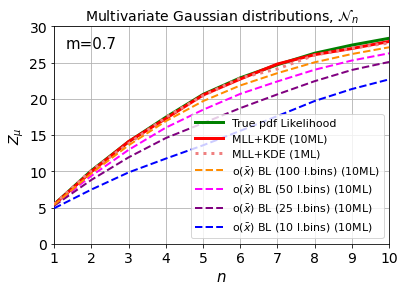

In [111]:
#########
# PLOTS #
#########

dim = [1,2,3,4,5,6,7,8,9,10]

plt.figure()
lw = 2

#plt.plot(dim, store_Z_KDE_bins, '--', color='purple', lw=3, label=r'KDE (Binned)', zorder=5 )
plt.plot(dim, store_Z_gaussian, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
plt.plot(dim, store_Z_MLL_KDE, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
plt.plot(dim, store_Z_MLL_KDE_1ML, ':', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#plt.plot(dim, store_Z_MLL_KDE_mu0, ':', color='gray', lw=3, label=r'KDE (MLL) mu=0', zorder=5 )
plt.plot(dim, store_Z_bins_XG_100bins, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
plt.plot(dim, store_Z_bins_XG_50bins, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
plt.plot(dim, store_Z_bins_XG_25bins, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
plt.plot(dim, store_Z_bins_XG_10bins, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)

# plt.plot(dim, store_Z_bins_XG_100bins_eq, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
# plt.plot(dim, store_Z_bins_XG_50bins_eq, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
# plt.plot(dim, store_Z_bins_XG_25bins_eq, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
# plt.plot(dim, store_Z_bins_XG_10bins_eq, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)


plt.xlim([1, 10])
plt.ylim([0., 30])
#plt.yscale('log')
plt.text(1.3, 27, 'm=0.7', fontsize = 15)
plt.xlabel('$n$', fontsize=15)
plt.ylabel('$Z_{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.axhline(y=SsqrtB, color='black', linestyle=':')#, label=r'$S/\sqrt{B}$, WP=0')
plt.grid()
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{n}$', fontsize=14)
plt.legend(loc="lower right", fontsize=11, handlelength=2.5)
#plt.savefig('images/' + '2gaussian-Z-dims-m07.pdf', format="pdf", bbox_inches="tight")
plt.show()

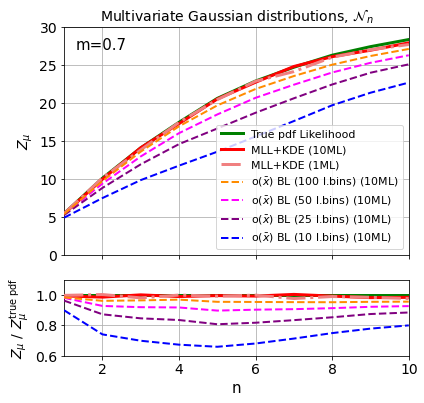

In [112]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

axs[0].plot(dim, store_Z_gaussian, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[0].plot(dim, store_Z_MLL_KDE, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[0].plot(dim, store_Z_MLL_KDE_1ML, '-.', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
axs[0].plot(dim, store_Z_bins_XG_100bins, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
axs[0].plot(dim, store_Z_bins_XG_50bins, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_25bins, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_100bins_eq, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
# axs[0].plot(dim, store_Z_bins_XG_50bins_eq, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_25bins_eq, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_10bins_eq, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_100bins_1ML, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
# axs[0].plot(dim, store_Z_bins_XG_50bins_1ML, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_25bins_1ML, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_10bins_1ML, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_100bins_eq_1ML, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[0].plot(dim, store_Z_bins_XG_50bins_eq_1ML, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_25bins_eq_1ML, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_10bins_eq_1ML, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)


store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,store_Z_gaussian)]
store_Z_MLL_KDE_norm = [ a/b for a, b in zip(store_Z_MLL_KDE,store_Z_gaussian)]
store_Z_MLL_KDE_1ML_norm = [ a/b for a, b in zip(store_Z_MLL_KDE_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins,store_Z_gaussian)]
store_Z_bins_XG_50bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins,store_Z_gaussian)]
store_Z_bins_XG_25bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins,store_Z_gaussian)]
store_Z_bins_XG_10bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq,store_Z_gaussian)]
store_Z_bins_XG_100bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq_1ML,store_Z_gaussian)]
dim_norm = [ a/b for a, b in zip(dim,store_Z_gaussian)]


axs[1].plot(dim, store_Z_gaussian_norm, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[1].plot(dim, store_Z_MLL_KDE_norm, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[1].plot(dim, store_Z_MLL_KDE_1ML_norm, '-.', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
axs[1].plot(dim, store_Z_bins_XG_100bins_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
axs[1].plot(dim, store_Z_bins_XG_50bins_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_25bins_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_100bins_eq_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
# axs[1].plot(dim, store_Z_bins_XG_50bins_eq_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_25bins_eq_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_10bins_eq_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_100bins_1ML_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
# axs[1].plot(dim, store_Z_bins_XG_50bins_1ML_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_25bins_1ML_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_10bins_1ML_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_100bins_eq_1ML_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[1].plot(dim, store_Z_bins_XG_50bins_eq_1ML_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_25bins_eq_1ML_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_10bins_eq_1ML_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)




axs[0].text(1.3, 27, 'm=0.7', fontsize = 15)


axs[0].set_xlim([1, 10])
axs[0].set_ylim([0, 30])
axs[1].set_xlim([1, 10])
axs[1].set_ylim([0.6,1.1])
axs[0].set_ylabel('$Z_{\mu}$', fontsize=14)
axs[1].set_xlabel('n', fontsize=15)
axs[1].set_ylabel(r'$Z_{\mu}$ / $Z_{\mu}^{\mathrm{true \; pdf}}$', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0.6,0.8,1])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title('Multivariate Gaussian distributions, $\mathcal{N}_{n}$', fontsize=14)
axs[0].legend(loc="lower right", fontsize=11)
plt.tight_layout()
#plt.savefig('images/' + '2gaussian-Z-dims-m07.pdf', format="pdf", bbox_inches="tight")
plt.show()

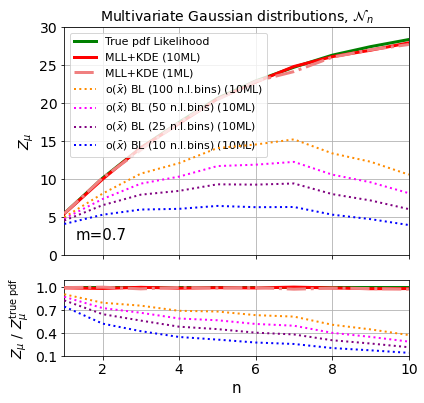

In [113]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

axs[0].plot(dim, store_Z_gaussian, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[0].plot(dim, store_Z_MLL_KDE, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[0].plot(dim, store_Z_MLL_KDE_1ML, '-.', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[0].plot(dim, store_Z_bins_XG_100bins, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_100bins_eq, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
axs[0].plot(dim, store_Z_bins_XG_50bins_eq, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_25bins_eq, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins_eq, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_100bins_1ML, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
# axs[0].plot(dim, store_Z_bins_XG_50bins_1ML, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_25bins_1ML, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_10bins_1ML, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_100bins_eq_1ML, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[0].plot(dim, store_Z_bins_XG_50bins_eq_1ML, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_25bins_eq_1ML, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_10bins_eq_1ML, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)


store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,store_Z_gaussian)]
store_Z_MLL_KDE_norm = [ a/b for a, b in zip(store_Z_MLL_KDE,store_Z_gaussian)]
store_Z_MLL_KDE_1ML_norm = [ a/b for a, b in zip(store_Z_MLL_KDE_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins,store_Z_gaussian)]
store_Z_bins_XG_50bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins,store_Z_gaussian)]
store_Z_bins_XG_25bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins,store_Z_gaussian)]
store_Z_bins_XG_10bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq,store_Z_gaussian)]
store_Z_bins_XG_100bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq_1ML,store_Z_gaussian)]
dim_norm = [ a/b for a, b in zip(dim,store_Z_gaussian)]


axs[1].plot(dim, store_Z_gaussian_norm, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[1].plot(dim, store_Z_MLL_KDE_norm, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[1].plot(dim, store_Z_MLL_KDE_1ML_norm, '-.', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[1].plot(dim, store_Z_bins_XG_100bins_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_100bins_eq_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
axs[1].plot(dim, store_Z_bins_XG_50bins_eq_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_25bins_eq_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_eq_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_100bins_1ML_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
# axs[1].plot(dim, store_Z_bins_XG_50bins_1ML_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_25bins_1ML_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_10bins_1ML_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_100bins_eq_1ML_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[1].plot(dim, store_Z_bins_XG_50bins_eq_1ML_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_25bins_eq_1ML_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_10bins_eq_1ML_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)




axs[0].text(1.3, 2, 'm=0.7', fontsize = 15)


axs[0].set_xlim([1, 10])
axs[0].set_ylim([0, 30])
axs[1].set_xlim([1, 10])
axs[1].set_ylim([0.1,1.1])
axs[0].set_ylabel('$Z_{\mu}$', fontsize=14)
axs[1].set_xlabel('n', fontsize=15)
axs[1].set_ylabel(r'$Z_{\mu}$ / $Z_{\mu}^{\mathrm{true \; pdf}}$', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0.1,0.4,0.7,1])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title('Multivariate Gaussian distributions, $\mathcal{N}_{n}$', fontsize=14)
axs[0].legend(loc="upper left", fontsize=11)
plt.tight_layout()
#plt.savefig('images/' + '2gaussian-Z-dims-m07.pdf', format="pdf", bbox_inches="tight")
plt.show()

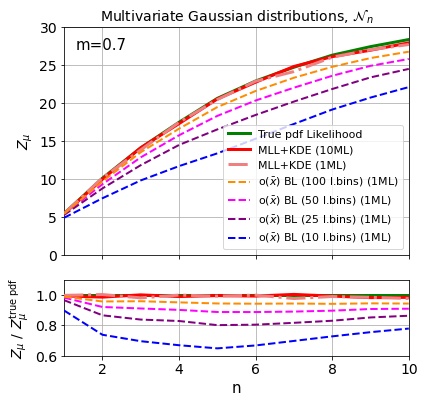

In [114]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

axs[0].plot(dim, store_Z_gaussian, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[0].plot(dim, store_Z_MLL_KDE, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[0].plot(dim, store_Z_MLL_KDE_1ML, '-.', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[0].plot(dim, store_Z_bins_XG_100bins, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_eq, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_eq, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_eq, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins_eq, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_100bins_1ML, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
axs[0].plot(dim, store_Z_bins_XG_50bins_1ML, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_25bins_1ML, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins_1ML, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_100bins_eq_1ML, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[0].plot(dim, store_Z_bins_XG_50bins_eq_1ML, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_25bins_eq_1ML, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_10bins_eq_1ML, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)


store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,store_Z_gaussian)]
store_Z_MLL_KDE_norm = [ a/b for a, b in zip(store_Z_MLL_KDE,store_Z_gaussian)]
store_Z_MLL_KDE_1ML_norm = [ a/b for a, b in zip(store_Z_MLL_KDE_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins,store_Z_gaussian)]
store_Z_bins_XG_50bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins,store_Z_gaussian)]
store_Z_bins_XG_25bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins,store_Z_gaussian)]
store_Z_bins_XG_10bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq,store_Z_gaussian)]
store_Z_bins_XG_100bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq_1ML,store_Z_gaussian)]
dim_norm = [ a/b for a, b in zip(dim,store_Z_gaussian)]


axs[1].plot(dim, store_Z_gaussian_norm, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[1].plot(dim, store_Z_MLL_KDE_norm, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[1].plot(dim, store_Z_MLL_KDE_1ML_norm, '-.', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[1].plot(dim, store_Z_bins_XG_100bins_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_eq_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_eq_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_eq_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_eq_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_100bins_1ML_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
axs[1].plot(dim, store_Z_bins_XG_50bins_1ML_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_25bins_1ML_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_1ML_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_100bins_eq_1ML_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[1].plot(dim, store_Z_bins_XG_50bins_eq_1ML_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_25bins_eq_1ML_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_10bins_eq_1ML_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)




axs[0].text(1.3, 27, 'm=0.7', fontsize = 15)


axs[0].set_xlim([1, 10])
axs[0].set_ylim([0, 30])
axs[1].set_xlim([1, 10])
axs[1].set_ylim([0.6,1.1])
axs[0].set_ylabel('$Z_{\mu}$', fontsize=14)
axs[1].set_xlabel('n', fontsize=15)
axs[1].set_ylabel(r'$Z_{\mu}$ / $Z_{\mu}^{\mathrm{true \; pdf}}$', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0.6,0.8,1])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title('Multivariate Gaussian distributions, $\mathcal{N}_{n}$', fontsize=14)
axs[0].legend(loc="lower right", fontsize=11)
plt.tight_layout()
#plt.savefig('images/' + '2gaussian-Z-dims-m07.pdf', format="pdf", bbox_inches="tight")
plt.show()

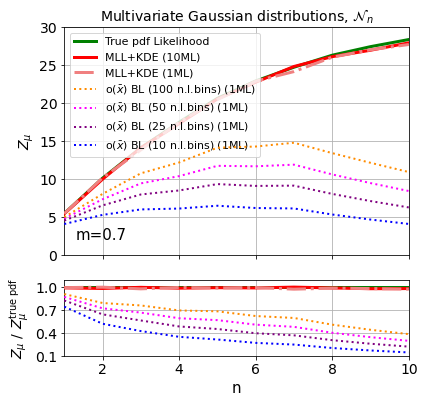

In [115]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

axs[0].plot(dim, store_Z_gaussian, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[0].plot(dim, store_Z_MLL_KDE, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[0].plot(dim, store_Z_MLL_KDE_1ML, '-.', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[0].plot(dim, store_Z_bins_XG_100bins, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_eq, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_eq, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_eq, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins_eq, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_1ML, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_1ML, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_1ML, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins_1ML, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_100bins_eq_1ML, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
axs[0].plot(dim, store_Z_bins_XG_50bins_eq_1ML, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_25bins_eq_1ML, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins_eq_1ML, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)


store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,store_Z_gaussian)]
store_Z_MLL_KDE_norm = [ a/b for a, b in zip(store_Z_MLL_KDE,store_Z_gaussian)]
store_Z_MLL_KDE_1ML_norm = [ a/b for a, b in zip(store_Z_MLL_KDE_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins,store_Z_gaussian)]
store_Z_bins_XG_50bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins,store_Z_gaussian)]
store_Z_bins_XG_25bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins,store_Z_gaussian)]
store_Z_bins_XG_10bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq,store_Z_gaussian)]
store_Z_bins_XG_100bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq_1ML,store_Z_gaussian)]
dim_norm = [ a/b for a, b in zip(dim,store_Z_gaussian)]


axs[1].plot(dim, store_Z_gaussian_norm, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[1].plot(dim, store_Z_MLL_KDE_norm, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[1].plot(dim, store_Z_MLL_KDE_1ML_norm, '-.', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[1].plot(dim, store_Z_bins_XG_100bins_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_eq_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_eq_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_eq_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_eq_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_1ML_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_1ML_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_1ML_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_1ML_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_100bins_eq_1ML_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
axs[1].plot(dim, store_Z_bins_XG_50bins_eq_1ML_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_25bins_eq_1ML_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_eq_1ML_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)




axs[0].text(1.3, 2, 'm=0.7', fontsize = 15)


axs[0].set_xlim([1, 10])
axs[0].set_ylim([0, 30])
axs[1].set_xlim([1, 10])
axs[1].set_ylim([0.1,1.1])
axs[0].set_ylabel('$Z_{\mu}$', fontsize=14)
axs[1].set_xlabel('n', fontsize=15)
axs[1].set_ylabel(r'$Z_{\mu}$ / $Z_{\mu}^{\mathrm{true \; pdf}}$', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0.1,0.4,0.7,1])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title('Multivariate Gaussian distributions, $\mathcal{N}_{n}$', fontsize=14)
axs[0].legend(loc="upper left", fontsize=11)
plt.tight_layout()
#plt.savefig('images/' + '2gaussian-Z-dims-m07.pdf', format="pdf", bbox_inches="tight")
plt.show()

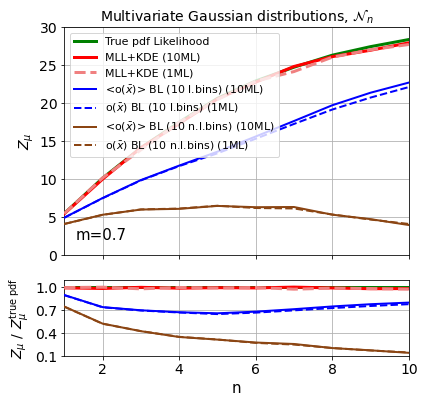

In [108]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

axs[0].plot(dim, store_Z_gaussian, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[0].plot(dim, store_Z_MLL_KDE, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[0].plot(dim, store_Z_MLL_KDE_1ML, '--', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[0].plot(dim, store_Z_bins_XG_100bins, '--', color='dodgerblue', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins, '-', color='blue', lw=2, label=r'<o$(\bar{x})$> BL (10 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_1ML, '--', color='dodgerblue', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_1ML, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_1ML, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins_1ML, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_eq, ':', color='dodgerblue', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_eq, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_eq, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins_eq, '-', color='saddlebrown', lw=2, label=r'<o$(\bar{x})$> BL (10 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_eq_1ML, ':', color='dodgerblue', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_eq_1ML, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_eq_1ML, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins_eq_1ML, '--', color='saddlebrown', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)


store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,store_Z_gaussian)]
store_Z_MLL_KDE_norm = [ a/b for a, b in zip(store_Z_MLL_KDE,store_Z_gaussian)]
store_Z_MLL_KDE_1ML_norm = [ a/b for a, b in zip(store_Z_MLL_KDE_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins,store_Z_gaussian)]
store_Z_bins_XG_50bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins,store_Z_gaussian)]
store_Z_bins_XG_25bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins,store_Z_gaussian)]
store_Z_bins_XG_10bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq,store_Z_gaussian)]
store_Z_bins_XG_100bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq_1ML,store_Z_gaussian)]
dim_norm = [ a/b for a, b in zip(dim,store_Z_gaussian)]


axs[1].plot(dim, store_Z_gaussian_norm, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[1].plot(dim, store_Z_MLL_KDE_norm, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[1].plot(dim, store_Z_MLL_KDE_1ML_norm, '--', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[1].plot(dim, store_Z_bins_XG_100bins_norm, '--', color='dodgerblue', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_norm, '-', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_1ML_norm, '--', color='dodgerblue', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_1ML_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_1ML_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_1ML_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_eq_norm, ':', color='dodgerblue', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_eq_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_eq_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_eq_norm, '-', color='saddlebrown', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_eq_1ML_norm, ':', color='dodgerblue', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_eq_1ML_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_eq_1ML_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_eq_1ML_norm, '--', color='saddlebrown', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)




axs[0].text(1.3, 2, 'm=0.7', fontsize = 15)


axs[0].set_xlim([1, 10])
axs[0].set_ylim([0, 30])
axs[1].set_xlim([1, 10])
axs[1].set_ylim([0.1,1.1])
axs[0].set_ylabel('$Z_{\mu}$', fontsize=14)
axs[1].set_xlabel('n', fontsize=15)
axs[1].set_ylabel(r'$Z_{\mu}$ / $Z_{\mu}^{\mathrm{true \; pdf}}$', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0.1,0.4,0.7,1])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title('Multivariate Gaussian distributions, $\mathcal{N}_{n}$', fontsize=14)
axs[0].legend(loc="upper left", fontsize=11)
plt.tight_layout()
plt.savefig('images/' + '2gaussian-Z-dims-m07-A.pdf', format="pdf", bbox_inches="tight")
plt.show()

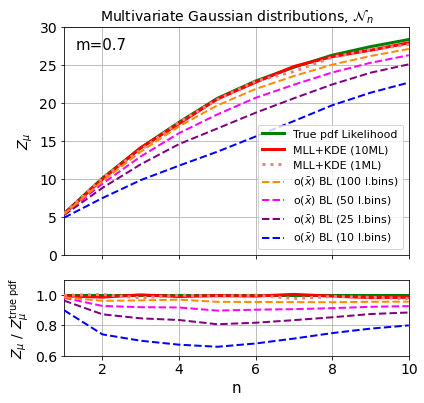

In [121]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

axs[0].plot(dim, store_Z_gaussian, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[0].plot(dim, store_Z_MLL_KDE, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[0].plot(dim, store_Z_MLL_KDE_1ML, ':', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
axs[0].plot(dim, store_Z_bins_XG_100bins, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins)' ,zorder=10)
axs[0].plot(dim, store_Z_bins_XG_50bins, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_25bins, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_eq, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_eq, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_eq, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins_eq, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_1ML, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_1ML, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_1ML, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins_1ML, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_100bins_eq_1ML, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[0].plot(dim, store_Z_bins_XG_50bins_eq_1ML, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_25bins_eq_1ML, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_10bins_eq_1ML, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)


store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,store_Z_gaussian)]
store_Z_MLL_KDE_norm = [ a/b for a, b in zip(store_Z_MLL_KDE,store_Z_gaussian)]
store_Z_MLL_KDE_1ML_norm = [ a/b for a, b in zip(store_Z_MLL_KDE_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins,store_Z_gaussian)]
store_Z_bins_XG_50bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins,store_Z_gaussian)]
store_Z_bins_XG_25bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins,store_Z_gaussian)]
store_Z_bins_XG_10bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq,store_Z_gaussian)]
store_Z_bins_XG_100bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq_1ML,store_Z_gaussian)]
dim_norm = [ a/b for a, b in zip(dim,store_Z_gaussian)]


axs[1].plot(dim, store_Z_gaussian_norm, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[1].plot(dim, store_Z_MLL_KDE_norm, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[1].plot(dim, store_Z_MLL_KDE_1ML_norm, ':', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
axs[1].plot(dim, store_Z_bins_XG_100bins_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
axs[1].plot(dim, store_Z_bins_XG_50bins_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_25bins_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_eq_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_eq_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_eq_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_eq_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_1ML_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_1ML_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_1ML_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_1ML_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_100bins_eq_1ML_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[1].plot(dim, store_Z_bins_XG_50bins_eq_1ML_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_25bins_eq_1ML_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_10bins_eq_1ML_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)




axs[0].text(1.3, 27, 'm=0.7', fontsize = 15)


axs[0].set_xlim([1, 10])
axs[0].set_ylim([0, 30])
axs[1].set_xlim([1, 10])
axs[1].set_ylim([0.6,1.1])
axs[0].set_ylabel('$Z_{\mu}$', fontsize=14)
axs[1].set_xlabel('n', fontsize=15)
axs[1].set_ylabel(r'$Z_{\mu}$ / $Z_{\mu}^{\mathrm{true \; pdf}}$', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0.6,0.8,1])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title('Multivariate Gaussian distributions, $\mathcal{N}_{n}$', fontsize=14)
axs[0].legend(loc="lower right", fontsize=11)
plt.tight_layout()
plt.savefig('images/' + '2gaussian-Z-dims-m07-B.pdf', format="pdf", bbox_inches="tight")
plt.show()

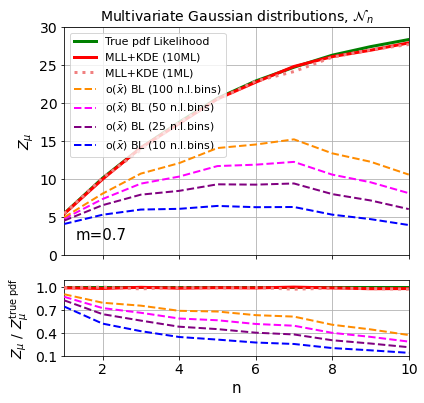

In [124]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

axs[0].plot(dim, store_Z_gaussian, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[0].plot(dim, store_Z_MLL_KDE, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[0].plot(dim, store_Z_MLL_KDE_1ML, ':', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[0].plot(dim, store_Z_bins_XG_100bins, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_100bins_eq, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins)' ,zorder=10)
axs[0].plot(dim, store_Z_bins_XG_50bins_eq, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_25bins_eq, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins_eq, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_1ML, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_1ML, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_1ML, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins_1ML, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_100bins_eq_1ML, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[0].plot(dim, store_Z_bins_XG_50bins_eq_1ML, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_25bins_eq_1ML, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_10bins_eq_1ML, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)


store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,store_Z_gaussian)]
store_Z_MLL_KDE_norm = [ a/b for a, b in zip(store_Z_MLL_KDE,store_Z_gaussian)]
store_Z_MLL_KDE_1ML_norm = [ a/b for a, b in zip(store_Z_MLL_KDE_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins,store_Z_gaussian)]
store_Z_bins_XG_50bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins,store_Z_gaussian)]
store_Z_bins_XG_25bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins,store_Z_gaussian)]
store_Z_bins_XG_10bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq,store_Z_gaussian)]
store_Z_bins_XG_100bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq_1ML,store_Z_gaussian)]
dim_norm = [ a/b for a, b in zip(dim,store_Z_gaussian)]


axs[1].plot(dim, store_Z_gaussian_norm, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[1].plot(dim, store_Z_MLL_KDE_norm, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[1].plot(dim, store_Z_MLL_KDE_1ML_norm, ':', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[1].plot(dim, store_Z_bins_XG_100bins_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_100bins_eq_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
axs[1].plot(dim, store_Z_bins_XG_50bins_eq_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_25bins_eq_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_eq_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_1ML_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_1ML_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_1ML_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_1ML_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_100bins_eq_1ML_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[1].plot(dim, store_Z_bins_XG_50bins_eq_1ML_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_25bins_eq_1ML_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_10bins_eq_1ML_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)




axs[0].text(1.3, 2, 'm=0.7', fontsize = 15)


axs[0].set_xlim([1, 10])
axs[0].set_ylim([0, 30])
axs[1].set_xlim([1, 10])
axs[1].set_ylim([0.1,1.1])
axs[0].set_ylabel('$Z_{\mu}$', fontsize=14)
axs[1].set_xlabel('n', fontsize=15)
axs[1].set_ylabel(r'$Z_{\mu}$ / $Z_{\mu}^{\mathrm{true \; pdf}}$', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0.1,0.4,0.7,1])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title('Multivariate Gaussian distributions, $\mathcal{N}_{n}$', fontsize=14)
axs[0].legend(loc="upper left", fontsize=11)
plt.tight_layout()
plt.savefig('images/' + '2gaussian-Z-dims-m07-C.pdf', format="pdf", bbox_inches="tight")
plt.show()